# Assignment4
## CS-5891-01 Special Topics Deep Learning
## Ronald Picard

In this notebook we will walk through the design, training, and testing of neural networks with multiple hidden layers. These nueral networks will be used for logistic regression, which is an archaic name for binary classification.

The binary classification will be performed on images of handwritten numerical digits. More specifically, the last numerical digit of my student ID. This digit happens to be 9. Therefore, the goal of our neural networks will be to output a the value of 1 when the handwritten numerical digit image input is a 9, and 0 in all other cases.

The data set we will be using is the MNIST data set. This is a very popular data set amoung the machine learning community. The data set contains 60,000 images, and each image contains a handwritten numerical digit. Each of the images have been provided with a truth label that corresponds to the handwritten digit within the image from the set {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}. 

For our case, we only care about when the image is 9. Therefore we will need to re-label the truth labels so that all truth labels with the value of 9 are given to the value of 1, and all other truth labels are given the value of 0. 

To start we need to import some needed classes.

In [2]:
import os
import numpy as np
import struct
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pyplot
import csv
import time

First, we must change our path string to the path of our data file containing the features. (Please note that you must change this string to point to the directory with the data file on your machine data file on your machine.) 

Second, we much change the string name of the data files to the names of the MNIST data files. (Please note that you may NOT need to change these. Only change them if your MINST data files are named differently.)

In [3]:
## path
path = 'C:/Users/computer/OneDrive - Vanderbilt/Vanderbilt_Spring_2019/CS_5891_01_SpecialTopicsDeepLearning/Assignment2/'

#Train data
fname_train_images = os.path.join(path, 'train-images.idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels.idx1-ubyte')  # the training set label file path

Next, we retrieve the data from the data files as follows. This imports the data into a feature tensor (3-D matrix) in which each index is a feature matrix corresponding to an image. The label data comes in the form of a vector where each index corresponds to the index of the feature matrix (image) of the feature tensor.  

In [4]:
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    images = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)

print('The training set contains', len(images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', images[0].shape)  # print the shape of the image

The training set contains 60000 images
The shape of the image is (28, 28)


Next, we need to perform both two steps; feature scaling and feature normalization. Feature scaling consists of converting the 28 X 28 image matrices into 784 X 1 feature vectors. In essence we will flatten the images out into vectors so that we can use an input a vector to our single neuron. Feature normalization is a process of normalizing the pixel data to between 0 <= x <= 1 (for logistic regression). Each pixel comes on a scale of 0 <= x <= 255. Since 255 is the maximum for every pixel we shall divide each pixel by that number (elementwise) in order to normalize each pixel to between 0 and 1 (inclusive).

One additional item we need to take care of is relabeling our label (truth) data so that we have a binary classification in which all 9s are converted to 1s and all other labels are converted to 0s.

In [5]:
# feature scaling
matrix_side_length = len(images[0])
vector_size = matrix_side_length*matrix_side_length

scaled_images_feature_matrix = []
for image in images:
    reshaped_image = np.array(image).reshape((vector_size))
    scaled_images_feature_matrix.append(reshaped_image)

# convert to numpy array
scaled_images_feature_matrix = np.transpose(np.array(scaled_images_feature_matrix))
print(scaled_images_feature_matrix.shape) # scaled_images_feature_matrix is a matrix of 60000 X 784
#print(scaled_images_feature_matrix[0].shape)

# feature normilization
normilization_factor = 1/255
normalized_scaled_images_feature_matrix = np.multiply(normilization_factor, scaled_images_feature_matrix)
print(normalized_scaled_images_feature_matrix.shape)
#print(normalized_scaled_images_feature_matrix[0])

# re-label for binary classification
value_for_1 = 9
binary_labels = []
for label in labels:
    if(label == 9):
        binary_labels.append(1)
    else:
        binary_labels.append(0)

# convert to numpy array
binary_labels = np.array(binary_labels)
print(len(binary_labels)) # binary_labels is a row vector of 1 X 60000
#print(binary_labels[0])


(784, 60000)
(784, 60000)
60000


In order to test the efficacy of our neural networks, we need to split up the our label data into two data sets; a smaller and a larger one. The larger set will be the training data that we will use to train our neural networks on. The smaller set will be the testing data that we will used to test the accuracy of our neural nets. The MNIST data set contains 60,000 images. Therefore, we will use 50,000 images for our training data set, and 10,000 images for our testing data set. 

It is common practice to use a smaller subset of the total data set to debug (ensure it works) and tune hyper-parameters before using the entire time-comsuming data set. This smaller subset is known as a validation set. Therefore, we will first use a validation data set of 600 images. 500 of these images will be used for as our training data set, and the other 100 of these images will be used for our test data set. 

Thus, we will begin by sifting out a validation set from our total data set.

In [193]:
# create a data set
size = vector_size

number_of_testing_images = 100
number_of_training_images = 500
number_of_validation_images = number_of_testing_images + number_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

factor = 0
for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        training_labels.append(binary_labels[index + factor])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        testing_labels.append(binary_labels[index + factor])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # validation_training_images is a matrix of 784 X 500
print(training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 500)
(500,)
(784, 100)
(100,)


Now we move on to the training of our neural network with multiple hidden layers. 

Part 1 - Feed Forword:

For these neural networks we will use multiple hidden layers with between 5-20 units per layer (neurons). The first layer will have an input of a matrix (784 X number_of_images) of vectorized images of 784 X 1, and will output a matrix (# of units X # of images). This matrix will be input into the next hidden layer, which output another matrix (# of units X # of images.) The output layer will take and input matrix that is the output matrix of the last hidden layer and will output a row vector of probabilities which we will convert into binary classifications of 0 or 1. (If P(x) >= 0.5 then we will convert it to a 1, otherwise we will convert to 0.) 

The model for the units of the hidden layers will be a vecorized linear model Z^[l] = W^[l]^T * A^[l-1] + B^[l], where W is a matrix of 5-10 units (# of units) X # of units or parameter weights, A is the input matrix of vectorized images (784 X # of images) or the output of one of the layers (1 X # of units), and B is a row vector of bias's. (Note: in this case, b will be scalar that applied in a broadcasing manner to save on memory.) The output of this model Z^[l] will be a matrix (5-10 units X # of images). Z^[1] will be subject to an activation function; which for this assignment will be relu (note: we will test tanh once for comparison). 

Hidden Layer Activation Function: relu activation function is A^[1]  = relu(Z) =  max(Z, 0).

The model of the output layer will be a vectorized linear model Z^[1] = W^[l] * A^[1] + b^[l] with a single unit. This linear model will be subjected to a sigmoid activation function.

The resultant row vector will then be used to calculate the cost function values in an elementwise manner. The cost function for this binary classification will be L(Y_Predicted, Y_Label) = -Y_Label^[l] * Log(A^[l]) - (1-Y_Predicted^[l]) * Log(1-A^[l]), where Y_Label is the True Label, Y_Predicted is the probability value predicted by the neural network, and A is the activation function value. The resultant cost row vector will be added up and divided by the number of elements in order to calculate the average cost.

Part 2 - Back Propogation:

The back propogation technique that we will use for training the neural network, will be gradient descent. This involves utilizing the gradient of the cost function to updated the model parameters in our layers. In order to calculate the gradient we will utilize the chain rule. The goal of back propogation is the adjust the parameter weights and bias's of our model to accurately perform binary classification. In general the chain rule can be used to find the gradient of the cost function (vecorzied rates of change) with respect to the model parameters. The following is the chain that we will utilize. 


Generalized Chain Rule for N layers: 

dL(A^[n], Y)/dW^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dW^[l];

dL(A^[n], Y)/dB^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dB^[l];



Output Layer - Back Propogation:

The partial derivative of the cost function with respect to the output layer sigmoid activation function is found by the following:

dL(A^[n], Y)/dA^[n] = -Y/A^[n] + (1-A^[n])/(1-A^[n]).


Due to the chain rule, the derivative of the cost function with respect to the linear model Z^[n] is found by the following:

dL(A^[n], y)/dz = dL(A^[n], y)/dA^[n] * dA^[n]/dZ^[n].

The derivative of the sigmoid activation function is da/dz is found by the following:

dA^[n]/dZ^[n] = sigma(Z^[n]) * (1-sigma(Z^[n]))

Therefore, the derivative of the cost function with respect to the output of the linear model is found by the following:

dL(A^[n], Y)/dA^[n] * dA^[n]/dZ^[n]. = (-Y/A^[n] + (1-Y)/(1-A^[n])) * (sigma(Z^[n]) * (1-sigma(Z^[n]))) = A^[n]-Y. (For convienence we will say dZ^[n] = A^[n]-Y.)

Now we can extrapolate the chain rule to all the paramters of the linear model our output layer.

dL(A^[n], Y)/dW^[n] = dZ^[n] * dZ^[n]/dW^[n] = dZ^[n] * A^[n-1] = A^[n-1] * dZ^[n] (we will change our notation to dW^[n] = A^[n-1] * dZ^[n] for convienence)

dL(A^[n], Y)/dB^[n] = dZ^[n] * dZ^[n]/dB^[n] = dZ^[n] (we will change our notation to dW^[n] = dZ^[n] for convienence)



Hidden Layers - Back Propagation:

dL(A^[n], Y)/dZ^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dA^[l]/dZ^[l]

dL(A^[n], Y)/dZ^[l] = dZ^[l+1] * dZ^[l+1]/dA^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1]. The reason this is element-wise is because we are propgating from a single neuron to a layer with multiple neurons (we shall rename this dz^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1] for conveinience) 

dA^[1]/dZ^[1] depends on the activation function we are using in the hidden layer (in this case relu): The derivative of relu activation function is dA^[l]/dZ^[l] = if Z^[l] > 0 then 1 else 0.


dL(A^[n], Y)/dW^[l] = dZ^[l] * dZ^[l]/dW^[l] = dZ^[l] * X^T (we will change our notation to dW^[l] = dZ^[l] * A[l-1]^T for convienence)

dL(A^[n], Y)/dB^[l] = dZ^[l] * dZ^[l]/dB^[l] = dZ^[l] (we will change our notation to dB^[l] = dZ^[l] for convienence)


Find vector averages:

m = # number of images

dW^[l] = 1/m * (A^[l-1] * dZ^[l])

dB^[l] = 1/m * (dZ^[l])


Finally, we will update our the weights and bias's of the layers.


W^[l]:= W^[l] - alpha * dW^[l]

B^[l]:= B^[l] - alpha * dB^[l]


The first thing we have have to do is initialize our weights and bias's. There are multiple ways to initialize weights and bias's. Typically we will set our values based on either a uniform distribution between ~0.01 and ~0.001, or a normal distribution with a mean between ~0.005 and and standard deviation of ~0.005 (some reasonable standard deviation). There is some flexibility in the initalization of the weights but in general they need to be small (not to small) and varied. The weights need to be different so that the gradients with respect to each other are different. In other words we don't aways want the relative rates of change to be 0. Additionally, we do not want to reach saturation on our output activation function where the gradients are 0 (vanishing gradiants). For this assignment we wills stick with with a uniform random between 0.001 and 0.01. We will also set a random seed each time so that we forms our rand values to be the same (or similar if there are more layers).

In [188]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(4,)
(4,)


Now we implement our gradient descent algorithm. To decrease lines of code and slightly increase efficienccy we will run the 3 network versions in one loop. Each one will have a different activation function in the hidden layer (i.e. sigmoid, tanh, relu). 

We will also collect data on the accuracy of our networks as a function of training iterations. To do this we will need to find the number of inaccuracate binary classifications (false positives & false negatives). This will be acommplished using our test data set. We will send our test data set through the network and compare the results with the true labels of the test data set. 

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 374
Main Loop Iteration: 375
Main Loop Iteration: 376
Main Loop Iteration: 377
Main Loop Iteration: 378
Main Loop Iteration: 379
Main Loop Iteration: 380
Main Loop Iteration: 381
Main Loop Iteration: 382
Main Loop Iteration: 383
Main Loop Iteration: 384
Main Loop Iteration: 385
Main Loop Iteration: 386
Main Loop Iteration: 387
Main Loop Iteration: 388
Main Loop Iteration: 389
Main Loop Iteration: 390
Main Loop Iteration: 391
Main Loop Iteration: 392
Main Loop Iteration: 393
Main Loop Iteration: 394
Main Loop Iteration: 395
Main Loop Iteration: 396
Main Loop Iteration: 397
Main Loop Iteration: 398
Main Loop Iteration: 399
Main Loop Iteration: 400
Main Loop Iteration: 401
Main Loop Iteration: 402
Main Loop Iteration: 403
Main Loop Iteration: 404
Main Loop Iteration: 405
Main Loop Iteration: 406
Main Loop Iteration: 407
Main Loop Iteration: 408
Main Loop Iteration: 409
Main Loop Iteration: 410
Main Loop Iteration: 411
Main Loop Iteration: 412
Main Loop Iteration: 413


Main Loop Iteration: 745
Main Loop Iteration: 746
Main Loop Iteration: 747
Main Loop Iteration: 748
Main Loop Iteration: 749
Main Loop Iteration: 750
Main Loop Iteration: 751
Main Loop Iteration: 752
Main Loop Iteration: 753
Main Loop Iteration: 754
Main Loop Iteration: 755
Main Loop Iteration: 756
Main Loop Iteration: 757
Main Loop Iteration: 758
Main Loop Iteration: 759
Main Loop Iteration: 760
Main Loop Iteration: 761
Main Loop Iteration: 762
Main Loop Iteration: 763
Main Loop Iteration: 764
Main Loop Iteration: 765
Main Loop Iteration: 766
Main Loop Iteration: 767
Main Loop Iteration: 768
Main Loop Iteration: 769
Main Loop Iteration: 770
Main Loop Iteration: 771
Main Loop Iteration: 772
Main Loop Iteration: 773
Main Loop Iteration: 774
Main Loop Iteration: 775
Main Loop Iteration: 776
Main Loop Iteration: 777
Main Loop Iteration: 778
Main Loop Iteration: 779
Main Loop Iteration: 780
Main Loop Iteration: 781
Main Loop Iteration: 782
Main Loop Iteration: 783
Main Loop Iteration: 784


Main Loop Iteration: 1106
Main Loop Iteration: 1107
Main Loop Iteration: 1108
Main Loop Iteration: 1109
Main Loop Iteration: 1110
Main Loop Iteration: 1111
Main Loop Iteration: 1112
Main Loop Iteration: 1113
Main Loop Iteration: 1114
Main Loop Iteration: 1115
Main Loop Iteration: 1116
Main Loop Iteration: 1117
Main Loop Iteration: 1118
Main Loop Iteration: 1119
Main Loop Iteration: 1120
Main Loop Iteration: 1121
Main Loop Iteration: 1122
Main Loop Iteration: 1123
Main Loop Iteration: 1124
Main Loop Iteration: 1125
Main Loop Iteration: 1126
Main Loop Iteration: 1127
Main Loop Iteration: 1128
Main Loop Iteration: 1129
Main Loop Iteration: 1130
Main Loop Iteration: 1131
Main Loop Iteration: 1132
Main Loop Iteration: 1133
Main Loop Iteration: 1134
Main Loop Iteration: 1135
Main Loop Iteration: 1136
Main Loop Iteration: 1137
Main Loop Iteration: 1138
Main Loop Iteration: 1139
Main Loop Iteration: 1140
Main Loop Iteration: 1141
Main Loop Iteration: 1142
Main Loop Iteration: 1143
Main Loop It

Main Loop Iteration: 1435
Main Loop Iteration: 1436
Main Loop Iteration: 1437
Main Loop Iteration: 1438
Main Loop Iteration: 1439
Main Loop Iteration: 1440
Main Loop Iteration: 1441
Main Loop Iteration: 1442
Main Loop Iteration: 1443
Main Loop Iteration: 1444
Main Loop Iteration: 1445
Main Loop Iteration: 1446
Main Loop Iteration: 1447
Main Loop Iteration: 1448
Main Loop Iteration: 1449
Main Loop Iteration: 1450
Main Loop Iteration: 1451
Main Loop Iteration: 1452
Main Loop Iteration: 1453
Main Loop Iteration: 1454
Main Loop Iteration: 1455
Main Loop Iteration: 1456
Main Loop Iteration: 1457
Main Loop Iteration: 1458
Main Loop Iteration: 1459
Main Loop Iteration: 1460
Main Loop Iteration: 1461
Main Loop Iteration: 1462
Main Loop Iteration: 1463
Main Loop Iteration: 1464
Main Loop Iteration: 1465
Main Loop Iteration: 1466
Main Loop Iteration: 1467
Main Loop Iteration: 1468
Main Loop Iteration: 1469
Main Loop Iteration: 1470
Main Loop Iteration: 1471
Main Loop Iteration: 1472
Main Loop It

Main Loop Iteration: 1757
Main Loop Iteration: 1758
Main Loop Iteration: 1759
Main Loop Iteration: 1760
Main Loop Iteration: 1761
Main Loop Iteration: 1762
Main Loop Iteration: 1763
Main Loop Iteration: 1764
Main Loop Iteration: 1765
Main Loop Iteration: 1766
Main Loop Iteration: 1767
Main Loop Iteration: 1768
Main Loop Iteration: 1769
Main Loop Iteration: 1770
Main Loop Iteration: 1771
Main Loop Iteration: 1772
Main Loop Iteration: 1773
Main Loop Iteration: 1774
Main Loop Iteration: 1775
Main Loop Iteration: 1776
Main Loop Iteration: 1777
Main Loop Iteration: 1778
Main Loop Iteration: 1779
Main Loop Iteration: 1780
Main Loop Iteration: 1781
Main Loop Iteration: 1782
Main Loop Iteration: 1783
Main Loop Iteration: 1784
Main Loop Iteration: 1785
Main Loop Iteration: 1786
Main Loop Iteration: 1787
Main Loop Iteration: 1788
Main Loop Iteration: 1789
Main Loop Iteration: 1790
Main Loop Iteration: 1791
Main Loop Iteration: 1792
Main Loop Iteration: 1793
Main Loop Iteration: 1794
Main Loop It

Main Loop Iteration: 2084
Main Loop Iteration: 2085
Main Loop Iteration: 2086
Main Loop Iteration: 2087
Main Loop Iteration: 2088
Main Loop Iteration: 2089
Main Loop Iteration: 2090
Main Loop Iteration: 2091
Main Loop Iteration: 2092
Main Loop Iteration: 2093
Main Loop Iteration: 2094
Main Loop Iteration: 2095
Main Loop Iteration: 2096
Main Loop Iteration: 2097
Main Loop Iteration: 2098
Main Loop Iteration: 2099
Main Loop Iteration: 2100
Main Loop Iteration: 2101
Main Loop Iteration: 2102
Main Loop Iteration: 2103
Main Loop Iteration: 2104
Main Loop Iteration: 2105
Main Loop Iteration: 2106
Main Loop Iteration: 2107
Main Loop Iteration: 2108
Main Loop Iteration: 2109
Main Loop Iteration: 2110
Main Loop Iteration: 2111
Main Loop Iteration: 2112
Main Loop Iteration: 2113
Main Loop Iteration: 2114
Main Loop Iteration: 2115
Main Loop Iteration: 2116
Main Loop Iteration: 2117
Main Loop Iteration: 2118
Main Loop Iteration: 2119
Main Loop Iteration: 2120
Main Loop Iteration: 2121
Main Loop It

Main Loop Iteration: 2409
Main Loop Iteration: 2410
Main Loop Iteration: 2411
Main Loop Iteration: 2412
Main Loop Iteration: 2413
Main Loop Iteration: 2414
Main Loop Iteration: 2415
Main Loop Iteration: 2416
Main Loop Iteration: 2417
Main Loop Iteration: 2418
Main Loop Iteration: 2419
Main Loop Iteration: 2420
Main Loop Iteration: 2421
Main Loop Iteration: 2422
Main Loop Iteration: 2423
Main Loop Iteration: 2424
Main Loop Iteration: 2425
Main Loop Iteration: 2426
Main Loop Iteration: 2427
Main Loop Iteration: 2428
Main Loop Iteration: 2429
Main Loop Iteration: 2430
Main Loop Iteration: 2431
Main Loop Iteration: 2432
Main Loop Iteration: 2433
Main Loop Iteration: 2434
Main Loop Iteration: 2435
Main Loop Iteration: 2436
Main Loop Iteration: 2437
Main Loop Iteration: 2438
Main Loop Iteration: 2439
Main Loop Iteration: 2440
Main Loop Iteration: 2441
Main Loop Iteration: 2442
Main Loop Iteration: 2443
Main Loop Iteration: 2444
Main Loop Iteration: 2445
Main Loop Iteration: 2446
Main Loop It

Main Loop Iteration: 2726
Main Loop Iteration: 2727
Main Loop Iteration: 2728
Main Loop Iteration: 2729
Main Loop Iteration: 2730
Main Loop Iteration: 2731
Main Loop Iteration: 2732
Main Loop Iteration: 2733
Main Loop Iteration: 2734
Main Loop Iteration: 2735
Main Loop Iteration: 2736
Main Loop Iteration: 2737
Main Loop Iteration: 2738
Main Loop Iteration: 2739
Main Loop Iteration: 2740
Main Loop Iteration: 2741
Main Loop Iteration: 2742
Main Loop Iteration: 2743
Main Loop Iteration: 2744
Main Loop Iteration: 2745
Main Loop Iteration: 2746
Main Loop Iteration: 2747
Main Loop Iteration: 2748
Main Loop Iteration: 2749
Main Loop Iteration: 2750
Main Loop Iteration: 2751
Main Loop Iteration: 2752
Main Loop Iteration: 2753
Main Loop Iteration: 2754
Main Loop Iteration: 2755
Main Loop Iteration: 2756
Main Loop Iteration: 2757
Main Loop Iteration: 2758
Main Loop Iteration: 2759
Main Loop Iteration: 2760
Main Loop Iteration: 2761
Main Loop Iteration: 2762
Main Loop Iteration: 2763
Main Loop It

Main Loop Iteration: 3087
Main Loop Iteration: 3088
Main Loop Iteration: 3089
Main Loop Iteration: 3090
Main Loop Iteration: 3091
Main Loop Iteration: 3092
Main Loop Iteration: 3093
Main Loop Iteration: 3094
Main Loop Iteration: 3095
Main Loop Iteration: 3096
Main Loop Iteration: 3097
Main Loop Iteration: 3098
Main Loop Iteration: 3099
Main Loop Iteration: 3100
Main Loop Iteration: 3101
Main Loop Iteration: 3102
Main Loop Iteration: 3103
Main Loop Iteration: 3104
Main Loop Iteration: 3105
Main Loop Iteration: 3106
Main Loop Iteration: 3107
Main Loop Iteration: 3108
Main Loop Iteration: 3109
Main Loop Iteration: 3110
Main Loop Iteration: 3111
Main Loop Iteration: 3112
Main Loop Iteration: 3113
Main Loop Iteration: 3114
Main Loop Iteration: 3115
Main Loop Iteration: 3116
Main Loop Iteration: 3117
Main Loop Iteration: 3118
Main Loop Iteration: 3119
Main Loop Iteration: 3120
Main Loop Iteration: 3121
Main Loop Iteration: 3122
Main Loop Iteration: 3123
Main Loop Iteration: 3124
Main Loop It

Main Loop Iteration: 3409
Main Loop Iteration: 3410
Main Loop Iteration: 3411
Main Loop Iteration: 3412
Main Loop Iteration: 3413
Main Loop Iteration: 3414
Main Loop Iteration: 3415
Main Loop Iteration: 3416
Main Loop Iteration: 3417
Main Loop Iteration: 3418
Main Loop Iteration: 3419
Main Loop Iteration: 3420
Main Loop Iteration: 3421
Main Loop Iteration: 3422
Main Loop Iteration: 3423
Main Loop Iteration: 3424
Main Loop Iteration: 3425
Main Loop Iteration: 3426
Main Loop Iteration: 3427
Main Loop Iteration: 3428
Main Loop Iteration: 3429
Main Loop Iteration: 3430
Main Loop Iteration: 3431
Main Loop Iteration: 3432
Main Loop Iteration: 3433
Main Loop Iteration: 3434
Main Loop Iteration: 3435
Main Loop Iteration: 3436
Main Loop Iteration: 3437
Main Loop Iteration: 3438
Main Loop Iteration: 3439
Main Loop Iteration: 3440
Main Loop Iteration: 3441
Main Loop Iteration: 3442
Main Loop Iteration: 3443
Main Loop Iteration: 3444
Main Loop Iteration: 3445
Main Loop Iteration: 3446
Main Loop It

Main Loop Iteration: 3728
Main Loop Iteration: 3729
Main Loop Iteration: 3730
Main Loop Iteration: 3731
Main Loop Iteration: 3732
Main Loop Iteration: 3733
Main Loop Iteration: 3734
Main Loop Iteration: 3735
Main Loop Iteration: 3736
Main Loop Iteration: 3737
Main Loop Iteration: 3738
Main Loop Iteration: 3739
Main Loop Iteration: 3740
Main Loop Iteration: 3741
Main Loop Iteration: 3742
Main Loop Iteration: 3743
Main Loop Iteration: 3744
Main Loop Iteration: 3745
Main Loop Iteration: 3746
Main Loop Iteration: 3747
Main Loop Iteration: 3748
Main Loop Iteration: 3749
Main Loop Iteration: 3750
Main Loop Iteration: 3751
Main Loop Iteration: 3752
Main Loop Iteration: 3753
Main Loop Iteration: 3754
Main Loop Iteration: 3755
Main Loop Iteration: 3756
Main Loop Iteration: 3757
Main Loop Iteration: 3758
Main Loop Iteration: 3759
Main Loop Iteration: 3760
Main Loop Iteration: 3761
Main Loop Iteration: 3762
Main Loop Iteration: 3763
Main Loop Iteration: 3764
Main Loop Iteration: 3765
Main Loop It

Main Loop Iteration: 4053
Main Loop Iteration: 4054
Main Loop Iteration: 4055
Main Loop Iteration: 4056
Main Loop Iteration: 4057
Main Loop Iteration: 4058
Main Loop Iteration: 4059
Main Loop Iteration: 4060
Main Loop Iteration: 4061
Main Loop Iteration: 4062
Main Loop Iteration: 4063
Main Loop Iteration: 4064
Main Loop Iteration: 4065
Main Loop Iteration: 4066
Main Loop Iteration: 4067
Main Loop Iteration: 4068
Main Loop Iteration: 4069
Main Loop Iteration: 4070
Main Loop Iteration: 4071
Main Loop Iteration: 4072
Main Loop Iteration: 4073
Main Loop Iteration: 4074
Main Loop Iteration: 4075
Main Loop Iteration: 4076
Main Loop Iteration: 4077
Main Loop Iteration: 4078
Main Loop Iteration: 4079
Main Loop Iteration: 4080
Main Loop Iteration: 4081
Main Loop Iteration: 4082
Main Loop Iteration: 4083
Main Loop Iteration: 4084
Main Loop Iteration: 4085
Main Loop Iteration: 4086
Main Loop Iteration: 4087
Main Loop Iteration: 4088
Main Loop Iteration: 4089
Main Loop Iteration: 4090
Main Loop It

Main Loop Iteration: 4408
Main Loop Iteration: 4409
Main Loop Iteration: 4410
Main Loop Iteration: 4411
Main Loop Iteration: 4412
Main Loop Iteration: 4413
Main Loop Iteration: 4414
Main Loop Iteration: 4415
Main Loop Iteration: 4416
Main Loop Iteration: 4417
Main Loop Iteration: 4418
Main Loop Iteration: 4419
Main Loop Iteration: 4420
Main Loop Iteration: 4421
Main Loop Iteration: 4422
Main Loop Iteration: 4423
Main Loop Iteration: 4424
Main Loop Iteration: 4425
Main Loop Iteration: 4426
Main Loop Iteration: 4427
Main Loop Iteration: 4428
Main Loop Iteration: 4429
Main Loop Iteration: 4430
Main Loop Iteration: 4431
Main Loop Iteration: 4432
Main Loop Iteration: 4433
Main Loop Iteration: 4434
Main Loop Iteration: 4435
Main Loop Iteration: 4436
Main Loop Iteration: 4437
Main Loop Iteration: 4438
Main Loop Iteration: 4439
Main Loop Iteration: 4440
Main Loop Iteration: 4441
Main Loop Iteration: 4442
Main Loop Iteration: 4443
Main Loop Iteration: 4444
Main Loop Iteration: 4445
Main Loop It

Main Loop Iteration: 4750
Main Loop Iteration: 4751
Main Loop Iteration: 4752
Main Loop Iteration: 4753
Main Loop Iteration: 4754
Main Loop Iteration: 4755
Main Loop Iteration: 4756
Main Loop Iteration: 4757
Main Loop Iteration: 4758
Main Loop Iteration: 4759
Main Loop Iteration: 4760
Main Loop Iteration: 4761
Main Loop Iteration: 4762
Main Loop Iteration: 4763
Main Loop Iteration: 4764
Main Loop Iteration: 4765
Main Loop Iteration: 4766
Main Loop Iteration: 4767
Main Loop Iteration: 4768
Main Loop Iteration: 4769
Main Loop Iteration: 4770
Main Loop Iteration: 4771
Main Loop Iteration: 4772
Main Loop Iteration: 4773
Main Loop Iteration: 4774
Main Loop Iteration: 4775
Main Loop Iteration: 4776
Main Loop Iteration: 4777
Main Loop Iteration: 4778
Main Loop Iteration: 4779
Main Loop Iteration: 4780
Main Loop Iteration: 4781
Main Loop Iteration: 4782
Main Loop Iteration: 4783
Main Loop Iteration: 4784
Main Loop Iteration: 4785
Main Loop Iteration: 4786
Main Loop Iteration: 4787
Main Loop It

Main Loop Iteration: 5093
Main Loop Iteration: 5094
Main Loop Iteration: 5095
Main Loop Iteration: 5096
Main Loop Iteration: 5097
Main Loop Iteration: 5098
Main Loop Iteration: 5099
Main Loop Iteration: 5100
Main Loop Iteration: 5101
Main Loop Iteration: 5102
Main Loop Iteration: 5103
Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop It

Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop Iteration: 5449
Main Loop Iteration: 5450
Main Loop Iteration: 5451
Main Loop Iteration: 5452
Main Loop Iteration: 5453
Main Loop Iteration: 5454
Main Loop Iteration: 5455
Main Loop Iteration: 5456
Main Loop Iteration: 5457
Main Loop Iteration: 5458
Main Loop Iteration: 5459
Main Loop Iteration: 5460
Main Loop Iteration: 5461
Main Loop Iteration: 5462
Main Loop Iteration: 5463
Main Loop Iteration: 5464
Main Loop Iteration: 5465
Main Loop Iteration: 5466
Main Loop Iteration: 5467
Main Loop Iteration: 5468
Main Loop It

Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop Iteration: 5767
Main Loop Iteration: 5768
Main Loop Iteration: 5769
Main Loop Iteration: 5770
Main Loop Iteration: 5771
Main Loop Iteration: 5772
Main Loop Iteration: 5773
Main Loop Iteration: 5774
Main Loop Iteration: 5775
Main Loop Iteration: 5776
Main Loop Iteration: 5777
Main Loop Iteration: 5778
Main Loop Iteration: 5779
Main Loop Iteration: 5780
Main Loop Iteration: 5781
Main Loop Iteration: 5782
Main Loop Iteration: 5783
Main Loop Iteration: 5784
Main Loop Iteration: 5785
Main Loop Iteration: 5786
Main Loop Iteration: 5787
Main Loop Iteration: 5788
Main Loop Iteration: 5789
Main Loop Iteration: 5790
Main Loop Iteration: 5791
Main Loop Iteration: 5792
Main Loop It

Main Loop Iteration: 6094
Main Loop Iteration: 6095
Main Loop Iteration: 6096
Main Loop Iteration: 6097
Main Loop Iteration: 6098
Main Loop Iteration: 6099
Main Loop Iteration: 6100
Main Loop Iteration: 6101
Main Loop Iteration: 6102
Main Loop Iteration: 6103
Main Loop Iteration: 6104
Main Loop Iteration: 6105
Main Loop Iteration: 6106
Main Loop Iteration: 6107
Main Loop Iteration: 6108
Main Loop Iteration: 6109
Main Loop Iteration: 6110
Main Loop Iteration: 6111
Main Loop Iteration: 6112
Main Loop Iteration: 6113
Main Loop Iteration: 6114
Main Loop Iteration: 6115
Main Loop Iteration: 6116
Main Loop Iteration: 6117
Main Loop Iteration: 6118
Main Loop Iteration: 6119
Main Loop Iteration: 6120
Main Loop Iteration: 6121
Main Loop Iteration: 6122
Main Loop Iteration: 6123
Main Loop Iteration: 6124
Main Loop Iteration: 6125
Main Loop Iteration: 6126
Main Loop Iteration: 6127
Main Loop Iteration: 6128
Main Loop Iteration: 6129
Main Loop Iteration: 6130
Main Loop Iteration: 6131
Main Loop It

Main Loop Iteration: 6410
Main Loop Iteration: 6411
Main Loop Iteration: 6412
Main Loop Iteration: 6413
Main Loop Iteration: 6414
Main Loop Iteration: 6415
Main Loop Iteration: 6416
Main Loop Iteration: 6417
Main Loop Iteration: 6418
Main Loop Iteration: 6419
Main Loop Iteration: 6420
Main Loop Iteration: 6421
Main Loop Iteration: 6422
Main Loop Iteration: 6423
Main Loop Iteration: 6424
Main Loop Iteration: 6425
Main Loop Iteration: 6426
Main Loop Iteration: 6427
Main Loop Iteration: 6428
Main Loop Iteration: 6429
Main Loop Iteration: 6430
Main Loop Iteration: 6431
Main Loop Iteration: 6432
Main Loop Iteration: 6433
Main Loop Iteration: 6434
Main Loop Iteration: 6435
Main Loop Iteration: 6436
Main Loop Iteration: 6437
Main Loop Iteration: 6438
Main Loop Iteration: 6439
Main Loop Iteration: 6440
Main Loop Iteration: 6441
Main Loop Iteration: 6442
Main Loop Iteration: 6443
Main Loop Iteration: 6444
Main Loop Iteration: 6445
Main Loop Iteration: 6446
Main Loop Iteration: 6447
Main Loop It

Main Loop Iteration: 6765
Main Loop Iteration: 6766
Main Loop Iteration: 6767
Main Loop Iteration: 6768
Main Loop Iteration: 6769
Main Loop Iteration: 6770
Main Loop Iteration: 6771
Main Loop Iteration: 6772
Main Loop Iteration: 6773
Main Loop Iteration: 6774
Main Loop Iteration: 6775
Main Loop Iteration: 6776
Main Loop Iteration: 6777
Main Loop Iteration: 6778
Main Loop Iteration: 6779
Main Loop Iteration: 6780
Main Loop Iteration: 6781
Main Loop Iteration: 6782
Main Loop Iteration: 6783
Main Loop Iteration: 6784
Main Loop Iteration: 6785
Main Loop Iteration: 6786
Main Loop Iteration: 6787
Main Loop Iteration: 6788
Main Loop Iteration: 6789
Main Loop Iteration: 6790
Main Loop Iteration: 6791
Main Loop Iteration: 6792
Main Loop Iteration: 6793
Main Loop Iteration: 6794
Main Loop Iteration: 6795
Main Loop Iteration: 6796
Main Loop Iteration: 6797
Main Loop Iteration: 6798
Main Loop Iteration: 6799
Main Loop Iteration: 6800
Main Loop Iteration: 6801
Main Loop Iteration: 6802
Main Loop It

Main Loop Iteration: 7086
Main Loop Iteration: 7087
Main Loop Iteration: 7088
Main Loop Iteration: 7089
Main Loop Iteration: 7090
Main Loop Iteration: 7091
Main Loop Iteration: 7092
Main Loop Iteration: 7093
Main Loop Iteration: 7094
Main Loop Iteration: 7095
Main Loop Iteration: 7096
Main Loop Iteration: 7097
Main Loop Iteration: 7098
Main Loop Iteration: 7099
Main Loop Iteration: 7100
Main Loop Iteration: 7101
Main Loop Iteration: 7102
Main Loop Iteration: 7103
Main Loop Iteration: 7104
Main Loop Iteration: 7105
Main Loop Iteration: 7106
Main Loop Iteration: 7107
Main Loop Iteration: 7108
Main Loop Iteration: 7109
Main Loop Iteration: 7110
Main Loop Iteration: 7111
Main Loop Iteration: 7112
Main Loop Iteration: 7113
Main Loop Iteration: 7114
Main Loop Iteration: 7115
Main Loop Iteration: 7116
Main Loop Iteration: 7117
Main Loop Iteration: 7118
Main Loop Iteration: 7119
Main Loop Iteration: 7120
Main Loop Iteration: 7121
Main Loop Iteration: 7122
Main Loop Iteration: 7123
Main Loop It

Main Loop Iteration: 7408
Main Loop Iteration: 7409
Main Loop Iteration: 7410
Main Loop Iteration: 7411
Main Loop Iteration: 7412
Main Loop Iteration: 7413
Main Loop Iteration: 7414
Main Loop Iteration: 7415
Main Loop Iteration: 7416
Main Loop Iteration: 7417
Main Loop Iteration: 7418
Main Loop Iteration: 7419
Main Loop Iteration: 7420
Main Loop Iteration: 7421
Main Loop Iteration: 7422
Main Loop Iteration: 7423
Main Loop Iteration: 7424
Main Loop Iteration: 7425
Main Loop Iteration: 7426
Main Loop Iteration: 7427
Main Loop Iteration: 7428
Main Loop Iteration: 7429
Main Loop Iteration: 7430
Main Loop Iteration: 7431
Main Loop Iteration: 7432
Main Loop Iteration: 7433
Main Loop Iteration: 7434
Main Loop Iteration: 7435
Main Loop Iteration: 7436
Main Loop Iteration: 7437
Main Loop Iteration: 7438
Main Loop Iteration: 7439
Main Loop Iteration: 7440
Main Loop Iteration: 7441
Main Loop Iteration: 7442
Main Loop Iteration: 7443
Main Loop Iteration: 7444
Main Loop Iteration: 7445
Main Loop It

Main Loop Iteration: 7724
Main Loop Iteration: 7725
Main Loop Iteration: 7726
Main Loop Iteration: 7727
Main Loop Iteration: 7728
Main Loop Iteration: 7729
Main Loop Iteration: 7730
Main Loop Iteration: 7731
Main Loop Iteration: 7732
Main Loop Iteration: 7733
Main Loop Iteration: 7734
Main Loop Iteration: 7735
Main Loop Iteration: 7736
Main Loop Iteration: 7737
Main Loop Iteration: 7738
Main Loop Iteration: 7739
Main Loop Iteration: 7740
Main Loop Iteration: 7741
Main Loop Iteration: 7742
Main Loop Iteration: 7743
Main Loop Iteration: 7744
Main Loop Iteration: 7745
Main Loop Iteration: 7746
Main Loop Iteration: 7747
Main Loop Iteration: 7748
Main Loop Iteration: 7749
Main Loop Iteration: 7750
Main Loop Iteration: 7751
Main Loop Iteration: 7752
Main Loop Iteration: 7753
Main Loop Iteration: 7754
Main Loop Iteration: 7755
Main Loop Iteration: 7756
Main Loop Iteration: 7757
Main Loop Iteration: 7758
Main Loop Iteration: 7759
Main Loop Iteration: 7760
Main Loop Iteration: 7761
Main Loop It

Main Loop Iteration: 8066
Main Loop Iteration: 8067
Main Loop Iteration: 8068
Main Loop Iteration: 8069
Main Loop Iteration: 8070
Main Loop Iteration: 8071
Main Loop Iteration: 8072
Main Loop Iteration: 8073
Main Loop Iteration: 8074
Main Loop Iteration: 8075
Main Loop Iteration: 8076
Main Loop Iteration: 8077
Main Loop Iteration: 8078
Main Loop Iteration: 8079
Main Loop Iteration: 8080
Main Loop Iteration: 8081
Main Loop Iteration: 8082
Main Loop Iteration: 8083
Main Loop Iteration: 8084
Main Loop Iteration: 8085
Main Loop Iteration: 8086
Main Loop Iteration: 8087
Main Loop Iteration: 8088
Main Loop Iteration: 8089
Main Loop Iteration: 8090
Main Loop Iteration: 8091
Main Loop Iteration: 8092
Main Loop Iteration: 8093
Main Loop Iteration: 8094
Main Loop Iteration: 8095
Main Loop Iteration: 8096
Main Loop Iteration: 8097
Main Loop Iteration: 8098
Main Loop Iteration: 8099
Main Loop Iteration: 8100
Main Loop Iteration: 8101
Main Loop Iteration: 8102
Main Loop Iteration: 8103
Main Loop It

Main Loop Iteration: 8428
Main Loop Iteration: 8429
Main Loop Iteration: 8430
Main Loop Iteration: 8431
Main Loop Iteration: 8432
Main Loop Iteration: 8433
Main Loop Iteration: 8434
Main Loop Iteration: 8435
Main Loop Iteration: 8436
Main Loop Iteration: 8437
Main Loop Iteration: 8438
Main Loop Iteration: 8439
Main Loop Iteration: 8440
Main Loop Iteration: 8441
Main Loop Iteration: 8442
Main Loop Iteration: 8443
Main Loop Iteration: 8444
Main Loop Iteration: 8445
Main Loop Iteration: 8446
Main Loop Iteration: 8447
Main Loop Iteration: 8448
Main Loop Iteration: 8449
Main Loop Iteration: 8450
Main Loop Iteration: 8451
Main Loop Iteration: 8452
Main Loop Iteration: 8453
Main Loop Iteration: 8454
Main Loop Iteration: 8455
Main Loop Iteration: 8456
Main Loop Iteration: 8457
Main Loop Iteration: 8458
Main Loop Iteration: 8459
Main Loop Iteration: 8460
Main Loop Iteration: 8461
Main Loop Iteration: 8462
Main Loop Iteration: 8463
Main Loop Iteration: 8464
Main Loop Iteration: 8465
Main Loop It

Main Loop Iteration: 8785
Main Loop Iteration: 8786
Main Loop Iteration: 8787
Main Loop Iteration: 8788
Main Loop Iteration: 8789
Main Loop Iteration: 8790
Main Loop Iteration: 8791
Main Loop Iteration: 8792
Main Loop Iteration: 8793
Main Loop Iteration: 8794
Main Loop Iteration: 8795
Main Loop Iteration: 8796
Main Loop Iteration: 8797
Main Loop Iteration: 8798
Main Loop Iteration: 8799
Main Loop Iteration: 8800
Main Loop Iteration: 8801
Main Loop Iteration: 8802
Main Loop Iteration: 8803
Main Loop Iteration: 8804
Main Loop Iteration: 8805
Main Loop Iteration: 8806
Main Loop Iteration: 8807
Main Loop Iteration: 8808
Main Loop Iteration: 8809
Main Loop Iteration: 8810
Main Loop Iteration: 8811
Main Loop Iteration: 8812
Main Loop Iteration: 8813
Main Loop Iteration: 8814
Main Loop Iteration: 8815
Main Loop Iteration: 8816
Main Loop Iteration: 8817
Main Loop Iteration: 8818
Main Loop Iteration: 8819
Main Loop Iteration: 8820
Main Loop Iteration: 8821
Main Loop Iteration: 8822
Main Loop It

Main Loop Iteration: 9130
Main Loop Iteration: 9131
Main Loop Iteration: 9132
Main Loop Iteration: 9133
Main Loop Iteration: 9134
Main Loop Iteration: 9135
Main Loop Iteration: 9136
Main Loop Iteration: 9137
Main Loop Iteration: 9138
Main Loop Iteration: 9139
Main Loop Iteration: 9140
Main Loop Iteration: 9141
Main Loop Iteration: 9142
Main Loop Iteration: 9143
Main Loop Iteration: 9144
Main Loop Iteration: 9145
Main Loop Iteration: 9146
Main Loop Iteration: 9147
Main Loop Iteration: 9148
Main Loop Iteration: 9149
Main Loop Iteration: 9150
Main Loop Iteration: 9151
Main Loop Iteration: 9152
Main Loop Iteration: 9153
Main Loop Iteration: 9154
Main Loop Iteration: 9155
Main Loop Iteration: 9156
Main Loop Iteration: 9157
Main Loop Iteration: 9158
Main Loop Iteration: 9159
Main Loop Iteration: 9160
Main Loop Iteration: 9161
Main Loop Iteration: 9162
Main Loop Iteration: 9163
Main Loop Iteration: 9164
Main Loop Iteration: 9165
Main Loop Iteration: 9166
Main Loop Iteration: 9167
Main Loop It

Main Loop Iteration: 9472
Main Loop Iteration: 9473
Main Loop Iteration: 9474
Main Loop Iteration: 9475
Main Loop Iteration: 9476
Main Loop Iteration: 9477
Main Loop Iteration: 9478
Main Loop Iteration: 9479
Main Loop Iteration: 9480
Main Loop Iteration: 9481
Main Loop Iteration: 9482
Main Loop Iteration: 9483
Main Loop Iteration: 9484
Main Loop Iteration: 9485
Main Loop Iteration: 9486
Main Loop Iteration: 9487
Main Loop Iteration: 9488
Main Loop Iteration: 9489
Main Loop Iteration: 9490
Main Loop Iteration: 9491
Main Loop Iteration: 9492
Main Loop Iteration: 9493
Main Loop Iteration: 9494
Main Loop Iteration: 9495
Main Loop Iteration: 9496
Main Loop Iteration: 9497
Main Loop Iteration: 9498
Main Loop Iteration: 9499
Main Loop Iteration: 9500
Main Loop Iteration: 9501
Main Loop Iteration: 9502
Main Loop Iteration: 9503
Main Loop Iteration: 9504
Main Loop Iteration: 9505
Main Loop Iteration: 9506
Main Loop Iteration: 9507
Main Loop Iteration: 9508
Main Loop Iteration: 9509
Main Loop It

Main Loop Iteration: 9812
Main Loop Iteration: 9813
Main Loop Iteration: 9814
Main Loop Iteration: 9815
Main Loop Iteration: 9816
Main Loop Iteration: 9817
Main Loop Iteration: 9818
Main Loop Iteration: 9819
Main Loop Iteration: 9820
Main Loop Iteration: 9821
Main Loop Iteration: 9822
Main Loop Iteration: 9823
Main Loop Iteration: 9824
Main Loop Iteration: 9825
Main Loop Iteration: 9826
Main Loop Iteration: 9827
Main Loop Iteration: 9828
Main Loop Iteration: 9829
Main Loop Iteration: 9830
Main Loop Iteration: 9831
Main Loop Iteration: 9832
Main Loop Iteration: 9833
Main Loop Iteration: 9834
Main Loop Iteration: 9835
Main Loop Iteration: 9836
Main Loop Iteration: 9837
Main Loop Iteration: 9838
Main Loop Iteration: 9839
Main Loop Iteration: 9840
Main Loop Iteration: 9841
Main Loop Iteration: 9842
Main Loop Iteration: 9843
Main Loop Iteration: 9844
Main Loop Iteration: 9845
Main Loop Iteration: 9846
Main Loop Iteration: 9847
Main Loop Iteration: 9848
Main Loop Iteration: 9849
Main Loop It

Main Loop Iteration: 10124
Main Loop Iteration: 10125
Main Loop Iteration: 10126
Main Loop Iteration: 10127
Main Loop Iteration: 10128
Main Loop Iteration: 10129
Main Loop Iteration: 10130
Main Loop Iteration: 10131
Main Loop Iteration: 10132
Main Loop Iteration: 10133
Main Loop Iteration: 10134
Main Loop Iteration: 10135
Main Loop Iteration: 10136
Main Loop Iteration: 10137
Main Loop Iteration: 10138
Main Loop Iteration: 10139
Main Loop Iteration: 10140
Main Loop Iteration: 10141
Main Loop Iteration: 10142
Main Loop Iteration: 10143
Main Loop Iteration: 10144
Main Loop Iteration: 10145
Main Loop Iteration: 10146
Main Loop Iteration: 10147
Main Loop Iteration: 10148
Main Loop Iteration: 10149
Main Loop Iteration: 10150
Main Loop Iteration: 10151
Main Loop Iteration: 10152
Main Loop Iteration: 10153
Main Loop Iteration: 10154
Main Loop Iteration: 10155
Main Loop Iteration: 10156
Main Loop Iteration: 10157
Main Loop Iteration: 10158
Main Loop Iteration: 10159
Main Loop Iteration: 10160
M

Main Loop Iteration: 10435
Main Loop Iteration: 10436
Main Loop Iteration: 10437
Main Loop Iteration: 10438
Main Loop Iteration: 10439
Main Loop Iteration: 10440
Main Loop Iteration: 10441
Main Loop Iteration: 10442
Main Loop Iteration: 10443
Main Loop Iteration: 10444
Main Loop Iteration: 10445
Main Loop Iteration: 10446
Main Loop Iteration: 10447
Main Loop Iteration: 10448
Main Loop Iteration: 10449
Main Loop Iteration: 10450
Main Loop Iteration: 10451
Main Loop Iteration: 10452
Main Loop Iteration: 10453
Main Loop Iteration: 10454
Main Loop Iteration: 10455
Main Loop Iteration: 10456
Main Loop Iteration: 10457
Main Loop Iteration: 10458
Main Loop Iteration: 10459
Main Loop Iteration: 10460
Main Loop Iteration: 10461
Main Loop Iteration: 10462
Main Loop Iteration: 10463
Main Loop Iteration: 10464
Main Loop Iteration: 10465
Main Loop Iteration: 10466
Main Loop Iteration: 10467
Main Loop Iteration: 10468
Main Loop Iteration: 10469
Main Loop Iteration: 10470
Main Loop Iteration: 10471
M

Main Loop Iteration: 10744
Main Loop Iteration: 10745
Main Loop Iteration: 10746
Main Loop Iteration: 10747
Main Loop Iteration: 10748
Main Loop Iteration: 10749
Main Loop Iteration: 10750
Main Loop Iteration: 10751
Main Loop Iteration: 10752
Main Loop Iteration: 10753
Main Loop Iteration: 10754
Main Loop Iteration: 10755
Main Loop Iteration: 10756
Main Loop Iteration: 10757
Main Loop Iteration: 10758
Main Loop Iteration: 10759
Main Loop Iteration: 10760
Main Loop Iteration: 10761
Main Loop Iteration: 10762
Main Loop Iteration: 10763
Main Loop Iteration: 10764
Main Loop Iteration: 10765
Main Loop Iteration: 10766
Main Loop Iteration: 10767
Main Loop Iteration: 10768
Main Loop Iteration: 10769
Main Loop Iteration: 10770
Main Loop Iteration: 10771
Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
M

Main Loop Iteration: 11053
Main Loop Iteration: 11054
Main Loop Iteration: 11055
Main Loop Iteration: 11056
Main Loop Iteration: 11057
Main Loop Iteration: 11058
Main Loop Iteration: 11059
Main Loop Iteration: 11060
Main Loop Iteration: 11061
Main Loop Iteration: 11062
Main Loop Iteration: 11063
Main Loop Iteration: 11064
Main Loop Iteration: 11065
Main Loop Iteration: 11066
Main Loop Iteration: 11067
Main Loop Iteration: 11068
Main Loop Iteration: 11069
Main Loop Iteration: 11070
Main Loop Iteration: 11071
Main Loop Iteration: 11072
Main Loop Iteration: 11073
Main Loop Iteration: 11074
Main Loop Iteration: 11075
Main Loop Iteration: 11076
Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
M

Main Loop Iteration: 11370
Main Loop Iteration: 11371
Main Loop Iteration: 11372
Main Loop Iteration: 11373
Main Loop Iteration: 11374
Main Loop Iteration: 11375
Main Loop Iteration: 11376
Main Loop Iteration: 11377
Main Loop Iteration: 11378
Main Loop Iteration: 11379
Main Loop Iteration: 11380
Main Loop Iteration: 11381
Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
Main Loop Iteration: 11395
Main Loop Iteration: 11396
Main Loop Iteration: 11397
Main Loop Iteration: 11398
Main Loop Iteration: 11399
Main Loop Iteration: 11400
Main Loop Iteration: 11401
Main Loop Iteration: 11402
Main Loop Iteration: 11403
Main Loop Iteration: 11404
Main Loop Iteration: 11405
Main Loop Iteration: 11406
M

Main Loop Iteration: 11683
Main Loop Iteration: 11684
Main Loop Iteration: 11685
Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
Main Loop Iteration: 11698
Main Loop Iteration: 11699
Main Loop Iteration: 11700
Main Loop Iteration: 11701
Main Loop Iteration: 11702
Main Loop Iteration: 11703
Main Loop Iteration: 11704
Main Loop Iteration: 11705
Main Loop Iteration: 11706
Main Loop Iteration: 11707
Main Loop Iteration: 11708
Main Loop Iteration: 11709
Main Loop Iteration: 11710
Main Loop Iteration: 11711
Main Loop Iteration: 11712
Main Loop Iteration: 11713
Main Loop Iteration: 11714
Main Loop Iteration: 11715
Main Loop Iteration: 11716
Main Loop Iteration: 11717
Main Loop Iteration: 11718
Main Loop Iteration: 11719
M

Main Loop Iteration: 12026
Main Loop Iteration: 12027
Main Loop Iteration: 12028
Main Loop Iteration: 12029
Main Loop Iteration: 12030
Main Loop Iteration: 12031
Main Loop Iteration: 12032
Main Loop Iteration: 12033
Main Loop Iteration: 12034
Main Loop Iteration: 12035
Main Loop Iteration: 12036
Main Loop Iteration: 12037
Main Loop Iteration: 12038
Main Loop Iteration: 12039
Main Loop Iteration: 12040
Main Loop Iteration: 12041
Main Loop Iteration: 12042
Main Loop Iteration: 12043
Main Loop Iteration: 12044
Main Loop Iteration: 12045
Main Loop Iteration: 12046
Main Loop Iteration: 12047
Main Loop Iteration: 12048
Main Loop Iteration: 12049
Main Loop Iteration: 12050
Main Loop Iteration: 12051
Main Loop Iteration: 12052
Main Loop Iteration: 12053
Main Loop Iteration: 12054
Main Loop Iteration: 12055
Main Loop Iteration: 12056
Main Loop Iteration: 12057
Main Loop Iteration: 12058
Main Loop Iteration: 12059
Main Loop Iteration: 12060
Main Loop Iteration: 12061
Main Loop Iteration: 12062
M

Main Loop Iteration: 12373
Main Loop Iteration: 12374
Main Loop Iteration: 12375
Main Loop Iteration: 12376
Main Loop Iteration: 12377
Main Loop Iteration: 12378
Main Loop Iteration: 12379
Main Loop Iteration: 12380
Main Loop Iteration: 12381
Main Loop Iteration: 12382
Main Loop Iteration: 12383
Main Loop Iteration: 12384
Main Loop Iteration: 12385
Main Loop Iteration: 12386
Main Loop Iteration: 12387
Main Loop Iteration: 12388
Main Loop Iteration: 12389
Main Loop Iteration: 12390
Main Loop Iteration: 12391
Main Loop Iteration: 12392
Main Loop Iteration: 12393
Main Loop Iteration: 12394
Main Loop Iteration: 12395
Main Loop Iteration: 12396
Main Loop Iteration: 12397
Main Loop Iteration: 12398
Main Loop Iteration: 12399
Main Loop Iteration: 12400
Main Loop Iteration: 12401
Main Loop Iteration: 12402
Main Loop Iteration: 12403
Main Loop Iteration: 12404
Main Loop Iteration: 12405
Main Loop Iteration: 12406
Main Loop Iteration: 12407
Main Loop Iteration: 12408
Main Loop Iteration: 12409
M

Main Loop Iteration: 12728
Main Loop Iteration: 12729
Main Loop Iteration: 12730
Main Loop Iteration: 12731
Main Loop Iteration: 12732
Main Loop Iteration: 12733
Main Loop Iteration: 12734
Main Loop Iteration: 12735
Main Loop Iteration: 12736
Main Loop Iteration: 12737
Main Loop Iteration: 12738
Main Loop Iteration: 12739
Main Loop Iteration: 12740
Main Loop Iteration: 12741
Main Loop Iteration: 12742
Main Loop Iteration: 12743
Main Loop Iteration: 12744
Main Loop Iteration: 12745
Main Loop Iteration: 12746
Main Loop Iteration: 12747
Main Loop Iteration: 12748
Main Loop Iteration: 12749
Main Loop Iteration: 12750
Main Loop Iteration: 12751
Main Loop Iteration: 12752
Main Loop Iteration: 12753
Main Loop Iteration: 12754
Main Loop Iteration: 12755
Main Loop Iteration: 12756
Main Loop Iteration: 12757
Main Loop Iteration: 12758
Main Loop Iteration: 12759
Main Loop Iteration: 12760
Main Loop Iteration: 12761
Main Loop Iteration: 12762
Main Loop Iteration: 12763
Main Loop Iteration: 12764
M

Main Loop Iteration: 13057
Main Loop Iteration: 13058
Main Loop Iteration: 13059
Main Loop Iteration: 13060
Main Loop Iteration: 13061
Main Loop Iteration: 13062
Main Loop Iteration: 13063
Main Loop Iteration: 13064
Main Loop Iteration: 13065
Main Loop Iteration: 13066
Main Loop Iteration: 13067
Main Loop Iteration: 13068
Main Loop Iteration: 13069
Main Loop Iteration: 13070
Main Loop Iteration: 13071
Main Loop Iteration: 13072
Main Loop Iteration: 13073
Main Loop Iteration: 13074
Main Loop Iteration: 13075
Main Loop Iteration: 13076
Main Loop Iteration: 13077
Main Loop Iteration: 13078
Main Loop Iteration: 13079
Main Loop Iteration: 13080
Main Loop Iteration: 13081
Main Loop Iteration: 13082
Main Loop Iteration: 13083
Main Loop Iteration: 13084
Main Loop Iteration: 13085
Main Loop Iteration: 13086
Main Loop Iteration: 13087
Main Loop Iteration: 13088
Main Loop Iteration: 13089
Main Loop Iteration: 13090
Main Loop Iteration: 13091
Main Loop Iteration: 13092
Main Loop Iteration: 13093
M

Main Loop Iteration: 13666
Main Loop Iteration: 13667
Main Loop Iteration: 13668
Main Loop Iteration: 13669
Main Loop Iteration: 13670
Main Loop Iteration: 13671
Main Loop Iteration: 13672
Main Loop Iteration: 13673
Main Loop Iteration: 13674
Main Loop Iteration: 13675
Main Loop Iteration: 13676
Main Loop Iteration: 13677
Main Loop Iteration: 13678
Main Loop Iteration: 13679
Main Loop Iteration: 13680
Main Loop Iteration: 13681
Main Loop Iteration: 13682
Main Loop Iteration: 13683
Main Loop Iteration: 13684
Main Loop Iteration: 13685
Main Loop Iteration: 13686
Main Loop Iteration: 13687
Main Loop Iteration: 13688
Main Loop Iteration: 13689
Main Loop Iteration: 13690
Main Loop Iteration: 13691
Main Loop Iteration: 13692
Main Loop Iteration: 13693
Main Loop Iteration: 13694
Main Loop Iteration: 13695
Main Loop Iteration: 13696
Main Loop Iteration: 13697
Main Loop Iteration: 13698
Main Loop Iteration: 13699
Main Loop Iteration: 13700
Main Loop Iteration: 13701
Main Loop Iteration: 13702
M

Main Loop Iteration: 13996
Main Loop Iteration: 13997
Main Loop Iteration: 13998
Main Loop Iteration: 13999
Main Loop Iteration: 14000
Main Loop Iteration: 14001
Main Loop Iteration: 14002
Main Loop Iteration: 14003
Main Loop Iteration: 14004
Main Loop Iteration: 14005
Main Loop Iteration: 14006
Main Loop Iteration: 14007
Main Loop Iteration: 14008
Main Loop Iteration: 14009
Main Loop Iteration: 14010
Main Loop Iteration: 14011
Main Loop Iteration: 14012
Main Loop Iteration: 14013
Main Loop Iteration: 14014
Main Loop Iteration: 14015
Main Loop Iteration: 14016
Main Loop Iteration: 14017
Main Loop Iteration: 14018
Main Loop Iteration: 14019
Main Loop Iteration: 14020
Main Loop Iteration: 14021
Main Loop Iteration: 14022
Main Loop Iteration: 14023
Main Loop Iteration: 14024
Main Loop Iteration: 14025
Main Loop Iteration: 14026
Main Loop Iteration: 14027
Main Loop Iteration: 14028
Main Loop Iteration: 14029
Main Loop Iteration: 14030
Main Loop Iteration: 14031
Main Loop Iteration: 14032
M

Main Loop Iteration: 14317
Main Loop Iteration: 14318
Main Loop Iteration: 14319
Main Loop Iteration: 14320
Main Loop Iteration: 14321
Main Loop Iteration: 14322
Main Loop Iteration: 14323
Main Loop Iteration: 14324
Main Loop Iteration: 14325
Main Loop Iteration: 14326
Main Loop Iteration: 14327
Main Loop Iteration: 14328
Main Loop Iteration: 14329
Main Loop Iteration: 14330
Main Loop Iteration: 14331
Main Loop Iteration: 14332
Main Loop Iteration: 14333
Main Loop Iteration: 14334
Main Loop Iteration: 14335
Main Loop Iteration: 14336
Main Loop Iteration: 14337
Main Loop Iteration: 14338
Main Loop Iteration: 14339
Main Loop Iteration: 14340
Main Loop Iteration: 14341
Main Loop Iteration: 14342
Main Loop Iteration: 14343
Main Loop Iteration: 14344
Main Loop Iteration: 14345
Main Loop Iteration: 14346
Main Loop Iteration: 14347
Main Loop Iteration: 14348
Main Loop Iteration: 14349
Main Loop Iteration: 14350
Main Loop Iteration: 14351
Main Loop Iteration: 14352
Main Loop Iteration: 14353
M

Main Loop Iteration: 14666
Main Loop Iteration: 14667
Main Loop Iteration: 14668
Main Loop Iteration: 14669
Main Loop Iteration: 14670
Main Loop Iteration: 14671
Main Loop Iteration: 14672
Main Loop Iteration: 14673
Main Loop Iteration: 14674
Main Loop Iteration: 14675
Main Loop Iteration: 14676
Main Loop Iteration: 14677
Main Loop Iteration: 14678
Main Loop Iteration: 14679
Main Loop Iteration: 14680
Main Loop Iteration: 14681
Main Loop Iteration: 14682
Main Loop Iteration: 14683
Main Loop Iteration: 14684
Main Loop Iteration: 14685
Main Loop Iteration: 14686
Main Loop Iteration: 14687
Main Loop Iteration: 14688
Main Loop Iteration: 14689
Main Loop Iteration: 14690
Main Loop Iteration: 14691
Main Loop Iteration: 14692
Main Loop Iteration: 14693
Main Loop Iteration: 14694
Main Loop Iteration: 14695
Main Loop Iteration: 14696
Main Loop Iteration: 14697
Main Loop Iteration: 14698
Main Loop Iteration: 14699
Main Loop Iteration: 14700
Main Loop Iteration: 14701
Main Loop Iteration: 14702
M

Main Loop Iteration: 15024
Main Loop Iteration: 15025
Main Loop Iteration: 15026
Main Loop Iteration: 15027
Main Loop Iteration: 15028
Main Loop Iteration: 15029
Main Loop Iteration: 15030
Main Loop Iteration: 15031
Main Loop Iteration: 15032
Main Loop Iteration: 15033
Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
Main Loop Iteration: 15041
Main Loop Iteration: 15042
Main Loop Iteration: 15043
Main Loop Iteration: 15044
Main Loop Iteration: 15045
Main Loop Iteration: 15046
Main Loop Iteration: 15047
Main Loop Iteration: 15048
Main Loop Iteration: 15049
Main Loop Iteration: 15050
Main Loop Iteration: 15051
Main Loop Iteration: 15052
Main Loop Iteration: 15053
Main Loop Iteration: 15054
Main Loop Iteration: 15055
Main Loop Iteration: 15056
Main Loop Iteration: 15057
Main Loop Iteration: 15058
Main Loop Iteration: 15059
Main Loop Iteration: 15060
M

Main Loop Iteration: 15337
Main Loop Iteration: 15338
Main Loop Iteration: 15339
Main Loop Iteration: 15340
Main Loop Iteration: 15341
Main Loop Iteration: 15342
Main Loop Iteration: 15343
Main Loop Iteration: 15344
Main Loop Iteration: 15345
Main Loop Iteration: 15346
Main Loop Iteration: 15347
Main Loop Iteration: 15348
Main Loop Iteration: 15349
Main Loop Iteration: 15350
Main Loop Iteration: 15351
Main Loop Iteration: 15352
Main Loop Iteration: 15353
Main Loop Iteration: 15354
Main Loop Iteration: 15355
Main Loop Iteration: 15356
Main Loop Iteration: 15357
Main Loop Iteration: 15358
Main Loop Iteration: 15359
Main Loop Iteration: 15360
Main Loop Iteration: 15361
Main Loop Iteration: 15362
Main Loop Iteration: 15363
Main Loop Iteration: 15364
Main Loop Iteration: 15365
Main Loop Iteration: 15366
Main Loop Iteration: 15367
Main Loop Iteration: 15368
Main Loop Iteration: 15369
Main Loop Iteration: 15370
Main Loop Iteration: 15371
Main Loop Iteration: 15372
Main Loop Iteration: 15373
M

Main Loop Iteration: 15653
Main Loop Iteration: 15654
Main Loop Iteration: 15655
Main Loop Iteration: 15656
Main Loop Iteration: 15657
Main Loop Iteration: 15658
Main Loop Iteration: 15659
Main Loop Iteration: 15660
Main Loop Iteration: 15661
Main Loop Iteration: 15662
Main Loop Iteration: 15663
Main Loop Iteration: 15664
Main Loop Iteration: 15665
Main Loop Iteration: 15666
Main Loop Iteration: 15667
Main Loop Iteration: 15668
Main Loop Iteration: 15669
Main Loop Iteration: 15670
Main Loop Iteration: 15671
Main Loop Iteration: 15672
Main Loop Iteration: 15673
Main Loop Iteration: 15674
Main Loop Iteration: 15675
Main Loop Iteration: 15676
Main Loop Iteration: 15677
Main Loop Iteration: 15678
Main Loop Iteration: 15679
Main Loop Iteration: 15680
Main Loop Iteration: 15681
Main Loop Iteration: 15682
Main Loop Iteration: 15683
Main Loop Iteration: 15684
Main Loop Iteration: 15685
Main Loop Iteration: 15686
Main Loop Iteration: 15687
Main Loop Iteration: 15688
Main Loop Iteration: 15689
M

Main Loop Iteration: 15966
Main Loop Iteration: 15967
Main Loop Iteration: 15968
Main Loop Iteration: 15969
Main Loop Iteration: 15970
Main Loop Iteration: 15971
Main Loop Iteration: 15972
Main Loop Iteration: 15973
Main Loop Iteration: 15974
Main Loop Iteration: 15975
Main Loop Iteration: 15976
Main Loop Iteration: 15977
Main Loop Iteration: 15978
Main Loop Iteration: 15979
Main Loop Iteration: 15980
Main Loop Iteration: 15981
Main Loop Iteration: 15982
Main Loop Iteration: 15983
Main Loop Iteration: 15984
Main Loop Iteration: 15985
Main Loop Iteration: 15986
Main Loop Iteration: 15987
Main Loop Iteration: 15988
Main Loop Iteration: 15989
Main Loop Iteration: 15990
Main Loop Iteration: 15991
Main Loop Iteration: 15992
Main Loop Iteration: 15993
Main Loop Iteration: 15994
Main Loop Iteration: 15995
Main Loop Iteration: 15996
Main Loop Iteration: 15997
Main Loop Iteration: 15998
Main Loop Iteration: 15999
Main Loop Iteration: 16000
Main Loop Iteration: 16001
Main Loop Iteration: 16002
M

Main Loop Iteration: 16277
Main Loop Iteration: 16278
Main Loop Iteration: 16279
Main Loop Iteration: 16280
Main Loop Iteration: 16281
Main Loop Iteration: 16282
Main Loop Iteration: 16283
Main Loop Iteration: 16284
Main Loop Iteration: 16285
Main Loop Iteration: 16286
Main Loop Iteration: 16287
Main Loop Iteration: 16288
Main Loop Iteration: 16289
Main Loop Iteration: 16290
Main Loop Iteration: 16291
Main Loop Iteration: 16292
Main Loop Iteration: 16293
Main Loop Iteration: 16294
Main Loop Iteration: 16295
Main Loop Iteration: 16296
Main Loop Iteration: 16297
Main Loop Iteration: 16298
Main Loop Iteration: 16299
Main Loop Iteration: 16300
Main Loop Iteration: 16301
Main Loop Iteration: 16302
Main Loop Iteration: 16303
Main Loop Iteration: 16304
Main Loop Iteration: 16305
Main Loop Iteration: 16306
Main Loop Iteration: 16307
Main Loop Iteration: 16308
Main Loop Iteration: 16309
Main Loop Iteration: 16310
Main Loop Iteration: 16311
Main Loop Iteration: 16312
Main Loop Iteration: 16313
M

Main Loop Iteration: 16588
Main Loop Iteration: 16589
Main Loop Iteration: 16590
Main Loop Iteration: 16591
Main Loop Iteration: 16592
Main Loop Iteration: 16593
Main Loop Iteration: 16594
Main Loop Iteration: 16595
Main Loop Iteration: 16596
Main Loop Iteration: 16597
Main Loop Iteration: 16598
Main Loop Iteration: 16599
Main Loop Iteration: 16600
Main Loop Iteration: 16601
Main Loop Iteration: 16602
Main Loop Iteration: 16603
Main Loop Iteration: 16604
Main Loop Iteration: 16605
Main Loop Iteration: 16606
Main Loop Iteration: 16607
Main Loop Iteration: 16608
Main Loop Iteration: 16609
Main Loop Iteration: 16610
Main Loop Iteration: 16611
Main Loop Iteration: 16612
Main Loop Iteration: 16613
Main Loop Iteration: 16614
Main Loop Iteration: 16615
Main Loop Iteration: 16616
Main Loop Iteration: 16617
Main Loop Iteration: 16618
Main Loop Iteration: 16619
Main Loop Iteration: 16620
Main Loop Iteration: 16621
Main Loop Iteration: 16622
Main Loop Iteration: 16623
Main Loop Iteration: 16624
M

Main Loop Iteration: 16928
Main Loop Iteration: 16929
Main Loop Iteration: 16930
Main Loop Iteration: 16931
Main Loop Iteration: 16932
Main Loop Iteration: 16933
Main Loop Iteration: 16934
Main Loop Iteration: 16935
Main Loop Iteration: 16936
Main Loop Iteration: 16937
Main Loop Iteration: 16938
Main Loop Iteration: 16939
Main Loop Iteration: 16940
Main Loop Iteration: 16941
Main Loop Iteration: 16942
Main Loop Iteration: 16943
Main Loop Iteration: 16944
Main Loop Iteration: 16945
Main Loop Iteration: 16946
Main Loop Iteration: 16947
Main Loop Iteration: 16948
Main Loop Iteration: 16949
Main Loop Iteration: 16950
Main Loop Iteration: 16951
Main Loop Iteration: 16952
Main Loop Iteration: 16953
Main Loop Iteration: 16954
Main Loop Iteration: 16955
Main Loop Iteration: 16956
Main Loop Iteration: 16957
Main Loop Iteration: 16958
Main Loop Iteration: 16959
Main Loop Iteration: 16960
Main Loop Iteration: 16961
Main Loop Iteration: 16962
Main Loop Iteration: 16963
Main Loop Iteration: 16964
M

Main Loop Iteration: 17266
Main Loop Iteration: 17267
Main Loop Iteration: 17268
Main Loop Iteration: 17269
Main Loop Iteration: 17270
Main Loop Iteration: 17271
Main Loop Iteration: 17272
Main Loop Iteration: 17273
Main Loop Iteration: 17274
Main Loop Iteration: 17275
Main Loop Iteration: 17276
Main Loop Iteration: 17277
Main Loop Iteration: 17278
Main Loop Iteration: 17279
Main Loop Iteration: 17280
Main Loop Iteration: 17281
Main Loop Iteration: 17282
Main Loop Iteration: 17283
Main Loop Iteration: 17284
Main Loop Iteration: 17285
Main Loop Iteration: 17286
Main Loop Iteration: 17287
Main Loop Iteration: 17288
Main Loop Iteration: 17289
Main Loop Iteration: 17290
Main Loop Iteration: 17291
Main Loop Iteration: 17292
Main Loop Iteration: 17293
Main Loop Iteration: 17294
Main Loop Iteration: 17295
Main Loop Iteration: 17296
Main Loop Iteration: 17297
Main Loop Iteration: 17298
Main Loop Iteration: 17299
Main Loop Iteration: 17300
Main Loop Iteration: 17301
Main Loop Iteration: 17302
M

Main Loop Iteration: 17619
Main Loop Iteration: 17620
Main Loop Iteration: 17621
Main Loop Iteration: 17622
Main Loop Iteration: 17623
Main Loop Iteration: 17624
Main Loop Iteration: 17625
Main Loop Iteration: 17626
Main Loop Iteration: 17627
Main Loop Iteration: 17628
Main Loop Iteration: 17629
Main Loop Iteration: 17630
Main Loop Iteration: 17631
Main Loop Iteration: 17632
Main Loop Iteration: 17633
Main Loop Iteration: 17634
Main Loop Iteration: 17635
Main Loop Iteration: 17636
Main Loop Iteration: 17637
Main Loop Iteration: 17638
Main Loop Iteration: 17639
Main Loop Iteration: 17640
Main Loop Iteration: 17641
Main Loop Iteration: 17642
Main Loop Iteration: 17643
Main Loop Iteration: 17644
Main Loop Iteration: 17645
Main Loop Iteration: 17646
Main Loop Iteration: 17647
Main Loop Iteration: 17648
Main Loop Iteration: 17649
Main Loop Iteration: 17650
Main Loop Iteration: 17651
Main Loop Iteration: 17652
Main Loop Iteration: 17653
Main Loop Iteration: 17654
Main Loop Iteration: 17655
M

Main Loop Iteration: 17937
Main Loop Iteration: 17938
Main Loop Iteration: 17939
Main Loop Iteration: 17940
Main Loop Iteration: 17941
Main Loop Iteration: 17942
Main Loop Iteration: 17943
Main Loop Iteration: 17944
Main Loop Iteration: 17945
Main Loop Iteration: 17946
Main Loop Iteration: 17947
Main Loop Iteration: 17948
Main Loop Iteration: 17949
Main Loop Iteration: 17950
Main Loop Iteration: 17951
Main Loop Iteration: 17952
Main Loop Iteration: 17953
Main Loop Iteration: 17954
Main Loop Iteration: 17955
Main Loop Iteration: 17956
Main Loop Iteration: 17957
Main Loop Iteration: 17958
Main Loop Iteration: 17959
Main Loop Iteration: 17960
Main Loop Iteration: 17961
Main Loop Iteration: 17962
Main Loop Iteration: 17963
Main Loop Iteration: 17964
Main Loop Iteration: 17965
Main Loop Iteration: 17966
Main Loop Iteration: 17967
Main Loop Iteration: 17968
Main Loop Iteration: 17969
Main Loop Iteration: 17970
Main Loop Iteration: 17971
Main Loop Iteration: 17972
Main Loop Iteration: 17973
M

Main Loop Iteration: 18271
Main Loop Iteration: 18272
Main Loop Iteration: 18273
Main Loop Iteration: 18274
Main Loop Iteration: 18275
Main Loop Iteration: 18276
Main Loop Iteration: 18277
Main Loop Iteration: 18278
Main Loop Iteration: 18279
Main Loop Iteration: 18280
Main Loop Iteration: 18281
Main Loop Iteration: 18282
Main Loop Iteration: 18283
Main Loop Iteration: 18284
Main Loop Iteration: 18285
Main Loop Iteration: 18286
Main Loop Iteration: 18287
Main Loop Iteration: 18288
Main Loop Iteration: 18289
Main Loop Iteration: 18290
Main Loop Iteration: 18291
Main Loop Iteration: 18292
Main Loop Iteration: 18293
Main Loop Iteration: 18294
Main Loop Iteration: 18295
Main Loop Iteration: 18296
Main Loop Iteration: 18297
Main Loop Iteration: 18298
Main Loop Iteration: 18299
Main Loop Iteration: 18300
Main Loop Iteration: 18301
Main Loop Iteration: 18302
Main Loop Iteration: 18303
Main Loop Iteration: 18304
Main Loop Iteration: 18305
Main Loop Iteration: 18306
Main Loop Iteration: 18307
M

Main Loop Iteration: 18603
Main Loop Iteration: 18604
Main Loop Iteration: 18605
Main Loop Iteration: 18606
Main Loop Iteration: 18607
Main Loop Iteration: 18608
Main Loop Iteration: 18609
Main Loop Iteration: 18610
Main Loop Iteration: 18611
Main Loop Iteration: 18612
Main Loop Iteration: 18613
Main Loop Iteration: 18614
Main Loop Iteration: 18615
Main Loop Iteration: 18616
Main Loop Iteration: 18617
Main Loop Iteration: 18618
Main Loop Iteration: 18619
Main Loop Iteration: 18620
Main Loop Iteration: 18621
Main Loop Iteration: 18622
Main Loop Iteration: 18623
Main Loop Iteration: 18624
Main Loop Iteration: 18625
Main Loop Iteration: 18626
Main Loop Iteration: 18627
Main Loop Iteration: 18628
Main Loop Iteration: 18629
Main Loop Iteration: 18630
Main Loop Iteration: 18631
Main Loop Iteration: 18632
Main Loop Iteration: 18633
Main Loop Iteration: 18634
Main Loop Iteration: 18635
Main Loop Iteration: 18636
Main Loop Iteration: 18637
Main Loop Iteration: 18638
Main Loop Iteration: 18639
M

Main Loop Iteration: 18925
Main Loop Iteration: 18926
Main Loop Iteration: 18927
Main Loop Iteration: 18928
Main Loop Iteration: 18929
Main Loop Iteration: 18930
Main Loop Iteration: 18931
Main Loop Iteration: 18932
Main Loop Iteration: 18933
Main Loop Iteration: 18934
Main Loop Iteration: 18935
Main Loop Iteration: 18936
Main Loop Iteration: 18937
Main Loop Iteration: 18938
Main Loop Iteration: 18939
Main Loop Iteration: 18940
Main Loop Iteration: 18941
Main Loop Iteration: 18942
Main Loop Iteration: 18943
Main Loop Iteration: 18944
Main Loop Iteration: 18945
Main Loop Iteration: 18946
Main Loop Iteration: 18947
Main Loop Iteration: 18948
Main Loop Iteration: 18949
Main Loop Iteration: 18950
Main Loop Iteration: 18951
Main Loop Iteration: 18952
Main Loop Iteration: 18953
Main Loop Iteration: 18954
Main Loop Iteration: 18955
Main Loop Iteration: 18956
Main Loop Iteration: 18957
Main Loop Iteration: 18958
Main Loop Iteration: 18959
Main Loop Iteration: 18960
Main Loop Iteration: 18961
M

Main Loop Iteration: 19258
Main Loop Iteration: 19259
Main Loop Iteration: 19260
Main Loop Iteration: 19261
Main Loop Iteration: 19262
Main Loop Iteration: 19263
Main Loop Iteration: 19264
Main Loop Iteration: 19265
Main Loop Iteration: 19266
Main Loop Iteration: 19267
Main Loop Iteration: 19268
Main Loop Iteration: 19269
Main Loop Iteration: 19270
Main Loop Iteration: 19271
Main Loop Iteration: 19272
Main Loop Iteration: 19273
Main Loop Iteration: 19274
Main Loop Iteration: 19275
Main Loop Iteration: 19276
Main Loop Iteration: 19277
Main Loop Iteration: 19278
Main Loop Iteration: 19279
Main Loop Iteration: 19280
Main Loop Iteration: 19281
Main Loop Iteration: 19282
Main Loop Iteration: 19283
Main Loop Iteration: 19284
Main Loop Iteration: 19285
Main Loop Iteration: 19286
Main Loop Iteration: 19287
Main Loop Iteration: 19288
Main Loop Iteration: 19289
Main Loop Iteration: 19290
Main Loop Iteration: 19291
Main Loop Iteration: 19292
Main Loop Iteration: 19293
Main Loop Iteration: 19294
M

Main Loop Iteration: 19569
Main Loop Iteration: 19570
Main Loop Iteration: 19571
Main Loop Iteration: 19572
Main Loop Iteration: 19573
Main Loop Iteration: 19574
Main Loop Iteration: 19575
Main Loop Iteration: 19576
Main Loop Iteration: 19577
Main Loop Iteration: 19578
Main Loop Iteration: 19579
Main Loop Iteration: 19580
Main Loop Iteration: 19581
Main Loop Iteration: 19582
Main Loop Iteration: 19583
Main Loop Iteration: 19584
Main Loop Iteration: 19585
Main Loop Iteration: 19586
Main Loop Iteration: 19587
Main Loop Iteration: 19588
Main Loop Iteration: 19589
Main Loop Iteration: 19590
Main Loop Iteration: 19591
Main Loop Iteration: 19592
Main Loop Iteration: 19593
Main Loop Iteration: 19594
Main Loop Iteration: 19595
Main Loop Iteration: 19596
Main Loop Iteration: 19597
Main Loop Iteration: 19598
Main Loop Iteration: 19599
Main Loop Iteration: 19600
Main Loop Iteration: 19601
Main Loop Iteration: 19602
Main Loop Iteration: 19603
Main Loop Iteration: 19604
Main Loop Iteration: 19605
M

Main Loop Iteration: 19899
Main Loop Iteration: 19900
Main Loop Iteration: 19901
Main Loop Iteration: 19902
Main Loop Iteration: 19903
Main Loop Iteration: 19904
Main Loop Iteration: 19905
Main Loop Iteration: 19906
Main Loop Iteration: 19907
Main Loop Iteration: 19908
Main Loop Iteration: 19909
Main Loop Iteration: 19910
Main Loop Iteration: 19911
Main Loop Iteration: 19912
Main Loop Iteration: 19913
Main Loop Iteration: 19914
Main Loop Iteration: 19915
Main Loop Iteration: 19916
Main Loop Iteration: 19917
Main Loop Iteration: 19918
Main Loop Iteration: 19919
Main Loop Iteration: 19920
Main Loop Iteration: 19921
Main Loop Iteration: 19922
Main Loop Iteration: 19923
Main Loop Iteration: 19924
Main Loop Iteration: 19925
Main Loop Iteration: 19926
Main Loop Iteration: 19927
Main Loop Iteration: 19928
Main Loop Iteration: 19929
Main Loop Iteration: 19930
Main Loop Iteration: 19931
Main Loop Iteration: 19932
Main Loop Iteration: 19933
Main Loop Iteration: 19934
Main Loop Iteration: 19935
M

Main Loop Iteration: 20234
Main Loop Iteration: 20235
Main Loop Iteration: 20236
Main Loop Iteration: 20237
Main Loop Iteration: 20238
Main Loop Iteration: 20239
Main Loop Iteration: 20240
Main Loop Iteration: 20241
Main Loop Iteration: 20242
Main Loop Iteration: 20243
Main Loop Iteration: 20244
Main Loop Iteration: 20245
Main Loop Iteration: 20246
Main Loop Iteration: 20247
Main Loop Iteration: 20248
Main Loop Iteration: 20249
Main Loop Iteration: 20250
Main Loop Iteration: 20251
Main Loop Iteration: 20252
Main Loop Iteration: 20253
Main Loop Iteration: 20254
Main Loop Iteration: 20255
Main Loop Iteration: 20256
Main Loop Iteration: 20257
Main Loop Iteration: 20258
Main Loop Iteration: 20259
Main Loop Iteration: 20260
Main Loop Iteration: 20261
Main Loop Iteration: 20262
Main Loop Iteration: 20263
Main Loop Iteration: 20264
Main Loop Iteration: 20265
Main Loop Iteration: 20266
Main Loop Iteration: 20267
Main Loop Iteration: 20268
Main Loop Iteration: 20269
Main Loop Iteration: 20270
M

Main Loop Iteration: 20576
Main Loop Iteration: 20577
Main Loop Iteration: 20578
Main Loop Iteration: 20579
Main Loop Iteration: 20580
Main Loop Iteration: 20581
Main Loop Iteration: 20582
Main Loop Iteration: 20583
Main Loop Iteration: 20584
Main Loop Iteration: 20585
Main Loop Iteration: 20586
Main Loop Iteration: 20587
Main Loop Iteration: 20588
Main Loop Iteration: 20589
Main Loop Iteration: 20590
Main Loop Iteration: 20591
Main Loop Iteration: 20592
Main Loop Iteration: 20593
Main Loop Iteration: 20594
Main Loop Iteration: 20595
Main Loop Iteration: 20596
Main Loop Iteration: 20597
Main Loop Iteration: 20598
Main Loop Iteration: 20599
Main Loop Iteration: 20600
Main Loop Iteration: 20601
Main Loop Iteration: 20602
Main Loop Iteration: 20603
Main Loop Iteration: 20604
Main Loop Iteration: 20605
Main Loop Iteration: 20606
Main Loop Iteration: 20607
Main Loop Iteration: 20608
Main Loop Iteration: 20609
Main Loop Iteration: 20610
Main Loop Iteration: 20611
Main Loop Iteration: 20612
M

Main Loop Iteration: 20899
Main Loop Iteration: 20900
Main Loop Iteration: 20901
Main Loop Iteration: 20902
Main Loop Iteration: 20903
Main Loop Iteration: 20904
Main Loop Iteration: 20905
Main Loop Iteration: 20906
Main Loop Iteration: 20907
Main Loop Iteration: 20908
Main Loop Iteration: 20909
Main Loop Iteration: 20910
Main Loop Iteration: 20911
Main Loop Iteration: 20912
Main Loop Iteration: 20913
Main Loop Iteration: 20914
Main Loop Iteration: 20915
Main Loop Iteration: 20916
Main Loop Iteration: 20917
Main Loop Iteration: 20918
Main Loop Iteration: 20919
Main Loop Iteration: 20920
Main Loop Iteration: 20921
Main Loop Iteration: 20922
Main Loop Iteration: 20923
Main Loop Iteration: 20924
Main Loop Iteration: 20925
Main Loop Iteration: 20926
Main Loop Iteration: 20927
Main Loop Iteration: 20928
Main Loop Iteration: 20929
Main Loop Iteration: 20930
Main Loop Iteration: 20931
Main Loop Iteration: 20932
Main Loop Iteration: 20933
Main Loop Iteration: 20934
Main Loop Iteration: 20935
M

Main Loop Iteration: 21207
Main Loop Iteration: 21208
Main Loop Iteration: 21209
Main Loop Iteration: 21210
Main Loop Iteration: 21211
Main Loop Iteration: 21212
Main Loop Iteration: 21213
Main Loop Iteration: 21214
Main Loop Iteration: 21215
Main Loop Iteration: 21216
Main Loop Iteration: 21217
Main Loop Iteration: 21218
Main Loop Iteration: 21219
Main Loop Iteration: 21220
Main Loop Iteration: 21221
Main Loop Iteration: 21222
Main Loop Iteration: 21223
Main Loop Iteration: 21224
Main Loop Iteration: 21225
Main Loop Iteration: 21226
Main Loop Iteration: 21227
Main Loop Iteration: 21228
Main Loop Iteration: 21229
Main Loop Iteration: 21230
Main Loop Iteration: 21231
Main Loop Iteration: 21232
Main Loop Iteration: 21233
Main Loop Iteration: 21234
Main Loop Iteration: 21235
Main Loop Iteration: 21236
Main Loop Iteration: 21237
Main Loop Iteration: 21238
Main Loop Iteration: 21239
Main Loop Iteration: 21240
Main Loop Iteration: 21241
Main Loop Iteration: 21242
Main Loop Iteration: 21243
M

Main Loop Iteration: 21520
Main Loop Iteration: 21521
Main Loop Iteration: 21522
Main Loop Iteration: 21523
Main Loop Iteration: 21524
Main Loop Iteration: 21525
Main Loop Iteration: 21526
Main Loop Iteration: 21527
Main Loop Iteration: 21528
Main Loop Iteration: 21529
Main Loop Iteration: 21530
Main Loop Iteration: 21531
Main Loop Iteration: 21532
Main Loop Iteration: 21533
Main Loop Iteration: 21534
Main Loop Iteration: 21535
Main Loop Iteration: 21536
Main Loop Iteration: 21537
Main Loop Iteration: 21538
Main Loop Iteration: 21539
Main Loop Iteration: 21540
Main Loop Iteration: 21541
Main Loop Iteration: 21542
Main Loop Iteration: 21543
Main Loop Iteration: 21544
Main Loop Iteration: 21545
Main Loop Iteration: 21546
Main Loop Iteration: 21547
Main Loop Iteration: 21548
Main Loop Iteration: 21549
Main Loop Iteration: 21550
Main Loop Iteration: 21551
Main Loop Iteration: 21552
Main Loop Iteration: 21553
Main Loop Iteration: 21554
Main Loop Iteration: 21555
Main Loop Iteration: 21556
M

Main Loop Iteration: 21852
Main Loop Iteration: 21853
Main Loop Iteration: 21854
Main Loop Iteration: 21855
Main Loop Iteration: 21856
Main Loop Iteration: 21857
Main Loop Iteration: 21858
Main Loop Iteration: 21859
Main Loop Iteration: 21860
Main Loop Iteration: 21861
Main Loop Iteration: 21862
Main Loop Iteration: 21863
Main Loop Iteration: 21864
Main Loop Iteration: 21865
Main Loop Iteration: 21866
Main Loop Iteration: 21867
Main Loop Iteration: 21868
Main Loop Iteration: 21869
Main Loop Iteration: 21870
Main Loop Iteration: 21871
Main Loop Iteration: 21872
Main Loop Iteration: 21873
Main Loop Iteration: 21874
Main Loop Iteration: 21875
Main Loop Iteration: 21876
Main Loop Iteration: 21877
Main Loop Iteration: 21878
Main Loop Iteration: 21879
Main Loop Iteration: 21880
Main Loop Iteration: 21881
Main Loop Iteration: 21882
Main Loop Iteration: 21883
Main Loop Iteration: 21884
Main Loop Iteration: 21885
Main Loop Iteration: 21886
Main Loop Iteration: 21887
Main Loop Iteration: 21888
M

Main Loop Iteration: 22180
Main Loop Iteration: 22181
Main Loop Iteration: 22182
Main Loop Iteration: 22183
Main Loop Iteration: 22184
Main Loop Iteration: 22185
Main Loop Iteration: 22186
Main Loop Iteration: 22187
Main Loop Iteration: 22188
Main Loop Iteration: 22189
Main Loop Iteration: 22190
Main Loop Iteration: 22191
Main Loop Iteration: 22192
Main Loop Iteration: 22193
Main Loop Iteration: 22194
Main Loop Iteration: 22195
Main Loop Iteration: 22196
Main Loop Iteration: 22197
Main Loop Iteration: 22198
Main Loop Iteration: 22199
Main Loop Iteration: 22200
Main Loop Iteration: 22201
Main Loop Iteration: 22202
Main Loop Iteration: 22203
Main Loop Iteration: 22204
Main Loop Iteration: 22205
Main Loop Iteration: 22206
Main Loop Iteration: 22207
Main Loop Iteration: 22208
Main Loop Iteration: 22209
Main Loop Iteration: 22210
Main Loop Iteration: 22211
Main Loop Iteration: 22212
Main Loop Iteration: 22213
Main Loop Iteration: 22214
Main Loop Iteration: 22215
Main Loop Iteration: 22216
M

Main Loop Iteration: 22524
Main Loop Iteration: 22525
Main Loop Iteration: 22526
Main Loop Iteration: 22527
Main Loop Iteration: 22528
Main Loop Iteration: 22529
Main Loop Iteration: 22530
Main Loop Iteration: 22531
Main Loop Iteration: 22532
Main Loop Iteration: 22533
Main Loop Iteration: 22534
Main Loop Iteration: 22535
Main Loop Iteration: 22536
Main Loop Iteration: 22537
Main Loop Iteration: 22538
Main Loop Iteration: 22539
Main Loop Iteration: 22540
Main Loop Iteration: 22541
Main Loop Iteration: 22542
Main Loop Iteration: 22543
Main Loop Iteration: 22544
Main Loop Iteration: 22545
Main Loop Iteration: 22546
Main Loop Iteration: 22547
Main Loop Iteration: 22548
Main Loop Iteration: 22549
Main Loop Iteration: 22550
Main Loop Iteration: 22551
Main Loop Iteration: 22552
Main Loop Iteration: 22553
Main Loop Iteration: 22554
Main Loop Iteration: 22555
Main Loop Iteration: 22556
Main Loop Iteration: 22557
Main Loop Iteration: 22558
Main Loop Iteration: 22559
Main Loop Iteration: 22560
M

Main Loop Iteration: 22864
Main Loop Iteration: 22865
Main Loop Iteration: 22866
Main Loop Iteration: 22867
Main Loop Iteration: 22868
Main Loop Iteration: 22869
Main Loop Iteration: 22870
Main Loop Iteration: 22871
Main Loop Iteration: 22872
Main Loop Iteration: 22873
Main Loop Iteration: 22874
Main Loop Iteration: 22875
Main Loop Iteration: 22876
Main Loop Iteration: 22877
Main Loop Iteration: 22878
Main Loop Iteration: 22879
Main Loop Iteration: 22880
Main Loop Iteration: 22881
Main Loop Iteration: 22882
Main Loop Iteration: 22883
Main Loop Iteration: 22884
Main Loop Iteration: 22885
Main Loop Iteration: 22886
Main Loop Iteration: 22887
Main Loop Iteration: 22888
Main Loop Iteration: 22889
Main Loop Iteration: 22890
Main Loop Iteration: 22891
Main Loop Iteration: 22892
Main Loop Iteration: 22893
Main Loop Iteration: 22894
Main Loop Iteration: 22895
Main Loop Iteration: 22896
Main Loop Iteration: 22897
Main Loop Iteration: 22898
Main Loop Iteration: 22899
Main Loop Iteration: 22900
M

Main Loop Iteration: 23187
Main Loop Iteration: 23188
Main Loop Iteration: 23189
Main Loop Iteration: 23190
Main Loop Iteration: 23191
Main Loop Iteration: 23192
Main Loop Iteration: 23193
Main Loop Iteration: 23194
Main Loop Iteration: 23195
Main Loop Iteration: 23196
Main Loop Iteration: 23197
Main Loop Iteration: 23198
Main Loop Iteration: 23199
Main Loop Iteration: 23200
Main Loop Iteration: 23201
Main Loop Iteration: 23202
Main Loop Iteration: 23203
Main Loop Iteration: 23204
Main Loop Iteration: 23205
Main Loop Iteration: 23206
Main Loop Iteration: 23207
Main Loop Iteration: 23208
Main Loop Iteration: 23209
Main Loop Iteration: 23210
Main Loop Iteration: 23211
Main Loop Iteration: 23212
Main Loop Iteration: 23213
Main Loop Iteration: 23214
Main Loop Iteration: 23215
Main Loop Iteration: 23216
Main Loop Iteration: 23217
Main Loop Iteration: 23218
Main Loop Iteration: 23219
Main Loop Iteration: 23220
Main Loop Iteration: 23221
Main Loop Iteration: 23222
Main Loop Iteration: 23223
M

Main Loop Iteration: 23534
Main Loop Iteration: 23535
Main Loop Iteration: 23536
Main Loop Iteration: 23537
Main Loop Iteration: 23538
Main Loop Iteration: 23539
Main Loop Iteration: 23540
Main Loop Iteration: 23541
Main Loop Iteration: 23542
Main Loop Iteration: 23543
Main Loop Iteration: 23544
Main Loop Iteration: 23545
Main Loop Iteration: 23546
Main Loop Iteration: 23547
Main Loop Iteration: 23548
Main Loop Iteration: 23549
Main Loop Iteration: 23550
Main Loop Iteration: 23551
Main Loop Iteration: 23552
Main Loop Iteration: 23553
Main Loop Iteration: 23554
Main Loop Iteration: 23555
Main Loop Iteration: 23556
Main Loop Iteration: 23557
Main Loop Iteration: 23558
Main Loop Iteration: 23559
Main Loop Iteration: 23560
Main Loop Iteration: 23561
Main Loop Iteration: 23562
Main Loop Iteration: 23563
Main Loop Iteration: 23564
Main Loop Iteration: 23565
Main Loop Iteration: 23566
Main Loop Iteration: 23567
Main Loop Iteration: 23568
Main Loop Iteration: 23569
Main Loop Iteration: 23570
M

Main Loop Iteration: 23874
Main Loop Iteration: 23875
Main Loop Iteration: 23876
Main Loop Iteration: 23877
Main Loop Iteration: 23878
Main Loop Iteration: 23879
Main Loop Iteration: 23880
Main Loop Iteration: 23881
Main Loop Iteration: 23882
Main Loop Iteration: 23883
Main Loop Iteration: 23884
Main Loop Iteration: 23885
Main Loop Iteration: 23886
Main Loop Iteration: 23887
Main Loop Iteration: 23888
Main Loop Iteration: 23889
Main Loop Iteration: 23890
Main Loop Iteration: 23891
Main Loop Iteration: 23892
Main Loop Iteration: 23893
Main Loop Iteration: 23894
Main Loop Iteration: 23895
Main Loop Iteration: 23896
Main Loop Iteration: 23897
Main Loop Iteration: 23898
Main Loop Iteration: 23899
Main Loop Iteration: 23900
Main Loop Iteration: 23901
Main Loop Iteration: 23902
Main Loop Iteration: 23903
Main Loop Iteration: 23904
Main Loop Iteration: 23905
Main Loop Iteration: 23906
Main Loop Iteration: 23907
Main Loop Iteration: 23908
Main Loop Iteration: 23909
Main Loop Iteration: 23910
M

Main Loop Iteration: 24217
Main Loop Iteration: 24218
Main Loop Iteration: 24219
Main Loop Iteration: 24220
Main Loop Iteration: 24221
Main Loop Iteration: 24222
Main Loop Iteration: 24223
Main Loop Iteration: 24224
Main Loop Iteration: 24225
Main Loop Iteration: 24226
Main Loop Iteration: 24227
Main Loop Iteration: 24228
Main Loop Iteration: 24229
Main Loop Iteration: 24230
Main Loop Iteration: 24231
Main Loop Iteration: 24232
Main Loop Iteration: 24233
Main Loop Iteration: 24234
Main Loop Iteration: 24235
Main Loop Iteration: 24236
Main Loop Iteration: 24237
Main Loop Iteration: 24238
Main Loop Iteration: 24239
Main Loop Iteration: 24240
Main Loop Iteration: 24241
Main Loop Iteration: 24242
Main Loop Iteration: 24243
Main Loop Iteration: 24244
Main Loop Iteration: 24245
Main Loop Iteration: 24246
Main Loop Iteration: 24247
Main Loop Iteration: 24248
Main Loop Iteration: 24249
Main Loop Iteration: 24250
Main Loop Iteration: 24251
Main Loop Iteration: 24252
Main Loop Iteration: 24253
M

Main Loop Iteration: 24541
Main Loop Iteration: 24542
Main Loop Iteration: 24543
Main Loop Iteration: 24544
Main Loop Iteration: 24545
Main Loop Iteration: 24546
Main Loop Iteration: 24547
Main Loop Iteration: 24548
Main Loop Iteration: 24549
Main Loop Iteration: 24550
Main Loop Iteration: 24551
Main Loop Iteration: 24552
Main Loop Iteration: 24553
Main Loop Iteration: 24554
Main Loop Iteration: 24555
Main Loop Iteration: 24556
Main Loop Iteration: 24557
Main Loop Iteration: 24558
Main Loop Iteration: 24559
Main Loop Iteration: 24560
Main Loop Iteration: 24561
Main Loop Iteration: 24562
Main Loop Iteration: 24563
Main Loop Iteration: 24564
Main Loop Iteration: 24565
Main Loop Iteration: 24566
Main Loop Iteration: 24567
Main Loop Iteration: 24568
Main Loop Iteration: 24569
Main Loop Iteration: 24570
Main Loop Iteration: 24571
Main Loop Iteration: 24572
Main Loop Iteration: 24573
Main Loop Iteration: 24574
Main Loop Iteration: 24575
Main Loop Iteration: 24576
Main Loop Iteration: 24577
M

Main Loop Iteration: 24886
Main Loop Iteration: 24887
Main Loop Iteration: 24888
Main Loop Iteration: 24889
Main Loop Iteration: 24890
Main Loop Iteration: 24891
Main Loop Iteration: 24892
Main Loop Iteration: 24893
Main Loop Iteration: 24894
Main Loop Iteration: 24895
Main Loop Iteration: 24896
Main Loop Iteration: 24897
Main Loop Iteration: 24898
Main Loop Iteration: 24899
Main Loop Iteration: 24900
Main Loop Iteration: 24901
Main Loop Iteration: 24902
Main Loop Iteration: 24903
Main Loop Iteration: 24904
Main Loop Iteration: 24905
Main Loop Iteration: 24906
Main Loop Iteration: 24907
Main Loop Iteration: 24908
Main Loop Iteration: 24909
Main Loop Iteration: 24910
Main Loop Iteration: 24911
Main Loop Iteration: 24912
Main Loop Iteration: 24913
Main Loop Iteration: 24914
Main Loop Iteration: 24915
Main Loop Iteration: 24916
Main Loop Iteration: 24917
Main Loop Iteration: 24918
Main Loop Iteration: 24919
Main Loop Iteration: 24920
Main Loop Iteration: 24921
Main Loop Iteration: 24922
M

Main Loop Iteration: 25215
Main Loop Iteration: 25216
Main Loop Iteration: 25217
Main Loop Iteration: 25218
Main Loop Iteration: 25219
Main Loop Iteration: 25220
Main Loop Iteration: 25221
Main Loop Iteration: 25222
Main Loop Iteration: 25223
Main Loop Iteration: 25224
Main Loop Iteration: 25225
Main Loop Iteration: 25226
Main Loop Iteration: 25227
Main Loop Iteration: 25228
Main Loop Iteration: 25229
Main Loop Iteration: 25230
Main Loop Iteration: 25231
Main Loop Iteration: 25232
Main Loop Iteration: 25233
Main Loop Iteration: 25234
Main Loop Iteration: 25235
Main Loop Iteration: 25236
Main Loop Iteration: 25237
Main Loop Iteration: 25238
Main Loop Iteration: 25239
Main Loop Iteration: 25240
Main Loop Iteration: 25241
Main Loop Iteration: 25242
Main Loop Iteration: 25243
Main Loop Iteration: 25244
Main Loop Iteration: 25245
Main Loop Iteration: 25246
Main Loop Iteration: 25247
Main Loop Iteration: 25248
Main Loop Iteration: 25249
Main Loop Iteration: 25250
Main Loop Iteration: 25251
M

Main Loop Iteration: 25562
Main Loop Iteration: 25563
Main Loop Iteration: 25564
Main Loop Iteration: 25565
Main Loop Iteration: 25566
Main Loop Iteration: 25567
Main Loop Iteration: 25568
Main Loop Iteration: 25569
Main Loop Iteration: 25570
Main Loop Iteration: 25571
Main Loop Iteration: 25572
Main Loop Iteration: 25573
Main Loop Iteration: 25574
Main Loop Iteration: 25575
Main Loop Iteration: 25576
Main Loop Iteration: 25577
Main Loop Iteration: 25578
Main Loop Iteration: 25579
Main Loop Iteration: 25580
Main Loop Iteration: 25581
Main Loop Iteration: 25582
Main Loop Iteration: 25583
Main Loop Iteration: 25584
Main Loop Iteration: 25585
Main Loop Iteration: 25586
Main Loop Iteration: 25587
Main Loop Iteration: 25588
Main Loop Iteration: 25589
Main Loop Iteration: 25590
Main Loop Iteration: 25591
Main Loop Iteration: 25592
Main Loop Iteration: 25593
Main Loop Iteration: 25594
Main Loop Iteration: 25595
Main Loop Iteration: 25596
Main Loop Iteration: 25597
Main Loop Iteration: 25598
M

Main Loop Iteration: 25911
Main Loop Iteration: 25912
Main Loop Iteration: 25913
Main Loop Iteration: 25914
Main Loop Iteration: 25915
Main Loop Iteration: 25916
Main Loop Iteration: 25917
Main Loop Iteration: 25918
Main Loop Iteration: 25919
Main Loop Iteration: 25920
Main Loop Iteration: 25921
Main Loop Iteration: 25922
Main Loop Iteration: 25923
Main Loop Iteration: 25924
Main Loop Iteration: 25925
Main Loop Iteration: 25926
Main Loop Iteration: 25927
Main Loop Iteration: 25928
Main Loop Iteration: 25929
Main Loop Iteration: 25930
Main Loop Iteration: 25931
Main Loop Iteration: 25932
Main Loop Iteration: 25933
Main Loop Iteration: 25934
Main Loop Iteration: 25935
Main Loop Iteration: 25936
Main Loop Iteration: 25937
Main Loop Iteration: 25938
Main Loop Iteration: 25939
Main Loop Iteration: 25940
Main Loop Iteration: 25941
Main Loop Iteration: 25942
Main Loop Iteration: 25943
Main Loop Iteration: 25944
Main Loop Iteration: 25945
Main Loop Iteration: 25946
Main Loop Iteration: 25947
M

Main Loop Iteration: 26266
Main Loop Iteration: 26267
Main Loop Iteration: 26268
Main Loop Iteration: 26269
Main Loop Iteration: 26270
Main Loop Iteration: 26271
Main Loop Iteration: 26272
Main Loop Iteration: 26273
Main Loop Iteration: 26274
Main Loop Iteration: 26275
Main Loop Iteration: 26276
Main Loop Iteration: 26277
Main Loop Iteration: 26278
Main Loop Iteration: 26279
Main Loop Iteration: 26280
Main Loop Iteration: 26281
Main Loop Iteration: 26282
Main Loop Iteration: 26283
Main Loop Iteration: 26284
Main Loop Iteration: 26285
Main Loop Iteration: 26286
Main Loop Iteration: 26287
Main Loop Iteration: 26288
Main Loop Iteration: 26289
Main Loop Iteration: 26290
Main Loop Iteration: 26291
Main Loop Iteration: 26292
Main Loop Iteration: 26293
Main Loop Iteration: 26294
Main Loop Iteration: 26295
Main Loop Iteration: 26296
Main Loop Iteration: 26297
Main Loop Iteration: 26298
Main Loop Iteration: 26299
Main Loop Iteration: 26300
Main Loop Iteration: 26301
Main Loop Iteration: 26302
M

Main Loop Iteration: 26579
Main Loop Iteration: 26580
Main Loop Iteration: 26581
Main Loop Iteration: 26582
Main Loop Iteration: 26583
Main Loop Iteration: 26584
Main Loop Iteration: 26585
Main Loop Iteration: 26586
Main Loop Iteration: 26587
Main Loop Iteration: 26588
Main Loop Iteration: 26589
Main Loop Iteration: 26590
Main Loop Iteration: 26591
Main Loop Iteration: 26592
Main Loop Iteration: 26593
Main Loop Iteration: 26594
Main Loop Iteration: 26595
Main Loop Iteration: 26596
Main Loop Iteration: 26597
Main Loop Iteration: 26598
Main Loop Iteration: 26599
Main Loop Iteration: 26600
Main Loop Iteration: 26601
Main Loop Iteration: 26602
Main Loop Iteration: 26603
Main Loop Iteration: 26604
Main Loop Iteration: 26605
Main Loop Iteration: 26606
Main Loop Iteration: 26607
Main Loop Iteration: 26608
Main Loop Iteration: 26609
Main Loop Iteration: 26610
Main Loop Iteration: 26611
Main Loop Iteration: 26612
Main Loop Iteration: 26613
Main Loop Iteration: 26614
Main Loop Iteration: 26615
M

Main Loop Iteration: 26922
Main Loop Iteration: 26923
Main Loop Iteration: 26924
Main Loop Iteration: 26925
Main Loop Iteration: 26926
Main Loop Iteration: 26927
Main Loop Iteration: 26928
Main Loop Iteration: 26929
Main Loop Iteration: 26930
Main Loop Iteration: 26931
Main Loop Iteration: 26932
Main Loop Iteration: 26933
Main Loop Iteration: 26934
Main Loop Iteration: 26935
Main Loop Iteration: 26936
Main Loop Iteration: 26937
Main Loop Iteration: 26938
Main Loop Iteration: 26939
Main Loop Iteration: 26940
Main Loop Iteration: 26941
Main Loop Iteration: 26942
Main Loop Iteration: 26943
Main Loop Iteration: 26944
Main Loop Iteration: 26945
Main Loop Iteration: 26946
Main Loop Iteration: 26947
Main Loop Iteration: 26948
Main Loop Iteration: 26949
Main Loop Iteration: 26950
Main Loop Iteration: 26951
Main Loop Iteration: 26952
Main Loop Iteration: 26953
Main Loop Iteration: 26954
Main Loop Iteration: 26955
Main Loop Iteration: 26956
Main Loop Iteration: 26957
Main Loop Iteration: 26958
M

Main Loop Iteration: 27264
Main Loop Iteration: 27265
Main Loop Iteration: 27266
Main Loop Iteration: 27267
Main Loop Iteration: 27268
Main Loop Iteration: 27269
Main Loop Iteration: 27270
Main Loop Iteration: 27271
Main Loop Iteration: 27272
Main Loop Iteration: 27273
Main Loop Iteration: 27274
Main Loop Iteration: 27275
Main Loop Iteration: 27276
Main Loop Iteration: 27277
Main Loop Iteration: 27278
Main Loop Iteration: 27279
Main Loop Iteration: 27280
Main Loop Iteration: 27281
Main Loop Iteration: 27282
Main Loop Iteration: 27283
Main Loop Iteration: 27284
Main Loop Iteration: 27285
Main Loop Iteration: 27286
Main Loop Iteration: 27287
Main Loop Iteration: 27288
Main Loop Iteration: 27289
Main Loop Iteration: 27290
Main Loop Iteration: 27291
Main Loop Iteration: 27292
Main Loop Iteration: 27293
Main Loop Iteration: 27294
Main Loop Iteration: 27295
Main Loop Iteration: 27296
Main Loop Iteration: 27297
Main Loop Iteration: 27298
Main Loop Iteration: 27299
Main Loop Iteration: 27300
M

Main Loop Iteration: 27589
Main Loop Iteration: 27590
Main Loop Iteration: 27591
Main Loop Iteration: 27592
Main Loop Iteration: 27593
Main Loop Iteration: 27594
Main Loop Iteration: 27595
Main Loop Iteration: 27596
Main Loop Iteration: 27597
Main Loop Iteration: 27598
Main Loop Iteration: 27599
Main Loop Iteration: 27600
Main Loop Iteration: 27601
Main Loop Iteration: 27602
Main Loop Iteration: 27603
Main Loop Iteration: 27604
Main Loop Iteration: 27605
Main Loop Iteration: 27606
Main Loop Iteration: 27607
Main Loop Iteration: 27608
Main Loop Iteration: 27609
Main Loop Iteration: 27610
Main Loop Iteration: 27611
Main Loop Iteration: 27612
Main Loop Iteration: 27613
Main Loop Iteration: 27614
Main Loop Iteration: 27615
Main Loop Iteration: 27616
Main Loop Iteration: 27617
Main Loop Iteration: 27618
Main Loop Iteration: 27619
Main Loop Iteration: 27620
Main Loop Iteration: 27621
Main Loop Iteration: 27622
Main Loop Iteration: 27623
Main Loop Iteration: 27624
Main Loop Iteration: 27625
M

Main Loop Iteration: 27920
Main Loop Iteration: 27921
Main Loop Iteration: 27922
Main Loop Iteration: 27923
Main Loop Iteration: 27924
Main Loop Iteration: 27925
Main Loop Iteration: 27926
Main Loop Iteration: 27927
Main Loop Iteration: 27928
Main Loop Iteration: 27929
Main Loop Iteration: 27930
Main Loop Iteration: 27931
Main Loop Iteration: 27932
Main Loop Iteration: 27933
Main Loop Iteration: 27934
Main Loop Iteration: 27935
Main Loop Iteration: 27936
Main Loop Iteration: 27937
Main Loop Iteration: 27938
Main Loop Iteration: 27939
Main Loop Iteration: 27940
Main Loop Iteration: 27941
Main Loop Iteration: 27942
Main Loop Iteration: 27943
Main Loop Iteration: 27944
Main Loop Iteration: 27945
Main Loop Iteration: 27946
Main Loop Iteration: 27947
Main Loop Iteration: 27948
Main Loop Iteration: 27949
Main Loop Iteration: 27950
Main Loop Iteration: 27951
Main Loop Iteration: 27952
Main Loop Iteration: 27953
Main Loop Iteration: 27954
Main Loop Iteration: 27955
Main Loop Iteration: 27956
M

Main Loop Iteration: 28261
Main Loop Iteration: 28262
Main Loop Iteration: 28263
Main Loop Iteration: 28264
Main Loop Iteration: 28265
Main Loop Iteration: 28266
Main Loop Iteration: 28267
Main Loop Iteration: 28268
Main Loop Iteration: 28269
Main Loop Iteration: 28270
Main Loop Iteration: 28271
Main Loop Iteration: 28272
Main Loop Iteration: 28273
Main Loop Iteration: 28274
Main Loop Iteration: 28275
Main Loop Iteration: 28276
Main Loop Iteration: 28277
Main Loop Iteration: 28278
Main Loop Iteration: 28279
Main Loop Iteration: 28280
Main Loop Iteration: 28281
Main Loop Iteration: 28282
Main Loop Iteration: 28283
Main Loop Iteration: 28284
Main Loop Iteration: 28285
Main Loop Iteration: 28286
Main Loop Iteration: 28287
Main Loop Iteration: 28288
Main Loop Iteration: 28289
Main Loop Iteration: 28290
Main Loop Iteration: 28291
Main Loop Iteration: 28292
Main Loop Iteration: 28293
Main Loop Iteration: 28294
Main Loop Iteration: 28295
Main Loop Iteration: 28296
Main Loop Iteration: 28297
M

Main Loop Iteration: 28571
Main Loop Iteration: 28572
Main Loop Iteration: 28573
Main Loop Iteration: 28574
Main Loop Iteration: 28575
Main Loop Iteration: 28576
Main Loop Iteration: 28577
Main Loop Iteration: 28578
Main Loop Iteration: 28579
Main Loop Iteration: 28580
Main Loop Iteration: 28581
Main Loop Iteration: 28582
Main Loop Iteration: 28583
Main Loop Iteration: 28584
Main Loop Iteration: 28585
Main Loop Iteration: 28586
Main Loop Iteration: 28587
Main Loop Iteration: 28588
Main Loop Iteration: 28589
Main Loop Iteration: 28590
Main Loop Iteration: 28591
Main Loop Iteration: 28592
Main Loop Iteration: 28593
Main Loop Iteration: 28594
Main Loop Iteration: 28595
Main Loop Iteration: 28596
Main Loop Iteration: 28597
Main Loop Iteration: 28598
Main Loop Iteration: 28599
Main Loop Iteration: 28600
Main Loop Iteration: 28601
Main Loop Iteration: 28602
Main Loop Iteration: 28603
Main Loop Iteration: 28604
Main Loop Iteration: 28605
Main Loop Iteration: 28606
Main Loop Iteration: 28607
M

Main Loop Iteration: 28902
Main Loop Iteration: 28903
Main Loop Iteration: 28904
Main Loop Iteration: 28905
Main Loop Iteration: 28906
Main Loop Iteration: 28907
Main Loop Iteration: 28908
Main Loop Iteration: 28909
Main Loop Iteration: 28910
Main Loop Iteration: 28911
Main Loop Iteration: 28912
Main Loop Iteration: 28913
Main Loop Iteration: 28914
Main Loop Iteration: 28915
Main Loop Iteration: 28916
Main Loop Iteration: 28917
Main Loop Iteration: 28918
Main Loop Iteration: 28919
Main Loop Iteration: 28920
Main Loop Iteration: 28921
Main Loop Iteration: 28922
Main Loop Iteration: 28923
Main Loop Iteration: 28924
Main Loop Iteration: 28925
Main Loop Iteration: 28926
Main Loop Iteration: 28927
Main Loop Iteration: 28928
Main Loop Iteration: 28929
Main Loop Iteration: 28930
Main Loop Iteration: 28931
Main Loop Iteration: 28932
Main Loop Iteration: 28933
Main Loop Iteration: 28934
Main Loop Iteration: 28935
Main Loop Iteration: 28936
Main Loop Iteration: 28937
Main Loop Iteration: 28938
M

Main Loop Iteration: 29228
Main Loop Iteration: 29229
Main Loop Iteration: 29230
Main Loop Iteration: 29231
Main Loop Iteration: 29232
Main Loop Iteration: 29233
Main Loop Iteration: 29234
Main Loop Iteration: 29235
Main Loop Iteration: 29236
Main Loop Iteration: 29237
Main Loop Iteration: 29238
Main Loop Iteration: 29239
Main Loop Iteration: 29240
Main Loop Iteration: 29241
Main Loop Iteration: 29242
Main Loop Iteration: 29243
Main Loop Iteration: 29244
Main Loop Iteration: 29245
Main Loop Iteration: 29246
Main Loop Iteration: 29247
Main Loop Iteration: 29248
Main Loop Iteration: 29249
Main Loop Iteration: 29250
Main Loop Iteration: 29251
Main Loop Iteration: 29252
Main Loop Iteration: 29253
Main Loop Iteration: 29254
Main Loop Iteration: 29255
Main Loop Iteration: 29256
Main Loop Iteration: 29257
Main Loop Iteration: 29258
Main Loop Iteration: 29259
Main Loop Iteration: 29260
Main Loop Iteration: 29261
Main Loop Iteration: 29262
Main Loop Iteration: 29263
Main Loop Iteration: 29264
M

Main Loop Iteration: 29850
Main Loop Iteration: 29851
Main Loop Iteration: 29852
Main Loop Iteration: 29853
Main Loop Iteration: 29854
Main Loop Iteration: 29855
Main Loop Iteration: 29856
Main Loop Iteration: 29857
Main Loop Iteration: 29858
Main Loop Iteration: 29859
Main Loop Iteration: 29860
Main Loop Iteration: 29861
Main Loop Iteration: 29862
Main Loop Iteration: 29863
Main Loop Iteration: 29864
Main Loop Iteration: 29865
Main Loop Iteration: 29866
Main Loop Iteration: 29867
Main Loop Iteration: 29868
Main Loop Iteration: 29869
Main Loop Iteration: 29870
Main Loop Iteration: 29871
Main Loop Iteration: 29872
Main Loop Iteration: 29873
Main Loop Iteration: 29874
Main Loop Iteration: 29875
Main Loop Iteration: 29876
Main Loop Iteration: 29877
Main Loop Iteration: 29878
Main Loop Iteration: 29879
Main Loop Iteration: 29880
Main Loop Iteration: 29881
Main Loop Iteration: 29882
Main Loop Iteration: 29883
Main Loop Iteration: 29884
Main Loop Iteration: 29885
Main Loop Iteration: 29886
M

Main Loop Iteration: 30192
Main Loop Iteration: 30193
Main Loop Iteration: 30194
Main Loop Iteration: 30195
Main Loop Iteration: 30196
Main Loop Iteration: 30197
Main Loop Iteration: 30198
Main Loop Iteration: 30199
Main Loop Iteration: 30200
Main Loop Iteration: 30201
Main Loop Iteration: 30202
Main Loop Iteration: 30203
Main Loop Iteration: 30204
Main Loop Iteration: 30205
Main Loop Iteration: 30206
Main Loop Iteration: 30207
Main Loop Iteration: 30208
Main Loop Iteration: 30209
Main Loop Iteration: 30210
Main Loop Iteration: 30211
Main Loop Iteration: 30212
Main Loop Iteration: 30213
Main Loop Iteration: 30214
Main Loop Iteration: 30215
Main Loop Iteration: 30216
Main Loop Iteration: 30217
Main Loop Iteration: 30218
Main Loop Iteration: 30219
Main Loop Iteration: 30220
Main Loop Iteration: 30221
Main Loop Iteration: 30222
Main Loop Iteration: 30223
Main Loop Iteration: 30224
Main Loop Iteration: 30225
Main Loop Iteration: 30226
Main Loop Iteration: 30227
Main Loop Iteration: 30228
M

Main Loop Iteration: 30515
Main Loop Iteration: 30516
Main Loop Iteration: 30517
Main Loop Iteration: 30518
Main Loop Iteration: 30519
Main Loop Iteration: 30520
Main Loop Iteration: 30521
Main Loop Iteration: 30522
Main Loop Iteration: 30523
Main Loop Iteration: 30524
Main Loop Iteration: 30525
Main Loop Iteration: 30526
Main Loop Iteration: 30527
Main Loop Iteration: 30528
Main Loop Iteration: 30529
Main Loop Iteration: 30530
Main Loop Iteration: 30531
Main Loop Iteration: 30532
Main Loop Iteration: 30533
Main Loop Iteration: 30534
Main Loop Iteration: 30535
Main Loop Iteration: 30536
Main Loop Iteration: 30537
Main Loop Iteration: 30538
Main Loop Iteration: 30539
Main Loop Iteration: 30540
Main Loop Iteration: 30541
Main Loop Iteration: 30542
Main Loop Iteration: 30543
Main Loop Iteration: 30544
Main Loop Iteration: 30545
Main Loop Iteration: 30546
Main Loop Iteration: 30547
Main Loop Iteration: 30548
Main Loop Iteration: 30549
Main Loop Iteration: 30550
Main Loop Iteration: 30551
M

Main Loop Iteration: 31134
Main Loop Iteration: 31135
Main Loop Iteration: 31136
Main Loop Iteration: 31137
Main Loop Iteration: 31138
Main Loop Iteration: 31139
Main Loop Iteration: 31140
Main Loop Iteration: 31141
Main Loop Iteration: 31142
Main Loop Iteration: 31143
Main Loop Iteration: 31144
Main Loop Iteration: 31145
Main Loop Iteration: 31146
Main Loop Iteration: 31147
Main Loop Iteration: 31148
Main Loop Iteration: 31149
Main Loop Iteration: 31150
Main Loop Iteration: 31151
Main Loop Iteration: 31152
Main Loop Iteration: 31153
Main Loop Iteration: 31154
Main Loop Iteration: 31155
Main Loop Iteration: 31156
Main Loop Iteration: 31157
Main Loop Iteration: 31158
Main Loop Iteration: 31159
Main Loop Iteration: 31160
Main Loop Iteration: 31161
Main Loop Iteration: 31162
Main Loop Iteration: 31163
Main Loop Iteration: 31164
Main Loop Iteration: 31165
Main Loop Iteration: 31166
Main Loop Iteration: 31167
Main Loop Iteration: 31168
Main Loop Iteration: 31169
Main Loop Iteration: 31170
M

Main Loop Iteration: 31478
Main Loop Iteration: 31479
Main Loop Iteration: 31480
Main Loop Iteration: 31481
Main Loop Iteration: 31482
Main Loop Iteration: 31483
Main Loop Iteration: 31484
Main Loop Iteration: 31485
Main Loop Iteration: 31486
Main Loop Iteration: 31487
Main Loop Iteration: 31488
Main Loop Iteration: 31489
Main Loop Iteration: 31490
Main Loop Iteration: 31491
Main Loop Iteration: 31492
Main Loop Iteration: 31493
Main Loop Iteration: 31494
Main Loop Iteration: 31495
Main Loop Iteration: 31496
Main Loop Iteration: 31497
Main Loop Iteration: 31498
Main Loop Iteration: 31499
Main Loop Iteration: 31500
Main Loop Iteration: 31501
Main Loop Iteration: 31502
Main Loop Iteration: 31503
Main Loop Iteration: 31504
Main Loop Iteration: 31505
Main Loop Iteration: 31506
Main Loop Iteration: 31507
Main Loop Iteration: 31508
Main Loop Iteration: 31509
Main Loop Iteration: 31510
Main Loop Iteration: 31511
Main Loop Iteration: 31512
Main Loop Iteration: 31513
Main Loop Iteration: 31514
M

Main Loop Iteration: 31811
Main Loop Iteration: 31812
Main Loop Iteration: 31813
Main Loop Iteration: 31814
Main Loop Iteration: 31815
Main Loop Iteration: 31816
Main Loop Iteration: 31817
Main Loop Iteration: 31818
Main Loop Iteration: 31819
Main Loop Iteration: 31820
Main Loop Iteration: 31821
Main Loop Iteration: 31822
Main Loop Iteration: 31823
Main Loop Iteration: 31824
Main Loop Iteration: 31825
Main Loop Iteration: 31826
Main Loop Iteration: 31827
Main Loop Iteration: 31828
Main Loop Iteration: 31829
Main Loop Iteration: 31830
Main Loop Iteration: 31831
Main Loop Iteration: 31832
Main Loop Iteration: 31833
Main Loop Iteration: 31834
Main Loop Iteration: 31835
Main Loop Iteration: 31836
Main Loop Iteration: 31837
Main Loop Iteration: 31838
Main Loop Iteration: 31839
Main Loop Iteration: 31840
Main Loop Iteration: 31841
Main Loop Iteration: 31842
Main Loop Iteration: 31843
Main Loop Iteration: 31844
Main Loop Iteration: 31845
Main Loop Iteration: 31846
Main Loop Iteration: 31847
M

Main Loop Iteration: 32146
Main Loop Iteration: 32147
Main Loop Iteration: 32148
Main Loop Iteration: 32149
Main Loop Iteration: 32150
Main Loop Iteration: 32151
Main Loop Iteration: 32152
Main Loop Iteration: 32153
Main Loop Iteration: 32154
Main Loop Iteration: 32155
Main Loop Iteration: 32156
Main Loop Iteration: 32157
Main Loop Iteration: 32158
Main Loop Iteration: 32159
Main Loop Iteration: 32160
Main Loop Iteration: 32161
Main Loop Iteration: 32162
Main Loop Iteration: 32163
Main Loop Iteration: 32164
Main Loop Iteration: 32165
Main Loop Iteration: 32166
Main Loop Iteration: 32167
Main Loop Iteration: 32168
Main Loop Iteration: 32169
Main Loop Iteration: 32170
Main Loop Iteration: 32171
Main Loop Iteration: 32172
Main Loop Iteration: 32173
Main Loop Iteration: 32174
Main Loop Iteration: 32175
Main Loop Iteration: 32176
Main Loop Iteration: 32177
Main Loop Iteration: 32178
Main Loop Iteration: 32179
Main Loop Iteration: 32180
Main Loop Iteration: 32181
Main Loop Iteration: 32182
M

Main Loop Iteration: 32486
Main Loop Iteration: 32487
Main Loop Iteration: 32488
Main Loop Iteration: 32489
Main Loop Iteration: 32490
Main Loop Iteration: 32491
Main Loop Iteration: 32492
Main Loop Iteration: 32493
Main Loop Iteration: 32494
Main Loop Iteration: 32495
Main Loop Iteration: 32496
Main Loop Iteration: 32497
Main Loop Iteration: 32498
Main Loop Iteration: 32499
Main Loop Iteration: 32500
Main Loop Iteration: 32501
Main Loop Iteration: 32502
Main Loop Iteration: 32503
Main Loop Iteration: 32504
Main Loop Iteration: 32505
Main Loop Iteration: 32506
Main Loop Iteration: 32507
Main Loop Iteration: 32508
Main Loop Iteration: 32509
Main Loop Iteration: 32510
Main Loop Iteration: 32511
Main Loop Iteration: 32512
Main Loop Iteration: 32513
Main Loop Iteration: 32514
Main Loop Iteration: 32515
Main Loop Iteration: 32516
Main Loop Iteration: 32517
Main Loop Iteration: 32518
Main Loop Iteration: 32519
Main Loop Iteration: 32520
Main Loop Iteration: 32521
Main Loop Iteration: 32522
M

Main Loop Iteration: 32826
Main Loop Iteration: 32827
Main Loop Iteration: 32828
Main Loop Iteration: 32829
Main Loop Iteration: 32830
Main Loop Iteration: 32831
Main Loop Iteration: 32832
Main Loop Iteration: 32833
Main Loop Iteration: 32834
Main Loop Iteration: 32835
Main Loop Iteration: 32836
Main Loop Iteration: 32837
Main Loop Iteration: 32838
Main Loop Iteration: 32839
Main Loop Iteration: 32840
Main Loop Iteration: 32841
Main Loop Iteration: 32842
Main Loop Iteration: 32843
Main Loop Iteration: 32844
Main Loop Iteration: 32845
Main Loop Iteration: 32846
Main Loop Iteration: 32847
Main Loop Iteration: 32848
Main Loop Iteration: 32849
Main Loop Iteration: 32850
Main Loop Iteration: 32851
Main Loop Iteration: 32852
Main Loop Iteration: 32853
Main Loop Iteration: 32854
Main Loop Iteration: 32855
Main Loop Iteration: 32856
Main Loop Iteration: 32857
Main Loop Iteration: 32858
Main Loop Iteration: 32859
Main Loop Iteration: 32860
Main Loop Iteration: 32861
Main Loop Iteration: 32862
M

Main Loop Iteration: 33131
Main Loop Iteration: 33132
Main Loop Iteration: 33133
Main Loop Iteration: 33134
Main Loop Iteration: 33135
Main Loop Iteration: 33136
Main Loop Iteration: 33137
Main Loop Iteration: 33138
Main Loop Iteration: 33139
Main Loop Iteration: 33140
Main Loop Iteration: 33141
Main Loop Iteration: 33142
Main Loop Iteration: 33143
Main Loop Iteration: 33144
Main Loop Iteration: 33145
Main Loop Iteration: 33146
Main Loop Iteration: 33147
Main Loop Iteration: 33148
Main Loop Iteration: 33149
Main Loop Iteration: 33150
Main Loop Iteration: 33151
Main Loop Iteration: 33152
Main Loop Iteration: 33153
Main Loop Iteration: 33154
Main Loop Iteration: 33155
Main Loop Iteration: 33156
Main Loop Iteration: 33157
Main Loop Iteration: 33158
Main Loop Iteration: 33159
Main Loop Iteration: 33160
Main Loop Iteration: 33161
Main Loop Iteration: 33162
Main Loop Iteration: 33163
Main Loop Iteration: 33164
Main Loop Iteration: 33165
Main Loop Iteration: 33166
Main Loop Iteration: 33167
M

Main Loop Iteration: 33463
Main Loop Iteration: 33464
Main Loop Iteration: 33465
Main Loop Iteration: 33466
Main Loop Iteration: 33467
Main Loop Iteration: 33468
Main Loop Iteration: 33469
Main Loop Iteration: 33470
Main Loop Iteration: 33471
Main Loop Iteration: 33472
Main Loop Iteration: 33473
Main Loop Iteration: 33474
Main Loop Iteration: 33475
Main Loop Iteration: 33476
Main Loop Iteration: 33477
Main Loop Iteration: 33478
Main Loop Iteration: 33479
Main Loop Iteration: 33480
Main Loop Iteration: 33481
Main Loop Iteration: 33482
Main Loop Iteration: 33483
Main Loop Iteration: 33484
Main Loop Iteration: 33485
Main Loop Iteration: 33486
Main Loop Iteration: 33487
Main Loop Iteration: 33488
Main Loop Iteration: 33489
Main Loop Iteration: 33490
Main Loop Iteration: 33491
Main Loop Iteration: 33492
Main Loop Iteration: 33493
Main Loop Iteration: 33494
Main Loop Iteration: 33495
Main Loop Iteration: 33496
Main Loop Iteration: 33497
Main Loop Iteration: 33498
Main Loop Iteration: 33499
M

Main Loop Iteration: 33780
Main Loop Iteration: 33781
Main Loop Iteration: 33782
Main Loop Iteration: 33783
Main Loop Iteration: 33784
Main Loop Iteration: 33785
Main Loop Iteration: 33786
Main Loop Iteration: 33787
Main Loop Iteration: 33788
Main Loop Iteration: 33789
Main Loop Iteration: 33790
Main Loop Iteration: 33791
Main Loop Iteration: 33792
Main Loop Iteration: 33793
Main Loop Iteration: 33794
Main Loop Iteration: 33795
Main Loop Iteration: 33796
Main Loop Iteration: 33797
Main Loop Iteration: 33798
Main Loop Iteration: 33799
Main Loop Iteration: 33800
Main Loop Iteration: 33801
Main Loop Iteration: 33802
Main Loop Iteration: 33803
Main Loop Iteration: 33804
Main Loop Iteration: 33805
Main Loop Iteration: 33806
Main Loop Iteration: 33807
Main Loop Iteration: 33808
Main Loop Iteration: 33809
Main Loop Iteration: 33810
Main Loop Iteration: 33811
Main Loop Iteration: 33812
Main Loop Iteration: 33813
Main Loop Iteration: 33814
Main Loop Iteration: 33815
Main Loop Iteration: 33816
M

Main Loop Iteration: 34110
Main Loop Iteration: 34111
Main Loop Iteration: 34112
Main Loop Iteration: 34113
Main Loop Iteration: 34114
Main Loop Iteration: 34115
Main Loop Iteration: 34116
Main Loop Iteration: 34117
Main Loop Iteration: 34118
Main Loop Iteration: 34119
Main Loop Iteration: 34120
Main Loop Iteration: 34121
Main Loop Iteration: 34122
Main Loop Iteration: 34123
Main Loop Iteration: 34124
Main Loop Iteration: 34125
Main Loop Iteration: 34126
Main Loop Iteration: 34127
Main Loop Iteration: 34128
Main Loop Iteration: 34129
Main Loop Iteration: 34130
Main Loop Iteration: 34131
Main Loop Iteration: 34132
Main Loop Iteration: 34133
Main Loop Iteration: 34134
Main Loop Iteration: 34135
Main Loop Iteration: 34136
Main Loop Iteration: 34137
Main Loop Iteration: 34138
Main Loop Iteration: 34139
Main Loop Iteration: 34140
Main Loop Iteration: 34141
Main Loop Iteration: 34142
Main Loop Iteration: 34143
Main Loop Iteration: 34144
Main Loop Iteration: 34145
Main Loop Iteration: 34146
M

Main Loop Iteration: 34417
Main Loop Iteration: 34418
Main Loop Iteration: 34419
Main Loop Iteration: 34420
Main Loop Iteration: 34421
Main Loop Iteration: 34422
Main Loop Iteration: 34423
Main Loop Iteration: 34424
Main Loop Iteration: 34425
Main Loop Iteration: 34426
Main Loop Iteration: 34427
Main Loop Iteration: 34428
Main Loop Iteration: 34429
Main Loop Iteration: 34430
Main Loop Iteration: 34431
Main Loop Iteration: 34432
Main Loop Iteration: 34433
Main Loop Iteration: 34434
Main Loop Iteration: 34435
Main Loop Iteration: 34436
Main Loop Iteration: 34437
Main Loop Iteration: 34438
Main Loop Iteration: 34439
Main Loop Iteration: 34440
Main Loop Iteration: 34441
Main Loop Iteration: 34442
Main Loop Iteration: 34443
Main Loop Iteration: 34444
Main Loop Iteration: 34445
Main Loop Iteration: 34446
Main Loop Iteration: 34447
Main Loop Iteration: 34448
Main Loop Iteration: 34449
Main Loop Iteration: 34450
Main Loop Iteration: 34451
Main Loop Iteration: 34452
Main Loop Iteration: 34453
M

Main Loop Iteration: 34730
Main Loop Iteration: 34731
Main Loop Iteration: 34732
Main Loop Iteration: 34733
Main Loop Iteration: 34734
Main Loop Iteration: 34735
Main Loop Iteration: 34736
Main Loop Iteration: 34737
Main Loop Iteration: 34738
Main Loop Iteration: 34739
Main Loop Iteration: 34740
Main Loop Iteration: 34741
Main Loop Iteration: 34742
Main Loop Iteration: 34743
Main Loop Iteration: 34744
Main Loop Iteration: 34745
Main Loop Iteration: 34746
Main Loop Iteration: 34747
Main Loop Iteration: 34748
Main Loop Iteration: 34749
Main Loop Iteration: 34750
Main Loop Iteration: 34751
Main Loop Iteration: 34752
Main Loop Iteration: 34753
Main Loop Iteration: 34754
Main Loop Iteration: 34755
Main Loop Iteration: 34756
Main Loop Iteration: 34757
Main Loop Iteration: 34758
Main Loop Iteration: 34759
Main Loop Iteration: 34760
Main Loop Iteration: 34761
Main Loop Iteration: 34762
Main Loop Iteration: 34763
Main Loop Iteration: 34764
Main Loop Iteration: 34765
Main Loop Iteration: 34766
M

Main Loop Iteration: 35061
Main Loop Iteration: 35062
Main Loop Iteration: 35063
Main Loop Iteration: 35064
Main Loop Iteration: 35065
Main Loop Iteration: 35066
Main Loop Iteration: 35067
Main Loop Iteration: 35068
Main Loop Iteration: 35069
Main Loop Iteration: 35070
Main Loop Iteration: 35071
Main Loop Iteration: 35072
Main Loop Iteration: 35073
Main Loop Iteration: 35074
Main Loop Iteration: 35075
Main Loop Iteration: 35076
Main Loop Iteration: 35077
Main Loop Iteration: 35078
Main Loop Iteration: 35079
Main Loop Iteration: 35080
Main Loop Iteration: 35081
Main Loop Iteration: 35082
Main Loop Iteration: 35083
Main Loop Iteration: 35084
Main Loop Iteration: 35085
Main Loop Iteration: 35086
Main Loop Iteration: 35087
Main Loop Iteration: 35088
Main Loop Iteration: 35089
Main Loop Iteration: 35090
Main Loop Iteration: 35091
Main Loop Iteration: 35092
Main Loop Iteration: 35093
Main Loop Iteration: 35094
Main Loop Iteration: 35095
Main Loop Iteration: 35096
Main Loop Iteration: 35097
M

Main Loop Iteration: 35389
Main Loop Iteration: 35390
Main Loop Iteration: 35391
Main Loop Iteration: 35392
Main Loop Iteration: 35393
Main Loop Iteration: 35394
Main Loop Iteration: 35395
Main Loop Iteration: 35396
Main Loop Iteration: 35397
Main Loop Iteration: 35398
Main Loop Iteration: 35399
Main Loop Iteration: 35400
Main Loop Iteration: 35401
Main Loop Iteration: 35402
Main Loop Iteration: 35403
Main Loop Iteration: 35404
Main Loop Iteration: 35405
Main Loop Iteration: 35406
Main Loop Iteration: 35407
Main Loop Iteration: 35408
Main Loop Iteration: 35409
Main Loop Iteration: 35410
Main Loop Iteration: 35411
Main Loop Iteration: 35412
Main Loop Iteration: 35413
Main Loop Iteration: 35414
Main Loop Iteration: 35415
Main Loop Iteration: 35416
Main Loop Iteration: 35417
Main Loop Iteration: 35418
Main Loop Iteration: 35419
Main Loop Iteration: 35420
Main Loop Iteration: 35421
Main Loop Iteration: 35422
Main Loop Iteration: 35423
Main Loop Iteration: 35424
Main Loop Iteration: 35425
M

Main Loop Iteration: 35698
Main Loop Iteration: 35699
Main Loop Iteration: 35700
Main Loop Iteration: 35701
Main Loop Iteration: 35702
Main Loop Iteration: 35703
Main Loop Iteration: 35704
Main Loop Iteration: 35705
Main Loop Iteration: 35706
Main Loop Iteration: 35707
Main Loop Iteration: 35708
Main Loop Iteration: 35709
Main Loop Iteration: 35710
Main Loop Iteration: 35711
Main Loop Iteration: 35712
Main Loop Iteration: 35713
Main Loop Iteration: 35714
Main Loop Iteration: 35715
Main Loop Iteration: 35716
Main Loop Iteration: 35717
Main Loop Iteration: 35718
Main Loop Iteration: 35719
Main Loop Iteration: 35720
Main Loop Iteration: 35721
Main Loop Iteration: 35722
Main Loop Iteration: 35723
Main Loop Iteration: 35724
Main Loop Iteration: 35725
Main Loop Iteration: 35726
Main Loop Iteration: 35727
Main Loop Iteration: 35728
Main Loop Iteration: 35729
Main Loop Iteration: 35730
Main Loop Iteration: 35731
Main Loop Iteration: 35732
Main Loop Iteration: 35733
Main Loop Iteration: 35734
M

Main Loop Iteration: 36008
Main Loop Iteration: 36009
Main Loop Iteration: 36010
Main Loop Iteration: 36011
Main Loop Iteration: 36012
Main Loop Iteration: 36013
Main Loop Iteration: 36014
Main Loop Iteration: 36015
Main Loop Iteration: 36016
Main Loop Iteration: 36017
Main Loop Iteration: 36018
Main Loop Iteration: 36019
Main Loop Iteration: 36020
Main Loop Iteration: 36021
Main Loop Iteration: 36022
Main Loop Iteration: 36023
Main Loop Iteration: 36024
Main Loop Iteration: 36025
Main Loop Iteration: 36026
Main Loop Iteration: 36027
Main Loop Iteration: 36028
Main Loop Iteration: 36029
Main Loop Iteration: 36030
Main Loop Iteration: 36031
Main Loop Iteration: 36032
Main Loop Iteration: 36033
Main Loop Iteration: 36034
Main Loop Iteration: 36035
Main Loop Iteration: 36036
Main Loop Iteration: 36037
Main Loop Iteration: 36038
Main Loop Iteration: 36039
Main Loop Iteration: 36040
Main Loop Iteration: 36041
Main Loop Iteration: 36042
Main Loop Iteration: 36043
Main Loop Iteration: 36044
M

Main Loop Iteration: 36328
Main Loop Iteration: 36329
Main Loop Iteration: 36330
Main Loop Iteration: 36331
Main Loop Iteration: 36332
Main Loop Iteration: 36333
Main Loop Iteration: 36334
Main Loop Iteration: 36335
Main Loop Iteration: 36336
Main Loop Iteration: 36337
Main Loop Iteration: 36338
Main Loop Iteration: 36339
Main Loop Iteration: 36340
Main Loop Iteration: 36341
Main Loop Iteration: 36342
Main Loop Iteration: 36343
Main Loop Iteration: 36344
Main Loop Iteration: 36345
Main Loop Iteration: 36346
Main Loop Iteration: 36347
Main Loop Iteration: 36348
Main Loop Iteration: 36349
Main Loop Iteration: 36350
Main Loop Iteration: 36351
Main Loop Iteration: 36352
Main Loop Iteration: 36353
Main Loop Iteration: 36354
Main Loop Iteration: 36355
Main Loop Iteration: 36356
Main Loop Iteration: 36357
Main Loop Iteration: 36358
Main Loop Iteration: 36359
Main Loop Iteration: 36360
Main Loop Iteration: 36361
Main Loop Iteration: 36362
Main Loop Iteration: 36363
Main Loop Iteration: 36364
M

Main Loop Iteration: 36655
Main Loop Iteration: 36656
Main Loop Iteration: 36657
Main Loop Iteration: 36658
Main Loop Iteration: 36659
Main Loop Iteration: 36660
Main Loop Iteration: 36661
Main Loop Iteration: 36662
Main Loop Iteration: 36663
Main Loop Iteration: 36664
Main Loop Iteration: 36665
Main Loop Iteration: 36666
Main Loop Iteration: 36667
Main Loop Iteration: 36668
Main Loop Iteration: 36669
Main Loop Iteration: 36670
Main Loop Iteration: 36671
Main Loop Iteration: 36672
Main Loop Iteration: 36673
Main Loop Iteration: 36674
Main Loop Iteration: 36675
Main Loop Iteration: 36676
Main Loop Iteration: 36677
Main Loop Iteration: 36678
Main Loop Iteration: 36679
Main Loop Iteration: 36680
Main Loop Iteration: 36681
Main Loop Iteration: 36682
Main Loop Iteration: 36683
Main Loop Iteration: 36684
Main Loop Iteration: 36685
Main Loop Iteration: 36686
Main Loop Iteration: 36687
Main Loop Iteration: 36688
Main Loop Iteration: 36689
Main Loop Iteration: 36690
Main Loop Iteration: 36691
M

Main Loop Iteration: 36987
Main Loop Iteration: 36988
Main Loop Iteration: 36989
Main Loop Iteration: 36990
Main Loop Iteration: 36991
Main Loop Iteration: 36992
Main Loop Iteration: 36993
Main Loop Iteration: 36994
Main Loop Iteration: 36995
Main Loop Iteration: 36996
Main Loop Iteration: 36997
Main Loop Iteration: 36998
Main Loop Iteration: 36999
Main Loop Iteration: 37000
Main Loop Iteration: 37001
Main Loop Iteration: 37002
Main Loop Iteration: 37003
Main Loop Iteration: 37004
Main Loop Iteration: 37005
Main Loop Iteration: 37006
Main Loop Iteration: 37007
Main Loop Iteration: 37008
Main Loop Iteration: 37009
Main Loop Iteration: 37010
Main Loop Iteration: 37011
Main Loop Iteration: 37012
Main Loop Iteration: 37013
Main Loop Iteration: 37014
Main Loop Iteration: 37015
Main Loop Iteration: 37016
Main Loop Iteration: 37017
Main Loop Iteration: 37018
Main Loop Iteration: 37019
Main Loop Iteration: 37020
Main Loop Iteration: 37021
Main Loop Iteration: 37022
Main Loop Iteration: 37023
M

Main Loop Iteration: 37321
Main Loop Iteration: 37322
Main Loop Iteration: 37323
Main Loop Iteration: 37324
Main Loop Iteration: 37325
Main Loop Iteration: 37326
Main Loop Iteration: 37327
Main Loop Iteration: 37328
Main Loop Iteration: 37329
Main Loop Iteration: 37330
Main Loop Iteration: 37331
Main Loop Iteration: 37332
Main Loop Iteration: 37333
Main Loop Iteration: 37334
Main Loop Iteration: 37335
Main Loop Iteration: 37336
Main Loop Iteration: 37337
Main Loop Iteration: 37338
Main Loop Iteration: 37339
Main Loop Iteration: 37340
Main Loop Iteration: 37341
Main Loop Iteration: 37342
Main Loop Iteration: 37343
Main Loop Iteration: 37344
Main Loop Iteration: 37345
Main Loop Iteration: 37346
Main Loop Iteration: 37347
Main Loop Iteration: 37348
Main Loop Iteration: 37349
Main Loop Iteration: 37350
Main Loop Iteration: 37351
Main Loop Iteration: 37352
Main Loop Iteration: 37353
Main Loop Iteration: 37354
Main Loop Iteration: 37355
Main Loop Iteration: 37356
Main Loop Iteration: 37357
M

Main Loop Iteration: 37640
Main Loop Iteration: 37641
Main Loop Iteration: 37642
Main Loop Iteration: 37643
Main Loop Iteration: 37644
Main Loop Iteration: 37645
Main Loop Iteration: 37646
Main Loop Iteration: 37647
Main Loop Iteration: 37648
Main Loop Iteration: 37649
Main Loop Iteration: 37650
Main Loop Iteration: 37651
Main Loop Iteration: 37652
Main Loop Iteration: 37653
Main Loop Iteration: 37654
Main Loop Iteration: 37655
Main Loop Iteration: 37656
Main Loop Iteration: 37657
Main Loop Iteration: 37658
Main Loop Iteration: 37659
Main Loop Iteration: 37660
Main Loop Iteration: 37661
Main Loop Iteration: 37662
Main Loop Iteration: 37663
Main Loop Iteration: 37664
Main Loop Iteration: 37665
Main Loop Iteration: 37666
Main Loop Iteration: 37667
Main Loop Iteration: 37668
Main Loop Iteration: 37669
Main Loop Iteration: 37670
Main Loop Iteration: 37671
Main Loop Iteration: 37672
Main Loop Iteration: 37673
Main Loop Iteration: 37674
Main Loop Iteration: 37675
Main Loop Iteration: 37676
M

Main Loop Iteration: 37954
Main Loop Iteration: 37955
Main Loop Iteration: 37956
Main Loop Iteration: 37957
Main Loop Iteration: 37958
Main Loop Iteration: 37959
Main Loop Iteration: 37960
Main Loop Iteration: 37961
Main Loop Iteration: 37962
Main Loop Iteration: 37963
Main Loop Iteration: 37964
Main Loop Iteration: 37965
Main Loop Iteration: 37966
Main Loop Iteration: 37967
Main Loop Iteration: 37968
Main Loop Iteration: 37969
Main Loop Iteration: 37970
Main Loop Iteration: 37971
Main Loop Iteration: 37972
Main Loop Iteration: 37973
Main Loop Iteration: 37974
Main Loop Iteration: 37975
Main Loop Iteration: 37976
Main Loop Iteration: 37977
Main Loop Iteration: 37978
Main Loop Iteration: 37979
Main Loop Iteration: 37980
Main Loop Iteration: 37981
Main Loop Iteration: 37982
Main Loop Iteration: 37983
Main Loop Iteration: 37984
Main Loop Iteration: 37985
Main Loop Iteration: 37986
Main Loop Iteration: 37987
Main Loop Iteration: 37988
Main Loop Iteration: 37989
Main Loop Iteration: 37990
M

Main Loop Iteration: 38306
Main Loop Iteration: 38307
Main Loop Iteration: 38308
Main Loop Iteration: 38309
Main Loop Iteration: 38310
Main Loop Iteration: 38311
Main Loop Iteration: 38312
Main Loop Iteration: 38313
Main Loop Iteration: 38314
Main Loop Iteration: 38315
Main Loop Iteration: 38316
Main Loop Iteration: 38317
Main Loop Iteration: 38318
Main Loop Iteration: 38319
Main Loop Iteration: 38320
Main Loop Iteration: 38321
Main Loop Iteration: 38322
Main Loop Iteration: 38323
Main Loop Iteration: 38324
Main Loop Iteration: 38325
Main Loop Iteration: 38326
Main Loop Iteration: 38327
Main Loop Iteration: 38328
Main Loop Iteration: 38329
Main Loop Iteration: 38330
Main Loop Iteration: 38331
Main Loop Iteration: 38332
Main Loop Iteration: 38333
Main Loop Iteration: 38334
Main Loop Iteration: 38335
Main Loop Iteration: 38336
Main Loop Iteration: 38337
Main Loop Iteration: 38338
Main Loop Iteration: 38339
Main Loop Iteration: 38340
Main Loop Iteration: 38341
Main Loop Iteration: 38342
M

Main Loop Iteration: 38633
Main Loop Iteration: 38634
Main Loop Iteration: 38635
Main Loop Iteration: 38636
Main Loop Iteration: 38637
Main Loop Iteration: 38638
Main Loop Iteration: 38639
Main Loop Iteration: 38640
Main Loop Iteration: 38641
Main Loop Iteration: 38642
Main Loop Iteration: 38643
Main Loop Iteration: 38644
Main Loop Iteration: 38645
Main Loop Iteration: 38646
Main Loop Iteration: 38647
Main Loop Iteration: 38648
Main Loop Iteration: 38649
Main Loop Iteration: 38650
Main Loop Iteration: 38651
Main Loop Iteration: 38652
Main Loop Iteration: 38653
Main Loop Iteration: 38654
Main Loop Iteration: 38655
Main Loop Iteration: 38656
Main Loop Iteration: 38657
Main Loop Iteration: 38658
Main Loop Iteration: 38659
Main Loop Iteration: 38660
Main Loop Iteration: 38661
Main Loop Iteration: 38662
Main Loop Iteration: 38663
Main Loop Iteration: 38664
Main Loop Iteration: 38665
Main Loop Iteration: 38666
Main Loop Iteration: 38667
Main Loop Iteration: 38668
Main Loop Iteration: 38669
M

Main Loop Iteration: 38945
Main Loop Iteration: 38946
Main Loop Iteration: 38947
Main Loop Iteration: 38948
Main Loop Iteration: 38949
Main Loop Iteration: 38950
Main Loop Iteration: 38951
Main Loop Iteration: 38952
Main Loop Iteration: 38953
Main Loop Iteration: 38954
Main Loop Iteration: 38955
Main Loop Iteration: 38956
Main Loop Iteration: 38957
Main Loop Iteration: 38958
Main Loop Iteration: 38959
Main Loop Iteration: 38960
Main Loop Iteration: 38961
Main Loop Iteration: 38962
Main Loop Iteration: 38963
Main Loop Iteration: 38964
Main Loop Iteration: 38965
Main Loop Iteration: 38966
Main Loop Iteration: 38967
Main Loop Iteration: 38968
Main Loop Iteration: 38969
Main Loop Iteration: 38970
Main Loop Iteration: 38971
Main Loop Iteration: 38972
Main Loop Iteration: 38973
Main Loop Iteration: 38974
Main Loop Iteration: 38975
Main Loop Iteration: 38976
Main Loop Iteration: 38977
Main Loop Iteration: 38978
Main Loop Iteration: 38979
Main Loop Iteration: 38980
Main Loop Iteration: 38981
M

Main Loop Iteration: 39249
Main Loop Iteration: 39250
Main Loop Iteration: 39251
Main Loop Iteration: 39252
Main Loop Iteration: 39253
Main Loop Iteration: 39254
Main Loop Iteration: 39255
Main Loop Iteration: 39256
Main Loop Iteration: 39257
Main Loop Iteration: 39258
Main Loop Iteration: 39259
Main Loop Iteration: 39260
Main Loop Iteration: 39261
Main Loop Iteration: 39262
Main Loop Iteration: 39263
Main Loop Iteration: 39264
Main Loop Iteration: 39265
Main Loop Iteration: 39266
Main Loop Iteration: 39267
Main Loop Iteration: 39268
Main Loop Iteration: 39269
Main Loop Iteration: 39270
Main Loop Iteration: 39271
Main Loop Iteration: 39272
Main Loop Iteration: 39273
Main Loop Iteration: 39274
Main Loop Iteration: 39275
Main Loop Iteration: 39276
Main Loop Iteration: 39277
Main Loop Iteration: 39278
Main Loop Iteration: 39279
Main Loop Iteration: 39280
Main Loop Iteration: 39281
Main Loop Iteration: 39282
Main Loop Iteration: 39283
Main Loop Iteration: 39284
Main Loop Iteration: 39285
M

Main Loop Iteration: 39575
Main Loop Iteration: 39576
Main Loop Iteration: 39577
Main Loop Iteration: 39578
Main Loop Iteration: 39579
Main Loop Iteration: 39580
Main Loop Iteration: 39581
Main Loop Iteration: 39582
Main Loop Iteration: 39583
Main Loop Iteration: 39584
Main Loop Iteration: 39585
Main Loop Iteration: 39586
Main Loop Iteration: 39587
Main Loop Iteration: 39588
Main Loop Iteration: 39589
Main Loop Iteration: 39590
Main Loop Iteration: 39591
Main Loop Iteration: 39592
Main Loop Iteration: 39593
Main Loop Iteration: 39594
Main Loop Iteration: 39595
Main Loop Iteration: 39596
Main Loop Iteration: 39597
Main Loop Iteration: 39598
Main Loop Iteration: 39599
Main Loop Iteration: 39600
Main Loop Iteration: 39601
Main Loop Iteration: 39602
Main Loop Iteration: 39603
Main Loop Iteration: 39604
Main Loop Iteration: 39605
Main Loop Iteration: 39606
Main Loop Iteration: 39607
Main Loop Iteration: 39608
Main Loop Iteration: 39609
Main Loop Iteration: 39610
Main Loop Iteration: 39611
M

Main Loop Iteration: 39883
Main Loop Iteration: 39884
Main Loop Iteration: 39885
Main Loop Iteration: 39886
Main Loop Iteration: 39887
Main Loop Iteration: 39888
Main Loop Iteration: 39889
Main Loop Iteration: 39890
Main Loop Iteration: 39891
Main Loop Iteration: 39892
Main Loop Iteration: 39893
Main Loop Iteration: 39894
Main Loop Iteration: 39895
Main Loop Iteration: 39896
Main Loop Iteration: 39897
Main Loop Iteration: 39898
Main Loop Iteration: 39899
Main Loop Iteration: 39900
Main Loop Iteration: 39901
Main Loop Iteration: 39902
Main Loop Iteration: 39903
Main Loop Iteration: 39904
Main Loop Iteration: 39905
Main Loop Iteration: 39906
Main Loop Iteration: 39907
Main Loop Iteration: 39908
Main Loop Iteration: 39909
Main Loop Iteration: 39910
Main Loop Iteration: 39911
Main Loop Iteration: 39912
Main Loop Iteration: 39913
Main Loop Iteration: 39914
Main Loop Iteration: 39915
Main Loop Iteration: 39916
Main Loop Iteration: 39917
Main Loop Iteration: 39918
Main Loop Iteration: 39919
M

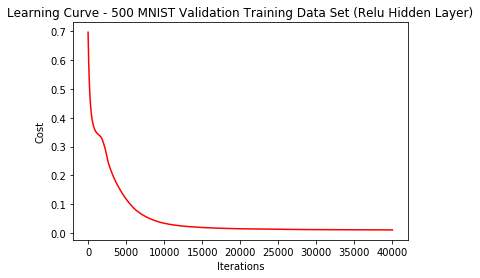

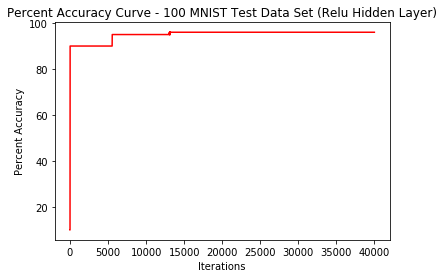

In [244]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01;
#7k - 95%
#20k - 96%
#30k - 96%
#40k - 96%
number_of_iterations = 40000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As shown, our validation set worked, so now we can move on to the full data set, and begin our evaluation and exploration. We reached descent results before 20,000 iterations, so we will will run 20,000 iterations on the rest of our networks.

First, we need to split up our full data set into testing and training data. We will use 50,000 images as the training data set and 10,000 images as the testing data set. 

In [6]:
# create a data set
size = vector_size

number_of_testing_images = 10000
number_of_training_images = 50000
number_of_validation_images = number_of_testing_images + number_of_training_images

training_images = []
training_labels = []
testing_images = []
testing_labels = []

factor = 0
for index in range(0, number_of_validation_images):
    if(index <= number_of_training_images - 1):
        training_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        training_labels.append(binary_labels[index + factor])
    else:
        testing_images.append(normalized_scaled_images_feature_matrix[:, index + factor])        
        testing_labels.append(binary_labels[index + factor])
        
# covert to numpy array
training_images = np.transpose(np.array(training_images))
training_labels = np.array(training_labels)
testing_images = np.transpose(np.array(testing_images))
testing_labels = np.array(testing_labels)

# logger
print(training_images.shape) # validation_training_images is a matrix of 784 X 500
print(training_labels.shape) # validation_testing_labels is a row vector of 1 X 500
print(testing_images.shape) # validation_training_images is a matrix of 784 X 100
print(testing_labels.shape)  # validation_testing_labels is a row vector of 1 X 100

(784, 50000)
(50000,)
(784, 10000)
(10000,)


Now we must reset out weights and bias's. We will start with 2 hidden layers, each with 5 unit. We will also start with a uniform distrubution between 0.01 and 0.001 for the initialization of our weights and bias's. 

In [250]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(3,)
(3,)


Now we re-run gradient descent on the full data set. We will run this for 20000 iterations and learning rate of 0.01. This should provide us with a descent convergence on our accuracy and cost, while not taking too long to complete.

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 334
Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373


Main Loop Iteration: 662
Main Loop Iteration: 663
Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701


Main Loop Iteration: 1305
Main Loop Iteration: 1306
Main Loop Iteration: 1307
Main Loop Iteration: 1308
Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop It

Main Loop Iteration: 1621
Main Loop Iteration: 1622
Main Loop Iteration: 1623
Main Loop Iteration: 1624
Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop It

Main Loop Iteration: 1937
Main Loop Iteration: 1938
Main Loop Iteration: 1939
Main Loop Iteration: 1940
Main Loop Iteration: 1941
Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop It

Main Loop Iteration: 2253
Main Loop Iteration: 2254
Main Loop Iteration: 2255
Main Loop Iteration: 2256
Main Loop Iteration: 2257
Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop It

Main Loop Iteration: 2569
Main Loop Iteration: 2570
Main Loop Iteration: 2571
Main Loop Iteration: 2572
Main Loop Iteration: 2573
Main Loop Iteration: 2574
Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop Iteration: 2606
Main Loop It

Main Loop Iteration: 2885
Main Loop Iteration: 2886
Main Loop Iteration: 2887
Main Loop Iteration: 2888
Main Loop Iteration: 2889
Main Loop Iteration: 2890
Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop Iteration: 2922
Main Loop It

Main Loop Iteration: 3201
Main Loop Iteration: 3202
Main Loop Iteration: 3203
Main Loop Iteration: 3204
Main Loop Iteration: 3205
Main Loop Iteration: 3206
Main Loop Iteration: 3207
Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop Iteration: 3238
Main Loop It

Main Loop Iteration: 3517
Main Loop Iteration: 3518
Main Loop Iteration: 3519
Main Loop Iteration: 3520
Main Loop Iteration: 3521
Main Loop Iteration: 3522
Main Loop Iteration: 3523
Main Loop Iteration: 3524
Main Loop Iteration: 3525
Main Loop Iteration: 3526
Main Loop Iteration: 3527
Main Loop Iteration: 3528
Main Loop Iteration: 3529
Main Loop Iteration: 3530
Main Loop Iteration: 3531
Main Loop Iteration: 3532
Main Loop Iteration: 3533
Main Loop Iteration: 3534
Main Loop Iteration: 3535
Main Loop Iteration: 3536
Main Loop Iteration: 3537
Main Loop Iteration: 3538
Main Loop Iteration: 3539
Main Loop Iteration: 3540
Main Loop Iteration: 3541
Main Loop Iteration: 3542
Main Loop Iteration: 3543
Main Loop Iteration: 3544
Main Loop Iteration: 3545
Main Loop Iteration: 3546
Main Loop Iteration: 3547
Main Loop Iteration: 3548
Main Loop Iteration: 3549
Main Loop Iteration: 3550
Main Loop Iteration: 3551
Main Loop Iteration: 3552
Main Loop Iteration: 3553
Main Loop Iteration: 3554
Main Loop It

Main Loop Iteration: 3833
Main Loop Iteration: 3834
Main Loop Iteration: 3835
Main Loop Iteration: 3836
Main Loop Iteration: 3837
Main Loop Iteration: 3838
Main Loop Iteration: 3839
Main Loop Iteration: 3840
Main Loop Iteration: 3841
Main Loop Iteration: 3842
Main Loop Iteration: 3843
Main Loop Iteration: 3844
Main Loop Iteration: 3845
Main Loop Iteration: 3846
Main Loop Iteration: 3847
Main Loop Iteration: 3848
Main Loop Iteration: 3849
Main Loop Iteration: 3850
Main Loop Iteration: 3851
Main Loop Iteration: 3852
Main Loop Iteration: 3853
Main Loop Iteration: 3854
Main Loop Iteration: 3855
Main Loop Iteration: 3856
Main Loop Iteration: 3857
Main Loop Iteration: 3858
Main Loop Iteration: 3859
Main Loop Iteration: 3860
Main Loop Iteration: 3861
Main Loop Iteration: 3862
Main Loop Iteration: 3863
Main Loop Iteration: 3864
Main Loop Iteration: 3865
Main Loop Iteration: 3866
Main Loop Iteration: 3867
Main Loop Iteration: 3868
Main Loop Iteration: 3869
Main Loop Iteration: 3870
Main Loop It

Main Loop Iteration: 4149
Main Loop Iteration: 4150
Main Loop Iteration: 4151
Main Loop Iteration: 4152
Main Loop Iteration: 4153
Main Loop Iteration: 4154
Main Loop Iteration: 4155
Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop Iteration: 4186
Main Loop It

Main Loop Iteration: 4465
Main Loop Iteration: 4466
Main Loop Iteration: 4467
Main Loop Iteration: 4468
Main Loop Iteration: 4469
Main Loop Iteration: 4470
Main Loop Iteration: 4471
Main Loop Iteration: 4472
Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop Iteration: 4502
Main Loop It

Main Loop Iteration: 4781
Main Loop Iteration: 4782
Main Loop Iteration: 4783
Main Loop Iteration: 4784
Main Loop Iteration: 4785
Main Loop Iteration: 4786
Main Loop Iteration: 4787
Main Loop Iteration: 4788
Main Loop Iteration: 4789
Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop Iteration: 4818
Main Loop It

Main Loop Iteration: 5097
Main Loop Iteration: 5098
Main Loop Iteration: 5099
Main Loop Iteration: 5100
Main Loop Iteration: 5101
Main Loop Iteration: 5102
Main Loop Iteration: 5103
Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop Iteration: 5134
Main Loop It

Main Loop Iteration: 5414
Main Loop Iteration: 5415
Main Loop Iteration: 5416
Main Loop Iteration: 5417
Main Loop Iteration: 5418
Main Loop Iteration: 5419
Main Loop Iteration: 5420
Main Loop Iteration: 5421
Main Loop Iteration: 5422
Main Loop Iteration: 5423
Main Loop Iteration: 5424
Main Loop Iteration: 5425
Main Loop Iteration: 5426
Main Loop Iteration: 5427
Main Loop Iteration: 5428
Main Loop Iteration: 5429
Main Loop Iteration: 5430
Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop Iteration: 5449
Main Loop Iteration: 5450
Main Loop Iteration: 5451
Main Loop It

Main Loop Iteration: 5731
Main Loop Iteration: 5732
Main Loop Iteration: 5733
Main Loop Iteration: 5734
Main Loop Iteration: 5735
Main Loop Iteration: 5736
Main Loop Iteration: 5737
Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop Iteration: 5767
Main Loop Iteration: 5768
Main Loop It

Main Loop Iteration: 6047
Main Loop Iteration: 6048
Main Loop Iteration: 6049
Main Loop Iteration: 6050
Main Loop Iteration: 6051
Main Loop Iteration: 6052
Main Loop Iteration: 6053
Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop Iteration: 6081
Main Loop Iteration: 6082
Main Loop Iteration: 6083
Main Loop Iteration: 6084
Main Loop It

Main Loop Iteration: 6364
Main Loop Iteration: 6365
Main Loop Iteration: 6366
Main Loop Iteration: 6367
Main Loop Iteration: 6368
Main Loop Iteration: 6369
Main Loop Iteration: 6370
Main Loop Iteration: 6371
Main Loop Iteration: 6372
Main Loop Iteration: 6373
Main Loop Iteration: 6374
Main Loop Iteration: 6375
Main Loop Iteration: 6376
Main Loop Iteration: 6377
Main Loop Iteration: 6378
Main Loop Iteration: 6379
Main Loop Iteration: 6380
Main Loop Iteration: 6381
Main Loop Iteration: 6382
Main Loop Iteration: 6383
Main Loop Iteration: 6384
Main Loop Iteration: 6385
Main Loop Iteration: 6386
Main Loop Iteration: 6387
Main Loop Iteration: 6388
Main Loop Iteration: 6389
Main Loop Iteration: 6390
Main Loop Iteration: 6391
Main Loop Iteration: 6392
Main Loop Iteration: 6393
Main Loop Iteration: 6394
Main Loop Iteration: 6395
Main Loop Iteration: 6396
Main Loop Iteration: 6397
Main Loop Iteration: 6398
Main Loop Iteration: 6399
Main Loop Iteration: 6400
Main Loop Iteration: 6401
Main Loop It

Main Loop Iteration: 6681
Main Loop Iteration: 6682
Main Loop Iteration: 6683
Main Loop Iteration: 6684
Main Loop Iteration: 6685
Main Loop Iteration: 6686
Main Loop Iteration: 6687
Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop Iteration: 6713
Main Loop Iteration: 6714
Main Loop Iteration: 6715
Main Loop Iteration: 6716
Main Loop Iteration: 6717
Main Loop Iteration: 6718
Main Loop It

Main Loop Iteration: 6998
Main Loop Iteration: 6999
Main Loop Iteration: 7000
Main Loop Iteration: 7001
Main Loop Iteration: 7002
Main Loop Iteration: 7003
Main Loop Iteration: 7004
Main Loop Iteration: 7005
Main Loop Iteration: 7006
Main Loop Iteration: 7007
Main Loop Iteration: 7008
Main Loop Iteration: 7009
Main Loop Iteration: 7010
Main Loop Iteration: 7011
Main Loop Iteration: 7012
Main Loop Iteration: 7013
Main Loop Iteration: 7014
Main Loop Iteration: 7015
Main Loop Iteration: 7016
Main Loop Iteration: 7017
Main Loop Iteration: 7018
Main Loop Iteration: 7019
Main Loop Iteration: 7020
Main Loop Iteration: 7021
Main Loop Iteration: 7022
Main Loop Iteration: 7023
Main Loop Iteration: 7024
Main Loop Iteration: 7025
Main Loop Iteration: 7026
Main Loop Iteration: 7027
Main Loop Iteration: 7028
Main Loop Iteration: 7029
Main Loop Iteration: 7030
Main Loop Iteration: 7031
Main Loop Iteration: 7032
Main Loop Iteration: 7033
Main Loop Iteration: 7034
Main Loop Iteration: 7035
Main Loop It

Main Loop Iteration: 7315
Main Loop Iteration: 7316
Main Loop Iteration: 7317
Main Loop Iteration: 7318
Main Loop Iteration: 7319
Main Loop Iteration: 7320
Main Loop Iteration: 7321
Main Loop Iteration: 7322
Main Loop Iteration: 7323
Main Loop Iteration: 7324
Main Loop Iteration: 7325
Main Loop Iteration: 7326
Main Loop Iteration: 7327
Main Loop Iteration: 7328
Main Loop Iteration: 7329
Main Loop Iteration: 7330
Main Loop Iteration: 7331
Main Loop Iteration: 7332
Main Loop Iteration: 7333
Main Loop Iteration: 7334
Main Loop Iteration: 7335
Main Loop Iteration: 7336
Main Loop Iteration: 7337
Main Loop Iteration: 7338
Main Loop Iteration: 7339
Main Loop Iteration: 7340
Main Loop Iteration: 7341
Main Loop Iteration: 7342
Main Loop Iteration: 7343
Main Loop Iteration: 7344
Main Loop Iteration: 7345
Main Loop Iteration: 7346
Main Loop Iteration: 7347
Main Loop Iteration: 7348
Main Loop Iteration: 7349
Main Loop Iteration: 7350
Main Loop Iteration: 7351
Main Loop Iteration: 7352
Main Loop It

Main Loop Iteration: 7632
Main Loop Iteration: 7633
Main Loop Iteration: 7634
Main Loop Iteration: 7635
Main Loop Iteration: 7636
Main Loop Iteration: 7637
Main Loop Iteration: 7638
Main Loop Iteration: 7639
Main Loop Iteration: 7640
Main Loop Iteration: 7641
Main Loop Iteration: 7642
Main Loop Iteration: 7643
Main Loop Iteration: 7644
Main Loop Iteration: 7645
Main Loop Iteration: 7646
Main Loop Iteration: 7647
Main Loop Iteration: 7648
Main Loop Iteration: 7649
Main Loop Iteration: 7650
Main Loop Iteration: 7651
Main Loop Iteration: 7652
Main Loop Iteration: 7653
Main Loop Iteration: 7654
Main Loop Iteration: 7655
Main Loop Iteration: 7656
Main Loop Iteration: 7657
Main Loop Iteration: 7658
Main Loop Iteration: 7659
Main Loop Iteration: 7660
Main Loop Iteration: 7661
Main Loop Iteration: 7662
Main Loop Iteration: 7663
Main Loop Iteration: 7664
Main Loop Iteration: 7665
Main Loop Iteration: 7666
Main Loop Iteration: 7667
Main Loop Iteration: 7668
Main Loop Iteration: 7669
Main Loop It

Main Loop Iteration: 7949
Main Loop Iteration: 7950
Main Loop Iteration: 7951
Main Loop Iteration: 7952
Main Loop Iteration: 7953
Main Loop Iteration: 7954
Main Loop Iteration: 7955
Main Loop Iteration: 7956
Main Loop Iteration: 7957
Main Loop Iteration: 7958
Main Loop Iteration: 7959
Main Loop Iteration: 7960
Main Loop Iteration: 7961
Main Loop Iteration: 7962
Main Loop Iteration: 7963
Main Loop Iteration: 7964
Main Loop Iteration: 7965
Main Loop Iteration: 7966
Main Loop Iteration: 7967
Main Loop Iteration: 7968
Main Loop Iteration: 7969
Main Loop Iteration: 7970
Main Loop Iteration: 7971
Main Loop Iteration: 7972
Main Loop Iteration: 7973
Main Loop Iteration: 7974
Main Loop Iteration: 7975
Main Loop Iteration: 7976
Main Loop Iteration: 7977
Main Loop Iteration: 7978
Main Loop Iteration: 7979
Main Loop Iteration: 7980
Main Loop Iteration: 7981
Main Loop Iteration: 7982
Main Loop Iteration: 7983
Main Loop Iteration: 7984
Main Loop Iteration: 7985
Main Loop Iteration: 7986
Main Loop It

Main Loop Iteration: 8266
Main Loop Iteration: 8267
Main Loop Iteration: 8268
Main Loop Iteration: 8269
Main Loop Iteration: 8270
Main Loop Iteration: 8271
Main Loop Iteration: 8272
Main Loop Iteration: 8273
Main Loop Iteration: 8274
Main Loop Iteration: 8275
Main Loop Iteration: 8276
Main Loop Iteration: 8277
Main Loop Iteration: 8278
Main Loop Iteration: 8279
Main Loop Iteration: 8280
Main Loop Iteration: 8281
Main Loop Iteration: 8282
Main Loop Iteration: 8283
Main Loop Iteration: 8284
Main Loop Iteration: 8285
Main Loop Iteration: 8286
Main Loop Iteration: 8287
Main Loop Iteration: 8288
Main Loop Iteration: 8289
Main Loop Iteration: 8290
Main Loop Iteration: 8291
Main Loop Iteration: 8292
Main Loop Iteration: 8293
Main Loop Iteration: 8294
Main Loop Iteration: 8295
Main Loop Iteration: 8296
Main Loop Iteration: 8297
Main Loop Iteration: 8298
Main Loop Iteration: 8299
Main Loop Iteration: 8300
Main Loop Iteration: 8301
Main Loop Iteration: 8302
Main Loop Iteration: 8303
Main Loop It

Main Loop Iteration: 8582
Main Loop Iteration: 8583
Main Loop Iteration: 8584
Main Loop Iteration: 8585
Main Loop Iteration: 8586
Main Loop Iteration: 8587
Main Loop Iteration: 8588
Main Loop Iteration: 8589
Main Loop Iteration: 8590
Main Loop Iteration: 8591
Main Loop Iteration: 8592
Main Loop Iteration: 8593
Main Loop Iteration: 8594
Main Loop Iteration: 8595
Main Loop Iteration: 8596
Main Loop Iteration: 8597
Main Loop Iteration: 8598
Main Loop Iteration: 8599
Main Loop Iteration: 8600
Main Loop Iteration: 8601
Main Loop Iteration: 8602
Main Loop Iteration: 8603
Main Loop Iteration: 8604
Main Loop Iteration: 8605
Main Loop Iteration: 8606
Main Loop Iteration: 8607
Main Loop Iteration: 8608
Main Loop Iteration: 8609
Main Loop Iteration: 8610
Main Loop Iteration: 8611
Main Loop Iteration: 8612
Main Loop Iteration: 8613
Main Loop Iteration: 8614
Main Loop Iteration: 8615
Main Loop Iteration: 8616
Main Loop Iteration: 8617
Main Loop Iteration: 8618
Main Loop Iteration: 8619
Main Loop It

Main Loop Iteration: 8899
Main Loop Iteration: 8900
Main Loop Iteration: 8901
Main Loop Iteration: 8902
Main Loop Iteration: 8903
Main Loop Iteration: 8904
Main Loop Iteration: 8905
Main Loop Iteration: 8906
Main Loop Iteration: 8907
Main Loop Iteration: 8908
Main Loop Iteration: 8909
Main Loop Iteration: 8910
Main Loop Iteration: 8911
Main Loop Iteration: 8912
Main Loop Iteration: 8913
Main Loop Iteration: 8914
Main Loop Iteration: 8915
Main Loop Iteration: 8916
Main Loop Iteration: 8917
Main Loop Iteration: 8918
Main Loop Iteration: 8919
Main Loop Iteration: 8920
Main Loop Iteration: 8921
Main Loop Iteration: 8922
Main Loop Iteration: 8923
Main Loop Iteration: 8924
Main Loop Iteration: 8925
Main Loop Iteration: 8926
Main Loop Iteration: 8927
Main Loop Iteration: 8928
Main Loop Iteration: 8929
Main Loop Iteration: 8930
Main Loop Iteration: 8931
Main Loop Iteration: 8932
Main Loop Iteration: 8933
Main Loop Iteration: 8934
Main Loop Iteration: 8935
Main Loop Iteration: 8936
Main Loop It

Main Loop Iteration: 9215
Main Loop Iteration: 9216
Main Loop Iteration: 9217
Main Loop Iteration: 9218
Main Loop Iteration: 9219
Main Loop Iteration: 9220
Main Loop Iteration: 9221
Main Loop Iteration: 9222
Main Loop Iteration: 9223
Main Loop Iteration: 9224
Main Loop Iteration: 9225
Main Loop Iteration: 9226
Main Loop Iteration: 9227
Main Loop Iteration: 9228
Main Loop Iteration: 9229
Main Loop Iteration: 9230
Main Loop Iteration: 9231
Main Loop Iteration: 9232
Main Loop Iteration: 9233
Main Loop Iteration: 9234
Main Loop Iteration: 9235
Main Loop Iteration: 9236
Main Loop Iteration: 9237
Main Loop Iteration: 9238
Main Loop Iteration: 9239
Main Loop Iteration: 9240
Main Loop Iteration: 9241
Main Loop Iteration: 9242
Main Loop Iteration: 9243
Main Loop Iteration: 9244
Main Loop Iteration: 9245
Main Loop Iteration: 9246
Main Loop Iteration: 9247
Main Loop Iteration: 9248
Main Loop Iteration: 9249
Main Loop Iteration: 9250
Main Loop Iteration: 9251
Main Loop Iteration: 9252
Main Loop It

Main Loop Iteration: 9531
Main Loop Iteration: 9532
Main Loop Iteration: 9533
Main Loop Iteration: 9534
Main Loop Iteration: 9535
Main Loop Iteration: 9536
Main Loop Iteration: 9537
Main Loop Iteration: 9538
Main Loop Iteration: 9539
Main Loop Iteration: 9540
Main Loop Iteration: 9541
Main Loop Iteration: 9542
Main Loop Iteration: 9543
Main Loop Iteration: 9544
Main Loop Iteration: 9545
Main Loop Iteration: 9546
Main Loop Iteration: 9547
Main Loop Iteration: 9548
Main Loop Iteration: 9549
Main Loop Iteration: 9550
Main Loop Iteration: 9551
Main Loop Iteration: 9552
Main Loop Iteration: 9553
Main Loop Iteration: 9554
Main Loop Iteration: 9555
Main Loop Iteration: 9556
Main Loop Iteration: 9557
Main Loop Iteration: 9558
Main Loop Iteration: 9559
Main Loop Iteration: 9560
Main Loop Iteration: 9561
Main Loop Iteration: 9562
Main Loop Iteration: 9563
Main Loop Iteration: 9564
Main Loop Iteration: 9565
Main Loop Iteration: 9566
Main Loop Iteration: 9567
Main Loop Iteration: 9568
Main Loop It

Main Loop Iteration: 9848
Main Loop Iteration: 9849
Main Loop Iteration: 9850
Main Loop Iteration: 9851
Main Loop Iteration: 9852
Main Loop Iteration: 9853
Main Loop Iteration: 9854
Main Loop Iteration: 9855
Main Loop Iteration: 9856
Main Loop Iteration: 9857
Main Loop Iteration: 9858
Main Loop Iteration: 9859
Main Loop Iteration: 9860
Main Loop Iteration: 9861
Main Loop Iteration: 9862
Main Loop Iteration: 9863
Main Loop Iteration: 9864
Main Loop Iteration: 9865
Main Loop Iteration: 9866
Main Loop Iteration: 9867
Main Loop Iteration: 9868
Main Loop Iteration: 9869
Main Loop Iteration: 9870
Main Loop Iteration: 9871
Main Loop Iteration: 9872
Main Loop Iteration: 9873
Main Loop Iteration: 9874
Main Loop Iteration: 9875
Main Loop Iteration: 9876
Main Loop Iteration: 9877
Main Loop Iteration: 9878
Main Loop Iteration: 9879
Main Loop Iteration: 9880
Main Loop Iteration: 9881
Main Loop Iteration: 9882
Main Loop Iteration: 9883
Main Loop Iteration: 9884
Main Loop Iteration: 9885
Main Loop It

Main Loop Iteration: 10159
Main Loop Iteration: 10160
Main Loop Iteration: 10161
Main Loop Iteration: 10162
Main Loop Iteration: 10163
Main Loop Iteration: 10164
Main Loop Iteration: 10165
Main Loop Iteration: 10166
Main Loop Iteration: 10167
Main Loop Iteration: 10168
Main Loop Iteration: 10169
Main Loop Iteration: 10170
Main Loop Iteration: 10171
Main Loop Iteration: 10172
Main Loop Iteration: 10173
Main Loop Iteration: 10174
Main Loop Iteration: 10175
Main Loop Iteration: 10176
Main Loop Iteration: 10177
Main Loop Iteration: 10178
Main Loop Iteration: 10179
Main Loop Iteration: 10180
Main Loop Iteration: 10181
Main Loop Iteration: 10182
Main Loop Iteration: 10183
Main Loop Iteration: 10184
Main Loop Iteration: 10185
Main Loop Iteration: 10186
Main Loop Iteration: 10187
Main Loop Iteration: 10188
Main Loop Iteration: 10189
Main Loop Iteration: 10190
Main Loop Iteration: 10191
Main Loop Iteration: 10192
Main Loop Iteration: 10193
Main Loop Iteration: 10194
Main Loop Iteration: 10195
M

Main Loop Iteration: 10766
Main Loop Iteration: 10767
Main Loop Iteration: 10768
Main Loop Iteration: 10769
Main Loop Iteration: 10770
Main Loop Iteration: 10771
Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
Main Loop Iteration: 10781
Main Loop Iteration: 10782
Main Loop Iteration: 10783
Main Loop Iteration: 10784
Main Loop Iteration: 10785
Main Loop Iteration: 10786
Main Loop Iteration: 10787
Main Loop Iteration: 10788
Main Loop Iteration: 10789
Main Loop Iteration: 10790
Main Loop Iteration: 10791
Main Loop Iteration: 10792
Main Loop Iteration: 10793
Main Loop Iteration: 10794
Main Loop Iteration: 10795
Main Loop Iteration: 10796
Main Loop Iteration: 10797
Main Loop Iteration: 10798
Main Loop Iteration: 10799
Main Loop Iteration: 10800
Main Loop Iteration: 10801
Main Loop Iteration: 10802
M

Main Loop Iteration: 11070
Main Loop Iteration: 11071
Main Loop Iteration: 11072
Main Loop Iteration: 11073
Main Loop Iteration: 11074
Main Loop Iteration: 11075
Main Loop Iteration: 11076
Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
Main Loop Iteration: 11090
Main Loop Iteration: 11091
Main Loop Iteration: 11092
Main Loop Iteration: 11093
Main Loop Iteration: 11094
Main Loop Iteration: 11095
Main Loop Iteration: 11096
Main Loop Iteration: 11097
Main Loop Iteration: 11098
Main Loop Iteration: 11099
Main Loop Iteration: 11100
Main Loop Iteration: 11101
Main Loop Iteration: 11102
Main Loop Iteration: 11103
Main Loop Iteration: 11104
Main Loop Iteration: 11105
Main Loop Iteration: 11106
M

Main Loop Iteration: 11374
Main Loop Iteration: 11375
Main Loop Iteration: 11376
Main Loop Iteration: 11377
Main Loop Iteration: 11378
Main Loop Iteration: 11379
Main Loop Iteration: 11380
Main Loop Iteration: 11381
Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
Main Loop Iteration: 11395
Main Loop Iteration: 11396
Main Loop Iteration: 11397
Main Loop Iteration: 11398
Main Loop Iteration: 11399
Main Loop Iteration: 11400
Main Loop Iteration: 11401
Main Loop Iteration: 11402
Main Loop Iteration: 11403
Main Loop Iteration: 11404
Main Loop Iteration: 11405
Main Loop Iteration: 11406
Main Loop Iteration: 11407
Main Loop Iteration: 11408
Main Loop Iteration: 11409
Main Loop Iteration: 11410
M

Main Loop Iteration: 11679
Main Loop Iteration: 11680
Main Loop Iteration: 11681
Main Loop Iteration: 11682
Main Loop Iteration: 11683
Main Loop Iteration: 11684
Main Loop Iteration: 11685
Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
Main Loop Iteration: 11698
Main Loop Iteration: 11699
Main Loop Iteration: 11700
Main Loop Iteration: 11701
Main Loop Iteration: 11702
Main Loop Iteration: 11703
Main Loop Iteration: 11704
Main Loop Iteration: 11705
Main Loop Iteration: 11706
Main Loop Iteration: 11707
Main Loop Iteration: 11708
Main Loop Iteration: 11709
Main Loop Iteration: 11710
Main Loop Iteration: 11711
Main Loop Iteration: 11712
Main Loop Iteration: 11713
Main Loop Iteration: 11714
Main Loop Iteration: 11715
M

Main Loop Iteration: 11984
Main Loop Iteration: 11985
Main Loop Iteration: 11986
Main Loop Iteration: 11987
Main Loop Iteration: 11988
Main Loop Iteration: 11989
Main Loop Iteration: 11990
Main Loop Iteration: 11991
Main Loop Iteration: 11992
Main Loop Iteration: 11993
Main Loop Iteration: 11994
Main Loop Iteration: 11995
Main Loop Iteration: 11996
Main Loop Iteration: 11997
Main Loop Iteration: 11998
Main Loop Iteration: 11999
Main Loop Iteration: 12000
Main Loop Iteration: 12001
Main Loop Iteration: 12002
Main Loop Iteration: 12003
Main Loop Iteration: 12004
Main Loop Iteration: 12005
Main Loop Iteration: 12006
Main Loop Iteration: 12007
Main Loop Iteration: 12008
Main Loop Iteration: 12009
Main Loop Iteration: 12010
Main Loop Iteration: 12011
Main Loop Iteration: 12012
Main Loop Iteration: 12013
Main Loop Iteration: 12014
Main Loop Iteration: 12015
Main Loop Iteration: 12016
Main Loop Iteration: 12017
Main Loop Iteration: 12018
Main Loop Iteration: 12019
Main Loop Iteration: 12020
M

Main Loop Iteration: 12289
Main Loop Iteration: 12290
Main Loop Iteration: 12291
Main Loop Iteration: 12292
Main Loop Iteration: 12293
Main Loop Iteration: 12294
Main Loop Iteration: 12295
Main Loop Iteration: 12296
Main Loop Iteration: 12297
Main Loop Iteration: 12298
Main Loop Iteration: 12299
Main Loop Iteration: 12300
Main Loop Iteration: 12301
Main Loop Iteration: 12302
Main Loop Iteration: 12303
Main Loop Iteration: 12304
Main Loop Iteration: 12305
Main Loop Iteration: 12306
Main Loop Iteration: 12307
Main Loop Iteration: 12308
Main Loop Iteration: 12309
Main Loop Iteration: 12310
Main Loop Iteration: 12311
Main Loop Iteration: 12312
Main Loop Iteration: 12313
Main Loop Iteration: 12314
Main Loop Iteration: 12315
Main Loop Iteration: 12316
Main Loop Iteration: 12317
Main Loop Iteration: 12318
Main Loop Iteration: 12319
Main Loop Iteration: 12320
Main Loop Iteration: 12321
Main Loop Iteration: 12322
Main Loop Iteration: 12323
Main Loop Iteration: 12324
Main Loop Iteration: 12325
M

Main Loop Iteration: 12593
Main Loop Iteration: 12594
Main Loop Iteration: 12595
Main Loop Iteration: 12596
Main Loop Iteration: 12597
Main Loop Iteration: 12598
Main Loop Iteration: 12599
Main Loop Iteration: 12600
Main Loop Iteration: 12601
Main Loop Iteration: 12602
Main Loop Iteration: 12603
Main Loop Iteration: 12604
Main Loop Iteration: 12605
Main Loop Iteration: 12606
Main Loop Iteration: 12607
Main Loop Iteration: 12608
Main Loop Iteration: 12609
Main Loop Iteration: 12610
Main Loop Iteration: 12611
Main Loop Iteration: 12612
Main Loop Iteration: 12613
Main Loop Iteration: 12614
Main Loop Iteration: 12615
Main Loop Iteration: 12616
Main Loop Iteration: 12617
Main Loop Iteration: 12618
Main Loop Iteration: 12619
Main Loop Iteration: 12620
Main Loop Iteration: 12621
Main Loop Iteration: 12622
Main Loop Iteration: 12623
Main Loop Iteration: 12624
Main Loop Iteration: 12625
Main Loop Iteration: 12626
Main Loop Iteration: 12627
Main Loop Iteration: 12628
Main Loop Iteration: 12629
M

Main Loop Iteration: 12897
Main Loop Iteration: 12898
Main Loop Iteration: 12899
Main Loop Iteration: 12900
Main Loop Iteration: 12901
Main Loop Iteration: 12902
Main Loop Iteration: 12903
Main Loop Iteration: 12904
Main Loop Iteration: 12905
Main Loop Iteration: 12906
Main Loop Iteration: 12907
Main Loop Iteration: 12908
Main Loop Iteration: 12909
Main Loop Iteration: 12910
Main Loop Iteration: 12911
Main Loop Iteration: 12912
Main Loop Iteration: 12913
Main Loop Iteration: 12914
Main Loop Iteration: 12915
Main Loop Iteration: 12916
Main Loop Iteration: 12917
Main Loop Iteration: 12918
Main Loop Iteration: 12919
Main Loop Iteration: 12920
Main Loop Iteration: 12921
Main Loop Iteration: 12922
Main Loop Iteration: 12923
Main Loop Iteration: 12924
Main Loop Iteration: 12925
Main Loop Iteration: 12926
Main Loop Iteration: 12927
Main Loop Iteration: 12928
Main Loop Iteration: 12929
Main Loop Iteration: 12930
Main Loop Iteration: 12931
Main Loop Iteration: 12932
Main Loop Iteration: 12933
M

Main Loop Iteration: 13201
Main Loop Iteration: 13202
Main Loop Iteration: 13203
Main Loop Iteration: 13204
Main Loop Iteration: 13205
Main Loop Iteration: 13206
Main Loop Iteration: 13207
Main Loop Iteration: 13208
Main Loop Iteration: 13209
Main Loop Iteration: 13210
Main Loop Iteration: 13211
Main Loop Iteration: 13212
Main Loop Iteration: 13213
Main Loop Iteration: 13214
Main Loop Iteration: 13215
Main Loop Iteration: 13216
Main Loop Iteration: 13217
Main Loop Iteration: 13218
Main Loop Iteration: 13219
Main Loop Iteration: 13220
Main Loop Iteration: 13221
Main Loop Iteration: 13222
Main Loop Iteration: 13223
Main Loop Iteration: 13224
Main Loop Iteration: 13225
Main Loop Iteration: 13226
Main Loop Iteration: 13227
Main Loop Iteration: 13228
Main Loop Iteration: 13229
Main Loop Iteration: 13230
Main Loop Iteration: 13231
Main Loop Iteration: 13232
Main Loop Iteration: 13233
Main Loop Iteration: 13234
Main Loop Iteration: 13235
Main Loop Iteration: 13236
Main Loop Iteration: 13237
M

Main Loop Iteration: 13505
Main Loop Iteration: 13506
Main Loop Iteration: 13507
Main Loop Iteration: 13508
Main Loop Iteration: 13509
Main Loop Iteration: 13510
Main Loop Iteration: 13511
Main Loop Iteration: 13512
Main Loop Iteration: 13513
Main Loop Iteration: 13514
Main Loop Iteration: 13515
Main Loop Iteration: 13516
Main Loop Iteration: 13517
Main Loop Iteration: 13518
Main Loop Iteration: 13519
Main Loop Iteration: 13520
Main Loop Iteration: 13521
Main Loop Iteration: 13522
Main Loop Iteration: 13523
Main Loop Iteration: 13524
Main Loop Iteration: 13525
Main Loop Iteration: 13526
Main Loop Iteration: 13527
Main Loop Iteration: 13528
Main Loop Iteration: 13529
Main Loop Iteration: 13530
Main Loop Iteration: 13531
Main Loop Iteration: 13532
Main Loop Iteration: 13533
Main Loop Iteration: 13534
Main Loop Iteration: 13535
Main Loop Iteration: 13536
Main Loop Iteration: 13537
Main Loop Iteration: 13538
Main Loop Iteration: 13539
Main Loop Iteration: 13540
Main Loop Iteration: 13541
M

Main Loop Iteration: 13809
Main Loop Iteration: 13810
Main Loop Iteration: 13811
Main Loop Iteration: 13812
Main Loop Iteration: 13813
Main Loop Iteration: 13814
Main Loop Iteration: 13815
Main Loop Iteration: 13816
Main Loop Iteration: 13817
Main Loop Iteration: 13818
Main Loop Iteration: 13819
Main Loop Iteration: 13820
Main Loop Iteration: 13821
Main Loop Iteration: 13822
Main Loop Iteration: 13823
Main Loop Iteration: 13824
Main Loop Iteration: 13825
Main Loop Iteration: 13826
Main Loop Iteration: 13827
Main Loop Iteration: 13828
Main Loop Iteration: 13829
Main Loop Iteration: 13830
Main Loop Iteration: 13831
Main Loop Iteration: 13832
Main Loop Iteration: 13833
Main Loop Iteration: 13834
Main Loop Iteration: 13835
Main Loop Iteration: 13836
Main Loop Iteration: 13837
Main Loop Iteration: 13838
Main Loop Iteration: 13839
Main Loop Iteration: 13840
Main Loop Iteration: 13841
Main Loop Iteration: 13842
Main Loop Iteration: 13843
Main Loop Iteration: 13844
Main Loop Iteration: 13845
M

Main Loop Iteration: 14417
Main Loop Iteration: 14418
Main Loop Iteration: 14419
Main Loop Iteration: 14420
Main Loop Iteration: 14421
Main Loop Iteration: 14422
Main Loop Iteration: 14423
Main Loop Iteration: 14424
Main Loop Iteration: 14425
Main Loop Iteration: 14426
Main Loop Iteration: 14427
Main Loop Iteration: 14428
Main Loop Iteration: 14429
Main Loop Iteration: 14430
Main Loop Iteration: 14431
Main Loop Iteration: 14432
Main Loop Iteration: 14433
Main Loop Iteration: 14434
Main Loop Iteration: 14435
Main Loop Iteration: 14436
Main Loop Iteration: 14437
Main Loop Iteration: 14438
Main Loop Iteration: 14439
Main Loop Iteration: 14440
Main Loop Iteration: 14441
Main Loop Iteration: 14442
Main Loop Iteration: 14443
Main Loop Iteration: 14444
Main Loop Iteration: 14445
Main Loop Iteration: 14446
Main Loop Iteration: 14447
Main Loop Iteration: 14448
Main Loop Iteration: 14449
Main Loop Iteration: 14450
Main Loop Iteration: 14451
Main Loop Iteration: 14452
Main Loop Iteration: 14453
M

Main Loop Iteration: 14721
Main Loop Iteration: 14722
Main Loop Iteration: 14723
Main Loop Iteration: 14724
Main Loop Iteration: 14725
Main Loop Iteration: 14726
Main Loop Iteration: 14727
Main Loop Iteration: 14728
Main Loop Iteration: 14729
Main Loop Iteration: 14730
Main Loop Iteration: 14731
Main Loop Iteration: 14732
Main Loop Iteration: 14733
Main Loop Iteration: 14734
Main Loop Iteration: 14735
Main Loop Iteration: 14736
Main Loop Iteration: 14737
Main Loop Iteration: 14738
Main Loop Iteration: 14739
Main Loop Iteration: 14740
Main Loop Iteration: 14741
Main Loop Iteration: 14742
Main Loop Iteration: 14743
Main Loop Iteration: 14744
Main Loop Iteration: 14745
Main Loop Iteration: 14746
Main Loop Iteration: 14747
Main Loop Iteration: 14748
Main Loop Iteration: 14749
Main Loop Iteration: 14750
Main Loop Iteration: 14751
Main Loop Iteration: 14752
Main Loop Iteration: 14753
Main Loop Iteration: 14754
Main Loop Iteration: 14755
Main Loop Iteration: 14756
Main Loop Iteration: 14757
M

Main Loop Iteration: 15025
Main Loop Iteration: 15026
Main Loop Iteration: 15027
Main Loop Iteration: 15028
Main Loop Iteration: 15029
Main Loop Iteration: 15030
Main Loop Iteration: 15031
Main Loop Iteration: 15032
Main Loop Iteration: 15033
Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
Main Loop Iteration: 15041
Main Loop Iteration: 15042
Main Loop Iteration: 15043
Main Loop Iteration: 15044
Main Loop Iteration: 15045
Main Loop Iteration: 15046
Main Loop Iteration: 15047
Main Loop Iteration: 15048
Main Loop Iteration: 15049
Main Loop Iteration: 15050
Main Loop Iteration: 15051
Main Loop Iteration: 15052
Main Loop Iteration: 15053
Main Loop Iteration: 15054
Main Loop Iteration: 15055
Main Loop Iteration: 15056
Main Loop Iteration: 15057
Main Loop Iteration: 15058
Main Loop Iteration: 15059
Main Loop Iteration: 15060
Main Loop Iteration: 15061
M

Main Loop Iteration: 15632
Main Loop Iteration: 15633
Main Loop Iteration: 15634
Main Loop Iteration: 15635
Main Loop Iteration: 15636
Main Loop Iteration: 15637
Main Loop Iteration: 15638
Main Loop Iteration: 15639
Main Loop Iteration: 15640
Main Loop Iteration: 15641
Main Loop Iteration: 15642
Main Loop Iteration: 15643
Main Loop Iteration: 15644
Main Loop Iteration: 15645
Main Loop Iteration: 15646
Main Loop Iteration: 15647
Main Loop Iteration: 15648
Main Loop Iteration: 15649
Main Loop Iteration: 15650
Main Loop Iteration: 15651
Main Loop Iteration: 15652
Main Loop Iteration: 15653
Main Loop Iteration: 15654
Main Loop Iteration: 15655
Main Loop Iteration: 15656
Main Loop Iteration: 15657
Main Loop Iteration: 15658
Main Loop Iteration: 15659
Main Loop Iteration: 15660
Main Loop Iteration: 15661
Main Loop Iteration: 15662
Main Loop Iteration: 15663
Main Loop Iteration: 15664
Main Loop Iteration: 15665
Main Loop Iteration: 15666
Main Loop Iteration: 15667
Main Loop Iteration: 15668
M

Main Loop Iteration: 15936
Main Loop Iteration: 15937
Main Loop Iteration: 15938
Main Loop Iteration: 15939
Main Loop Iteration: 15940
Main Loop Iteration: 15941
Main Loop Iteration: 15942
Main Loop Iteration: 15943
Main Loop Iteration: 15944
Main Loop Iteration: 15945
Main Loop Iteration: 15946
Main Loop Iteration: 15947
Main Loop Iteration: 15948
Main Loop Iteration: 15949
Main Loop Iteration: 15950
Main Loop Iteration: 15951
Main Loop Iteration: 15952
Main Loop Iteration: 15953
Main Loop Iteration: 15954
Main Loop Iteration: 15955
Main Loop Iteration: 15956
Main Loop Iteration: 15957
Main Loop Iteration: 15958
Main Loop Iteration: 15959
Main Loop Iteration: 15960
Main Loop Iteration: 15961
Main Loop Iteration: 15962
Main Loop Iteration: 15963
Main Loop Iteration: 15964
Main Loop Iteration: 15965
Main Loop Iteration: 15966
Main Loop Iteration: 15967
Main Loop Iteration: 15968
Main Loop Iteration: 15969
Main Loop Iteration: 15970
Main Loop Iteration: 15971
Main Loop Iteration: 15972
M

Main Loop Iteration: 16241
Main Loop Iteration: 16242
Main Loop Iteration: 16243
Main Loop Iteration: 16244
Main Loop Iteration: 16245
Main Loop Iteration: 16246
Main Loop Iteration: 16247
Main Loop Iteration: 16248
Main Loop Iteration: 16249
Main Loop Iteration: 16250
Main Loop Iteration: 16251
Main Loop Iteration: 16252
Main Loop Iteration: 16253
Main Loop Iteration: 16254
Main Loop Iteration: 16255
Main Loop Iteration: 16256
Main Loop Iteration: 16257
Main Loop Iteration: 16258
Main Loop Iteration: 16259
Main Loop Iteration: 16260
Main Loop Iteration: 16261
Main Loop Iteration: 16262
Main Loop Iteration: 16263
Main Loop Iteration: 16264
Main Loop Iteration: 16265
Main Loop Iteration: 16266
Main Loop Iteration: 16267
Main Loop Iteration: 16268
Main Loop Iteration: 16269
Main Loop Iteration: 16270
Main Loop Iteration: 16271
Main Loop Iteration: 16272
Main Loop Iteration: 16273
Main Loop Iteration: 16274
Main Loop Iteration: 16275
Main Loop Iteration: 16276
Main Loop Iteration: 16277
M

Main Loop Iteration: 16849
Main Loop Iteration: 16850
Main Loop Iteration: 16851
Main Loop Iteration: 16852
Main Loop Iteration: 16853
Main Loop Iteration: 16854
Main Loop Iteration: 16855
Main Loop Iteration: 16856
Main Loop Iteration: 16857
Main Loop Iteration: 16858
Main Loop Iteration: 16859
Main Loop Iteration: 16860
Main Loop Iteration: 16861
Main Loop Iteration: 16862
Main Loop Iteration: 16863
Main Loop Iteration: 16864
Main Loop Iteration: 16865
Main Loop Iteration: 16866
Main Loop Iteration: 16867
Main Loop Iteration: 16868
Main Loop Iteration: 16869
Main Loop Iteration: 16870
Main Loop Iteration: 16871
Main Loop Iteration: 16872
Main Loop Iteration: 16873
Main Loop Iteration: 16874
Main Loop Iteration: 16875
Main Loop Iteration: 16876
Main Loop Iteration: 16877
Main Loop Iteration: 16878
Main Loop Iteration: 16879
Main Loop Iteration: 16880
Main Loop Iteration: 16881
Main Loop Iteration: 16882
Main Loop Iteration: 16883
Main Loop Iteration: 16884
Main Loop Iteration: 16885
M

Main Loop Iteration: 17153
Main Loop Iteration: 17154
Main Loop Iteration: 17155
Main Loop Iteration: 17156
Main Loop Iteration: 17157
Main Loop Iteration: 17158
Main Loop Iteration: 17159
Main Loop Iteration: 17160
Main Loop Iteration: 17161
Main Loop Iteration: 17162
Main Loop Iteration: 17163
Main Loop Iteration: 17164
Main Loop Iteration: 17165
Main Loop Iteration: 17166
Main Loop Iteration: 17167
Main Loop Iteration: 17168
Main Loop Iteration: 17169
Main Loop Iteration: 17170
Main Loop Iteration: 17171
Main Loop Iteration: 17172
Main Loop Iteration: 17173
Main Loop Iteration: 17174
Main Loop Iteration: 17175
Main Loop Iteration: 17176
Main Loop Iteration: 17177
Main Loop Iteration: 17178
Main Loop Iteration: 17179
Main Loop Iteration: 17180
Main Loop Iteration: 17181
Main Loop Iteration: 17182
Main Loop Iteration: 17183
Main Loop Iteration: 17184
Main Loop Iteration: 17185
Main Loop Iteration: 17186
Main Loop Iteration: 17187
Main Loop Iteration: 17188
Main Loop Iteration: 17189
M

Main Loop Iteration: 17457
Main Loop Iteration: 17458
Main Loop Iteration: 17459
Main Loop Iteration: 17460
Main Loop Iteration: 17461
Main Loop Iteration: 17462
Main Loop Iteration: 17463
Main Loop Iteration: 17464
Main Loop Iteration: 17465
Main Loop Iteration: 17466
Main Loop Iteration: 17467
Main Loop Iteration: 17468
Main Loop Iteration: 17469
Main Loop Iteration: 17470
Main Loop Iteration: 17471
Main Loop Iteration: 17472
Main Loop Iteration: 17473
Main Loop Iteration: 17474
Main Loop Iteration: 17475
Main Loop Iteration: 17476
Main Loop Iteration: 17477
Main Loop Iteration: 17478
Main Loop Iteration: 17479
Main Loop Iteration: 17480
Main Loop Iteration: 17481
Main Loop Iteration: 17482
Main Loop Iteration: 17483
Main Loop Iteration: 17484
Main Loop Iteration: 17485
Main Loop Iteration: 17486
Main Loop Iteration: 17487
Main Loop Iteration: 17488
Main Loop Iteration: 17489
Main Loop Iteration: 17490
Main Loop Iteration: 17491
Main Loop Iteration: 17492
Main Loop Iteration: 17493
M

Main Loop Iteration: 17761
Main Loop Iteration: 17762
Main Loop Iteration: 17763
Main Loop Iteration: 17764
Main Loop Iteration: 17765
Main Loop Iteration: 17766
Main Loop Iteration: 17767
Main Loop Iteration: 17768
Main Loop Iteration: 17769
Main Loop Iteration: 17770
Main Loop Iteration: 17771
Main Loop Iteration: 17772
Main Loop Iteration: 17773
Main Loop Iteration: 17774
Main Loop Iteration: 17775
Main Loop Iteration: 17776
Main Loop Iteration: 17777
Main Loop Iteration: 17778
Main Loop Iteration: 17779
Main Loop Iteration: 17780
Main Loop Iteration: 17781
Main Loop Iteration: 17782
Main Loop Iteration: 17783
Main Loop Iteration: 17784
Main Loop Iteration: 17785
Main Loop Iteration: 17786
Main Loop Iteration: 17787
Main Loop Iteration: 17788
Main Loop Iteration: 17789
Main Loop Iteration: 17790
Main Loop Iteration: 17791
Main Loop Iteration: 17792
Main Loop Iteration: 17793
Main Loop Iteration: 17794
Main Loop Iteration: 17795
Main Loop Iteration: 17796
Main Loop Iteration: 17797
M

Main Loop Iteration: 18065
Main Loop Iteration: 18066
Main Loop Iteration: 18067
Main Loop Iteration: 18068
Main Loop Iteration: 18069
Main Loop Iteration: 18070
Main Loop Iteration: 18071
Main Loop Iteration: 18072
Main Loop Iteration: 18073
Main Loop Iteration: 18074
Main Loop Iteration: 18075
Main Loop Iteration: 18076
Main Loop Iteration: 18077
Main Loop Iteration: 18078
Main Loop Iteration: 18079
Main Loop Iteration: 18080
Main Loop Iteration: 18081
Main Loop Iteration: 18082
Main Loop Iteration: 18083
Main Loop Iteration: 18084
Main Loop Iteration: 18085
Main Loop Iteration: 18086
Main Loop Iteration: 18087
Main Loop Iteration: 18088
Main Loop Iteration: 18089
Main Loop Iteration: 18090
Main Loop Iteration: 18091
Main Loop Iteration: 18092
Main Loop Iteration: 18093
Main Loop Iteration: 18094
Main Loop Iteration: 18095
Main Loop Iteration: 18096
Main Loop Iteration: 18097
Main Loop Iteration: 18098
Main Loop Iteration: 18099
Main Loop Iteration: 18100
Main Loop Iteration: 18101
M

Main Loop Iteration: 18370
Main Loop Iteration: 18371
Main Loop Iteration: 18372
Main Loop Iteration: 18373
Main Loop Iteration: 18374
Main Loop Iteration: 18375
Main Loop Iteration: 18376
Main Loop Iteration: 18377
Main Loop Iteration: 18378
Main Loop Iteration: 18379
Main Loop Iteration: 18380
Main Loop Iteration: 18381
Main Loop Iteration: 18382
Main Loop Iteration: 18383
Main Loop Iteration: 18384
Main Loop Iteration: 18385
Main Loop Iteration: 18386
Main Loop Iteration: 18387
Main Loop Iteration: 18388
Main Loop Iteration: 18389
Main Loop Iteration: 18390
Main Loop Iteration: 18391
Main Loop Iteration: 18392
Main Loop Iteration: 18393
Main Loop Iteration: 18394
Main Loop Iteration: 18395
Main Loop Iteration: 18396
Main Loop Iteration: 18397
Main Loop Iteration: 18398
Main Loop Iteration: 18399
Main Loop Iteration: 18400
Main Loop Iteration: 18401
Main Loop Iteration: 18402
Main Loop Iteration: 18403
Main Loop Iteration: 18404
Main Loop Iteration: 18405
Main Loop Iteration: 18406
M

Main Loop Iteration: 18675
Main Loop Iteration: 18676
Main Loop Iteration: 18677
Main Loop Iteration: 18678
Main Loop Iteration: 18679
Main Loop Iteration: 18680
Main Loop Iteration: 18681
Main Loop Iteration: 18682
Main Loop Iteration: 18683
Main Loop Iteration: 18684
Main Loop Iteration: 18685
Main Loop Iteration: 18686
Main Loop Iteration: 18687
Main Loop Iteration: 18688
Main Loop Iteration: 18689
Main Loop Iteration: 18690
Main Loop Iteration: 18691
Main Loop Iteration: 18692
Main Loop Iteration: 18693
Main Loop Iteration: 18694
Main Loop Iteration: 18695
Main Loop Iteration: 18696
Main Loop Iteration: 18697
Main Loop Iteration: 18698
Main Loop Iteration: 18699
Main Loop Iteration: 18700
Main Loop Iteration: 18701
Main Loop Iteration: 18702
Main Loop Iteration: 18703
Main Loop Iteration: 18704
Main Loop Iteration: 18705
Main Loop Iteration: 18706
Main Loop Iteration: 18707
Main Loop Iteration: 18708
Main Loop Iteration: 18709
Main Loop Iteration: 18710
Main Loop Iteration: 18711
M

Main Loop Iteration: 18979
Main Loop Iteration: 18980
Main Loop Iteration: 18981
Main Loop Iteration: 18982
Main Loop Iteration: 18983
Main Loop Iteration: 18984
Main Loop Iteration: 18985
Main Loop Iteration: 18986
Main Loop Iteration: 18987
Main Loop Iteration: 18988
Main Loop Iteration: 18989
Main Loop Iteration: 18990
Main Loop Iteration: 18991
Main Loop Iteration: 18992
Main Loop Iteration: 18993
Main Loop Iteration: 18994
Main Loop Iteration: 18995
Main Loop Iteration: 18996
Main Loop Iteration: 18997
Main Loop Iteration: 18998
Main Loop Iteration: 18999
Main Loop Iteration: 19000
Main Loop Iteration: 19001
Main Loop Iteration: 19002
Main Loop Iteration: 19003
Main Loop Iteration: 19004
Main Loop Iteration: 19005
Main Loop Iteration: 19006
Main Loop Iteration: 19007
Main Loop Iteration: 19008
Main Loop Iteration: 19009
Main Loop Iteration: 19010
Main Loop Iteration: 19011
Main Loop Iteration: 19012
Main Loop Iteration: 19013
Main Loop Iteration: 19014
Main Loop Iteration: 19015
M

Main Loop Iteration: 19283
Main Loop Iteration: 19284
Main Loop Iteration: 19285
Main Loop Iteration: 19286
Main Loop Iteration: 19287
Main Loop Iteration: 19288
Main Loop Iteration: 19289
Main Loop Iteration: 19290
Main Loop Iteration: 19291
Main Loop Iteration: 19292
Main Loop Iteration: 19293
Main Loop Iteration: 19294
Main Loop Iteration: 19295
Main Loop Iteration: 19296
Main Loop Iteration: 19297
Main Loop Iteration: 19298
Main Loop Iteration: 19299
Main Loop Iteration: 19300
Main Loop Iteration: 19301
Main Loop Iteration: 19302
Main Loop Iteration: 19303
Main Loop Iteration: 19304
Main Loop Iteration: 19305
Main Loop Iteration: 19306
Main Loop Iteration: 19307
Main Loop Iteration: 19308
Main Loop Iteration: 19309
Main Loop Iteration: 19310
Main Loop Iteration: 19311
Main Loop Iteration: 19312
Main Loop Iteration: 19313
Main Loop Iteration: 19314
Main Loop Iteration: 19315
Main Loop Iteration: 19316
Main Loop Iteration: 19317
Main Loop Iteration: 19318
Main Loop Iteration: 19319
M

Main Loop Iteration: 19588
Main Loop Iteration: 19589
Main Loop Iteration: 19590
Main Loop Iteration: 19591
Main Loop Iteration: 19592
Main Loop Iteration: 19593
Main Loop Iteration: 19594
Main Loop Iteration: 19595
Main Loop Iteration: 19596
Main Loop Iteration: 19597
Main Loop Iteration: 19598
Main Loop Iteration: 19599
Main Loop Iteration: 19600
Main Loop Iteration: 19601
Main Loop Iteration: 19602
Main Loop Iteration: 19603
Main Loop Iteration: 19604
Main Loop Iteration: 19605
Main Loop Iteration: 19606
Main Loop Iteration: 19607
Main Loop Iteration: 19608
Main Loop Iteration: 19609
Main Loop Iteration: 19610
Main Loop Iteration: 19611
Main Loop Iteration: 19612
Main Loop Iteration: 19613
Main Loop Iteration: 19614
Main Loop Iteration: 19615
Main Loop Iteration: 19616
Main Loop Iteration: 19617
Main Loop Iteration: 19618
Main Loop Iteration: 19619
Main Loop Iteration: 19620
Main Loop Iteration: 19621
Main Loop Iteration: 19622
Main Loop Iteration: 19623
Main Loop Iteration: 19624
M

Main Loop Iteration: 19892
Main Loop Iteration: 19893
Main Loop Iteration: 19894
Main Loop Iteration: 19895
Main Loop Iteration: 19896
Main Loop Iteration: 19897
Main Loop Iteration: 19898
Main Loop Iteration: 19899
Main Loop Iteration: 19900
Main Loop Iteration: 19901
Main Loop Iteration: 19902
Main Loop Iteration: 19903
Main Loop Iteration: 19904
Main Loop Iteration: 19905
Main Loop Iteration: 19906
Main Loop Iteration: 19907
Main Loop Iteration: 19908
Main Loop Iteration: 19909
Main Loop Iteration: 19910
Main Loop Iteration: 19911
Main Loop Iteration: 19912
Main Loop Iteration: 19913
Main Loop Iteration: 19914
Main Loop Iteration: 19915
Main Loop Iteration: 19916
Main Loop Iteration: 19917
Main Loop Iteration: 19918
Main Loop Iteration: 19919
Main Loop Iteration: 19920
Main Loop Iteration: 19921
Main Loop Iteration: 19922
Main Loop Iteration: 19923
Main Loop Iteration: 19924
Main Loop Iteration: 19925
Main Loop Iteration: 19926
Main Loop Iteration: 19927
Main Loop Iteration: 19928
M

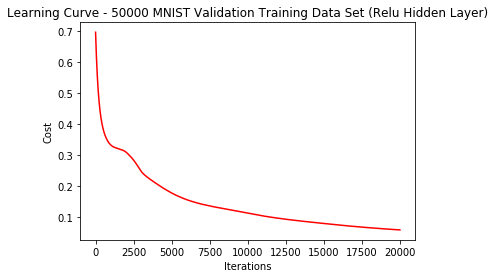

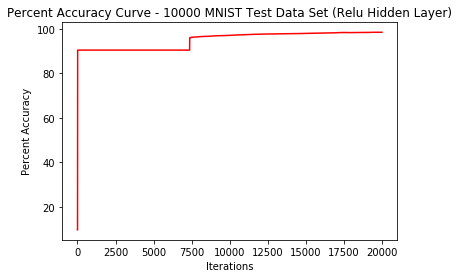

In [251]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01; 
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

(Note: Please scroll down past the iteration count to see the results. The iteration count was for development to estimate how long the run time would be.)

As illustrated, the learning curve begins to flatten out by 20000 iterations; the cost of the network flattended out to approximately 0.057, which an accuracy of 98.4% on the test data. This is an excellent increase in accuracy compared to last assignment in which we only had one hidden layer of five units. 

Now we will run through some example classifications in the networks. We will attempt to find one true positive, one true negative, one false positive, and one false negative for each of these networks.


Results: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


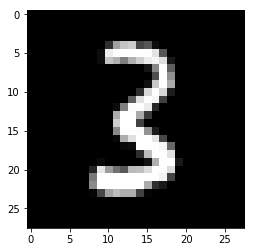

True Postitive Found: True Label: 1 Predicted: 1, @ Test Data Index: 3, Size; (1, 28, 28)


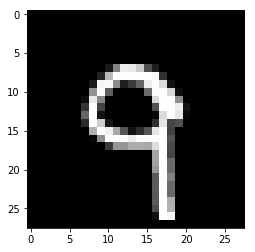

False Positive Found: True Label: 0 Predicted: 1, @ Test Data Index: 5, Size; (1, 28, 28)


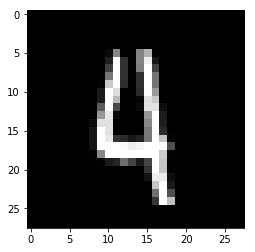

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 78, Size; (1, 28, 28)


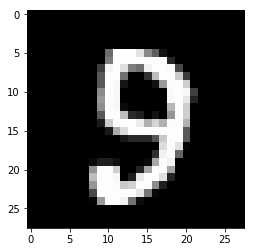

In [254]:
print('')
print('Results: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = _prediction[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[number_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[number_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[number_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[number_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show() 

(Please note this whole file must be run in order for these pictures to match the descriptions below.)

As illustrated above, we have found a true positive, a true negative, a false positive, and a false negative. This idicates a healthy network classification and descent generalization (even without a lot of speciallized regularization techniques). 

We can clearly see proper classifications of both a true positive and true negative. However, we also have found one false positive and one false negative. The false positive was actually a four, however we can see the the this four closely resembles a 9; therefore, it is understandable that this network mis-labeled the image. The false negative found was a nine with that was rounded at the bottom; This could easily be mistaken by the newtork as a 3 or 0; and thus, not a 9. Of course this analysis is speculative, but reasonable.   

So far with 2 layers of 5 units each we have achieved good results. 

In order to compare a network in with 2 hidden layers to a network with more hidden layers, we will use 3 hidden layers and re-run our gradient descent for the same number of iterations and a similar weight and bias initialization.

First we must re-initialize our weights and bias's as a uniform random distribution with the same random seed as before. However, we will specify 3 hidden layers.  

In [7]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 3
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(4,)
(4,)


Now we will re-run our gradient descent with 3 layers.

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 334
Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373


Main Loop Iteration: 662
Main Loop Iteration: 663
Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701


Main Loop Iteration: 989
Main Loop Iteration: 990
Main Loop Iteration: 991
Main Loop Iteration: 992
Main Loop Iteration: 993
Main Loop Iteration: 994
Main Loop Iteration: 995
Main Loop Iteration: 996
Main Loop Iteration: 997
Main Loop Iteration: 998
Main Loop Iteration: 999
Main Loop Iteration: 1000
Main Loop Iteration: 1001
Main Loop Iteration: 1002
Main Loop Iteration: 1003
Main Loop Iteration: 1004
Main Loop Iteration: 1005
Main Loop Iteration: 1006
Main Loop Iteration: 1007
Main Loop Iteration: 1008
Main Loop Iteration: 1009
Main Loop Iteration: 1010
Main Loop Iteration: 1011
Main Loop Iteration: 1012
Main Loop Iteration: 1013
Main Loop Iteration: 1014
Main Loop Iteration: 1015
Main Loop Iteration: 1016
Main Loop Iteration: 1017
Main Loop Iteration: 1018
Main Loop Iteration: 1019
Main Loop Iteration: 1020
Main Loop Iteration: 1021
Main Loop Iteration: 1022
Main Loop Iteration: 1023
Main Loop Iteration: 1024
Main Loop Iteration: 1025
Main Loop Iteration: 1026
Main Loop Iteration: 10

Main Loop Iteration: 1305
Main Loop Iteration: 1306
Main Loop Iteration: 1307
Main Loop Iteration: 1308
Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop It

Main Loop Iteration: 1621
Main Loop Iteration: 1622
Main Loop Iteration: 1623
Main Loop Iteration: 1624
Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop It

Main Loop Iteration: 1937
Main Loop Iteration: 1938
Main Loop Iteration: 1939
Main Loop Iteration: 1940
Main Loop Iteration: 1941
Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop It

Main Loop Iteration: 2253
Main Loop Iteration: 2254
Main Loop Iteration: 2255
Main Loop Iteration: 2256
Main Loop Iteration: 2257
Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop It

Main Loop Iteration: 2568
Main Loop Iteration: 2569
Main Loop Iteration: 2570
Main Loop Iteration: 2571
Main Loop Iteration: 2572
Main Loop Iteration: 2573
Main Loop Iteration: 2574
Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop It

Main Loop Iteration: 2884
Main Loop Iteration: 2885
Main Loop Iteration: 2886
Main Loop Iteration: 2887
Main Loop Iteration: 2888
Main Loop Iteration: 2889
Main Loop Iteration: 2890
Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop It

Main Loop Iteration: 3200
Main Loop Iteration: 3201
Main Loop Iteration: 3202
Main Loop Iteration: 3203
Main Loop Iteration: 3204
Main Loop Iteration: 3205
Main Loop Iteration: 3206
Main Loop Iteration: 3207
Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop It

Main Loop Iteration: 3516
Main Loop Iteration: 3517
Main Loop Iteration: 3518
Main Loop Iteration: 3519
Main Loop Iteration: 3520
Main Loop Iteration: 3521
Main Loop Iteration: 3522
Main Loop Iteration: 3523
Main Loop Iteration: 3524
Main Loop Iteration: 3525
Main Loop Iteration: 3526
Main Loop Iteration: 3527
Main Loop Iteration: 3528
Main Loop Iteration: 3529
Main Loop Iteration: 3530
Main Loop Iteration: 3531
Main Loop Iteration: 3532
Main Loop Iteration: 3533
Main Loop Iteration: 3534
Main Loop Iteration: 3535
Main Loop Iteration: 3536
Main Loop Iteration: 3537
Main Loop Iteration: 3538
Main Loop Iteration: 3539
Main Loop Iteration: 3540
Main Loop Iteration: 3541
Main Loop Iteration: 3542
Main Loop Iteration: 3543
Main Loop Iteration: 3544
Main Loop Iteration: 3545
Main Loop Iteration: 3546
Main Loop Iteration: 3547
Main Loop Iteration: 3548
Main Loop Iteration: 3549
Main Loop Iteration: 3550
Main Loop Iteration: 3551
Main Loop Iteration: 3552
Main Loop Iteration: 3553
Main Loop It

Main Loop Iteration: 3832
Main Loop Iteration: 3833
Main Loop Iteration: 3834
Main Loop Iteration: 3835
Main Loop Iteration: 3836
Main Loop Iteration: 3837
Main Loop Iteration: 3838
Main Loop Iteration: 3839
Main Loop Iteration: 3840
Main Loop Iteration: 3841
Main Loop Iteration: 3842
Main Loop Iteration: 3843
Main Loop Iteration: 3844
Main Loop Iteration: 3845
Main Loop Iteration: 3846
Main Loop Iteration: 3847
Main Loop Iteration: 3848
Main Loop Iteration: 3849
Main Loop Iteration: 3850
Main Loop Iteration: 3851
Main Loop Iteration: 3852
Main Loop Iteration: 3853
Main Loop Iteration: 3854
Main Loop Iteration: 3855
Main Loop Iteration: 3856
Main Loop Iteration: 3857
Main Loop Iteration: 3858
Main Loop Iteration: 3859
Main Loop Iteration: 3860
Main Loop Iteration: 3861
Main Loop Iteration: 3862
Main Loop Iteration: 3863
Main Loop Iteration: 3864
Main Loop Iteration: 3865
Main Loop Iteration: 3866
Main Loop Iteration: 3867
Main Loop Iteration: 3868
Main Loop Iteration: 3869
Main Loop It

Main Loop Iteration: 4148
Main Loop Iteration: 4149
Main Loop Iteration: 4150
Main Loop Iteration: 4151
Main Loop Iteration: 4152
Main Loop Iteration: 4153
Main Loop Iteration: 4154
Main Loop Iteration: 4155
Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop It

Main Loop Iteration: 4464
Main Loop Iteration: 4465
Main Loop Iteration: 4466
Main Loop Iteration: 4467
Main Loop Iteration: 4468
Main Loop Iteration: 4469
Main Loop Iteration: 4470
Main Loop Iteration: 4471
Main Loop Iteration: 4472
Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop It

Main Loop Iteration: 4780
Main Loop Iteration: 4781
Main Loop Iteration: 4782
Main Loop Iteration: 4783
Main Loop Iteration: 4784
Main Loop Iteration: 4785
Main Loop Iteration: 4786
Main Loop Iteration: 4787
Main Loop Iteration: 4788
Main Loop Iteration: 4789
Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop It

Main Loop Iteration: 5096
Main Loop Iteration: 5097
Main Loop Iteration: 5098
Main Loop Iteration: 5099
Main Loop Iteration: 5100
Main Loop Iteration: 5101
Main Loop Iteration: 5102
Main Loop Iteration: 5103
Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop It

Main Loop Iteration: 5411
Main Loop Iteration: 5412
Main Loop Iteration: 5413
Main Loop Iteration: 5414
Main Loop Iteration: 5415
Main Loop Iteration: 5416
Main Loop Iteration: 5417
Main Loop Iteration: 5418
Main Loop Iteration: 5419
Main Loop Iteration: 5420
Main Loop Iteration: 5421
Main Loop Iteration: 5422
Main Loop Iteration: 5423
Main Loop Iteration: 5424
Main Loop Iteration: 5425
Main Loop Iteration: 5426
Main Loop Iteration: 5427
Main Loop Iteration: 5428
Main Loop Iteration: 5429
Main Loop Iteration: 5430
Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop It

Main Loop Iteration: 5727
Main Loop Iteration: 5728
Main Loop Iteration: 5729
Main Loop Iteration: 5730
Main Loop Iteration: 5731
Main Loop Iteration: 5732
Main Loop Iteration: 5733
Main Loop Iteration: 5734
Main Loop Iteration: 5735
Main Loop Iteration: 5736
Main Loop Iteration: 5737
Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop It

Main Loop Iteration: 6043
Main Loop Iteration: 6044
Main Loop Iteration: 6045
Main Loop Iteration: 6046
Main Loop Iteration: 6047
Main Loop Iteration: 6048
Main Loop Iteration: 6049
Main Loop Iteration: 6050
Main Loop Iteration: 6051
Main Loop Iteration: 6052
Main Loop Iteration: 6053
Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop It

Main Loop Iteration: 6359
Main Loop Iteration: 6360
Main Loop Iteration: 6361
Main Loop Iteration: 6362
Main Loop Iteration: 6363
Main Loop Iteration: 6364
Main Loop Iteration: 6365
Main Loop Iteration: 6366
Main Loop Iteration: 6367
Main Loop Iteration: 6368
Main Loop Iteration: 6369
Main Loop Iteration: 6370
Main Loop Iteration: 6371
Main Loop Iteration: 6372
Main Loop Iteration: 6373
Main Loop Iteration: 6374
Main Loop Iteration: 6375
Main Loop Iteration: 6376
Main Loop Iteration: 6377
Main Loop Iteration: 6378
Main Loop Iteration: 6379
Main Loop Iteration: 6380
Main Loop Iteration: 6381
Main Loop Iteration: 6382
Main Loop Iteration: 6383
Main Loop Iteration: 6384
Main Loop Iteration: 6385
Main Loop Iteration: 6386
Main Loop Iteration: 6387
Main Loop Iteration: 6388
Main Loop Iteration: 6389
Main Loop Iteration: 6390
Main Loop Iteration: 6391
Main Loop Iteration: 6392
Main Loop Iteration: 6393
Main Loop Iteration: 6394
Main Loop Iteration: 6395
Main Loop Iteration: 6396
Main Loop It

Main Loop Iteration: 6675
Main Loop Iteration: 6676
Main Loop Iteration: 6677
Main Loop Iteration: 6678
Main Loop Iteration: 6679
Main Loop Iteration: 6680
Main Loop Iteration: 6681
Main Loop Iteration: 6682
Main Loop Iteration: 6683
Main Loop Iteration: 6684
Main Loop Iteration: 6685
Main Loop Iteration: 6686
Main Loop Iteration: 6687
Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop It

Main Loop Iteration: 6991
Main Loop Iteration: 6992
Main Loop Iteration: 6993
Main Loop Iteration: 6994
Main Loop Iteration: 6995
Main Loop Iteration: 6996
Main Loop Iteration: 6997
Main Loop Iteration: 6998
Main Loop Iteration: 6999
Main Loop Iteration: 7000
Main Loop Iteration: 7001
Main Loop Iteration: 7002
Main Loop Iteration: 7003
Main Loop Iteration: 7004
Main Loop Iteration: 7005
Main Loop Iteration: 7006
Main Loop Iteration: 7007
Main Loop Iteration: 7008
Main Loop Iteration: 7009
Main Loop Iteration: 7010
Main Loop Iteration: 7011
Main Loop Iteration: 7012
Main Loop Iteration: 7013
Main Loop Iteration: 7014
Main Loop Iteration: 7015
Main Loop Iteration: 7016
Main Loop Iteration: 7017
Main Loop Iteration: 7018
Main Loop Iteration: 7019
Main Loop Iteration: 7020
Main Loop Iteration: 7021
Main Loop Iteration: 7022
Main Loop Iteration: 7023
Main Loop Iteration: 7024
Main Loop Iteration: 7025
Main Loop Iteration: 7026
Main Loop Iteration: 7027
Main Loop Iteration: 7028
Main Loop It

Main Loop Iteration: 7307
Main Loop Iteration: 7308
Main Loop Iteration: 7309
Main Loop Iteration: 7310
Main Loop Iteration: 7311
Main Loop Iteration: 7312
Main Loop Iteration: 7313
Main Loop Iteration: 7314
Main Loop Iteration: 7315
Main Loop Iteration: 7316
Main Loop Iteration: 7317
Main Loop Iteration: 7318
Main Loop Iteration: 7319
Main Loop Iteration: 7320
Main Loop Iteration: 7321
Main Loop Iteration: 7322
Main Loop Iteration: 7323
Main Loop Iteration: 7324
Main Loop Iteration: 7325
Main Loop Iteration: 7326
Main Loop Iteration: 7327
Main Loop Iteration: 7328
Main Loop Iteration: 7329
Main Loop Iteration: 7330
Main Loop Iteration: 7331
Main Loop Iteration: 7332
Main Loop Iteration: 7333
Main Loop Iteration: 7334
Main Loop Iteration: 7335
Main Loop Iteration: 7336
Main Loop Iteration: 7337
Main Loop Iteration: 7338
Main Loop Iteration: 7339
Main Loop Iteration: 7340
Main Loop Iteration: 7341
Main Loop Iteration: 7342
Main Loop Iteration: 7343
Main Loop Iteration: 7344
Main Loop It

Main Loop Iteration: 7623
Main Loop Iteration: 7624
Main Loop Iteration: 7625
Main Loop Iteration: 7626
Main Loop Iteration: 7627
Main Loop Iteration: 7628
Main Loop Iteration: 7629
Main Loop Iteration: 7630
Main Loop Iteration: 7631
Main Loop Iteration: 7632
Main Loop Iteration: 7633
Main Loop Iteration: 7634
Main Loop Iteration: 7635
Main Loop Iteration: 7636
Main Loop Iteration: 7637
Main Loop Iteration: 7638
Main Loop Iteration: 7639
Main Loop Iteration: 7640
Main Loop Iteration: 7641
Main Loop Iteration: 7642
Main Loop Iteration: 7643
Main Loop Iteration: 7644
Main Loop Iteration: 7645
Main Loop Iteration: 7646
Main Loop Iteration: 7647
Main Loop Iteration: 7648
Main Loop Iteration: 7649
Main Loop Iteration: 7650
Main Loop Iteration: 7651
Main Loop Iteration: 7652
Main Loop Iteration: 7653
Main Loop Iteration: 7654
Main Loop Iteration: 7655
Main Loop Iteration: 7656
Main Loop Iteration: 7657
Main Loop Iteration: 7658
Main Loop Iteration: 7659
Main Loop Iteration: 7660
Main Loop It

Main Loop Iteration: 7938
Main Loop Iteration: 7939
Main Loop Iteration: 7940
Main Loop Iteration: 7941
Main Loop Iteration: 7942
Main Loop Iteration: 7943
Main Loop Iteration: 7944
Main Loop Iteration: 7945
Main Loop Iteration: 7946
Main Loop Iteration: 7947
Main Loop Iteration: 7948
Main Loop Iteration: 7949
Main Loop Iteration: 7950
Main Loop Iteration: 7951
Main Loop Iteration: 7952
Main Loop Iteration: 7953
Main Loop Iteration: 7954
Main Loop Iteration: 7955
Main Loop Iteration: 7956
Main Loop Iteration: 7957
Main Loop Iteration: 7958
Main Loop Iteration: 7959
Main Loop Iteration: 7960
Main Loop Iteration: 7961
Main Loop Iteration: 7962
Main Loop Iteration: 7963
Main Loop Iteration: 7964
Main Loop Iteration: 7965
Main Loop Iteration: 7966
Main Loop Iteration: 7967
Main Loop Iteration: 7968
Main Loop Iteration: 7969
Main Loop Iteration: 7970
Main Loop Iteration: 7971
Main Loop Iteration: 7972
Main Loop Iteration: 7973
Main Loop Iteration: 7974
Main Loop Iteration: 7975
Main Loop It

Main Loop Iteration: 8254
Main Loop Iteration: 8255
Main Loop Iteration: 8256
Main Loop Iteration: 8257
Main Loop Iteration: 8258
Main Loop Iteration: 8259
Main Loop Iteration: 8260
Main Loop Iteration: 8261
Main Loop Iteration: 8262
Main Loop Iteration: 8263
Main Loop Iteration: 8264
Main Loop Iteration: 8265
Main Loop Iteration: 8266
Main Loop Iteration: 8267
Main Loop Iteration: 8268
Main Loop Iteration: 8269
Main Loop Iteration: 8270
Main Loop Iteration: 8271
Main Loop Iteration: 8272
Main Loop Iteration: 8273
Main Loop Iteration: 8274
Main Loop Iteration: 8275
Main Loop Iteration: 8276
Main Loop Iteration: 8277
Main Loop Iteration: 8278
Main Loop Iteration: 8279
Main Loop Iteration: 8280
Main Loop Iteration: 8281
Main Loop Iteration: 8282
Main Loop Iteration: 8283
Main Loop Iteration: 8284
Main Loop Iteration: 8285
Main Loop Iteration: 8286
Main Loop Iteration: 8287
Main Loop Iteration: 8288
Main Loop Iteration: 8289
Main Loop Iteration: 8290
Main Loop Iteration: 8291
Main Loop It

Main Loop Iteration: 8569
Main Loop Iteration: 8570
Main Loop Iteration: 8571
Main Loop Iteration: 8572
Main Loop Iteration: 8573
Main Loop Iteration: 8574
Main Loop Iteration: 8575
Main Loop Iteration: 8576
Main Loop Iteration: 8577
Main Loop Iteration: 8578
Main Loop Iteration: 8579
Main Loop Iteration: 8580
Main Loop Iteration: 8581
Main Loop Iteration: 8582
Main Loop Iteration: 8583
Main Loop Iteration: 8584
Main Loop Iteration: 8585
Main Loop Iteration: 8586
Main Loop Iteration: 8587
Main Loop Iteration: 8588
Main Loop Iteration: 8589
Main Loop Iteration: 8590
Main Loop Iteration: 8591
Main Loop Iteration: 8592
Main Loop Iteration: 8593
Main Loop Iteration: 8594
Main Loop Iteration: 8595
Main Loop Iteration: 8596
Main Loop Iteration: 8597
Main Loop Iteration: 8598
Main Loop Iteration: 8599
Main Loop Iteration: 8600
Main Loop Iteration: 8601
Main Loop Iteration: 8602
Main Loop Iteration: 8603
Main Loop Iteration: 8604
Main Loop Iteration: 8605
Main Loop Iteration: 8606
Main Loop It

Main Loop Iteration: 8885
Main Loop Iteration: 8886
Main Loop Iteration: 8887
Main Loop Iteration: 8888
Main Loop Iteration: 8889
Main Loop Iteration: 8890
Main Loop Iteration: 8891
Main Loop Iteration: 8892
Main Loop Iteration: 8893
Main Loop Iteration: 8894
Main Loop Iteration: 8895
Main Loop Iteration: 8896
Main Loop Iteration: 8897
Main Loop Iteration: 8898
Main Loop Iteration: 8899
Main Loop Iteration: 8900
Main Loop Iteration: 8901
Main Loop Iteration: 8902
Main Loop Iteration: 8903
Main Loop Iteration: 8904
Main Loop Iteration: 8905
Main Loop Iteration: 8906
Main Loop Iteration: 8907
Main Loop Iteration: 8908
Main Loop Iteration: 8909
Main Loop Iteration: 8910
Main Loop Iteration: 8911
Main Loop Iteration: 8912
Main Loop Iteration: 8913
Main Loop Iteration: 8914
Main Loop Iteration: 8915
Main Loop Iteration: 8916
Main Loop Iteration: 8917
Main Loop Iteration: 8918
Main Loop Iteration: 8919
Main Loop Iteration: 8920
Main Loop Iteration: 8921
Main Loop Iteration: 8922
Main Loop It

Main Loop Iteration: 9200
Main Loop Iteration: 9201
Main Loop Iteration: 9202
Main Loop Iteration: 9203
Main Loop Iteration: 9204
Main Loop Iteration: 9205
Main Loop Iteration: 9206
Main Loop Iteration: 9207
Main Loop Iteration: 9208
Main Loop Iteration: 9209
Main Loop Iteration: 9210
Main Loop Iteration: 9211
Main Loop Iteration: 9212
Main Loop Iteration: 9213
Main Loop Iteration: 9214
Main Loop Iteration: 9215
Main Loop Iteration: 9216
Main Loop Iteration: 9217
Main Loop Iteration: 9218
Main Loop Iteration: 9219
Main Loop Iteration: 9220
Main Loop Iteration: 9221
Main Loop Iteration: 9222
Main Loop Iteration: 9223
Main Loop Iteration: 9224
Main Loop Iteration: 9225
Main Loop Iteration: 9226
Main Loop Iteration: 9227
Main Loop Iteration: 9228
Main Loop Iteration: 9229
Main Loop Iteration: 9230
Main Loop Iteration: 9231
Main Loop Iteration: 9232
Main Loop Iteration: 9233
Main Loop Iteration: 9234
Main Loop Iteration: 9235
Main Loop Iteration: 9236
Main Loop Iteration: 9237
Main Loop It

Main Loop Iteration: 9516
Main Loop Iteration: 9517
Main Loop Iteration: 9518
Main Loop Iteration: 9519
Main Loop Iteration: 9520
Main Loop Iteration: 9521
Main Loop Iteration: 9522
Main Loop Iteration: 9523
Main Loop Iteration: 9524
Main Loop Iteration: 9525
Main Loop Iteration: 9526
Main Loop Iteration: 9527
Main Loop Iteration: 9528
Main Loop Iteration: 9529
Main Loop Iteration: 9530
Main Loop Iteration: 9531
Main Loop Iteration: 9532
Main Loop Iteration: 9533
Main Loop Iteration: 9534
Main Loop Iteration: 9535
Main Loop Iteration: 9536
Main Loop Iteration: 9537
Main Loop Iteration: 9538
Main Loop Iteration: 9539
Main Loop Iteration: 9540
Main Loop Iteration: 9541
Main Loop Iteration: 9542
Main Loop Iteration: 9543
Main Loop Iteration: 9544
Main Loop Iteration: 9545
Main Loop Iteration: 9546
Main Loop Iteration: 9547
Main Loop Iteration: 9548
Main Loop Iteration: 9549
Main Loop Iteration: 9550
Main Loop Iteration: 9551
Main Loop Iteration: 9552
Main Loop Iteration: 9553
Main Loop It

Main Loop Iteration: 9832
Main Loop Iteration: 9833
Main Loop Iteration: 9834
Main Loop Iteration: 9835
Main Loop Iteration: 9836
Main Loop Iteration: 9837
Main Loop Iteration: 9838
Main Loop Iteration: 9839
Main Loop Iteration: 9840
Main Loop Iteration: 9841
Main Loop Iteration: 9842
Main Loop Iteration: 9843
Main Loop Iteration: 9844
Main Loop Iteration: 9845
Main Loop Iteration: 9846
Main Loop Iteration: 9847
Main Loop Iteration: 9848
Main Loop Iteration: 9849
Main Loop Iteration: 9850
Main Loop Iteration: 9851
Main Loop Iteration: 9852
Main Loop Iteration: 9853
Main Loop Iteration: 9854
Main Loop Iteration: 9855
Main Loop Iteration: 9856
Main Loop Iteration: 9857
Main Loop Iteration: 9858
Main Loop Iteration: 9859
Main Loop Iteration: 9860
Main Loop Iteration: 9861
Main Loop Iteration: 9862
Main Loop Iteration: 9863
Main Loop Iteration: 9864
Main Loop Iteration: 9865
Main Loop Iteration: 9866
Main Loop Iteration: 9867
Main Loop Iteration: 9868
Main Loop Iteration: 9869
Main Loop It

Main Loop Iteration: 10142
Main Loop Iteration: 10143
Main Loop Iteration: 10144
Main Loop Iteration: 10145
Main Loop Iteration: 10146
Main Loop Iteration: 10147
Main Loop Iteration: 10148
Main Loop Iteration: 10149
Main Loop Iteration: 10150
Main Loop Iteration: 10151
Main Loop Iteration: 10152
Main Loop Iteration: 10153
Main Loop Iteration: 10154
Main Loop Iteration: 10155
Main Loop Iteration: 10156
Main Loop Iteration: 10157
Main Loop Iteration: 10158
Main Loop Iteration: 10159
Main Loop Iteration: 10160
Main Loop Iteration: 10161
Main Loop Iteration: 10162
Main Loop Iteration: 10163
Main Loop Iteration: 10164
Main Loop Iteration: 10165
Main Loop Iteration: 10166
Main Loop Iteration: 10167
Main Loop Iteration: 10168
Main Loop Iteration: 10169
Main Loop Iteration: 10170
Main Loop Iteration: 10171
Main Loop Iteration: 10172
Main Loop Iteration: 10173
Main Loop Iteration: 10174
Main Loop Iteration: 10175
Main Loop Iteration: 10176
Main Loop Iteration: 10177
Main Loop Iteration: 10178
M

Main Loop Iteration: 10446
Main Loop Iteration: 10447
Main Loop Iteration: 10448
Main Loop Iteration: 10449
Main Loop Iteration: 10450
Main Loop Iteration: 10451
Main Loop Iteration: 10452
Main Loop Iteration: 10453
Main Loop Iteration: 10454
Main Loop Iteration: 10455
Main Loop Iteration: 10456
Main Loop Iteration: 10457
Main Loop Iteration: 10458
Main Loop Iteration: 10459
Main Loop Iteration: 10460
Main Loop Iteration: 10461
Main Loop Iteration: 10462
Main Loop Iteration: 10463
Main Loop Iteration: 10464
Main Loop Iteration: 10465
Main Loop Iteration: 10466
Main Loop Iteration: 10467
Main Loop Iteration: 10468
Main Loop Iteration: 10469
Main Loop Iteration: 10470
Main Loop Iteration: 10471
Main Loop Iteration: 10472
Main Loop Iteration: 10473
Main Loop Iteration: 10474
Main Loop Iteration: 10475
Main Loop Iteration: 10476
Main Loop Iteration: 10477
Main Loop Iteration: 10478
Main Loop Iteration: 10479
Main Loop Iteration: 10480
Main Loop Iteration: 10481
Main Loop Iteration: 10482
M

Main Loop Iteration: 10750
Main Loop Iteration: 10751
Main Loop Iteration: 10752
Main Loop Iteration: 10753
Main Loop Iteration: 10754
Main Loop Iteration: 10755
Main Loop Iteration: 10756
Main Loop Iteration: 10757
Main Loop Iteration: 10758
Main Loop Iteration: 10759
Main Loop Iteration: 10760
Main Loop Iteration: 10761
Main Loop Iteration: 10762
Main Loop Iteration: 10763
Main Loop Iteration: 10764
Main Loop Iteration: 10765
Main Loop Iteration: 10766
Main Loop Iteration: 10767
Main Loop Iteration: 10768
Main Loop Iteration: 10769
Main Loop Iteration: 10770
Main Loop Iteration: 10771
Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
Main Loop Iteration: 10781
Main Loop Iteration: 10782
Main Loop Iteration: 10783
Main Loop Iteration: 10784
Main Loop Iteration: 10785
Main Loop Iteration: 10786
M

Main Loop Iteration: 11054
Main Loop Iteration: 11055
Main Loop Iteration: 11056
Main Loop Iteration: 11057
Main Loop Iteration: 11058
Main Loop Iteration: 11059
Main Loop Iteration: 11060
Main Loop Iteration: 11061
Main Loop Iteration: 11062
Main Loop Iteration: 11063
Main Loop Iteration: 11064
Main Loop Iteration: 11065
Main Loop Iteration: 11066
Main Loop Iteration: 11067
Main Loop Iteration: 11068
Main Loop Iteration: 11069
Main Loop Iteration: 11070
Main Loop Iteration: 11071
Main Loop Iteration: 11072
Main Loop Iteration: 11073
Main Loop Iteration: 11074
Main Loop Iteration: 11075
Main Loop Iteration: 11076
Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
Main Loop Iteration: 11090
M

Main Loop Iteration: 11358
Main Loop Iteration: 11359
Main Loop Iteration: 11360
Main Loop Iteration: 11361
Main Loop Iteration: 11362
Main Loop Iteration: 11363
Main Loop Iteration: 11364
Main Loop Iteration: 11365
Main Loop Iteration: 11366
Main Loop Iteration: 11367
Main Loop Iteration: 11368
Main Loop Iteration: 11369
Main Loop Iteration: 11370
Main Loop Iteration: 11371
Main Loop Iteration: 11372
Main Loop Iteration: 11373
Main Loop Iteration: 11374
Main Loop Iteration: 11375
Main Loop Iteration: 11376
Main Loop Iteration: 11377
Main Loop Iteration: 11378
Main Loop Iteration: 11379
Main Loop Iteration: 11380
Main Loop Iteration: 11381
Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
M

Main Loop Iteration: 11661
Main Loop Iteration: 11662
Main Loop Iteration: 11663
Main Loop Iteration: 11664
Main Loop Iteration: 11665
Main Loop Iteration: 11666
Main Loop Iteration: 11667
Main Loop Iteration: 11668
Main Loop Iteration: 11669
Main Loop Iteration: 11670
Main Loop Iteration: 11671
Main Loop Iteration: 11672
Main Loop Iteration: 11673
Main Loop Iteration: 11674
Main Loop Iteration: 11675
Main Loop Iteration: 11676
Main Loop Iteration: 11677
Main Loop Iteration: 11678
Main Loop Iteration: 11679
Main Loop Iteration: 11680
Main Loop Iteration: 11681
Main Loop Iteration: 11682
Main Loop Iteration: 11683
Main Loop Iteration: 11684
Main Loop Iteration: 11685
Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
M

Main Loop Iteration: 11965
Main Loop Iteration: 11966
Main Loop Iteration: 11967
Main Loop Iteration: 11968
Main Loop Iteration: 11969
Main Loop Iteration: 11970
Main Loop Iteration: 11971
Main Loop Iteration: 11972
Main Loop Iteration: 11973
Main Loop Iteration: 11974
Main Loop Iteration: 11975
Main Loop Iteration: 11976
Main Loop Iteration: 11977
Main Loop Iteration: 11978
Main Loop Iteration: 11979
Main Loop Iteration: 11980
Main Loop Iteration: 11981
Main Loop Iteration: 11982
Main Loop Iteration: 11983
Main Loop Iteration: 11984
Main Loop Iteration: 11985
Main Loop Iteration: 11986
Main Loop Iteration: 11987
Main Loop Iteration: 11988
Main Loop Iteration: 11989
Main Loop Iteration: 11990
Main Loop Iteration: 11991
Main Loop Iteration: 11992
Main Loop Iteration: 11993
Main Loop Iteration: 11994
Main Loop Iteration: 11995
Main Loop Iteration: 11996
Main Loop Iteration: 11997
Main Loop Iteration: 11998
Main Loop Iteration: 11999
Main Loop Iteration: 12000
Main Loop Iteration: 12001
M

Main Loop Iteration: 12269
Main Loop Iteration: 12270
Main Loop Iteration: 12271
Main Loop Iteration: 12272
Main Loop Iteration: 12273
Main Loop Iteration: 12274
Main Loop Iteration: 12275
Main Loop Iteration: 12276
Main Loop Iteration: 12277
Main Loop Iteration: 12278
Main Loop Iteration: 12279
Main Loop Iteration: 12280
Main Loop Iteration: 12281
Main Loop Iteration: 12282
Main Loop Iteration: 12283
Main Loop Iteration: 12284
Main Loop Iteration: 12285
Main Loop Iteration: 12286
Main Loop Iteration: 12287
Main Loop Iteration: 12288
Main Loop Iteration: 12289
Main Loop Iteration: 12290
Main Loop Iteration: 12291
Main Loop Iteration: 12292
Main Loop Iteration: 12293
Main Loop Iteration: 12294
Main Loop Iteration: 12295
Main Loop Iteration: 12296
Main Loop Iteration: 12297
Main Loop Iteration: 12298
Main Loop Iteration: 12299
Main Loop Iteration: 12300
Main Loop Iteration: 12301
Main Loop Iteration: 12302
Main Loop Iteration: 12303
Main Loop Iteration: 12304
Main Loop Iteration: 12305
M

Main Loop Iteration: 12573
Main Loop Iteration: 12574
Main Loop Iteration: 12575
Main Loop Iteration: 12576
Main Loop Iteration: 12577
Main Loop Iteration: 12578
Main Loop Iteration: 12579
Main Loop Iteration: 12580
Main Loop Iteration: 12581
Main Loop Iteration: 12582
Main Loop Iteration: 12583
Main Loop Iteration: 12584
Main Loop Iteration: 12585
Main Loop Iteration: 12586
Main Loop Iteration: 12587
Main Loop Iteration: 12588
Main Loop Iteration: 12589
Main Loop Iteration: 12590
Main Loop Iteration: 12591
Main Loop Iteration: 12592
Main Loop Iteration: 12593
Main Loop Iteration: 12594
Main Loop Iteration: 12595
Main Loop Iteration: 12596
Main Loop Iteration: 12597
Main Loop Iteration: 12598
Main Loop Iteration: 12599
Main Loop Iteration: 12600
Main Loop Iteration: 12601
Main Loop Iteration: 12602
Main Loop Iteration: 12603
Main Loop Iteration: 12604
Main Loop Iteration: 12605
Main Loop Iteration: 12606
Main Loop Iteration: 12607
Main Loop Iteration: 12608
Main Loop Iteration: 12609
M

Main Loop Iteration: 12877
Main Loop Iteration: 12878
Main Loop Iteration: 12879
Main Loop Iteration: 12880
Main Loop Iteration: 12881
Main Loop Iteration: 12882
Main Loop Iteration: 12883
Main Loop Iteration: 12884
Main Loop Iteration: 12885
Main Loop Iteration: 12886
Main Loop Iteration: 12887
Main Loop Iteration: 12888
Main Loop Iteration: 12889
Main Loop Iteration: 12890
Main Loop Iteration: 12891
Main Loop Iteration: 12892
Main Loop Iteration: 12893
Main Loop Iteration: 12894
Main Loop Iteration: 12895
Main Loop Iteration: 12896
Main Loop Iteration: 12897
Main Loop Iteration: 12898
Main Loop Iteration: 12899
Main Loop Iteration: 12900
Main Loop Iteration: 12901
Main Loop Iteration: 12902
Main Loop Iteration: 12903
Main Loop Iteration: 12904
Main Loop Iteration: 12905
Main Loop Iteration: 12906
Main Loop Iteration: 12907
Main Loop Iteration: 12908
Main Loop Iteration: 12909
Main Loop Iteration: 12910
Main Loop Iteration: 12911
Main Loop Iteration: 12912
Main Loop Iteration: 12913
M

Main Loop Iteration: 13181
Main Loop Iteration: 13182
Main Loop Iteration: 13183
Main Loop Iteration: 13184
Main Loop Iteration: 13185
Main Loop Iteration: 13186
Main Loop Iteration: 13187
Main Loop Iteration: 13188
Main Loop Iteration: 13189
Main Loop Iteration: 13190
Main Loop Iteration: 13191
Main Loop Iteration: 13192
Main Loop Iteration: 13193
Main Loop Iteration: 13194
Main Loop Iteration: 13195
Main Loop Iteration: 13196
Main Loop Iteration: 13197
Main Loop Iteration: 13198
Main Loop Iteration: 13199
Main Loop Iteration: 13200
Main Loop Iteration: 13201
Main Loop Iteration: 13202
Main Loop Iteration: 13203
Main Loop Iteration: 13204
Main Loop Iteration: 13205
Main Loop Iteration: 13206
Main Loop Iteration: 13207
Main Loop Iteration: 13208
Main Loop Iteration: 13209
Main Loop Iteration: 13210
Main Loop Iteration: 13211
Main Loop Iteration: 13212
Main Loop Iteration: 13213
Main Loop Iteration: 13214
Main Loop Iteration: 13215
Main Loop Iteration: 13216
Main Loop Iteration: 13217
M

Main Loop Iteration: 13485
Main Loop Iteration: 13486
Main Loop Iteration: 13487
Main Loop Iteration: 13488
Main Loop Iteration: 13489
Main Loop Iteration: 13490
Main Loop Iteration: 13491
Main Loop Iteration: 13492
Main Loop Iteration: 13493
Main Loop Iteration: 13494
Main Loop Iteration: 13495
Main Loop Iteration: 13496
Main Loop Iteration: 13497
Main Loop Iteration: 13498
Main Loop Iteration: 13499
Main Loop Iteration: 13500
Main Loop Iteration: 13501
Main Loop Iteration: 13502
Main Loop Iteration: 13503
Main Loop Iteration: 13504
Main Loop Iteration: 13505
Main Loop Iteration: 13506
Main Loop Iteration: 13507
Main Loop Iteration: 13508
Main Loop Iteration: 13509
Main Loop Iteration: 13510
Main Loop Iteration: 13511
Main Loop Iteration: 13512
Main Loop Iteration: 13513
Main Loop Iteration: 13514
Main Loop Iteration: 13515
Main Loop Iteration: 13516
Main Loop Iteration: 13517
Main Loop Iteration: 13518
Main Loop Iteration: 13519
Main Loop Iteration: 13520
Main Loop Iteration: 13521
M

Main Loop Iteration: 13789
Main Loop Iteration: 13790
Main Loop Iteration: 13791
Main Loop Iteration: 13792
Main Loop Iteration: 13793
Main Loop Iteration: 13794
Main Loop Iteration: 13795
Main Loop Iteration: 13796
Main Loop Iteration: 13797
Main Loop Iteration: 13798
Main Loop Iteration: 13799
Main Loop Iteration: 13800
Main Loop Iteration: 13801
Main Loop Iteration: 13802
Main Loop Iteration: 13803
Main Loop Iteration: 13804
Main Loop Iteration: 13805
Main Loop Iteration: 13806
Main Loop Iteration: 13807
Main Loop Iteration: 13808
Main Loop Iteration: 13809
Main Loop Iteration: 13810
Main Loop Iteration: 13811
Main Loop Iteration: 13812
Main Loop Iteration: 13813
Main Loop Iteration: 13814
Main Loop Iteration: 13815
Main Loop Iteration: 13816
Main Loop Iteration: 13817
Main Loop Iteration: 13818
Main Loop Iteration: 13819
Main Loop Iteration: 13820
Main Loop Iteration: 13821
Main Loop Iteration: 13822
Main Loop Iteration: 13823
Main Loop Iteration: 13824
Main Loop Iteration: 13825
M

Main Loop Iteration: 14093
Main Loop Iteration: 14094
Main Loop Iteration: 14095
Main Loop Iteration: 14096
Main Loop Iteration: 14097
Main Loop Iteration: 14098
Main Loop Iteration: 14099
Main Loop Iteration: 14100
Main Loop Iteration: 14101
Main Loop Iteration: 14102
Main Loop Iteration: 14103
Main Loop Iteration: 14104
Main Loop Iteration: 14105
Main Loop Iteration: 14106
Main Loop Iteration: 14107
Main Loop Iteration: 14108
Main Loop Iteration: 14109
Main Loop Iteration: 14110
Main Loop Iteration: 14111
Main Loop Iteration: 14112
Main Loop Iteration: 14113
Main Loop Iteration: 14114
Main Loop Iteration: 14115
Main Loop Iteration: 14116
Main Loop Iteration: 14117
Main Loop Iteration: 14118
Main Loop Iteration: 14119
Main Loop Iteration: 14120
Main Loop Iteration: 14121
Main Loop Iteration: 14122
Main Loop Iteration: 14123
Main Loop Iteration: 14124
Main Loop Iteration: 14125
Main Loop Iteration: 14126
Main Loop Iteration: 14127
Main Loop Iteration: 14128
Main Loop Iteration: 14129
M

Main Loop Iteration: 14397
Main Loop Iteration: 14398
Main Loop Iteration: 14399
Main Loop Iteration: 14400
Main Loop Iteration: 14401
Main Loop Iteration: 14402
Main Loop Iteration: 14403
Main Loop Iteration: 14404
Main Loop Iteration: 14405
Main Loop Iteration: 14406
Main Loop Iteration: 14407
Main Loop Iteration: 14408
Main Loop Iteration: 14409
Main Loop Iteration: 14410
Main Loop Iteration: 14411
Main Loop Iteration: 14412
Main Loop Iteration: 14413
Main Loop Iteration: 14414
Main Loop Iteration: 14415
Main Loop Iteration: 14416
Main Loop Iteration: 14417
Main Loop Iteration: 14418
Main Loop Iteration: 14419
Main Loop Iteration: 14420
Main Loop Iteration: 14421
Main Loop Iteration: 14422
Main Loop Iteration: 14423
Main Loop Iteration: 14424
Main Loop Iteration: 14425
Main Loop Iteration: 14426
Main Loop Iteration: 14427
Main Loop Iteration: 14428
Main Loop Iteration: 14429
Main Loop Iteration: 14430
Main Loop Iteration: 14431
Main Loop Iteration: 14432
Main Loop Iteration: 14433
M

Main Loop Iteration: 14701
Main Loop Iteration: 14702
Main Loop Iteration: 14703
Main Loop Iteration: 14704
Main Loop Iteration: 14705
Main Loop Iteration: 14706
Main Loop Iteration: 14707
Main Loop Iteration: 14708
Main Loop Iteration: 14709
Main Loop Iteration: 14710
Main Loop Iteration: 14711
Main Loop Iteration: 14712
Main Loop Iteration: 14713
Main Loop Iteration: 14714
Main Loop Iteration: 14715
Main Loop Iteration: 14716
Main Loop Iteration: 14717
Main Loop Iteration: 14718
Main Loop Iteration: 14719
Main Loop Iteration: 14720
Main Loop Iteration: 14721
Main Loop Iteration: 14722
Main Loop Iteration: 14723
Main Loop Iteration: 14724
Main Loop Iteration: 14725
Main Loop Iteration: 14726
Main Loop Iteration: 14727
Main Loop Iteration: 14728
Main Loop Iteration: 14729
Main Loop Iteration: 14730
Main Loop Iteration: 14731
Main Loop Iteration: 14732
Main Loop Iteration: 14733
Main Loop Iteration: 14734
Main Loop Iteration: 14735
Main Loop Iteration: 14736
Main Loop Iteration: 14737
M

Main Loop Iteration: 15004
Main Loop Iteration: 15005
Main Loop Iteration: 15006
Main Loop Iteration: 15007
Main Loop Iteration: 15008
Main Loop Iteration: 15009
Main Loop Iteration: 15010
Main Loop Iteration: 15011
Main Loop Iteration: 15012
Main Loop Iteration: 15013
Main Loop Iteration: 15014
Main Loop Iteration: 15015
Main Loop Iteration: 15016
Main Loop Iteration: 15017
Main Loop Iteration: 15018
Main Loop Iteration: 15019
Main Loop Iteration: 15020
Main Loop Iteration: 15021
Main Loop Iteration: 15022
Main Loop Iteration: 15023
Main Loop Iteration: 15024
Main Loop Iteration: 15025
Main Loop Iteration: 15026
Main Loop Iteration: 15027
Main Loop Iteration: 15028
Main Loop Iteration: 15029
Main Loop Iteration: 15030
Main Loop Iteration: 15031
Main Loop Iteration: 15032
Main Loop Iteration: 15033
Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
M

Main Loop Iteration: 15307
Main Loop Iteration: 15308
Main Loop Iteration: 15309
Main Loop Iteration: 15310
Main Loop Iteration: 15311
Main Loop Iteration: 15312
Main Loop Iteration: 15313
Main Loop Iteration: 15314
Main Loop Iteration: 15315
Main Loop Iteration: 15316
Main Loop Iteration: 15317
Main Loop Iteration: 15318
Main Loop Iteration: 15319
Main Loop Iteration: 15320
Main Loop Iteration: 15321
Main Loop Iteration: 15322
Main Loop Iteration: 15323
Main Loop Iteration: 15324
Main Loop Iteration: 15325
Main Loop Iteration: 15326
Main Loop Iteration: 15327
Main Loop Iteration: 15328
Main Loop Iteration: 15329
Main Loop Iteration: 15330
Main Loop Iteration: 15331
Main Loop Iteration: 15332
Main Loop Iteration: 15333
Main Loop Iteration: 15334
Main Loop Iteration: 15335
Main Loop Iteration: 15336
Main Loop Iteration: 15337
Main Loop Iteration: 15338
Main Loop Iteration: 15339
Main Loop Iteration: 15340
Main Loop Iteration: 15341
Main Loop Iteration: 15342
Main Loop Iteration: 15343
M

Main Loop Iteration: 15611
Main Loop Iteration: 15612
Main Loop Iteration: 15613
Main Loop Iteration: 15614
Main Loop Iteration: 15615
Main Loop Iteration: 15616
Main Loop Iteration: 15617
Main Loop Iteration: 15618
Main Loop Iteration: 15619
Main Loop Iteration: 15620
Main Loop Iteration: 15621
Main Loop Iteration: 15622
Main Loop Iteration: 15623
Main Loop Iteration: 15624
Main Loop Iteration: 15625
Main Loop Iteration: 15626
Main Loop Iteration: 15627
Main Loop Iteration: 15628
Main Loop Iteration: 15629
Main Loop Iteration: 15630
Main Loop Iteration: 15631
Main Loop Iteration: 15632
Main Loop Iteration: 15633
Main Loop Iteration: 15634
Main Loop Iteration: 15635
Main Loop Iteration: 15636
Main Loop Iteration: 15637
Main Loop Iteration: 15638
Main Loop Iteration: 15639
Main Loop Iteration: 15640
Main Loop Iteration: 15641
Main Loop Iteration: 15642
Main Loop Iteration: 15643
Main Loop Iteration: 15644
Main Loop Iteration: 15645
Main Loop Iteration: 15646
Main Loop Iteration: 15647
M

Main Loop Iteration: 15915
Main Loop Iteration: 15916
Main Loop Iteration: 15917
Main Loop Iteration: 15918
Main Loop Iteration: 15919
Main Loop Iteration: 15920
Main Loop Iteration: 15921
Main Loop Iteration: 15922
Main Loop Iteration: 15923
Main Loop Iteration: 15924
Main Loop Iteration: 15925
Main Loop Iteration: 15926
Main Loop Iteration: 15927
Main Loop Iteration: 15928
Main Loop Iteration: 15929
Main Loop Iteration: 15930
Main Loop Iteration: 15931
Main Loop Iteration: 15932
Main Loop Iteration: 15933
Main Loop Iteration: 15934
Main Loop Iteration: 15935
Main Loop Iteration: 15936
Main Loop Iteration: 15937
Main Loop Iteration: 15938
Main Loop Iteration: 15939
Main Loop Iteration: 15940
Main Loop Iteration: 15941
Main Loop Iteration: 15942
Main Loop Iteration: 15943
Main Loop Iteration: 15944
Main Loop Iteration: 15945
Main Loop Iteration: 15946
Main Loop Iteration: 15947
Main Loop Iteration: 15948
Main Loop Iteration: 15949
Main Loop Iteration: 15950
Main Loop Iteration: 15951
M

Main Loop Iteration: 16219
Main Loop Iteration: 16220
Main Loop Iteration: 16221
Main Loop Iteration: 16222
Main Loop Iteration: 16223
Main Loop Iteration: 16224
Main Loop Iteration: 16225
Main Loop Iteration: 16226
Main Loop Iteration: 16227
Main Loop Iteration: 16228
Main Loop Iteration: 16229
Main Loop Iteration: 16230
Main Loop Iteration: 16231
Main Loop Iteration: 16232
Main Loop Iteration: 16233
Main Loop Iteration: 16234
Main Loop Iteration: 16235
Main Loop Iteration: 16236
Main Loop Iteration: 16237
Main Loop Iteration: 16238
Main Loop Iteration: 16239
Main Loop Iteration: 16240
Main Loop Iteration: 16241
Main Loop Iteration: 16242
Main Loop Iteration: 16243
Main Loop Iteration: 16244
Main Loop Iteration: 16245
Main Loop Iteration: 16246
Main Loop Iteration: 16247
Main Loop Iteration: 16248
Main Loop Iteration: 16249
Main Loop Iteration: 16250
Main Loop Iteration: 16251
Main Loop Iteration: 16252
Main Loop Iteration: 16253
Main Loop Iteration: 16254
Main Loop Iteration: 16255
M

Main Loop Iteration: 16523
Main Loop Iteration: 16524
Main Loop Iteration: 16525
Main Loop Iteration: 16526
Main Loop Iteration: 16527
Main Loop Iteration: 16528
Main Loop Iteration: 16529
Main Loop Iteration: 16530
Main Loop Iteration: 16531
Main Loop Iteration: 16532
Main Loop Iteration: 16533
Main Loop Iteration: 16534
Main Loop Iteration: 16535
Main Loop Iteration: 16536
Main Loop Iteration: 16537
Main Loop Iteration: 16538
Main Loop Iteration: 16539
Main Loop Iteration: 16540
Main Loop Iteration: 16541
Main Loop Iteration: 16542
Main Loop Iteration: 16543
Main Loop Iteration: 16544
Main Loop Iteration: 16545
Main Loop Iteration: 16546
Main Loop Iteration: 16547
Main Loop Iteration: 16548
Main Loop Iteration: 16549
Main Loop Iteration: 16550
Main Loop Iteration: 16551
Main Loop Iteration: 16552
Main Loop Iteration: 16553
Main Loop Iteration: 16554
Main Loop Iteration: 16555
Main Loop Iteration: 16556
Main Loop Iteration: 16557
Main Loop Iteration: 16558
Main Loop Iteration: 16559
M

Main Loop Iteration: 16827
Main Loop Iteration: 16828
Main Loop Iteration: 16829
Main Loop Iteration: 16830
Main Loop Iteration: 16831
Main Loop Iteration: 16832
Main Loop Iteration: 16833
Main Loop Iteration: 16834
Main Loop Iteration: 16835
Main Loop Iteration: 16836
Main Loop Iteration: 16837
Main Loop Iteration: 16838
Main Loop Iteration: 16839
Main Loop Iteration: 16840
Main Loop Iteration: 16841
Main Loop Iteration: 16842
Main Loop Iteration: 16843
Main Loop Iteration: 16844
Main Loop Iteration: 16845
Main Loop Iteration: 16846
Main Loop Iteration: 16847
Main Loop Iteration: 16848
Main Loop Iteration: 16849
Main Loop Iteration: 16850
Main Loop Iteration: 16851
Main Loop Iteration: 16852
Main Loop Iteration: 16853
Main Loop Iteration: 16854
Main Loop Iteration: 16855
Main Loop Iteration: 16856
Main Loop Iteration: 16857
Main Loop Iteration: 16858
Main Loop Iteration: 16859
Main Loop Iteration: 16860
Main Loop Iteration: 16861
Main Loop Iteration: 16862
Main Loop Iteration: 16863
M

Main Loop Iteration: 17130
Main Loop Iteration: 17131
Main Loop Iteration: 17132
Main Loop Iteration: 17133
Main Loop Iteration: 17134
Main Loop Iteration: 17135
Main Loop Iteration: 17136
Main Loop Iteration: 17137
Main Loop Iteration: 17138
Main Loop Iteration: 17139
Main Loop Iteration: 17140
Main Loop Iteration: 17141
Main Loop Iteration: 17142
Main Loop Iteration: 17143
Main Loop Iteration: 17144
Main Loop Iteration: 17145
Main Loop Iteration: 17146
Main Loop Iteration: 17147
Main Loop Iteration: 17148
Main Loop Iteration: 17149
Main Loop Iteration: 17150
Main Loop Iteration: 17151
Main Loop Iteration: 17152
Main Loop Iteration: 17153
Main Loop Iteration: 17154
Main Loop Iteration: 17155
Main Loop Iteration: 17156
Main Loop Iteration: 17157
Main Loop Iteration: 17158
Main Loop Iteration: 17159
Main Loop Iteration: 17160
Main Loop Iteration: 17161
Main Loop Iteration: 17162
Main Loop Iteration: 17163
Main Loop Iteration: 17164
Main Loop Iteration: 17165
Main Loop Iteration: 17166
M

Main Loop Iteration: 17434
Main Loop Iteration: 17435
Main Loop Iteration: 17436
Main Loop Iteration: 17437
Main Loop Iteration: 17438
Main Loop Iteration: 17439
Main Loop Iteration: 17440
Main Loop Iteration: 17441
Main Loop Iteration: 17442
Main Loop Iteration: 17443
Main Loop Iteration: 17444
Main Loop Iteration: 17445
Main Loop Iteration: 17446
Main Loop Iteration: 17447
Main Loop Iteration: 17448
Main Loop Iteration: 17449
Main Loop Iteration: 17450
Main Loop Iteration: 17451
Main Loop Iteration: 17452
Main Loop Iteration: 17453
Main Loop Iteration: 17454
Main Loop Iteration: 17455
Main Loop Iteration: 17456
Main Loop Iteration: 17457
Main Loop Iteration: 17458
Main Loop Iteration: 17459
Main Loop Iteration: 17460
Main Loop Iteration: 17461
Main Loop Iteration: 17462
Main Loop Iteration: 17463
Main Loop Iteration: 17464
Main Loop Iteration: 17465
Main Loop Iteration: 17466
Main Loop Iteration: 17467
Main Loop Iteration: 17468
Main Loop Iteration: 17469
Main Loop Iteration: 17470
M

Main Loop Iteration: 17738
Main Loop Iteration: 17739
Main Loop Iteration: 17740
Main Loop Iteration: 17741
Main Loop Iteration: 17742
Main Loop Iteration: 17743
Main Loop Iteration: 17744
Main Loop Iteration: 17745
Main Loop Iteration: 17746
Main Loop Iteration: 17747
Main Loop Iteration: 17748
Main Loop Iteration: 17749
Main Loop Iteration: 17750
Main Loop Iteration: 17751
Main Loop Iteration: 17752
Main Loop Iteration: 17753
Main Loop Iteration: 17754
Main Loop Iteration: 17755
Main Loop Iteration: 17756
Main Loop Iteration: 17757
Main Loop Iteration: 17758
Main Loop Iteration: 17759
Main Loop Iteration: 17760
Main Loop Iteration: 17761
Main Loop Iteration: 17762
Main Loop Iteration: 17763
Main Loop Iteration: 17764
Main Loop Iteration: 17765
Main Loop Iteration: 17766
Main Loop Iteration: 17767
Main Loop Iteration: 17768
Main Loop Iteration: 17769
Main Loop Iteration: 17770
Main Loop Iteration: 17771
Main Loop Iteration: 17772
Main Loop Iteration: 17773
Main Loop Iteration: 17774
M

Main Loop Iteration: 18041
Main Loop Iteration: 18042
Main Loop Iteration: 18043
Main Loop Iteration: 18044
Main Loop Iteration: 18045
Main Loop Iteration: 18046
Main Loop Iteration: 18047
Main Loop Iteration: 18048
Main Loop Iteration: 18049
Main Loop Iteration: 18050
Main Loop Iteration: 18051
Main Loop Iteration: 18052
Main Loop Iteration: 18053
Main Loop Iteration: 18054
Main Loop Iteration: 18055
Main Loop Iteration: 18056
Main Loop Iteration: 18057
Main Loop Iteration: 18058
Main Loop Iteration: 18059
Main Loop Iteration: 18060
Main Loop Iteration: 18061
Main Loop Iteration: 18062
Main Loop Iteration: 18063
Main Loop Iteration: 18064
Main Loop Iteration: 18065
Main Loop Iteration: 18066
Main Loop Iteration: 18067
Main Loop Iteration: 18068
Main Loop Iteration: 18069
Main Loop Iteration: 18070
Main Loop Iteration: 18071
Main Loop Iteration: 18072
Main Loop Iteration: 18073
Main Loop Iteration: 18074
Main Loop Iteration: 18075
Main Loop Iteration: 18076
Main Loop Iteration: 18077
M

Main Loop Iteration: 18345
Main Loop Iteration: 18346
Main Loop Iteration: 18347
Main Loop Iteration: 18348
Main Loop Iteration: 18349
Main Loop Iteration: 18350
Main Loop Iteration: 18351
Main Loop Iteration: 18352
Main Loop Iteration: 18353
Main Loop Iteration: 18354
Main Loop Iteration: 18355
Main Loop Iteration: 18356
Main Loop Iteration: 18357
Main Loop Iteration: 18358
Main Loop Iteration: 18359
Main Loop Iteration: 18360
Main Loop Iteration: 18361
Main Loop Iteration: 18362
Main Loop Iteration: 18363
Main Loop Iteration: 18364
Main Loop Iteration: 18365
Main Loop Iteration: 18366
Main Loop Iteration: 18367
Main Loop Iteration: 18368
Main Loop Iteration: 18369
Main Loop Iteration: 18370
Main Loop Iteration: 18371
Main Loop Iteration: 18372
Main Loop Iteration: 18373
Main Loop Iteration: 18374
Main Loop Iteration: 18375
Main Loop Iteration: 18376
Main Loop Iteration: 18377
Main Loop Iteration: 18378
Main Loop Iteration: 18379
Main Loop Iteration: 18380
Main Loop Iteration: 18381
M

Main Loop Iteration: 18649
Main Loop Iteration: 18650
Main Loop Iteration: 18651
Main Loop Iteration: 18652
Main Loop Iteration: 18653
Main Loop Iteration: 18654
Main Loop Iteration: 18655
Main Loop Iteration: 18656
Main Loop Iteration: 18657
Main Loop Iteration: 18658
Main Loop Iteration: 18659
Main Loop Iteration: 18660
Main Loop Iteration: 18661
Main Loop Iteration: 18662
Main Loop Iteration: 18663
Main Loop Iteration: 18664
Main Loop Iteration: 18665
Main Loop Iteration: 18666
Main Loop Iteration: 18667
Main Loop Iteration: 18668
Main Loop Iteration: 18669
Main Loop Iteration: 18670
Main Loop Iteration: 18671
Main Loop Iteration: 18672
Main Loop Iteration: 18673
Main Loop Iteration: 18674
Main Loop Iteration: 18675
Main Loop Iteration: 18676
Main Loop Iteration: 18677
Main Loop Iteration: 18678
Main Loop Iteration: 18679
Main Loop Iteration: 18680
Main Loop Iteration: 18681
Main Loop Iteration: 18682
Main Loop Iteration: 18683
Main Loop Iteration: 18684
Main Loop Iteration: 18685
M

Main Loop Iteration: 18953
Main Loop Iteration: 18954
Main Loop Iteration: 18955
Main Loop Iteration: 18956
Main Loop Iteration: 18957
Main Loop Iteration: 18958
Main Loop Iteration: 18959
Main Loop Iteration: 18960
Main Loop Iteration: 18961
Main Loop Iteration: 18962
Main Loop Iteration: 18963
Main Loop Iteration: 18964
Main Loop Iteration: 18965
Main Loop Iteration: 18966
Main Loop Iteration: 18967
Main Loop Iteration: 18968
Main Loop Iteration: 18969
Main Loop Iteration: 18970
Main Loop Iteration: 18971
Main Loop Iteration: 18972
Main Loop Iteration: 18973
Main Loop Iteration: 18974
Main Loop Iteration: 18975
Main Loop Iteration: 18976
Main Loop Iteration: 18977
Main Loop Iteration: 18978
Main Loop Iteration: 18979
Main Loop Iteration: 18980
Main Loop Iteration: 18981
Main Loop Iteration: 18982
Main Loop Iteration: 18983
Main Loop Iteration: 18984
Main Loop Iteration: 18985
Main Loop Iteration: 18986
Main Loop Iteration: 18987
Main Loop Iteration: 18988
Main Loop Iteration: 18989
M

Main Loop Iteration: 19257
Main Loop Iteration: 19258
Main Loop Iteration: 19259
Main Loop Iteration: 19260
Main Loop Iteration: 19261
Main Loop Iteration: 19262
Main Loop Iteration: 19263
Main Loop Iteration: 19264
Main Loop Iteration: 19265
Main Loop Iteration: 19266
Main Loop Iteration: 19267
Main Loop Iteration: 19268
Main Loop Iteration: 19269
Main Loop Iteration: 19270
Main Loop Iteration: 19271
Main Loop Iteration: 19272
Main Loop Iteration: 19273
Main Loop Iteration: 19274
Main Loop Iteration: 19275
Main Loop Iteration: 19276
Main Loop Iteration: 19277
Main Loop Iteration: 19278
Main Loop Iteration: 19279
Main Loop Iteration: 19280
Main Loop Iteration: 19281
Main Loop Iteration: 19282
Main Loop Iteration: 19283
Main Loop Iteration: 19284
Main Loop Iteration: 19285
Main Loop Iteration: 19286
Main Loop Iteration: 19287
Main Loop Iteration: 19288
Main Loop Iteration: 19289
Main Loop Iteration: 19290
Main Loop Iteration: 19291
Main Loop Iteration: 19292
Main Loop Iteration: 19293
M

Main Loop Iteration: 19560
Main Loop Iteration: 19561
Main Loop Iteration: 19562
Main Loop Iteration: 19563
Main Loop Iteration: 19564
Main Loop Iteration: 19565
Main Loop Iteration: 19566
Main Loop Iteration: 19567
Main Loop Iteration: 19568
Main Loop Iteration: 19569
Main Loop Iteration: 19570
Main Loop Iteration: 19571
Main Loop Iteration: 19572
Main Loop Iteration: 19573
Main Loop Iteration: 19574
Main Loop Iteration: 19575
Main Loop Iteration: 19576
Main Loop Iteration: 19577
Main Loop Iteration: 19578
Main Loop Iteration: 19579
Main Loop Iteration: 19580
Main Loop Iteration: 19581
Main Loop Iteration: 19582
Main Loop Iteration: 19583
Main Loop Iteration: 19584
Main Loop Iteration: 19585
Main Loop Iteration: 19586
Main Loop Iteration: 19587
Main Loop Iteration: 19588
Main Loop Iteration: 19589
Main Loop Iteration: 19590
Main Loop Iteration: 19591
Main Loop Iteration: 19592
Main Loop Iteration: 19593
Main Loop Iteration: 19594
Main Loop Iteration: 19595
Main Loop Iteration: 19596
M

Main Loop Iteration: 19864
Main Loop Iteration: 19865
Main Loop Iteration: 19866
Main Loop Iteration: 19867
Main Loop Iteration: 19868
Main Loop Iteration: 19869
Main Loop Iteration: 19870
Main Loop Iteration: 19871
Main Loop Iteration: 19872
Main Loop Iteration: 19873
Main Loop Iteration: 19874
Main Loop Iteration: 19875
Main Loop Iteration: 19876
Main Loop Iteration: 19877
Main Loop Iteration: 19878
Main Loop Iteration: 19879
Main Loop Iteration: 19880
Main Loop Iteration: 19881
Main Loop Iteration: 19882
Main Loop Iteration: 19883
Main Loop Iteration: 19884
Main Loop Iteration: 19885
Main Loop Iteration: 19886
Main Loop Iteration: 19887
Main Loop Iteration: 19888
Main Loop Iteration: 19889
Main Loop Iteration: 19890
Main Loop Iteration: 19891
Main Loop Iteration: 19892
Main Loop Iteration: 19893
Main Loop Iteration: 19894
Main Loop Iteration: 19895
Main Loop Iteration: 19896
Main Loop Iteration: 19897
Main Loop Iteration: 19898
Main Loop Iteration: 19899
Main Loop Iteration: 19900
M

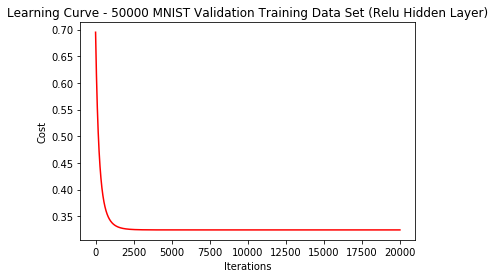

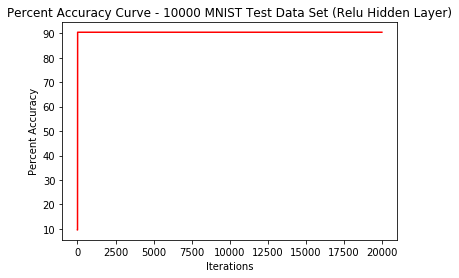

In [8]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01;
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As illustrated the net

The results for the networks with 3 layers line up with what we might intuitively expect. Our cost coverges to around 0.32 and our accuracy remains at a cost 90.39% for most of the iterations. What is probably happening is that have to many layers compared to how much data we have (however, it could also be that it needed to run for significantly more iterations). Therefore, the network is not able accurate classify the test data. It likely remains at approximately 90% accuracy because it is classifying all of the test data as 0, since it does not properly detect 9s. Because approximately 9 out of 10 test images are not 9s, it is only correct approximately 90% of the time. We can confirm that no 9s are predicted by attempting to find one true positive or a false positive. If none are found, then our suspicious is likely confirmed.


Results: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


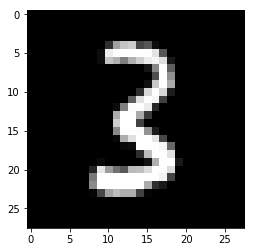

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 3, Size; (1, 28, 28)


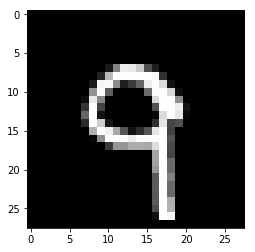

In [9]:
print('')
print('Results: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = _prediction[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[number_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[number_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[number_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[number_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show() 

As illustrated above, no true positive or false positive was found. This means the network never predicted a 9. Therefore, our suspicion is likely confirmed. 

For completeness sake we will also compare the network with 2 hidden layers to a network with 5 hidden layers. This will likely produce the same result.

First we must re-initialize our weights and bias's as a uniform random distribution with the same random seed as before. However, we will specify 5 hidden layers. 

In [255]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 5
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(6,)
(6,)


Now we will re-run our gradient descent.

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 334
Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373


Main Loop Iteration: 662
Main Loop Iteration: 663
Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701


Main Loop Iteration: 991
Main Loop Iteration: 992
Main Loop Iteration: 993
Main Loop Iteration: 994
Main Loop Iteration: 995
Main Loop Iteration: 996
Main Loop Iteration: 997
Main Loop Iteration: 998
Main Loop Iteration: 999
Main Loop Iteration: 1000
Main Loop Iteration: 1001
Main Loop Iteration: 1002
Main Loop Iteration: 1003
Main Loop Iteration: 1004
Main Loop Iteration: 1005
Main Loop Iteration: 1006
Main Loop Iteration: 1007
Main Loop Iteration: 1008
Main Loop Iteration: 1009
Main Loop Iteration: 1010
Main Loop Iteration: 1011
Main Loop Iteration: 1012
Main Loop Iteration: 1013
Main Loop Iteration: 1014
Main Loop Iteration: 1015
Main Loop Iteration: 1016
Main Loop Iteration: 1017
Main Loop Iteration: 1018
Main Loop Iteration: 1019
Main Loop Iteration: 1020
Main Loop Iteration: 1021
Main Loop Iteration: 1022
Main Loop Iteration: 1023
Main Loop Iteration: 1024
Main Loop Iteration: 1025
Main Loop Iteration: 1026
Main Loop Iteration: 1027
Main Loop Iteration: 1028
Main Loop Iteration: 

Main Loop Iteration: 1308
Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop Iteration: 1343
Main Loop Iteration: 1344
Main Loop Iteration: 1345
Main Loop It

Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop Iteration: 1659
Main Loop Iteration: 1660
Main Loop Iteration: 1661
Main Loop Iteration: 1662
Main Loop It

Main Loop Iteration: 1941
Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop Iteration: 1975
Main Loop Iteration: 1976
Main Loop Iteration: 1977
Main Loop Iteration: 1978
Main Loop It

Main Loop Iteration: 2257
Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop Iteration: 2291
Main Loop Iteration: 2292
Main Loop Iteration: 2293
Main Loop Iteration: 2294
Main Loop It

Main Loop Iteration: 2574
Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop Iteration: 2606
Main Loop Iteration: 2607
Main Loop Iteration: 2608
Main Loop Iteration: 2609
Main Loop Iteration: 2610
Main Loop Iteration: 2611
Main Loop It

Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop Iteration: 2922
Main Loop Iteration: 2923
Main Loop Iteration: 2924
Main Loop Iteration: 2925
Main Loop Iteration: 2926
Main Loop Iteration: 2927
Main Loop Iteration: 2928
Main Loop It

Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop Iteration: 3238
Main Loop Iteration: 3239
Main Loop Iteration: 3240
Main Loop Iteration: 3241
Main Loop Iteration: 3242
Main Loop Iteration: 3243
Main Loop Iteration: 3244
Main Loop Iteration: 3245
Main Loop It

Main Loop Iteration: 3840
Main Loop Iteration: 3841
Main Loop Iteration: 3842
Main Loop Iteration: 3843
Main Loop Iteration: 3844
Main Loop Iteration: 3845
Main Loop Iteration: 3846
Main Loop Iteration: 3847
Main Loop Iteration: 3848
Main Loop Iteration: 3849
Main Loop Iteration: 3850
Main Loop Iteration: 3851
Main Loop Iteration: 3852
Main Loop Iteration: 3853
Main Loop Iteration: 3854
Main Loop Iteration: 3855
Main Loop Iteration: 3856
Main Loop Iteration: 3857
Main Loop Iteration: 3858
Main Loop Iteration: 3859
Main Loop Iteration: 3860
Main Loop Iteration: 3861
Main Loop Iteration: 3862
Main Loop Iteration: 3863
Main Loop Iteration: 3864
Main Loop Iteration: 3865
Main Loop Iteration: 3866
Main Loop Iteration: 3867
Main Loop Iteration: 3868
Main Loop Iteration: 3869
Main Loop Iteration: 3870
Main Loop Iteration: 3871
Main Loop Iteration: 3872
Main Loop Iteration: 3873
Main Loop Iteration: 3874
Main Loop Iteration: 3875
Main Loop Iteration: 3876
Main Loop Iteration: 3877
Main Loop It

Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop Iteration: 4186
Main Loop Iteration: 4187
Main Loop Iteration: 4188
Main Loop Iteration: 4189
Main Loop Iteration: 4190
Main Loop Iteration: 4191
Main Loop Iteration: 4192
Main Loop Iteration: 4193
Main Loop It

Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop Iteration: 4502
Main Loop Iteration: 4503
Main Loop Iteration: 4504
Main Loop Iteration: 4505
Main Loop Iteration: 4506
Main Loop Iteration: 4507
Main Loop Iteration: 4508
Main Loop Iteration: 4509
Main Loop Iteration: 4510
Main Loop It

Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop Iteration: 4818
Main Loop Iteration: 4819
Main Loop Iteration: 4820
Main Loop Iteration: 4821
Main Loop Iteration: 4822
Main Loop Iteration: 4823
Main Loop Iteration: 4824
Main Loop Iteration: 4825
Main Loop Iteration: 4826
Main Loop Iteration: 4827
Main Loop It

Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop Iteration: 5134
Main Loop Iteration: 5135
Main Loop Iteration: 5136
Main Loop Iteration: 5137
Main Loop Iteration: 5138
Main Loop Iteration: 5139
Main Loop Iteration: 5140
Main Loop Iteration: 5141
Main Loop Iteration: 5142
Main Loop Iteration: 5143
Main Loop It

Main Loop Iteration: 5422
Main Loop Iteration: 5423
Main Loop Iteration: 5424
Main Loop Iteration: 5425
Main Loop Iteration: 5426
Main Loop Iteration: 5427
Main Loop Iteration: 5428
Main Loop Iteration: 5429
Main Loop Iteration: 5430
Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop Iteration: 5449
Main Loop Iteration: 5450
Main Loop Iteration: 5451
Main Loop Iteration: 5452
Main Loop Iteration: 5453
Main Loop Iteration: 5454
Main Loop Iteration: 5455
Main Loop Iteration: 5456
Main Loop Iteration: 5457
Main Loop Iteration: 5458
Main Loop Iteration: 5459
Main Loop It

Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop Iteration: 5767
Main Loop Iteration: 5768
Main Loop Iteration: 5769
Main Loop Iteration: 5770
Main Loop Iteration: 5771
Main Loop Iteration: 5772
Main Loop Iteration: 5773
Main Loop Iteration: 5774
Main Loop Iteration: 5775
Main Loop It

Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop Iteration: 6081
Main Loop Iteration: 6082
Main Loop Iteration: 6083
Main Loop Iteration: 6084
Main Loop Iteration: 6085
Main Loop Iteration: 6086
Main Loop Iteration: 6087
Main Loop Iteration: 6088
Main Loop Iteration: 6089
Main Loop Iteration: 6090
Main Loop Iteration: 6091
Main Loop It

Main Loop Iteration: 6370
Main Loop Iteration: 6371
Main Loop Iteration: 6372
Main Loop Iteration: 6373
Main Loop Iteration: 6374
Main Loop Iteration: 6375
Main Loop Iteration: 6376
Main Loop Iteration: 6377
Main Loop Iteration: 6378
Main Loop Iteration: 6379
Main Loop Iteration: 6380
Main Loop Iteration: 6381
Main Loop Iteration: 6382
Main Loop Iteration: 6383
Main Loop Iteration: 6384
Main Loop Iteration: 6385
Main Loop Iteration: 6386
Main Loop Iteration: 6387
Main Loop Iteration: 6388
Main Loop Iteration: 6389
Main Loop Iteration: 6390
Main Loop Iteration: 6391
Main Loop Iteration: 6392
Main Loop Iteration: 6393
Main Loop Iteration: 6394
Main Loop Iteration: 6395
Main Loop Iteration: 6396
Main Loop Iteration: 6397
Main Loop Iteration: 6398
Main Loop Iteration: 6399
Main Loop Iteration: 6400
Main Loop Iteration: 6401
Main Loop Iteration: 6402
Main Loop Iteration: 6403
Main Loop Iteration: 6404
Main Loop Iteration: 6405
Main Loop Iteration: 6406
Main Loop Iteration: 6407
Main Loop It

Main Loop Iteration: 6686
Main Loop Iteration: 6687
Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop Iteration: 6713
Main Loop Iteration: 6714
Main Loop Iteration: 6715
Main Loop Iteration: 6716
Main Loop Iteration: 6717
Main Loop Iteration: 6718
Main Loop Iteration: 6719
Main Loop Iteration: 6720
Main Loop Iteration: 6721
Main Loop Iteration: 6722
Main Loop Iteration: 6723
Main Loop It

Main Loop Iteration: 7002
Main Loop Iteration: 7003
Main Loop Iteration: 7004
Main Loop Iteration: 7005
Main Loop Iteration: 7006
Main Loop Iteration: 7007
Main Loop Iteration: 7008
Main Loop Iteration: 7009
Main Loop Iteration: 7010
Main Loop Iteration: 7011
Main Loop Iteration: 7012
Main Loop Iteration: 7013
Main Loop Iteration: 7014
Main Loop Iteration: 7015
Main Loop Iteration: 7016
Main Loop Iteration: 7017
Main Loop Iteration: 7018
Main Loop Iteration: 7019
Main Loop Iteration: 7020
Main Loop Iteration: 7021
Main Loop Iteration: 7022
Main Loop Iteration: 7023
Main Loop Iteration: 7024
Main Loop Iteration: 7025
Main Loop Iteration: 7026
Main Loop Iteration: 7027
Main Loop Iteration: 7028
Main Loop Iteration: 7029
Main Loop Iteration: 7030
Main Loop Iteration: 7031
Main Loop Iteration: 7032
Main Loop Iteration: 7033
Main Loop Iteration: 7034
Main Loop Iteration: 7035
Main Loop Iteration: 7036
Main Loop Iteration: 7037
Main Loop Iteration: 7038
Main Loop Iteration: 7039
Main Loop It

Main Loop Iteration: 7318
Main Loop Iteration: 7319
Main Loop Iteration: 7320
Main Loop Iteration: 7321
Main Loop Iteration: 7322
Main Loop Iteration: 7323
Main Loop Iteration: 7324
Main Loop Iteration: 7325
Main Loop Iteration: 7326
Main Loop Iteration: 7327
Main Loop Iteration: 7328
Main Loop Iteration: 7329
Main Loop Iteration: 7330
Main Loop Iteration: 7331
Main Loop Iteration: 7332
Main Loop Iteration: 7333
Main Loop Iteration: 7334
Main Loop Iteration: 7335
Main Loop Iteration: 7336
Main Loop Iteration: 7337
Main Loop Iteration: 7338
Main Loop Iteration: 7339
Main Loop Iteration: 7340
Main Loop Iteration: 7341
Main Loop Iteration: 7342
Main Loop Iteration: 7343
Main Loop Iteration: 7344
Main Loop Iteration: 7345
Main Loop Iteration: 7346
Main Loop Iteration: 7347
Main Loop Iteration: 7348
Main Loop Iteration: 7349
Main Loop Iteration: 7350
Main Loop Iteration: 7351
Main Loop Iteration: 7352
Main Loop Iteration: 7353
Main Loop Iteration: 7354
Main Loop Iteration: 7355
Main Loop It

Main Loop Iteration: 7634
Main Loop Iteration: 7635
Main Loop Iteration: 7636
Main Loop Iteration: 7637
Main Loop Iteration: 7638
Main Loop Iteration: 7639
Main Loop Iteration: 7640
Main Loop Iteration: 7641
Main Loop Iteration: 7642
Main Loop Iteration: 7643
Main Loop Iteration: 7644
Main Loop Iteration: 7645
Main Loop Iteration: 7646
Main Loop Iteration: 7647
Main Loop Iteration: 7648
Main Loop Iteration: 7649
Main Loop Iteration: 7650
Main Loop Iteration: 7651
Main Loop Iteration: 7652
Main Loop Iteration: 7653
Main Loop Iteration: 7654
Main Loop Iteration: 7655
Main Loop Iteration: 7656
Main Loop Iteration: 7657
Main Loop Iteration: 7658
Main Loop Iteration: 7659
Main Loop Iteration: 7660
Main Loop Iteration: 7661
Main Loop Iteration: 7662
Main Loop Iteration: 7663
Main Loop Iteration: 7664
Main Loop Iteration: 7665
Main Loop Iteration: 7666
Main Loop Iteration: 7667
Main Loop Iteration: 7668
Main Loop Iteration: 7669
Main Loop Iteration: 7670
Main Loop Iteration: 7671
Main Loop It

Main Loop Iteration: 7950
Main Loop Iteration: 7951
Main Loop Iteration: 7952
Main Loop Iteration: 7953
Main Loop Iteration: 7954
Main Loop Iteration: 7955
Main Loop Iteration: 7956
Main Loop Iteration: 7957
Main Loop Iteration: 7958
Main Loop Iteration: 7959
Main Loop Iteration: 7960
Main Loop Iteration: 7961
Main Loop Iteration: 7962
Main Loop Iteration: 7963
Main Loop Iteration: 7964
Main Loop Iteration: 7965
Main Loop Iteration: 7966
Main Loop Iteration: 7967
Main Loop Iteration: 7968
Main Loop Iteration: 7969
Main Loop Iteration: 7970
Main Loop Iteration: 7971
Main Loop Iteration: 7972
Main Loop Iteration: 7973
Main Loop Iteration: 7974
Main Loop Iteration: 7975
Main Loop Iteration: 7976
Main Loop Iteration: 7977
Main Loop Iteration: 7978
Main Loop Iteration: 7979
Main Loop Iteration: 7980
Main Loop Iteration: 7981
Main Loop Iteration: 7982
Main Loop Iteration: 7983
Main Loop Iteration: 7984
Main Loop Iteration: 7985
Main Loop Iteration: 7986
Main Loop Iteration: 7987
Main Loop It

Main Loop Iteration: 8266
Main Loop Iteration: 8267
Main Loop Iteration: 8268
Main Loop Iteration: 8269
Main Loop Iteration: 8270
Main Loop Iteration: 8271
Main Loop Iteration: 8272
Main Loop Iteration: 8273
Main Loop Iteration: 8274
Main Loop Iteration: 8275
Main Loop Iteration: 8276
Main Loop Iteration: 8277
Main Loop Iteration: 8278
Main Loop Iteration: 8279
Main Loop Iteration: 8280
Main Loop Iteration: 8281
Main Loop Iteration: 8282
Main Loop Iteration: 8283
Main Loop Iteration: 8284
Main Loop Iteration: 8285
Main Loop Iteration: 8286
Main Loop Iteration: 8287
Main Loop Iteration: 8288
Main Loop Iteration: 8289
Main Loop Iteration: 8290
Main Loop Iteration: 8291
Main Loop Iteration: 8292
Main Loop Iteration: 8293
Main Loop Iteration: 8294
Main Loop Iteration: 8295
Main Loop Iteration: 8296
Main Loop Iteration: 8297
Main Loop Iteration: 8298
Main Loop Iteration: 8299
Main Loop Iteration: 8300
Main Loop Iteration: 8301
Main Loop Iteration: 8302
Main Loop Iteration: 8303
Main Loop It

Main Loop Iteration: 8582
Main Loop Iteration: 8583
Main Loop Iteration: 8584
Main Loop Iteration: 8585
Main Loop Iteration: 8586
Main Loop Iteration: 8587
Main Loop Iteration: 8588
Main Loop Iteration: 8589
Main Loop Iteration: 8590
Main Loop Iteration: 8591
Main Loop Iteration: 8592
Main Loop Iteration: 8593
Main Loop Iteration: 8594
Main Loop Iteration: 8595
Main Loop Iteration: 8596
Main Loop Iteration: 8597
Main Loop Iteration: 8598
Main Loop Iteration: 8599
Main Loop Iteration: 8600
Main Loop Iteration: 8601
Main Loop Iteration: 8602
Main Loop Iteration: 8603
Main Loop Iteration: 8604
Main Loop Iteration: 8605
Main Loop Iteration: 8606
Main Loop Iteration: 8607
Main Loop Iteration: 8608
Main Loop Iteration: 8609
Main Loop Iteration: 8610
Main Loop Iteration: 8611
Main Loop Iteration: 8612
Main Loop Iteration: 8613
Main Loop Iteration: 8614
Main Loop Iteration: 8615
Main Loop Iteration: 8616
Main Loop Iteration: 8617
Main Loop Iteration: 8618
Main Loop Iteration: 8619
Main Loop It

Main Loop Iteration: 8898
Main Loop Iteration: 8899
Main Loop Iteration: 8900
Main Loop Iteration: 8901
Main Loop Iteration: 8902
Main Loop Iteration: 8903
Main Loop Iteration: 8904
Main Loop Iteration: 8905
Main Loop Iteration: 8906
Main Loop Iteration: 8907
Main Loop Iteration: 8908
Main Loop Iteration: 8909
Main Loop Iteration: 8910
Main Loop Iteration: 8911
Main Loop Iteration: 8912
Main Loop Iteration: 8913
Main Loop Iteration: 8914
Main Loop Iteration: 8915
Main Loop Iteration: 8916
Main Loop Iteration: 8917
Main Loop Iteration: 8918
Main Loop Iteration: 8919
Main Loop Iteration: 8920
Main Loop Iteration: 8921
Main Loop Iteration: 8922
Main Loop Iteration: 8923
Main Loop Iteration: 8924
Main Loop Iteration: 8925
Main Loop Iteration: 8926
Main Loop Iteration: 8927
Main Loop Iteration: 8928
Main Loop Iteration: 8929
Main Loop Iteration: 8930
Main Loop Iteration: 8931
Main Loop Iteration: 8932
Main Loop Iteration: 8933
Main Loop Iteration: 8934
Main Loop Iteration: 8935
Main Loop It

Main Loop Iteration: 9214
Main Loop Iteration: 9215
Main Loop Iteration: 9216
Main Loop Iteration: 9217
Main Loop Iteration: 9218
Main Loop Iteration: 9219
Main Loop Iteration: 9220
Main Loop Iteration: 9221
Main Loop Iteration: 9222
Main Loop Iteration: 9223
Main Loop Iteration: 9224
Main Loop Iteration: 9225
Main Loop Iteration: 9226
Main Loop Iteration: 9227
Main Loop Iteration: 9228
Main Loop Iteration: 9229
Main Loop Iteration: 9230
Main Loop Iteration: 9231
Main Loop Iteration: 9232
Main Loop Iteration: 9233
Main Loop Iteration: 9234
Main Loop Iteration: 9235
Main Loop Iteration: 9236
Main Loop Iteration: 9237
Main Loop Iteration: 9238
Main Loop Iteration: 9239
Main Loop Iteration: 9240
Main Loop Iteration: 9241
Main Loop Iteration: 9242
Main Loop Iteration: 9243
Main Loop Iteration: 9244
Main Loop Iteration: 9245
Main Loop Iteration: 9246
Main Loop Iteration: 9247
Main Loop Iteration: 9248
Main Loop Iteration: 9249
Main Loop Iteration: 9250
Main Loop Iteration: 9251
Main Loop It

Main Loop Iteration: 9530
Main Loop Iteration: 9531
Main Loop Iteration: 9532
Main Loop Iteration: 9533
Main Loop Iteration: 9534
Main Loop Iteration: 9535
Main Loop Iteration: 9536
Main Loop Iteration: 9537
Main Loop Iteration: 9538
Main Loop Iteration: 9539
Main Loop Iteration: 9540
Main Loop Iteration: 9541
Main Loop Iteration: 9542
Main Loop Iteration: 9543
Main Loop Iteration: 9544
Main Loop Iteration: 9545
Main Loop Iteration: 9546
Main Loop Iteration: 9547
Main Loop Iteration: 9548
Main Loop Iteration: 9549
Main Loop Iteration: 9550
Main Loop Iteration: 9551
Main Loop Iteration: 9552
Main Loop Iteration: 9553
Main Loop Iteration: 9554
Main Loop Iteration: 9555
Main Loop Iteration: 9556
Main Loop Iteration: 9557
Main Loop Iteration: 9558
Main Loop Iteration: 9559
Main Loop Iteration: 9560
Main Loop Iteration: 9561
Main Loop Iteration: 9562
Main Loop Iteration: 9563
Main Loop Iteration: 9564
Main Loop Iteration: 9565
Main Loop Iteration: 9566
Main Loop Iteration: 9567
Main Loop It

Main Loop Iteration: 9846
Main Loop Iteration: 9847
Main Loop Iteration: 9848
Main Loop Iteration: 9849
Main Loop Iteration: 9850
Main Loop Iteration: 9851
Main Loop Iteration: 9852
Main Loop Iteration: 9853
Main Loop Iteration: 9854
Main Loop Iteration: 9855
Main Loop Iteration: 9856
Main Loop Iteration: 9857
Main Loop Iteration: 9858
Main Loop Iteration: 9859
Main Loop Iteration: 9860
Main Loop Iteration: 9861
Main Loop Iteration: 9862
Main Loop Iteration: 9863
Main Loop Iteration: 9864
Main Loop Iteration: 9865
Main Loop Iteration: 9866
Main Loop Iteration: 9867
Main Loop Iteration: 9868
Main Loop Iteration: 9869
Main Loop Iteration: 9870
Main Loop Iteration: 9871
Main Loop Iteration: 9872
Main Loop Iteration: 9873
Main Loop Iteration: 9874
Main Loop Iteration: 9875
Main Loop Iteration: 9876
Main Loop Iteration: 9877
Main Loop Iteration: 9878
Main Loop Iteration: 9879
Main Loop Iteration: 9880
Main Loop Iteration: 9881
Main Loop Iteration: 9882
Main Loop Iteration: 9883
Main Loop It

Main Loop Iteration: 10156
Main Loop Iteration: 10157
Main Loop Iteration: 10158
Main Loop Iteration: 10159
Main Loop Iteration: 10160
Main Loop Iteration: 10161
Main Loop Iteration: 10162
Main Loop Iteration: 10163
Main Loop Iteration: 10164
Main Loop Iteration: 10165
Main Loop Iteration: 10166
Main Loop Iteration: 10167
Main Loop Iteration: 10168
Main Loop Iteration: 10169
Main Loop Iteration: 10170
Main Loop Iteration: 10171
Main Loop Iteration: 10172
Main Loop Iteration: 10173
Main Loop Iteration: 10174
Main Loop Iteration: 10175
Main Loop Iteration: 10176
Main Loop Iteration: 10177
Main Loop Iteration: 10178
Main Loop Iteration: 10179
Main Loop Iteration: 10180
Main Loop Iteration: 10181
Main Loop Iteration: 10182
Main Loop Iteration: 10183
Main Loop Iteration: 10184
Main Loop Iteration: 10185
Main Loop Iteration: 10186
Main Loop Iteration: 10187
Main Loop Iteration: 10188
Main Loop Iteration: 10189
Main Loop Iteration: 10190
Main Loop Iteration: 10191
Main Loop Iteration: 10192
M

Main Loop Iteration: 10460
Main Loop Iteration: 10461
Main Loop Iteration: 10462
Main Loop Iteration: 10463
Main Loop Iteration: 10464
Main Loop Iteration: 10465
Main Loop Iteration: 10466
Main Loop Iteration: 10467
Main Loop Iteration: 10468
Main Loop Iteration: 10469
Main Loop Iteration: 10470
Main Loop Iteration: 10471
Main Loop Iteration: 10472
Main Loop Iteration: 10473
Main Loop Iteration: 10474
Main Loop Iteration: 10475
Main Loop Iteration: 10476
Main Loop Iteration: 10477
Main Loop Iteration: 10478
Main Loop Iteration: 10479
Main Loop Iteration: 10480
Main Loop Iteration: 10481
Main Loop Iteration: 10482
Main Loop Iteration: 10483
Main Loop Iteration: 10484
Main Loop Iteration: 10485
Main Loop Iteration: 10486
Main Loop Iteration: 10487
Main Loop Iteration: 10488
Main Loop Iteration: 10489
Main Loop Iteration: 10490
Main Loop Iteration: 10491
Main Loop Iteration: 10492
Main Loop Iteration: 10493
Main Loop Iteration: 10494
Main Loop Iteration: 10495
Main Loop Iteration: 10496
M

Main Loop Iteration: 10764
Main Loop Iteration: 10765
Main Loop Iteration: 10766
Main Loop Iteration: 10767
Main Loop Iteration: 10768
Main Loop Iteration: 10769
Main Loop Iteration: 10770
Main Loop Iteration: 10771
Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
Main Loop Iteration: 10781
Main Loop Iteration: 10782
Main Loop Iteration: 10783
Main Loop Iteration: 10784
Main Loop Iteration: 10785
Main Loop Iteration: 10786
Main Loop Iteration: 10787
Main Loop Iteration: 10788
Main Loop Iteration: 10789
Main Loop Iteration: 10790
Main Loop Iteration: 10791
Main Loop Iteration: 10792
Main Loop Iteration: 10793
Main Loop Iteration: 10794
Main Loop Iteration: 10795
Main Loop Iteration: 10796
Main Loop Iteration: 10797
Main Loop Iteration: 10798
Main Loop Iteration: 10799
Main Loop Iteration: 10800
M

Main Loop Iteration: 11068
Main Loop Iteration: 11069
Main Loop Iteration: 11070
Main Loop Iteration: 11071
Main Loop Iteration: 11072
Main Loop Iteration: 11073
Main Loop Iteration: 11074
Main Loop Iteration: 11075
Main Loop Iteration: 11076
Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
Main Loop Iteration: 11090
Main Loop Iteration: 11091
Main Loop Iteration: 11092
Main Loop Iteration: 11093
Main Loop Iteration: 11094
Main Loop Iteration: 11095
Main Loop Iteration: 11096
Main Loop Iteration: 11097
Main Loop Iteration: 11098
Main Loop Iteration: 11099
Main Loop Iteration: 11100
Main Loop Iteration: 11101
Main Loop Iteration: 11102
Main Loop Iteration: 11103
Main Loop Iteration: 11104
M

Main Loop Iteration: 11372
Main Loop Iteration: 11373
Main Loop Iteration: 11374
Main Loop Iteration: 11375
Main Loop Iteration: 11376
Main Loop Iteration: 11377
Main Loop Iteration: 11378
Main Loop Iteration: 11379
Main Loop Iteration: 11380
Main Loop Iteration: 11381
Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
Main Loop Iteration: 11395
Main Loop Iteration: 11396
Main Loop Iteration: 11397
Main Loop Iteration: 11398
Main Loop Iteration: 11399
Main Loop Iteration: 11400
Main Loop Iteration: 11401
Main Loop Iteration: 11402
Main Loop Iteration: 11403
Main Loop Iteration: 11404
Main Loop Iteration: 11405
Main Loop Iteration: 11406
Main Loop Iteration: 11407
Main Loop Iteration: 11408
M

Main Loop Iteration: 11676
Main Loop Iteration: 11677
Main Loop Iteration: 11678
Main Loop Iteration: 11679
Main Loop Iteration: 11680
Main Loop Iteration: 11681
Main Loop Iteration: 11682
Main Loop Iteration: 11683
Main Loop Iteration: 11684
Main Loop Iteration: 11685
Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
Main Loop Iteration: 11698
Main Loop Iteration: 11699
Main Loop Iteration: 11700
Main Loop Iteration: 11701
Main Loop Iteration: 11702
Main Loop Iteration: 11703
Main Loop Iteration: 11704
Main Loop Iteration: 11705
Main Loop Iteration: 11706
Main Loop Iteration: 11707
Main Loop Iteration: 11708
Main Loop Iteration: 11709
Main Loop Iteration: 11710
Main Loop Iteration: 11711
Main Loop Iteration: 11712
M

Main Loop Iteration: 11980
Main Loop Iteration: 11981
Main Loop Iteration: 11982
Main Loop Iteration: 11983
Main Loop Iteration: 11984
Main Loop Iteration: 11985
Main Loop Iteration: 11986
Main Loop Iteration: 11987
Main Loop Iteration: 11988
Main Loop Iteration: 11989
Main Loop Iteration: 11990
Main Loop Iteration: 11991
Main Loop Iteration: 11992
Main Loop Iteration: 11993
Main Loop Iteration: 11994
Main Loop Iteration: 11995
Main Loop Iteration: 11996
Main Loop Iteration: 11997
Main Loop Iteration: 11998
Main Loop Iteration: 11999
Main Loop Iteration: 12000
Main Loop Iteration: 12001
Main Loop Iteration: 12002
Main Loop Iteration: 12003
Main Loop Iteration: 12004
Main Loop Iteration: 12005
Main Loop Iteration: 12006
Main Loop Iteration: 12007
Main Loop Iteration: 12008
Main Loop Iteration: 12009
Main Loop Iteration: 12010
Main Loop Iteration: 12011
Main Loop Iteration: 12012
Main Loop Iteration: 12013
Main Loop Iteration: 12014
Main Loop Iteration: 12015
Main Loop Iteration: 12016
M

Main Loop Iteration: 12284
Main Loop Iteration: 12285
Main Loop Iteration: 12286
Main Loop Iteration: 12287
Main Loop Iteration: 12288
Main Loop Iteration: 12289
Main Loop Iteration: 12290
Main Loop Iteration: 12291
Main Loop Iteration: 12292
Main Loop Iteration: 12293
Main Loop Iteration: 12294
Main Loop Iteration: 12295
Main Loop Iteration: 12296
Main Loop Iteration: 12297
Main Loop Iteration: 12298
Main Loop Iteration: 12299
Main Loop Iteration: 12300
Main Loop Iteration: 12301
Main Loop Iteration: 12302
Main Loop Iteration: 12303
Main Loop Iteration: 12304
Main Loop Iteration: 12305
Main Loop Iteration: 12306
Main Loop Iteration: 12307
Main Loop Iteration: 12308
Main Loop Iteration: 12309
Main Loop Iteration: 12310
Main Loop Iteration: 12311
Main Loop Iteration: 12312
Main Loop Iteration: 12313
Main Loop Iteration: 12314
Main Loop Iteration: 12315
Main Loop Iteration: 12316
Main Loop Iteration: 12317
Main Loop Iteration: 12318
Main Loop Iteration: 12319
Main Loop Iteration: 12320
M

Main Loop Iteration: 12588
Main Loop Iteration: 12589
Main Loop Iteration: 12590
Main Loop Iteration: 12591
Main Loop Iteration: 12592
Main Loop Iteration: 12593
Main Loop Iteration: 12594
Main Loop Iteration: 12595
Main Loop Iteration: 12596
Main Loop Iteration: 12597
Main Loop Iteration: 12598
Main Loop Iteration: 12599
Main Loop Iteration: 12600
Main Loop Iteration: 12601
Main Loop Iteration: 12602
Main Loop Iteration: 12603
Main Loop Iteration: 12604
Main Loop Iteration: 12605
Main Loop Iteration: 12606
Main Loop Iteration: 12607
Main Loop Iteration: 12608
Main Loop Iteration: 12609
Main Loop Iteration: 12610
Main Loop Iteration: 12611
Main Loop Iteration: 12612
Main Loop Iteration: 12613
Main Loop Iteration: 12614
Main Loop Iteration: 12615
Main Loop Iteration: 12616
Main Loop Iteration: 12617
Main Loop Iteration: 12618
Main Loop Iteration: 12619
Main Loop Iteration: 12620
Main Loop Iteration: 12621
Main Loop Iteration: 12622
Main Loop Iteration: 12623
Main Loop Iteration: 12624
M

Main Loop Iteration: 12892
Main Loop Iteration: 12893
Main Loop Iteration: 12894
Main Loop Iteration: 12895
Main Loop Iteration: 12896
Main Loop Iteration: 12897
Main Loop Iteration: 12898
Main Loop Iteration: 12899
Main Loop Iteration: 12900
Main Loop Iteration: 12901
Main Loop Iteration: 12902
Main Loop Iteration: 12903
Main Loop Iteration: 12904
Main Loop Iteration: 12905
Main Loop Iteration: 12906
Main Loop Iteration: 12907
Main Loop Iteration: 12908
Main Loop Iteration: 12909
Main Loop Iteration: 12910
Main Loop Iteration: 12911
Main Loop Iteration: 12912
Main Loop Iteration: 12913
Main Loop Iteration: 12914
Main Loop Iteration: 12915
Main Loop Iteration: 12916
Main Loop Iteration: 12917
Main Loop Iteration: 12918
Main Loop Iteration: 12919
Main Loop Iteration: 12920
Main Loop Iteration: 12921
Main Loop Iteration: 12922
Main Loop Iteration: 12923
Main Loop Iteration: 12924
Main Loop Iteration: 12925
Main Loop Iteration: 12926
Main Loop Iteration: 12927
Main Loop Iteration: 12928
M

Main Loop Iteration: 13196
Main Loop Iteration: 13197
Main Loop Iteration: 13198
Main Loop Iteration: 13199
Main Loop Iteration: 13200
Main Loop Iteration: 13201
Main Loop Iteration: 13202
Main Loop Iteration: 13203
Main Loop Iteration: 13204
Main Loop Iteration: 13205
Main Loop Iteration: 13206
Main Loop Iteration: 13207
Main Loop Iteration: 13208
Main Loop Iteration: 13209
Main Loop Iteration: 13210
Main Loop Iteration: 13211
Main Loop Iteration: 13212
Main Loop Iteration: 13213
Main Loop Iteration: 13214
Main Loop Iteration: 13215
Main Loop Iteration: 13216
Main Loop Iteration: 13217
Main Loop Iteration: 13218
Main Loop Iteration: 13219
Main Loop Iteration: 13220
Main Loop Iteration: 13221
Main Loop Iteration: 13222
Main Loop Iteration: 13223
Main Loop Iteration: 13224
Main Loop Iteration: 13225
Main Loop Iteration: 13226
Main Loop Iteration: 13227
Main Loop Iteration: 13228
Main Loop Iteration: 13229
Main Loop Iteration: 13230
Main Loop Iteration: 13231
Main Loop Iteration: 13232
M

Main Loop Iteration: 13500
Main Loop Iteration: 13501
Main Loop Iteration: 13502
Main Loop Iteration: 13503
Main Loop Iteration: 13504
Main Loop Iteration: 13505
Main Loop Iteration: 13506
Main Loop Iteration: 13507
Main Loop Iteration: 13508
Main Loop Iteration: 13509
Main Loop Iteration: 13510
Main Loop Iteration: 13511
Main Loop Iteration: 13512
Main Loop Iteration: 13513
Main Loop Iteration: 13514
Main Loop Iteration: 13515
Main Loop Iteration: 13516
Main Loop Iteration: 13517
Main Loop Iteration: 13518
Main Loop Iteration: 13519
Main Loop Iteration: 13520
Main Loop Iteration: 13521
Main Loop Iteration: 13522
Main Loop Iteration: 13523
Main Loop Iteration: 13524
Main Loop Iteration: 13525
Main Loop Iteration: 13526
Main Loop Iteration: 13527
Main Loop Iteration: 13528
Main Loop Iteration: 13529
Main Loop Iteration: 13530
Main Loop Iteration: 13531
Main Loop Iteration: 13532
Main Loop Iteration: 13533
Main Loop Iteration: 13534
Main Loop Iteration: 13535
Main Loop Iteration: 13536
M

Main Loop Iteration: 13804
Main Loop Iteration: 13805
Main Loop Iteration: 13806
Main Loop Iteration: 13807
Main Loop Iteration: 13808
Main Loop Iteration: 13809
Main Loop Iteration: 13810
Main Loop Iteration: 13811
Main Loop Iteration: 13812
Main Loop Iteration: 13813
Main Loop Iteration: 13814
Main Loop Iteration: 13815
Main Loop Iteration: 13816
Main Loop Iteration: 13817
Main Loop Iteration: 13818
Main Loop Iteration: 13819
Main Loop Iteration: 13820
Main Loop Iteration: 13821
Main Loop Iteration: 13822
Main Loop Iteration: 13823
Main Loop Iteration: 13824
Main Loop Iteration: 13825
Main Loop Iteration: 13826
Main Loop Iteration: 13827
Main Loop Iteration: 13828
Main Loop Iteration: 13829
Main Loop Iteration: 13830
Main Loop Iteration: 13831
Main Loop Iteration: 13832
Main Loop Iteration: 13833
Main Loop Iteration: 13834
Main Loop Iteration: 13835
Main Loop Iteration: 13836
Main Loop Iteration: 13837
Main Loop Iteration: 13838
Main Loop Iteration: 13839
Main Loop Iteration: 13840
M

Main Loop Iteration: 14108
Main Loop Iteration: 14109
Main Loop Iteration: 14110
Main Loop Iteration: 14111
Main Loop Iteration: 14112
Main Loop Iteration: 14113
Main Loop Iteration: 14114
Main Loop Iteration: 14115
Main Loop Iteration: 14116
Main Loop Iteration: 14117
Main Loop Iteration: 14118
Main Loop Iteration: 14119
Main Loop Iteration: 14120
Main Loop Iteration: 14121
Main Loop Iteration: 14122
Main Loop Iteration: 14123
Main Loop Iteration: 14124
Main Loop Iteration: 14125
Main Loop Iteration: 14126
Main Loop Iteration: 14127
Main Loop Iteration: 14128
Main Loop Iteration: 14129
Main Loop Iteration: 14130
Main Loop Iteration: 14131
Main Loop Iteration: 14132
Main Loop Iteration: 14133
Main Loop Iteration: 14134
Main Loop Iteration: 14135
Main Loop Iteration: 14136
Main Loop Iteration: 14137
Main Loop Iteration: 14138
Main Loop Iteration: 14139
Main Loop Iteration: 14140
Main Loop Iteration: 14141
Main Loop Iteration: 14142
Main Loop Iteration: 14143
Main Loop Iteration: 14144
M

Main Loop Iteration: 14714
Main Loop Iteration: 14715
Main Loop Iteration: 14716
Main Loop Iteration: 14717
Main Loop Iteration: 14718
Main Loop Iteration: 14719
Main Loop Iteration: 14720
Main Loop Iteration: 14721
Main Loop Iteration: 14722
Main Loop Iteration: 14723
Main Loop Iteration: 14724
Main Loop Iteration: 14725
Main Loop Iteration: 14726
Main Loop Iteration: 14727
Main Loop Iteration: 14728
Main Loop Iteration: 14729
Main Loop Iteration: 14730
Main Loop Iteration: 14731
Main Loop Iteration: 14732
Main Loop Iteration: 14733
Main Loop Iteration: 14734
Main Loop Iteration: 14735
Main Loop Iteration: 14736
Main Loop Iteration: 14737
Main Loop Iteration: 14738
Main Loop Iteration: 14739
Main Loop Iteration: 14740
Main Loop Iteration: 14741
Main Loop Iteration: 14742
Main Loop Iteration: 14743
Main Loop Iteration: 14744
Main Loop Iteration: 14745
Main Loop Iteration: 14746
Main Loop Iteration: 14747
Main Loop Iteration: 14748
Main Loop Iteration: 14749
Main Loop Iteration: 14750
M

Main Loop Iteration: 15018
Main Loop Iteration: 15019
Main Loop Iteration: 15020
Main Loop Iteration: 15021
Main Loop Iteration: 15022
Main Loop Iteration: 15023
Main Loop Iteration: 15024
Main Loop Iteration: 15025
Main Loop Iteration: 15026
Main Loop Iteration: 15027
Main Loop Iteration: 15028
Main Loop Iteration: 15029
Main Loop Iteration: 15030
Main Loop Iteration: 15031
Main Loop Iteration: 15032
Main Loop Iteration: 15033
Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
Main Loop Iteration: 15041
Main Loop Iteration: 15042
Main Loop Iteration: 15043
Main Loop Iteration: 15044
Main Loop Iteration: 15045
Main Loop Iteration: 15046
Main Loop Iteration: 15047
Main Loop Iteration: 15048
Main Loop Iteration: 15049
Main Loop Iteration: 15050
Main Loop Iteration: 15051
Main Loop Iteration: 15052
Main Loop Iteration: 15053
Main Loop Iteration: 15054
M

Main Loop Iteration: 15624
Main Loop Iteration: 15625
Main Loop Iteration: 15626
Main Loop Iteration: 15627
Main Loop Iteration: 15628
Main Loop Iteration: 15629
Main Loop Iteration: 15630
Main Loop Iteration: 15631
Main Loop Iteration: 15632
Main Loop Iteration: 15633
Main Loop Iteration: 15634
Main Loop Iteration: 15635
Main Loop Iteration: 15636
Main Loop Iteration: 15637
Main Loop Iteration: 15638
Main Loop Iteration: 15639
Main Loop Iteration: 15640
Main Loop Iteration: 15641
Main Loop Iteration: 15642
Main Loop Iteration: 15643
Main Loop Iteration: 15644
Main Loop Iteration: 15645
Main Loop Iteration: 15646
Main Loop Iteration: 15647
Main Loop Iteration: 15648
Main Loop Iteration: 15649
Main Loop Iteration: 15650
Main Loop Iteration: 15651
Main Loop Iteration: 15652
Main Loop Iteration: 15653
Main Loop Iteration: 15654
Main Loop Iteration: 15655
Main Loop Iteration: 15656
Main Loop Iteration: 15657
Main Loop Iteration: 15658
Main Loop Iteration: 15659
Main Loop Iteration: 15660
M

Main Loop Iteration: 15928
Main Loop Iteration: 15929
Main Loop Iteration: 15930
Main Loop Iteration: 15931
Main Loop Iteration: 15932
Main Loop Iteration: 15933
Main Loop Iteration: 15934
Main Loop Iteration: 15935
Main Loop Iteration: 15936
Main Loop Iteration: 15937
Main Loop Iteration: 15938
Main Loop Iteration: 15939
Main Loop Iteration: 15940
Main Loop Iteration: 15941
Main Loop Iteration: 15942
Main Loop Iteration: 15943
Main Loop Iteration: 15944
Main Loop Iteration: 15945
Main Loop Iteration: 15946
Main Loop Iteration: 15947
Main Loop Iteration: 15948
Main Loop Iteration: 15949
Main Loop Iteration: 15950
Main Loop Iteration: 15951
Main Loop Iteration: 15952
Main Loop Iteration: 15953
Main Loop Iteration: 15954
Main Loop Iteration: 15955
Main Loop Iteration: 15956
Main Loop Iteration: 15957
Main Loop Iteration: 15958
Main Loop Iteration: 15959
Main Loop Iteration: 15960
Main Loop Iteration: 15961
Main Loop Iteration: 15962
Main Loop Iteration: 15963
Main Loop Iteration: 15964
M

Main Loop Iteration: 16535
Main Loop Iteration: 16536
Main Loop Iteration: 16537
Main Loop Iteration: 16538
Main Loop Iteration: 16539
Main Loop Iteration: 16540
Main Loop Iteration: 16541
Main Loop Iteration: 16542
Main Loop Iteration: 16543
Main Loop Iteration: 16544
Main Loop Iteration: 16545
Main Loop Iteration: 16546
Main Loop Iteration: 16547
Main Loop Iteration: 16548
Main Loop Iteration: 16549
Main Loop Iteration: 16550
Main Loop Iteration: 16551
Main Loop Iteration: 16552
Main Loop Iteration: 16553
Main Loop Iteration: 16554
Main Loop Iteration: 16555
Main Loop Iteration: 16556
Main Loop Iteration: 16557
Main Loop Iteration: 16558
Main Loop Iteration: 16559
Main Loop Iteration: 16560
Main Loop Iteration: 16561
Main Loop Iteration: 16562
Main Loop Iteration: 16563
Main Loop Iteration: 16564
Main Loop Iteration: 16565
Main Loop Iteration: 16566
Main Loop Iteration: 16567
Main Loop Iteration: 16568
Main Loop Iteration: 16569
Main Loop Iteration: 16570
Main Loop Iteration: 16571
M

Main Loop Iteration: 17141
Main Loop Iteration: 17142
Main Loop Iteration: 17143
Main Loop Iteration: 17144
Main Loop Iteration: 17145
Main Loop Iteration: 17146
Main Loop Iteration: 17147
Main Loop Iteration: 17148
Main Loop Iteration: 17149
Main Loop Iteration: 17150
Main Loop Iteration: 17151
Main Loop Iteration: 17152
Main Loop Iteration: 17153
Main Loop Iteration: 17154
Main Loop Iteration: 17155
Main Loop Iteration: 17156
Main Loop Iteration: 17157
Main Loop Iteration: 17158
Main Loop Iteration: 17159
Main Loop Iteration: 17160
Main Loop Iteration: 17161
Main Loop Iteration: 17162
Main Loop Iteration: 17163
Main Loop Iteration: 17164
Main Loop Iteration: 17165
Main Loop Iteration: 17166
Main Loop Iteration: 17167
Main Loop Iteration: 17168
Main Loop Iteration: 17169
Main Loop Iteration: 17170
Main Loop Iteration: 17171
Main Loop Iteration: 17172
Main Loop Iteration: 17173
Main Loop Iteration: 17174
Main Loop Iteration: 17175
Main Loop Iteration: 17176
Main Loop Iteration: 17177
M

Main Loop Iteration: 17747
Main Loop Iteration: 17748
Main Loop Iteration: 17749
Main Loop Iteration: 17750
Main Loop Iteration: 17751
Main Loop Iteration: 17752
Main Loop Iteration: 17753
Main Loop Iteration: 17754
Main Loop Iteration: 17755
Main Loop Iteration: 17756
Main Loop Iteration: 17757
Main Loop Iteration: 17758
Main Loop Iteration: 17759
Main Loop Iteration: 17760
Main Loop Iteration: 17761
Main Loop Iteration: 17762
Main Loop Iteration: 17763
Main Loop Iteration: 17764
Main Loop Iteration: 17765
Main Loop Iteration: 17766
Main Loop Iteration: 17767
Main Loop Iteration: 17768
Main Loop Iteration: 17769
Main Loop Iteration: 17770
Main Loop Iteration: 17771
Main Loop Iteration: 17772
Main Loop Iteration: 17773
Main Loop Iteration: 17774
Main Loop Iteration: 17775
Main Loop Iteration: 17776
Main Loop Iteration: 17777
Main Loop Iteration: 17778
Main Loop Iteration: 17779
Main Loop Iteration: 17780
Main Loop Iteration: 17781
Main Loop Iteration: 17782
Main Loop Iteration: 17783
M

Main Loop Iteration: 18051
Main Loop Iteration: 18052
Main Loop Iteration: 18053
Main Loop Iteration: 18054
Main Loop Iteration: 18055
Main Loop Iteration: 18056
Main Loop Iteration: 18057
Main Loop Iteration: 18058
Main Loop Iteration: 18059
Main Loop Iteration: 18060
Main Loop Iteration: 18061
Main Loop Iteration: 18062
Main Loop Iteration: 18063
Main Loop Iteration: 18064
Main Loop Iteration: 18065
Main Loop Iteration: 18066
Main Loop Iteration: 18067
Main Loop Iteration: 18068
Main Loop Iteration: 18069
Main Loop Iteration: 18070
Main Loop Iteration: 18071
Main Loop Iteration: 18072
Main Loop Iteration: 18073
Main Loop Iteration: 18074
Main Loop Iteration: 18075
Main Loop Iteration: 18076
Main Loop Iteration: 18077
Main Loop Iteration: 18078
Main Loop Iteration: 18079
Main Loop Iteration: 18080
Main Loop Iteration: 18081
Main Loop Iteration: 18082
Main Loop Iteration: 18083
Main Loop Iteration: 18084
Main Loop Iteration: 18085
Main Loop Iteration: 18086
Main Loop Iteration: 18087
M

Main Loop Iteration: 18657
Main Loop Iteration: 18658
Main Loop Iteration: 18659
Main Loop Iteration: 18660
Main Loop Iteration: 18661
Main Loop Iteration: 18662
Main Loop Iteration: 18663
Main Loop Iteration: 18664
Main Loop Iteration: 18665
Main Loop Iteration: 18666
Main Loop Iteration: 18667
Main Loop Iteration: 18668
Main Loop Iteration: 18669
Main Loop Iteration: 18670
Main Loop Iteration: 18671
Main Loop Iteration: 18672
Main Loop Iteration: 18673
Main Loop Iteration: 18674
Main Loop Iteration: 18675
Main Loop Iteration: 18676
Main Loop Iteration: 18677
Main Loop Iteration: 18678
Main Loop Iteration: 18679
Main Loop Iteration: 18680
Main Loop Iteration: 18681
Main Loop Iteration: 18682
Main Loop Iteration: 18683
Main Loop Iteration: 18684
Main Loop Iteration: 18685
Main Loop Iteration: 18686
Main Loop Iteration: 18687
Main Loop Iteration: 18688
Main Loop Iteration: 18689
Main Loop Iteration: 18690
Main Loop Iteration: 18691
Main Loop Iteration: 18692
Main Loop Iteration: 18693
M

Main Loop Iteration: 18961
Main Loop Iteration: 18962
Main Loop Iteration: 18963
Main Loop Iteration: 18964
Main Loop Iteration: 18965
Main Loop Iteration: 18966
Main Loop Iteration: 18967
Main Loop Iteration: 18968
Main Loop Iteration: 18969
Main Loop Iteration: 18970
Main Loop Iteration: 18971
Main Loop Iteration: 18972
Main Loop Iteration: 18973
Main Loop Iteration: 18974
Main Loop Iteration: 18975
Main Loop Iteration: 18976
Main Loop Iteration: 18977
Main Loop Iteration: 18978
Main Loop Iteration: 18979
Main Loop Iteration: 18980
Main Loop Iteration: 18981
Main Loop Iteration: 18982
Main Loop Iteration: 18983
Main Loop Iteration: 18984
Main Loop Iteration: 18985
Main Loop Iteration: 18986
Main Loop Iteration: 18987
Main Loop Iteration: 18988
Main Loop Iteration: 18989
Main Loop Iteration: 18990
Main Loop Iteration: 18991
Main Loop Iteration: 18992
Main Loop Iteration: 18993
Main Loop Iteration: 18994
Main Loop Iteration: 18995
Main Loop Iteration: 18996
Main Loop Iteration: 18997
M

Main Loop Iteration: 19567
Main Loop Iteration: 19568
Main Loop Iteration: 19569
Main Loop Iteration: 19570
Main Loop Iteration: 19571
Main Loop Iteration: 19572
Main Loop Iteration: 19573
Main Loop Iteration: 19574
Main Loop Iteration: 19575
Main Loop Iteration: 19576
Main Loop Iteration: 19577
Main Loop Iteration: 19578
Main Loop Iteration: 19579
Main Loop Iteration: 19580
Main Loop Iteration: 19581
Main Loop Iteration: 19582
Main Loop Iteration: 19583
Main Loop Iteration: 19584
Main Loop Iteration: 19585
Main Loop Iteration: 19586
Main Loop Iteration: 19587
Main Loop Iteration: 19588
Main Loop Iteration: 19589
Main Loop Iteration: 19590
Main Loop Iteration: 19591
Main Loop Iteration: 19592
Main Loop Iteration: 19593
Main Loop Iteration: 19594
Main Loop Iteration: 19595
Main Loop Iteration: 19596
Main Loop Iteration: 19597
Main Loop Iteration: 19598
Main Loop Iteration: 19599
Main Loop Iteration: 19600
Main Loop Iteration: 19601
Main Loop Iteration: 19602
Main Loop Iteration: 19603
M

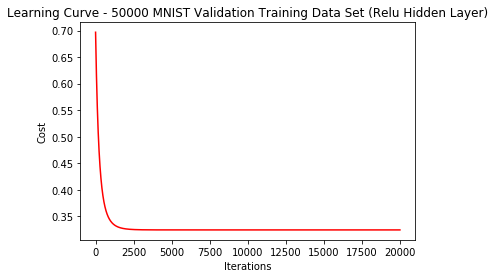

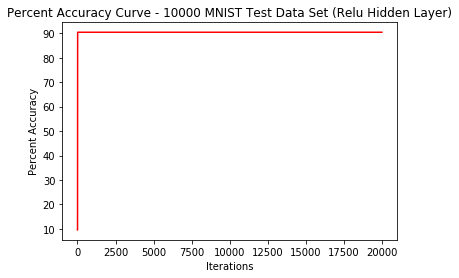

In [256]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01;
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

(Note: Please scroll down past the iteration count to see the results. The iteration count was for development to estimate how long the run time would be.)

The results for the networks with 5 layers line up with what we though. Our cost coverges to around 0.32 and our accuracy remains at a cost 90.39% for most of the iterations. What is probably happening (again) is that have to many layers compared to how much data we have (however, it could also be that it needed to run for significantly more iterations). Therefore, the network is not able accurate classify the test data. It likely remains at approximately 90% accuracy because it is classifying all of the test data as 0, since it does not properly detect 9s. Because approximately 9 out of 10 test images are not 9s, it is only correct approximately 90% of the time. We can confirm that no 9s are predicted by attempting to find one true positive or a false positive. If none are found, then our suspicious is likely confirmed.


Results: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


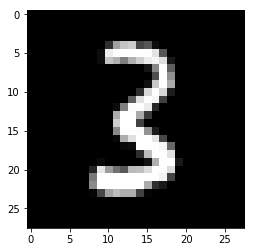

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 3, Size; (1, 28, 28)


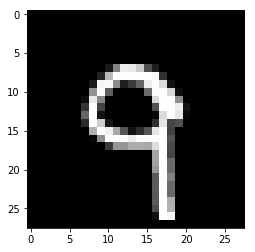

In [257]:
print('')
print('Results: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = _prediction[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[number_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[number_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[number_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[number_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show() 

Now we re-run our gradient descent algorithm.

Again, as illustrated above, no true positive or false positive was found. This means the network never predicted a 9. Therefore, out suspicion is likely confirmed. 

Now we would like to investigate the impact of increasing the number of units in the hidden layers. Since our 2 hidden layer network with 5 hidden units produced good results, we will use a 2 hidden layer network with 20 units in the hidden layer. All the other paramters will match our previous 2 hidden layer network so that we can draw some inferences about what happens when you increase the number of units in the hidden layers. 

First we must re-initialize our weights and bias's as a uniform random distribution with the same random seed as before. However, we will specify 2 hidden layers with 20 units this time.  

In [258]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units = 20

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(3,)
(3,)


Now we will re-run our gradient descent.

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 334
Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373


Main Loop Iteration: 662
Main Loop Iteration: 663
Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701


Main Loop Iteration: 990
Main Loop Iteration: 991
Main Loop Iteration: 992
Main Loop Iteration: 993
Main Loop Iteration: 994
Main Loop Iteration: 995
Main Loop Iteration: 996
Main Loop Iteration: 997
Main Loop Iteration: 998
Main Loop Iteration: 999
Main Loop Iteration: 1000
Main Loop Iteration: 1001
Main Loop Iteration: 1002
Main Loop Iteration: 1003
Main Loop Iteration: 1004
Main Loop Iteration: 1005
Main Loop Iteration: 1006
Main Loop Iteration: 1007
Main Loop Iteration: 1008
Main Loop Iteration: 1009
Main Loop Iteration: 1010
Main Loop Iteration: 1011
Main Loop Iteration: 1012
Main Loop Iteration: 1013
Main Loop Iteration: 1014
Main Loop Iteration: 1015
Main Loop Iteration: 1016
Main Loop Iteration: 1017
Main Loop Iteration: 1018
Main Loop Iteration: 1019
Main Loop Iteration: 1020
Main Loop Iteration: 1021
Main Loop Iteration: 1022
Main Loop Iteration: 1023
Main Loop Iteration: 1024
Main Loop Iteration: 1025
Main Loop Iteration: 1026
Main Loop Iteration: 1027
Main Loop Iteration: 1

Main Loop Iteration: 1306
Main Loop Iteration: 1307
Main Loop Iteration: 1308
Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop Iteration: 1343
Main Loop It

Main Loop Iteration: 1622
Main Loop Iteration: 1623
Main Loop Iteration: 1624
Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop Iteration: 1659
Main Loop It

Main Loop Iteration: 1938
Main Loop Iteration: 1939
Main Loop Iteration: 1940
Main Loop Iteration: 1941
Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop Iteration: 1975
Main Loop It

Main Loop Iteration: 2254
Main Loop Iteration: 2255
Main Loop Iteration: 2256
Main Loop Iteration: 2257
Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop Iteration: 2291
Main Loop It

Main Loop Iteration: 2570
Main Loop Iteration: 2571
Main Loop Iteration: 2572
Main Loop Iteration: 2573
Main Loop Iteration: 2574
Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop Iteration: 2606
Main Loop Iteration: 2607
Main Loop It

Main Loop Iteration: 2886
Main Loop Iteration: 2887
Main Loop Iteration: 2888
Main Loop Iteration: 2889
Main Loop Iteration: 2890
Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop Iteration: 2922
Main Loop Iteration: 2923
Main Loop It

Main Loop Iteration: 3202
Main Loop Iteration: 3203
Main Loop Iteration: 3204
Main Loop Iteration: 3205
Main Loop Iteration: 3206
Main Loop Iteration: 3207
Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop Iteration: 3238
Main Loop Iteration: 3239
Main Loop It

Main Loop Iteration: 3518
Main Loop Iteration: 3519
Main Loop Iteration: 3520
Main Loop Iteration: 3521
Main Loop Iteration: 3522
Main Loop Iteration: 3523
Main Loop Iteration: 3524
Main Loop Iteration: 3525
Main Loop Iteration: 3526
Main Loop Iteration: 3527
Main Loop Iteration: 3528
Main Loop Iteration: 3529
Main Loop Iteration: 3530
Main Loop Iteration: 3531
Main Loop Iteration: 3532
Main Loop Iteration: 3533
Main Loop Iteration: 3534
Main Loop Iteration: 3535
Main Loop Iteration: 3536
Main Loop Iteration: 3537
Main Loop Iteration: 3538
Main Loop Iteration: 3539
Main Loop Iteration: 3540
Main Loop Iteration: 3541
Main Loop Iteration: 3542
Main Loop Iteration: 3543
Main Loop Iteration: 3544
Main Loop Iteration: 3545
Main Loop Iteration: 3546
Main Loop Iteration: 3547
Main Loop Iteration: 3548
Main Loop Iteration: 3549
Main Loop Iteration: 3550
Main Loop Iteration: 3551
Main Loop Iteration: 3552
Main Loop Iteration: 3553
Main Loop Iteration: 3554
Main Loop Iteration: 3555
Main Loop It

Main Loop Iteration: 3834
Main Loop Iteration: 3835
Main Loop Iteration: 3836
Main Loop Iteration: 3837
Main Loop Iteration: 3838
Main Loop Iteration: 3839
Main Loop Iteration: 3840
Main Loop Iteration: 3841
Main Loop Iteration: 3842
Main Loop Iteration: 3843
Main Loop Iteration: 3844
Main Loop Iteration: 3845
Main Loop Iteration: 3846
Main Loop Iteration: 3847
Main Loop Iteration: 3848
Main Loop Iteration: 3849
Main Loop Iteration: 3850
Main Loop Iteration: 3851
Main Loop Iteration: 3852
Main Loop Iteration: 3853
Main Loop Iteration: 3854
Main Loop Iteration: 3855
Main Loop Iteration: 3856
Main Loop Iteration: 3857
Main Loop Iteration: 3858
Main Loop Iteration: 3859
Main Loop Iteration: 3860
Main Loop Iteration: 3861
Main Loop Iteration: 3862
Main Loop Iteration: 3863
Main Loop Iteration: 3864
Main Loop Iteration: 3865
Main Loop Iteration: 3866
Main Loop Iteration: 3867
Main Loop Iteration: 3868
Main Loop Iteration: 3869
Main Loop Iteration: 3870
Main Loop Iteration: 3871
Main Loop It

Main Loop Iteration: 4150
Main Loop Iteration: 4151
Main Loop Iteration: 4152
Main Loop Iteration: 4153
Main Loop Iteration: 4154
Main Loop Iteration: 4155
Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop Iteration: 4186
Main Loop Iteration: 4187
Main Loop It

Main Loop Iteration: 4466
Main Loop Iteration: 4467
Main Loop Iteration: 4468
Main Loop Iteration: 4469
Main Loop Iteration: 4470
Main Loop Iteration: 4471
Main Loop Iteration: 4472
Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop Iteration: 4502
Main Loop Iteration: 4503
Main Loop It

Main Loop Iteration: 4782
Main Loop Iteration: 4783
Main Loop Iteration: 4784
Main Loop Iteration: 4785
Main Loop Iteration: 4786
Main Loop Iteration: 4787
Main Loop Iteration: 4788
Main Loop Iteration: 4789
Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop Iteration: 4818
Main Loop Iteration: 4819
Main Loop It

Main Loop Iteration: 5098
Main Loop Iteration: 5099
Main Loop Iteration: 5100
Main Loop Iteration: 5101
Main Loop Iteration: 5102
Main Loop Iteration: 5103
Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop Iteration: 5134
Main Loop Iteration: 5135
Main Loop It

Main Loop Iteration: 5414
Main Loop Iteration: 5415
Main Loop Iteration: 5416
Main Loop Iteration: 5417
Main Loop Iteration: 5418
Main Loop Iteration: 5419
Main Loop Iteration: 5420
Main Loop Iteration: 5421
Main Loop Iteration: 5422
Main Loop Iteration: 5423
Main Loop Iteration: 5424
Main Loop Iteration: 5425
Main Loop Iteration: 5426
Main Loop Iteration: 5427
Main Loop Iteration: 5428
Main Loop Iteration: 5429
Main Loop Iteration: 5430
Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop Iteration: 5449
Main Loop Iteration: 5450
Main Loop Iteration: 5451
Main Loop It

Main Loop Iteration: 5730
Main Loop Iteration: 5731
Main Loop Iteration: 5732
Main Loop Iteration: 5733
Main Loop Iteration: 5734
Main Loop Iteration: 5735
Main Loop Iteration: 5736
Main Loop Iteration: 5737
Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop Iteration: 5767
Main Loop It

Main Loop Iteration: 6046
Main Loop Iteration: 6047
Main Loop Iteration: 6048
Main Loop Iteration: 6049
Main Loop Iteration: 6050
Main Loop Iteration: 6051
Main Loop Iteration: 6052
Main Loop Iteration: 6053
Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop Iteration: 6081
Main Loop Iteration: 6082
Main Loop Iteration: 6083
Main Loop It

Main Loop Iteration: 6362
Main Loop Iteration: 6363
Main Loop Iteration: 6364
Main Loop Iteration: 6365
Main Loop Iteration: 6366
Main Loop Iteration: 6367
Main Loop Iteration: 6368
Main Loop Iteration: 6369
Main Loop Iteration: 6370
Main Loop Iteration: 6371
Main Loop Iteration: 6372
Main Loop Iteration: 6373
Main Loop Iteration: 6374
Main Loop Iteration: 6375
Main Loop Iteration: 6376
Main Loop Iteration: 6377
Main Loop Iteration: 6378
Main Loop Iteration: 6379
Main Loop Iteration: 6380
Main Loop Iteration: 6381
Main Loop Iteration: 6382
Main Loop Iteration: 6383
Main Loop Iteration: 6384
Main Loop Iteration: 6385
Main Loop Iteration: 6386
Main Loop Iteration: 6387
Main Loop Iteration: 6388
Main Loop Iteration: 6389
Main Loop Iteration: 6390
Main Loop Iteration: 6391
Main Loop Iteration: 6392
Main Loop Iteration: 6393
Main Loop Iteration: 6394
Main Loop Iteration: 6395
Main Loop Iteration: 6396
Main Loop Iteration: 6397
Main Loop Iteration: 6398
Main Loop Iteration: 6399
Main Loop It

Main Loop Iteration: 6678
Main Loop Iteration: 6679
Main Loop Iteration: 6680
Main Loop Iteration: 6681
Main Loop Iteration: 6682
Main Loop Iteration: 6683
Main Loop Iteration: 6684
Main Loop Iteration: 6685
Main Loop Iteration: 6686
Main Loop Iteration: 6687
Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop Iteration: 6713
Main Loop Iteration: 6714
Main Loop Iteration: 6715
Main Loop It

Main Loop Iteration: 6994
Main Loop Iteration: 6995
Main Loop Iteration: 6996
Main Loop Iteration: 6997
Main Loop Iteration: 6998
Main Loop Iteration: 6999
Main Loop Iteration: 7000
Main Loop Iteration: 7001
Main Loop Iteration: 7002
Main Loop Iteration: 7003
Main Loop Iteration: 7004
Main Loop Iteration: 7005
Main Loop Iteration: 7006
Main Loop Iteration: 7007
Main Loop Iteration: 7008
Main Loop Iteration: 7009
Main Loop Iteration: 7010
Main Loop Iteration: 7011
Main Loop Iteration: 7012
Main Loop Iteration: 7013
Main Loop Iteration: 7014
Main Loop Iteration: 7015
Main Loop Iteration: 7016
Main Loop Iteration: 7017
Main Loop Iteration: 7018
Main Loop Iteration: 7019
Main Loop Iteration: 7020
Main Loop Iteration: 7021
Main Loop Iteration: 7022
Main Loop Iteration: 7023
Main Loop Iteration: 7024
Main Loop Iteration: 7025
Main Loop Iteration: 7026
Main Loop Iteration: 7027
Main Loop Iteration: 7028
Main Loop Iteration: 7029
Main Loop Iteration: 7030
Main Loop Iteration: 7031
Main Loop It

Main Loop Iteration: 7310
Main Loop Iteration: 7311
Main Loop Iteration: 7312
Main Loop Iteration: 7313
Main Loop Iteration: 7314
Main Loop Iteration: 7315
Main Loop Iteration: 7316
Main Loop Iteration: 7317
Main Loop Iteration: 7318
Main Loop Iteration: 7319
Main Loop Iteration: 7320
Main Loop Iteration: 7321
Main Loop Iteration: 7322
Main Loop Iteration: 7323
Main Loop Iteration: 7324
Main Loop Iteration: 7325
Main Loop Iteration: 7326
Main Loop Iteration: 7327
Main Loop Iteration: 7328
Main Loop Iteration: 7329
Main Loop Iteration: 7330
Main Loop Iteration: 7331
Main Loop Iteration: 7332
Main Loop Iteration: 7333
Main Loop Iteration: 7334
Main Loop Iteration: 7335
Main Loop Iteration: 7336
Main Loop Iteration: 7337
Main Loop Iteration: 7338
Main Loop Iteration: 7339
Main Loop Iteration: 7340
Main Loop Iteration: 7341
Main Loop Iteration: 7342
Main Loop Iteration: 7343
Main Loop Iteration: 7344
Main Loop Iteration: 7345
Main Loop Iteration: 7346
Main Loop Iteration: 7347
Main Loop It

Main Loop Iteration: 7626
Main Loop Iteration: 7627
Main Loop Iteration: 7628
Main Loop Iteration: 7629
Main Loop Iteration: 7630
Main Loop Iteration: 7631
Main Loop Iteration: 7632
Main Loop Iteration: 7633
Main Loop Iteration: 7634
Main Loop Iteration: 7635
Main Loop Iteration: 7636
Main Loop Iteration: 7637
Main Loop Iteration: 7638
Main Loop Iteration: 7639
Main Loop Iteration: 7640
Main Loop Iteration: 7641
Main Loop Iteration: 7642
Main Loop Iteration: 7643
Main Loop Iteration: 7644
Main Loop Iteration: 7645
Main Loop Iteration: 7646
Main Loop Iteration: 7647
Main Loop Iteration: 7648
Main Loop Iteration: 7649
Main Loop Iteration: 7650
Main Loop Iteration: 7651
Main Loop Iteration: 7652
Main Loop Iteration: 7653
Main Loop Iteration: 7654
Main Loop Iteration: 7655
Main Loop Iteration: 7656
Main Loop Iteration: 7657
Main Loop Iteration: 7658
Main Loop Iteration: 7659
Main Loop Iteration: 7660
Main Loop Iteration: 7661
Main Loop Iteration: 7662
Main Loop Iteration: 7663
Main Loop It

Main Loop Iteration: 7942
Main Loop Iteration: 7943
Main Loop Iteration: 7944
Main Loop Iteration: 7945
Main Loop Iteration: 7946
Main Loop Iteration: 7947
Main Loop Iteration: 7948
Main Loop Iteration: 7949
Main Loop Iteration: 7950
Main Loop Iteration: 7951
Main Loop Iteration: 7952
Main Loop Iteration: 7953
Main Loop Iteration: 7954
Main Loop Iteration: 7955
Main Loop Iteration: 7956
Main Loop Iteration: 7957
Main Loop Iteration: 7958
Main Loop Iteration: 7959
Main Loop Iteration: 7960
Main Loop Iteration: 7961
Main Loop Iteration: 7962
Main Loop Iteration: 7963
Main Loop Iteration: 7964
Main Loop Iteration: 7965
Main Loop Iteration: 7966
Main Loop Iteration: 7967
Main Loop Iteration: 7968
Main Loop Iteration: 7969
Main Loop Iteration: 7970
Main Loop Iteration: 7971
Main Loop Iteration: 7972
Main Loop Iteration: 7973
Main Loop Iteration: 7974
Main Loop Iteration: 7975
Main Loop Iteration: 7976
Main Loop Iteration: 7977
Main Loop Iteration: 7978
Main Loop Iteration: 7979
Main Loop It

Main Loop Iteration: 8258
Main Loop Iteration: 8259
Main Loop Iteration: 8260
Main Loop Iteration: 8261
Main Loop Iteration: 8262
Main Loop Iteration: 8263
Main Loop Iteration: 8264
Main Loop Iteration: 8265
Main Loop Iteration: 8266
Main Loop Iteration: 8267
Main Loop Iteration: 8268
Main Loop Iteration: 8269
Main Loop Iteration: 8270
Main Loop Iteration: 8271
Main Loop Iteration: 8272
Main Loop Iteration: 8273
Main Loop Iteration: 8274
Main Loop Iteration: 8275
Main Loop Iteration: 8276
Main Loop Iteration: 8277
Main Loop Iteration: 8278
Main Loop Iteration: 8279
Main Loop Iteration: 8280
Main Loop Iteration: 8281
Main Loop Iteration: 8282
Main Loop Iteration: 8283
Main Loop Iteration: 8284
Main Loop Iteration: 8285
Main Loop Iteration: 8286
Main Loop Iteration: 8287
Main Loop Iteration: 8288
Main Loop Iteration: 8289
Main Loop Iteration: 8290
Main Loop Iteration: 8291
Main Loop Iteration: 8292
Main Loop Iteration: 8293
Main Loop Iteration: 8294
Main Loop Iteration: 8295
Main Loop It

Main Loop Iteration: 8574
Main Loop Iteration: 8575
Main Loop Iteration: 8576
Main Loop Iteration: 8577
Main Loop Iteration: 8578
Main Loop Iteration: 8579
Main Loop Iteration: 8580
Main Loop Iteration: 8581
Main Loop Iteration: 8582
Main Loop Iteration: 8583
Main Loop Iteration: 8584
Main Loop Iteration: 8585
Main Loop Iteration: 8586
Main Loop Iteration: 8587
Main Loop Iteration: 8588
Main Loop Iteration: 8589
Main Loop Iteration: 8590
Main Loop Iteration: 8591
Main Loop Iteration: 8592
Main Loop Iteration: 8593
Main Loop Iteration: 8594
Main Loop Iteration: 8595
Main Loop Iteration: 8596
Main Loop Iteration: 8597
Main Loop Iteration: 8598
Main Loop Iteration: 8599
Main Loop Iteration: 8600
Main Loop Iteration: 8601
Main Loop Iteration: 8602
Main Loop Iteration: 8603
Main Loop Iteration: 8604
Main Loop Iteration: 8605
Main Loop Iteration: 8606
Main Loop Iteration: 8607
Main Loop Iteration: 8608
Main Loop Iteration: 8609
Main Loop Iteration: 8610
Main Loop Iteration: 8611
Main Loop It

Main Loop Iteration: 8890
Main Loop Iteration: 8891
Main Loop Iteration: 8892
Main Loop Iteration: 8893
Main Loop Iteration: 8894
Main Loop Iteration: 8895
Main Loop Iteration: 8896
Main Loop Iteration: 8897
Main Loop Iteration: 8898
Main Loop Iteration: 8899
Main Loop Iteration: 8900
Main Loop Iteration: 8901
Main Loop Iteration: 8902
Main Loop Iteration: 8903
Main Loop Iteration: 8904
Main Loop Iteration: 8905
Main Loop Iteration: 8906
Main Loop Iteration: 8907
Main Loop Iteration: 8908
Main Loop Iteration: 8909
Main Loop Iteration: 8910
Main Loop Iteration: 8911
Main Loop Iteration: 8912
Main Loop Iteration: 8913
Main Loop Iteration: 8914
Main Loop Iteration: 8915
Main Loop Iteration: 8916
Main Loop Iteration: 8917
Main Loop Iteration: 8918
Main Loop Iteration: 8919
Main Loop Iteration: 8920
Main Loop Iteration: 8921
Main Loop Iteration: 8922
Main Loop Iteration: 8923
Main Loop Iteration: 8924
Main Loop Iteration: 8925
Main Loop Iteration: 8926
Main Loop Iteration: 8927
Main Loop It

Main Loop Iteration: 9206
Main Loop Iteration: 9207
Main Loop Iteration: 9208
Main Loop Iteration: 9209
Main Loop Iteration: 9210
Main Loop Iteration: 9211
Main Loop Iteration: 9212
Main Loop Iteration: 9213
Main Loop Iteration: 9214
Main Loop Iteration: 9215
Main Loop Iteration: 9216
Main Loop Iteration: 9217
Main Loop Iteration: 9218
Main Loop Iteration: 9219
Main Loop Iteration: 9220
Main Loop Iteration: 9221
Main Loop Iteration: 9222
Main Loop Iteration: 9223
Main Loop Iteration: 9224
Main Loop Iteration: 9225
Main Loop Iteration: 9226
Main Loop Iteration: 9227
Main Loop Iteration: 9228
Main Loop Iteration: 9229
Main Loop Iteration: 9230
Main Loop Iteration: 9231
Main Loop Iteration: 9232
Main Loop Iteration: 9233
Main Loop Iteration: 9234
Main Loop Iteration: 9235
Main Loop Iteration: 9236
Main Loop Iteration: 9237
Main Loop Iteration: 9238
Main Loop Iteration: 9239
Main Loop Iteration: 9240
Main Loop Iteration: 9241
Main Loop Iteration: 9242
Main Loop Iteration: 9243
Main Loop It

Main Loop Iteration: 9522
Main Loop Iteration: 9523
Main Loop Iteration: 9524
Main Loop Iteration: 9525
Main Loop Iteration: 9526
Main Loop Iteration: 9527
Main Loop Iteration: 9528
Main Loop Iteration: 9529
Main Loop Iteration: 9530
Main Loop Iteration: 9531
Main Loop Iteration: 9532
Main Loop Iteration: 9533
Main Loop Iteration: 9534
Main Loop Iteration: 9535
Main Loop Iteration: 9536
Main Loop Iteration: 9537
Main Loop Iteration: 9538
Main Loop Iteration: 9539
Main Loop Iteration: 9540
Main Loop Iteration: 9541
Main Loop Iteration: 9542
Main Loop Iteration: 9543
Main Loop Iteration: 9544
Main Loop Iteration: 9545
Main Loop Iteration: 9546
Main Loop Iteration: 9547
Main Loop Iteration: 9548
Main Loop Iteration: 9549
Main Loop Iteration: 9550
Main Loop Iteration: 9551
Main Loop Iteration: 9552
Main Loop Iteration: 9553
Main Loop Iteration: 9554
Main Loop Iteration: 9555
Main Loop Iteration: 9556
Main Loop Iteration: 9557
Main Loop Iteration: 9558
Main Loop Iteration: 9559
Main Loop It

Main Loop Iteration: 9838
Main Loop Iteration: 9839
Main Loop Iteration: 9840
Main Loop Iteration: 9841
Main Loop Iteration: 9842
Main Loop Iteration: 9843
Main Loop Iteration: 9844
Main Loop Iteration: 9845
Main Loop Iteration: 9846
Main Loop Iteration: 9847
Main Loop Iteration: 9848
Main Loop Iteration: 9849
Main Loop Iteration: 9850
Main Loop Iteration: 9851
Main Loop Iteration: 9852
Main Loop Iteration: 9853
Main Loop Iteration: 9854
Main Loop Iteration: 9855
Main Loop Iteration: 9856
Main Loop Iteration: 9857
Main Loop Iteration: 9858
Main Loop Iteration: 9859
Main Loop Iteration: 9860
Main Loop Iteration: 9861
Main Loop Iteration: 9862
Main Loop Iteration: 9863
Main Loop Iteration: 9864
Main Loop Iteration: 9865
Main Loop Iteration: 9866
Main Loop Iteration: 9867
Main Loop Iteration: 9868
Main Loop Iteration: 9869
Main Loop Iteration: 9870
Main Loop Iteration: 9871
Main Loop Iteration: 9872
Main Loop Iteration: 9873
Main Loop Iteration: 9874
Main Loop Iteration: 9875
Main Loop It

Main Loop Iteration: 10148
Main Loop Iteration: 10149
Main Loop Iteration: 10150
Main Loop Iteration: 10151
Main Loop Iteration: 10152
Main Loop Iteration: 10153
Main Loop Iteration: 10154
Main Loop Iteration: 10155
Main Loop Iteration: 10156
Main Loop Iteration: 10157
Main Loop Iteration: 10158
Main Loop Iteration: 10159
Main Loop Iteration: 10160
Main Loop Iteration: 10161
Main Loop Iteration: 10162
Main Loop Iteration: 10163
Main Loop Iteration: 10164
Main Loop Iteration: 10165
Main Loop Iteration: 10166
Main Loop Iteration: 10167
Main Loop Iteration: 10168
Main Loop Iteration: 10169
Main Loop Iteration: 10170
Main Loop Iteration: 10171
Main Loop Iteration: 10172
Main Loop Iteration: 10173
Main Loop Iteration: 10174
Main Loop Iteration: 10175
Main Loop Iteration: 10176
Main Loop Iteration: 10177
Main Loop Iteration: 10178
Main Loop Iteration: 10179
Main Loop Iteration: 10180
Main Loop Iteration: 10181
Main Loop Iteration: 10182
Main Loop Iteration: 10183
Main Loop Iteration: 10184
M

Main Loop Iteration: 10452
Main Loop Iteration: 10453
Main Loop Iteration: 10454
Main Loop Iteration: 10455
Main Loop Iteration: 10456
Main Loop Iteration: 10457
Main Loop Iteration: 10458
Main Loop Iteration: 10459
Main Loop Iteration: 10460
Main Loop Iteration: 10461
Main Loop Iteration: 10462
Main Loop Iteration: 10463
Main Loop Iteration: 10464
Main Loop Iteration: 10465
Main Loop Iteration: 10466
Main Loop Iteration: 10467
Main Loop Iteration: 10468
Main Loop Iteration: 10469
Main Loop Iteration: 10470
Main Loop Iteration: 10471
Main Loop Iteration: 10472
Main Loop Iteration: 10473
Main Loop Iteration: 10474
Main Loop Iteration: 10475
Main Loop Iteration: 10476
Main Loop Iteration: 10477
Main Loop Iteration: 10478
Main Loop Iteration: 10479
Main Loop Iteration: 10480
Main Loop Iteration: 10481
Main Loop Iteration: 10482
Main Loop Iteration: 10483
Main Loop Iteration: 10484
Main Loop Iteration: 10485
Main Loop Iteration: 10486
Main Loop Iteration: 10487
Main Loop Iteration: 10488
M

Main Loop Iteration: 10756
Main Loop Iteration: 10757
Main Loop Iteration: 10758
Main Loop Iteration: 10759
Main Loop Iteration: 10760
Main Loop Iteration: 10761
Main Loop Iteration: 10762
Main Loop Iteration: 10763
Main Loop Iteration: 10764
Main Loop Iteration: 10765
Main Loop Iteration: 10766
Main Loop Iteration: 10767
Main Loop Iteration: 10768
Main Loop Iteration: 10769
Main Loop Iteration: 10770
Main Loop Iteration: 10771
Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
Main Loop Iteration: 10781
Main Loop Iteration: 10782
Main Loop Iteration: 10783
Main Loop Iteration: 10784
Main Loop Iteration: 10785
Main Loop Iteration: 10786
Main Loop Iteration: 10787
Main Loop Iteration: 10788
Main Loop Iteration: 10789
Main Loop Iteration: 10790
Main Loop Iteration: 10791
Main Loop Iteration: 10792
M

Main Loop Iteration: 11060
Main Loop Iteration: 11061
Main Loop Iteration: 11062
Main Loop Iteration: 11063
Main Loop Iteration: 11064
Main Loop Iteration: 11065
Main Loop Iteration: 11066
Main Loop Iteration: 11067
Main Loop Iteration: 11068
Main Loop Iteration: 11069
Main Loop Iteration: 11070
Main Loop Iteration: 11071
Main Loop Iteration: 11072
Main Loop Iteration: 11073
Main Loop Iteration: 11074
Main Loop Iteration: 11075
Main Loop Iteration: 11076
Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
Main Loop Iteration: 11090
Main Loop Iteration: 11091
Main Loop Iteration: 11092
Main Loop Iteration: 11093
Main Loop Iteration: 11094
Main Loop Iteration: 11095
Main Loop Iteration: 11096
M

Main Loop Iteration: 11364
Main Loop Iteration: 11365
Main Loop Iteration: 11366
Main Loop Iteration: 11367
Main Loop Iteration: 11368
Main Loop Iteration: 11369
Main Loop Iteration: 11370
Main Loop Iteration: 11371
Main Loop Iteration: 11372
Main Loop Iteration: 11373
Main Loop Iteration: 11374
Main Loop Iteration: 11375
Main Loop Iteration: 11376
Main Loop Iteration: 11377
Main Loop Iteration: 11378
Main Loop Iteration: 11379
Main Loop Iteration: 11380
Main Loop Iteration: 11381
Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
Main Loop Iteration: 11395
Main Loop Iteration: 11396
Main Loop Iteration: 11397
Main Loop Iteration: 11398
Main Loop Iteration: 11399
Main Loop Iteration: 11400
M

Main Loop Iteration: 11668
Main Loop Iteration: 11669
Main Loop Iteration: 11670
Main Loop Iteration: 11671
Main Loop Iteration: 11672
Main Loop Iteration: 11673
Main Loop Iteration: 11674
Main Loop Iteration: 11675
Main Loop Iteration: 11676
Main Loop Iteration: 11677
Main Loop Iteration: 11678
Main Loop Iteration: 11679
Main Loop Iteration: 11680
Main Loop Iteration: 11681
Main Loop Iteration: 11682
Main Loop Iteration: 11683
Main Loop Iteration: 11684
Main Loop Iteration: 11685
Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
Main Loop Iteration: 11698
Main Loop Iteration: 11699
Main Loop Iteration: 11700
Main Loop Iteration: 11701
Main Loop Iteration: 11702
Main Loop Iteration: 11703
Main Loop Iteration: 11704
M

Main Loop Iteration: 11972
Main Loop Iteration: 11973
Main Loop Iteration: 11974
Main Loop Iteration: 11975
Main Loop Iteration: 11976
Main Loop Iteration: 11977
Main Loop Iteration: 11978
Main Loop Iteration: 11979
Main Loop Iteration: 11980
Main Loop Iteration: 11981
Main Loop Iteration: 11982
Main Loop Iteration: 11983
Main Loop Iteration: 11984
Main Loop Iteration: 11985
Main Loop Iteration: 11986
Main Loop Iteration: 11987
Main Loop Iteration: 11988
Main Loop Iteration: 11989
Main Loop Iteration: 11990
Main Loop Iteration: 11991
Main Loop Iteration: 11992
Main Loop Iteration: 11993
Main Loop Iteration: 11994
Main Loop Iteration: 11995
Main Loop Iteration: 11996
Main Loop Iteration: 11997
Main Loop Iteration: 11998
Main Loop Iteration: 11999
Main Loop Iteration: 12000
Main Loop Iteration: 12001
Main Loop Iteration: 12002
Main Loop Iteration: 12003
Main Loop Iteration: 12004
Main Loop Iteration: 12005
Main Loop Iteration: 12006
Main Loop Iteration: 12007
Main Loop Iteration: 12008
M

Main Loop Iteration: 12276
Main Loop Iteration: 12277
Main Loop Iteration: 12278
Main Loop Iteration: 12279
Main Loop Iteration: 12280
Main Loop Iteration: 12281
Main Loop Iteration: 12282
Main Loop Iteration: 12283
Main Loop Iteration: 12284
Main Loop Iteration: 12285
Main Loop Iteration: 12286
Main Loop Iteration: 12287
Main Loop Iteration: 12288
Main Loop Iteration: 12289
Main Loop Iteration: 12290
Main Loop Iteration: 12291
Main Loop Iteration: 12292
Main Loop Iteration: 12293
Main Loop Iteration: 12294
Main Loop Iteration: 12295
Main Loop Iteration: 12296
Main Loop Iteration: 12297
Main Loop Iteration: 12298
Main Loop Iteration: 12299
Main Loop Iteration: 12300
Main Loop Iteration: 12301
Main Loop Iteration: 12302
Main Loop Iteration: 12303
Main Loop Iteration: 12304
Main Loop Iteration: 12305
Main Loop Iteration: 12306
Main Loop Iteration: 12307
Main Loop Iteration: 12308
Main Loop Iteration: 12309
Main Loop Iteration: 12310
Main Loop Iteration: 12311
Main Loop Iteration: 12312
M

Main Loop Iteration: 12580
Main Loop Iteration: 12581
Main Loop Iteration: 12582
Main Loop Iteration: 12583
Main Loop Iteration: 12584
Main Loop Iteration: 12585
Main Loop Iteration: 12586
Main Loop Iteration: 12587
Main Loop Iteration: 12588
Main Loop Iteration: 12589
Main Loop Iteration: 12590
Main Loop Iteration: 12591
Main Loop Iteration: 12592
Main Loop Iteration: 12593
Main Loop Iteration: 12594
Main Loop Iteration: 12595
Main Loop Iteration: 12596
Main Loop Iteration: 12597
Main Loop Iteration: 12598
Main Loop Iteration: 12599
Main Loop Iteration: 12600
Main Loop Iteration: 12601
Main Loop Iteration: 12602
Main Loop Iteration: 12603
Main Loop Iteration: 12604
Main Loop Iteration: 12605
Main Loop Iteration: 12606
Main Loop Iteration: 12607
Main Loop Iteration: 12608
Main Loop Iteration: 12609
Main Loop Iteration: 12610
Main Loop Iteration: 12611
Main Loop Iteration: 12612
Main Loop Iteration: 12613
Main Loop Iteration: 12614
Main Loop Iteration: 12615
Main Loop Iteration: 12616
M

Main Loop Iteration: 12884
Main Loop Iteration: 12885
Main Loop Iteration: 12886
Main Loop Iteration: 12887
Main Loop Iteration: 12888
Main Loop Iteration: 12889
Main Loop Iteration: 12890
Main Loop Iteration: 12891
Main Loop Iteration: 12892
Main Loop Iteration: 12893
Main Loop Iteration: 12894
Main Loop Iteration: 12895
Main Loop Iteration: 12896
Main Loop Iteration: 12897
Main Loop Iteration: 12898
Main Loop Iteration: 12899
Main Loop Iteration: 12900
Main Loop Iteration: 12901
Main Loop Iteration: 12902
Main Loop Iteration: 12903
Main Loop Iteration: 12904
Main Loop Iteration: 12905
Main Loop Iteration: 12906
Main Loop Iteration: 12907
Main Loop Iteration: 12908
Main Loop Iteration: 12909
Main Loop Iteration: 12910
Main Loop Iteration: 12911
Main Loop Iteration: 12912
Main Loop Iteration: 12913
Main Loop Iteration: 12914
Main Loop Iteration: 12915
Main Loop Iteration: 12916
Main Loop Iteration: 12917
Main Loop Iteration: 12918
Main Loop Iteration: 12919
Main Loop Iteration: 12920
M

Main Loop Iteration: 13188
Main Loop Iteration: 13189
Main Loop Iteration: 13190
Main Loop Iteration: 13191
Main Loop Iteration: 13192
Main Loop Iteration: 13193
Main Loop Iteration: 13194
Main Loop Iteration: 13195
Main Loop Iteration: 13196
Main Loop Iteration: 13197
Main Loop Iteration: 13198
Main Loop Iteration: 13199
Main Loop Iteration: 13200
Main Loop Iteration: 13201
Main Loop Iteration: 13202
Main Loop Iteration: 13203
Main Loop Iteration: 13204
Main Loop Iteration: 13205
Main Loop Iteration: 13206
Main Loop Iteration: 13207
Main Loop Iteration: 13208
Main Loop Iteration: 13209
Main Loop Iteration: 13210
Main Loop Iteration: 13211
Main Loop Iteration: 13212
Main Loop Iteration: 13213
Main Loop Iteration: 13214
Main Loop Iteration: 13215
Main Loop Iteration: 13216
Main Loop Iteration: 13217
Main Loop Iteration: 13218
Main Loop Iteration: 13219
Main Loop Iteration: 13220
Main Loop Iteration: 13221
Main Loop Iteration: 13222
Main Loop Iteration: 13223
Main Loop Iteration: 13224
M

Main Loop Iteration: 13492
Main Loop Iteration: 13493
Main Loop Iteration: 13494
Main Loop Iteration: 13495
Main Loop Iteration: 13496
Main Loop Iteration: 13497
Main Loop Iteration: 13498
Main Loop Iteration: 13499
Main Loop Iteration: 13500
Main Loop Iteration: 13501
Main Loop Iteration: 13502
Main Loop Iteration: 13503
Main Loop Iteration: 13504
Main Loop Iteration: 13505
Main Loop Iteration: 13506
Main Loop Iteration: 13507
Main Loop Iteration: 13508
Main Loop Iteration: 13509
Main Loop Iteration: 13510
Main Loop Iteration: 13511
Main Loop Iteration: 13512
Main Loop Iteration: 13513
Main Loop Iteration: 13514
Main Loop Iteration: 13515
Main Loop Iteration: 13516
Main Loop Iteration: 13517
Main Loop Iteration: 13518
Main Loop Iteration: 13519
Main Loop Iteration: 13520
Main Loop Iteration: 13521
Main Loop Iteration: 13522
Main Loop Iteration: 13523
Main Loop Iteration: 13524
Main Loop Iteration: 13525
Main Loop Iteration: 13526
Main Loop Iteration: 13527
Main Loop Iteration: 13528
M

Main Loop Iteration: 13796
Main Loop Iteration: 13797
Main Loop Iteration: 13798
Main Loop Iteration: 13799
Main Loop Iteration: 13800
Main Loop Iteration: 13801
Main Loop Iteration: 13802
Main Loop Iteration: 13803
Main Loop Iteration: 13804
Main Loop Iteration: 13805
Main Loop Iteration: 13806
Main Loop Iteration: 13807
Main Loop Iteration: 13808
Main Loop Iteration: 13809
Main Loop Iteration: 13810
Main Loop Iteration: 13811
Main Loop Iteration: 13812
Main Loop Iteration: 13813
Main Loop Iteration: 13814
Main Loop Iteration: 13815
Main Loop Iteration: 13816
Main Loop Iteration: 13817
Main Loop Iteration: 13818
Main Loop Iteration: 13819
Main Loop Iteration: 13820
Main Loop Iteration: 13821
Main Loop Iteration: 13822
Main Loop Iteration: 13823
Main Loop Iteration: 13824
Main Loop Iteration: 13825
Main Loop Iteration: 13826
Main Loop Iteration: 13827
Main Loop Iteration: 13828
Main Loop Iteration: 13829
Main Loop Iteration: 13830
Main Loop Iteration: 13831
Main Loop Iteration: 13832
M

Main Loop Iteration: 14100
Main Loop Iteration: 14101
Main Loop Iteration: 14102
Main Loop Iteration: 14103
Main Loop Iteration: 14104
Main Loop Iteration: 14105
Main Loop Iteration: 14106
Main Loop Iteration: 14107
Main Loop Iteration: 14108
Main Loop Iteration: 14109
Main Loop Iteration: 14110
Main Loop Iteration: 14111
Main Loop Iteration: 14112
Main Loop Iteration: 14113
Main Loop Iteration: 14114
Main Loop Iteration: 14115
Main Loop Iteration: 14116
Main Loop Iteration: 14117
Main Loop Iteration: 14118
Main Loop Iteration: 14119
Main Loop Iteration: 14120
Main Loop Iteration: 14121
Main Loop Iteration: 14122
Main Loop Iteration: 14123
Main Loop Iteration: 14124
Main Loop Iteration: 14125
Main Loop Iteration: 14126
Main Loop Iteration: 14127
Main Loop Iteration: 14128
Main Loop Iteration: 14129
Main Loop Iteration: 14130
Main Loop Iteration: 14131
Main Loop Iteration: 14132
Main Loop Iteration: 14133
Main Loop Iteration: 14134
Main Loop Iteration: 14135
Main Loop Iteration: 14136
M

Main Loop Iteration: 14404
Main Loop Iteration: 14405
Main Loop Iteration: 14406
Main Loop Iteration: 14407
Main Loop Iteration: 14408
Main Loop Iteration: 14409
Main Loop Iteration: 14410
Main Loop Iteration: 14411
Main Loop Iteration: 14412
Main Loop Iteration: 14413
Main Loop Iteration: 14414
Main Loop Iteration: 14415
Main Loop Iteration: 14416
Main Loop Iteration: 14417
Main Loop Iteration: 14418
Main Loop Iteration: 14419
Main Loop Iteration: 14420
Main Loop Iteration: 14421
Main Loop Iteration: 14422
Main Loop Iteration: 14423
Main Loop Iteration: 14424
Main Loop Iteration: 14425
Main Loop Iteration: 14426
Main Loop Iteration: 14427
Main Loop Iteration: 14428
Main Loop Iteration: 14429
Main Loop Iteration: 14430
Main Loop Iteration: 14431
Main Loop Iteration: 14432
Main Loop Iteration: 14433
Main Loop Iteration: 14434
Main Loop Iteration: 14435
Main Loop Iteration: 14436
Main Loop Iteration: 14437
Main Loop Iteration: 14438
Main Loop Iteration: 14439
Main Loop Iteration: 14440
M

Main Loop Iteration: 14708
Main Loop Iteration: 14709
Main Loop Iteration: 14710
Main Loop Iteration: 14711
Main Loop Iteration: 14712
Main Loop Iteration: 14713
Main Loop Iteration: 14714
Main Loop Iteration: 14715
Main Loop Iteration: 14716
Main Loop Iteration: 14717
Main Loop Iteration: 14718
Main Loop Iteration: 14719
Main Loop Iteration: 14720
Main Loop Iteration: 14721
Main Loop Iteration: 14722
Main Loop Iteration: 14723
Main Loop Iteration: 14724
Main Loop Iteration: 14725
Main Loop Iteration: 14726
Main Loop Iteration: 14727
Main Loop Iteration: 14728
Main Loop Iteration: 14729
Main Loop Iteration: 14730
Main Loop Iteration: 14731
Main Loop Iteration: 14732
Main Loop Iteration: 14733
Main Loop Iteration: 14734
Main Loop Iteration: 14735
Main Loop Iteration: 14736
Main Loop Iteration: 14737
Main Loop Iteration: 14738
Main Loop Iteration: 14739
Main Loop Iteration: 14740
Main Loop Iteration: 14741
Main Loop Iteration: 14742
Main Loop Iteration: 14743
Main Loop Iteration: 14744
M

Main Loop Iteration: 15012
Main Loop Iteration: 15013
Main Loop Iteration: 15014
Main Loop Iteration: 15015
Main Loop Iteration: 15016
Main Loop Iteration: 15017
Main Loop Iteration: 15018
Main Loop Iteration: 15019
Main Loop Iteration: 15020
Main Loop Iteration: 15021
Main Loop Iteration: 15022
Main Loop Iteration: 15023
Main Loop Iteration: 15024
Main Loop Iteration: 15025
Main Loop Iteration: 15026
Main Loop Iteration: 15027
Main Loop Iteration: 15028
Main Loop Iteration: 15029
Main Loop Iteration: 15030
Main Loop Iteration: 15031
Main Loop Iteration: 15032
Main Loop Iteration: 15033
Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
Main Loop Iteration: 15041
Main Loop Iteration: 15042
Main Loop Iteration: 15043
Main Loop Iteration: 15044
Main Loop Iteration: 15045
Main Loop Iteration: 15046
Main Loop Iteration: 15047
Main Loop Iteration: 15048
M

Main Loop Iteration: 15316
Main Loop Iteration: 15317
Main Loop Iteration: 15318
Main Loop Iteration: 15319
Main Loop Iteration: 15320
Main Loop Iteration: 15321
Main Loop Iteration: 15322
Main Loop Iteration: 15323
Main Loop Iteration: 15324
Main Loop Iteration: 15325
Main Loop Iteration: 15326
Main Loop Iteration: 15327
Main Loop Iteration: 15328
Main Loop Iteration: 15329
Main Loop Iteration: 15330
Main Loop Iteration: 15331
Main Loop Iteration: 15332
Main Loop Iteration: 15333
Main Loop Iteration: 15334
Main Loop Iteration: 15335
Main Loop Iteration: 15336
Main Loop Iteration: 15337
Main Loop Iteration: 15338
Main Loop Iteration: 15339
Main Loop Iteration: 15340
Main Loop Iteration: 15341
Main Loop Iteration: 15342
Main Loop Iteration: 15343
Main Loop Iteration: 15344
Main Loop Iteration: 15345
Main Loop Iteration: 15346
Main Loop Iteration: 15347
Main Loop Iteration: 15348
Main Loop Iteration: 15349
Main Loop Iteration: 15350
Main Loop Iteration: 15351
Main Loop Iteration: 15352
M

Main Loop Iteration: 15620
Main Loop Iteration: 15621
Main Loop Iteration: 15622
Main Loop Iteration: 15623
Main Loop Iteration: 15624
Main Loop Iteration: 15625
Main Loop Iteration: 15626
Main Loop Iteration: 15627
Main Loop Iteration: 15628
Main Loop Iteration: 15629
Main Loop Iteration: 15630
Main Loop Iteration: 15631
Main Loop Iteration: 15632
Main Loop Iteration: 15633
Main Loop Iteration: 15634
Main Loop Iteration: 15635
Main Loop Iteration: 15636
Main Loop Iteration: 15637
Main Loop Iteration: 15638
Main Loop Iteration: 15639
Main Loop Iteration: 15640
Main Loop Iteration: 15641
Main Loop Iteration: 15642
Main Loop Iteration: 15643
Main Loop Iteration: 15644
Main Loop Iteration: 15645
Main Loop Iteration: 15646
Main Loop Iteration: 15647
Main Loop Iteration: 15648
Main Loop Iteration: 15649
Main Loop Iteration: 15650
Main Loop Iteration: 15651
Main Loop Iteration: 15652
Main Loop Iteration: 15653
Main Loop Iteration: 15654
Main Loop Iteration: 15655
Main Loop Iteration: 15656
M

Main Loop Iteration: 15924
Main Loop Iteration: 15925
Main Loop Iteration: 15926
Main Loop Iteration: 15927
Main Loop Iteration: 15928
Main Loop Iteration: 15929
Main Loop Iteration: 15930
Main Loop Iteration: 15931
Main Loop Iteration: 15932
Main Loop Iteration: 15933
Main Loop Iteration: 15934
Main Loop Iteration: 15935
Main Loop Iteration: 15936
Main Loop Iteration: 15937
Main Loop Iteration: 15938
Main Loop Iteration: 15939
Main Loop Iteration: 15940
Main Loop Iteration: 15941
Main Loop Iteration: 15942
Main Loop Iteration: 15943
Main Loop Iteration: 15944
Main Loop Iteration: 15945
Main Loop Iteration: 15946
Main Loop Iteration: 15947
Main Loop Iteration: 15948
Main Loop Iteration: 15949
Main Loop Iteration: 15950
Main Loop Iteration: 15951
Main Loop Iteration: 15952
Main Loop Iteration: 15953
Main Loop Iteration: 15954
Main Loop Iteration: 15955
Main Loop Iteration: 15956
Main Loop Iteration: 15957
Main Loop Iteration: 15958
Main Loop Iteration: 15959
Main Loop Iteration: 15960
M

Main Loop Iteration: 16228
Main Loop Iteration: 16229
Main Loop Iteration: 16230
Main Loop Iteration: 16231
Main Loop Iteration: 16232
Main Loop Iteration: 16233
Main Loop Iteration: 16234
Main Loop Iteration: 16235
Main Loop Iteration: 16236
Main Loop Iteration: 16237
Main Loop Iteration: 16238
Main Loop Iteration: 16239
Main Loop Iteration: 16240
Main Loop Iteration: 16241
Main Loop Iteration: 16242
Main Loop Iteration: 16243
Main Loop Iteration: 16244
Main Loop Iteration: 16245
Main Loop Iteration: 16246
Main Loop Iteration: 16247
Main Loop Iteration: 16248
Main Loop Iteration: 16249
Main Loop Iteration: 16250
Main Loop Iteration: 16251
Main Loop Iteration: 16252
Main Loop Iteration: 16253
Main Loop Iteration: 16254
Main Loop Iteration: 16255
Main Loop Iteration: 16256
Main Loop Iteration: 16257
Main Loop Iteration: 16258
Main Loop Iteration: 16259
Main Loop Iteration: 16260
Main Loop Iteration: 16261
Main Loop Iteration: 16262
Main Loop Iteration: 16263
Main Loop Iteration: 16264
M

Main Loop Iteration: 16532
Main Loop Iteration: 16533
Main Loop Iteration: 16534
Main Loop Iteration: 16535
Main Loop Iteration: 16536
Main Loop Iteration: 16537
Main Loop Iteration: 16538
Main Loop Iteration: 16539
Main Loop Iteration: 16540
Main Loop Iteration: 16541
Main Loop Iteration: 16542
Main Loop Iteration: 16543
Main Loop Iteration: 16544
Main Loop Iteration: 16545
Main Loop Iteration: 16546
Main Loop Iteration: 16547
Main Loop Iteration: 16548
Main Loop Iteration: 16549
Main Loop Iteration: 16550
Main Loop Iteration: 16551
Main Loop Iteration: 16552
Main Loop Iteration: 16553
Main Loop Iteration: 16554
Main Loop Iteration: 16555
Main Loop Iteration: 16556
Main Loop Iteration: 16557
Main Loop Iteration: 16558
Main Loop Iteration: 16559
Main Loop Iteration: 16560
Main Loop Iteration: 16561
Main Loop Iteration: 16562
Main Loop Iteration: 16563
Main Loop Iteration: 16564
Main Loop Iteration: 16565
Main Loop Iteration: 16566
Main Loop Iteration: 16567
Main Loop Iteration: 16568
M

Main Loop Iteration: 16836
Main Loop Iteration: 16837
Main Loop Iteration: 16838
Main Loop Iteration: 16839
Main Loop Iteration: 16840
Main Loop Iteration: 16841
Main Loop Iteration: 16842
Main Loop Iteration: 16843
Main Loop Iteration: 16844
Main Loop Iteration: 16845
Main Loop Iteration: 16846
Main Loop Iteration: 16847
Main Loop Iteration: 16848
Main Loop Iteration: 16849
Main Loop Iteration: 16850
Main Loop Iteration: 16851
Main Loop Iteration: 16852
Main Loop Iteration: 16853
Main Loop Iteration: 16854
Main Loop Iteration: 16855
Main Loop Iteration: 16856
Main Loop Iteration: 16857
Main Loop Iteration: 16858
Main Loop Iteration: 16859
Main Loop Iteration: 16860
Main Loop Iteration: 16861
Main Loop Iteration: 16862
Main Loop Iteration: 16863
Main Loop Iteration: 16864
Main Loop Iteration: 16865
Main Loop Iteration: 16866
Main Loop Iteration: 16867
Main Loop Iteration: 16868
Main Loop Iteration: 16869
Main Loop Iteration: 16870
Main Loop Iteration: 16871
Main Loop Iteration: 16872
M

Main Loop Iteration: 17140
Main Loop Iteration: 17141
Main Loop Iteration: 17142
Main Loop Iteration: 17143
Main Loop Iteration: 17144
Main Loop Iteration: 17145
Main Loop Iteration: 17146
Main Loop Iteration: 17147
Main Loop Iteration: 17148
Main Loop Iteration: 17149
Main Loop Iteration: 17150
Main Loop Iteration: 17151
Main Loop Iteration: 17152
Main Loop Iteration: 17153
Main Loop Iteration: 17154
Main Loop Iteration: 17155
Main Loop Iteration: 17156
Main Loop Iteration: 17157
Main Loop Iteration: 17158
Main Loop Iteration: 17159
Main Loop Iteration: 17160
Main Loop Iteration: 17161
Main Loop Iteration: 17162
Main Loop Iteration: 17163
Main Loop Iteration: 17164
Main Loop Iteration: 17165
Main Loop Iteration: 17166
Main Loop Iteration: 17167
Main Loop Iteration: 17168
Main Loop Iteration: 17169
Main Loop Iteration: 17170
Main Loop Iteration: 17171
Main Loop Iteration: 17172
Main Loop Iteration: 17173
Main Loop Iteration: 17174
Main Loop Iteration: 17175
Main Loop Iteration: 17176
M

Main Loop Iteration: 17444
Main Loop Iteration: 17445
Main Loop Iteration: 17446
Main Loop Iteration: 17447
Main Loop Iteration: 17448
Main Loop Iteration: 17449
Main Loop Iteration: 17450
Main Loop Iteration: 17451
Main Loop Iteration: 17452
Main Loop Iteration: 17453
Main Loop Iteration: 17454
Main Loop Iteration: 17455
Main Loop Iteration: 17456
Main Loop Iteration: 17457
Main Loop Iteration: 17458
Main Loop Iteration: 17459
Main Loop Iteration: 17460
Main Loop Iteration: 17461
Main Loop Iteration: 17462
Main Loop Iteration: 17463
Main Loop Iteration: 17464
Main Loop Iteration: 17465
Main Loop Iteration: 17466
Main Loop Iteration: 17467
Main Loop Iteration: 17468
Main Loop Iteration: 17469
Main Loop Iteration: 17470
Main Loop Iteration: 17471
Main Loop Iteration: 17472
Main Loop Iteration: 17473
Main Loop Iteration: 17474
Main Loop Iteration: 17475
Main Loop Iteration: 17476
Main Loop Iteration: 17477
Main Loop Iteration: 17478
Main Loop Iteration: 17479
Main Loop Iteration: 17480
M

Main Loop Iteration: 17748
Main Loop Iteration: 17749
Main Loop Iteration: 17750
Main Loop Iteration: 17751
Main Loop Iteration: 17752
Main Loop Iteration: 17753
Main Loop Iteration: 17754
Main Loop Iteration: 17755
Main Loop Iteration: 17756
Main Loop Iteration: 17757
Main Loop Iteration: 17758
Main Loop Iteration: 17759
Main Loop Iteration: 17760
Main Loop Iteration: 17761
Main Loop Iteration: 17762
Main Loop Iteration: 17763
Main Loop Iteration: 17764
Main Loop Iteration: 17765
Main Loop Iteration: 17766
Main Loop Iteration: 17767
Main Loop Iteration: 17768
Main Loop Iteration: 17769
Main Loop Iteration: 17770
Main Loop Iteration: 17771
Main Loop Iteration: 17772
Main Loop Iteration: 17773
Main Loop Iteration: 17774
Main Loop Iteration: 17775
Main Loop Iteration: 17776
Main Loop Iteration: 17777
Main Loop Iteration: 17778
Main Loop Iteration: 17779
Main Loop Iteration: 17780
Main Loop Iteration: 17781
Main Loop Iteration: 17782
Main Loop Iteration: 17783
Main Loop Iteration: 17784
M

Main Loop Iteration: 18052
Main Loop Iteration: 18053
Main Loop Iteration: 18054
Main Loop Iteration: 18055
Main Loop Iteration: 18056
Main Loop Iteration: 18057
Main Loop Iteration: 18058
Main Loop Iteration: 18059
Main Loop Iteration: 18060
Main Loop Iteration: 18061
Main Loop Iteration: 18062
Main Loop Iteration: 18063
Main Loop Iteration: 18064
Main Loop Iteration: 18065
Main Loop Iteration: 18066
Main Loop Iteration: 18067
Main Loop Iteration: 18068
Main Loop Iteration: 18069
Main Loop Iteration: 18070
Main Loop Iteration: 18071
Main Loop Iteration: 18072
Main Loop Iteration: 18073
Main Loop Iteration: 18074
Main Loop Iteration: 18075
Main Loop Iteration: 18076
Main Loop Iteration: 18077
Main Loop Iteration: 18078
Main Loop Iteration: 18079
Main Loop Iteration: 18080
Main Loop Iteration: 18081
Main Loop Iteration: 18082
Main Loop Iteration: 18083
Main Loop Iteration: 18084
Main Loop Iteration: 18085
Main Loop Iteration: 18086
Main Loop Iteration: 18087
Main Loop Iteration: 18088
M

Main Loop Iteration: 18356
Main Loop Iteration: 18357
Main Loop Iteration: 18358
Main Loop Iteration: 18359
Main Loop Iteration: 18360
Main Loop Iteration: 18361
Main Loop Iteration: 18362
Main Loop Iteration: 18363
Main Loop Iteration: 18364
Main Loop Iteration: 18365
Main Loop Iteration: 18366
Main Loop Iteration: 18367
Main Loop Iteration: 18368
Main Loop Iteration: 18369
Main Loop Iteration: 18370
Main Loop Iteration: 18371
Main Loop Iteration: 18372
Main Loop Iteration: 18373
Main Loop Iteration: 18374
Main Loop Iteration: 18375
Main Loop Iteration: 18376
Main Loop Iteration: 18377
Main Loop Iteration: 18378
Main Loop Iteration: 18379
Main Loop Iteration: 18380
Main Loop Iteration: 18381
Main Loop Iteration: 18382
Main Loop Iteration: 18383
Main Loop Iteration: 18384
Main Loop Iteration: 18385
Main Loop Iteration: 18386
Main Loop Iteration: 18387
Main Loop Iteration: 18388
Main Loop Iteration: 18389
Main Loop Iteration: 18390
Main Loop Iteration: 18391
Main Loop Iteration: 18392
M

Main Loop Iteration: 18660
Main Loop Iteration: 18661
Main Loop Iteration: 18662
Main Loop Iteration: 18663
Main Loop Iteration: 18664
Main Loop Iteration: 18665
Main Loop Iteration: 18666
Main Loop Iteration: 18667
Main Loop Iteration: 18668
Main Loop Iteration: 18669
Main Loop Iteration: 18670
Main Loop Iteration: 18671
Main Loop Iteration: 18672
Main Loop Iteration: 18673
Main Loop Iteration: 18674
Main Loop Iteration: 18675
Main Loop Iteration: 18676
Main Loop Iteration: 18677
Main Loop Iteration: 18678
Main Loop Iteration: 18679
Main Loop Iteration: 18680
Main Loop Iteration: 18681
Main Loop Iteration: 18682
Main Loop Iteration: 18683
Main Loop Iteration: 18684
Main Loop Iteration: 18685
Main Loop Iteration: 18686
Main Loop Iteration: 18687
Main Loop Iteration: 18688
Main Loop Iteration: 18689
Main Loop Iteration: 18690
Main Loop Iteration: 18691
Main Loop Iteration: 18692
Main Loop Iteration: 18693
Main Loop Iteration: 18694
Main Loop Iteration: 18695
Main Loop Iteration: 18696
M

Main Loop Iteration: 18964
Main Loop Iteration: 18965
Main Loop Iteration: 18966
Main Loop Iteration: 18967
Main Loop Iteration: 18968
Main Loop Iteration: 18969
Main Loop Iteration: 18970
Main Loop Iteration: 18971
Main Loop Iteration: 18972
Main Loop Iteration: 18973
Main Loop Iteration: 18974
Main Loop Iteration: 18975
Main Loop Iteration: 18976
Main Loop Iteration: 18977
Main Loop Iteration: 18978
Main Loop Iteration: 18979
Main Loop Iteration: 18980
Main Loop Iteration: 18981
Main Loop Iteration: 18982
Main Loop Iteration: 18983
Main Loop Iteration: 18984
Main Loop Iteration: 18985
Main Loop Iteration: 18986
Main Loop Iteration: 18987
Main Loop Iteration: 18988
Main Loop Iteration: 18989
Main Loop Iteration: 18990
Main Loop Iteration: 18991
Main Loop Iteration: 18992
Main Loop Iteration: 18993
Main Loop Iteration: 18994
Main Loop Iteration: 18995
Main Loop Iteration: 18996
Main Loop Iteration: 18997
Main Loop Iteration: 18998
Main Loop Iteration: 18999
Main Loop Iteration: 19000
M

Main Loop Iteration: 19268
Main Loop Iteration: 19269
Main Loop Iteration: 19270
Main Loop Iteration: 19271
Main Loop Iteration: 19272
Main Loop Iteration: 19273
Main Loop Iteration: 19274
Main Loop Iteration: 19275
Main Loop Iteration: 19276
Main Loop Iteration: 19277
Main Loop Iteration: 19278
Main Loop Iteration: 19279
Main Loop Iteration: 19280
Main Loop Iteration: 19281
Main Loop Iteration: 19282
Main Loop Iteration: 19283
Main Loop Iteration: 19284
Main Loop Iteration: 19285
Main Loop Iteration: 19286
Main Loop Iteration: 19287
Main Loop Iteration: 19288
Main Loop Iteration: 19289
Main Loop Iteration: 19290
Main Loop Iteration: 19291
Main Loop Iteration: 19292
Main Loop Iteration: 19293
Main Loop Iteration: 19294
Main Loop Iteration: 19295
Main Loop Iteration: 19296
Main Loop Iteration: 19297
Main Loop Iteration: 19298
Main Loop Iteration: 19299
Main Loop Iteration: 19300
Main Loop Iteration: 19301
Main Loop Iteration: 19302
Main Loop Iteration: 19303
Main Loop Iteration: 19304
M

Main Loop Iteration: 19572
Main Loop Iteration: 19573
Main Loop Iteration: 19574
Main Loop Iteration: 19575
Main Loop Iteration: 19576
Main Loop Iteration: 19577
Main Loop Iteration: 19578
Main Loop Iteration: 19579
Main Loop Iteration: 19580
Main Loop Iteration: 19581
Main Loop Iteration: 19582
Main Loop Iteration: 19583
Main Loop Iteration: 19584
Main Loop Iteration: 19585
Main Loop Iteration: 19586
Main Loop Iteration: 19587
Main Loop Iteration: 19588
Main Loop Iteration: 19589
Main Loop Iteration: 19590
Main Loop Iteration: 19591
Main Loop Iteration: 19592
Main Loop Iteration: 19593
Main Loop Iteration: 19594
Main Loop Iteration: 19595
Main Loop Iteration: 19596
Main Loop Iteration: 19597
Main Loop Iteration: 19598
Main Loop Iteration: 19599
Main Loop Iteration: 19600
Main Loop Iteration: 19601
Main Loop Iteration: 19602
Main Loop Iteration: 19603
Main Loop Iteration: 19604
Main Loop Iteration: 19605
Main Loop Iteration: 19606
Main Loop Iteration: 19607
Main Loop Iteration: 19608
M

Main Loop Iteration: 19876
Main Loop Iteration: 19877
Main Loop Iteration: 19878
Main Loop Iteration: 19879
Main Loop Iteration: 19880
Main Loop Iteration: 19881
Main Loop Iteration: 19882
Main Loop Iteration: 19883
Main Loop Iteration: 19884
Main Loop Iteration: 19885
Main Loop Iteration: 19886
Main Loop Iteration: 19887
Main Loop Iteration: 19888
Main Loop Iteration: 19889
Main Loop Iteration: 19890
Main Loop Iteration: 19891
Main Loop Iteration: 19892
Main Loop Iteration: 19893
Main Loop Iteration: 19894
Main Loop Iteration: 19895
Main Loop Iteration: 19896
Main Loop Iteration: 19897
Main Loop Iteration: 19898
Main Loop Iteration: 19899
Main Loop Iteration: 19900
Main Loop Iteration: 19901
Main Loop Iteration: 19902
Main Loop Iteration: 19903
Main Loop Iteration: 19904
Main Loop Iteration: 19905
Main Loop Iteration: 19906
Main Loop Iteration: 19907
Main Loop Iteration: 19908
Main Loop Iteration: 19909
Main Loop Iteration: 19910
Main Loop Iteration: 19911
Main Loop Iteration: 19912
M

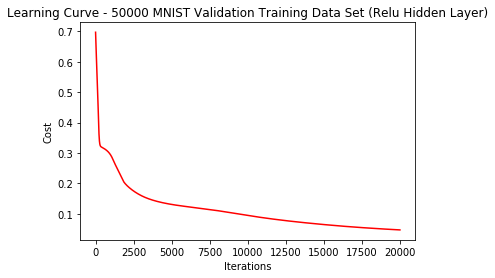

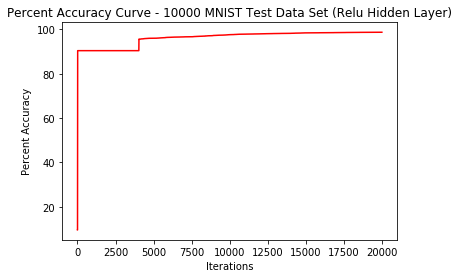

In [259]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01;
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

The results of these network lines up with what we would intuitively expect. We increased the number of units to 20 in the 2 hidden layers and therefore, we see a small improvements in cost and accuracy over the 2 hidden layer network that only had 5 units in the hidden layer. The cost for this ended at approximately 0.047, and the accuracy ended at 98.69% after 20,000 iterations. 

The next thing we want to explore is how our learning rate affects our accuracy. We need to keep the learning rate small to prevent buffer overflows in Python, therefore we will simply decrease it by an order of magnitude. We will use 5 units in 2 hidden layers again and set up everything else the same as we did for our first full data set run. This should help us draw inference about the impact.

First, we re-initialize our weights and bias's with 5 units.

In [261]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(3,)
(3,)


Now we re-run our gradient descent with the adjusted learning rate

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373
Main Loop Iteration: 374


Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701
Main Loop Iteration: 702
Main Loop Iteration: 703


Main Loop Iteration: 993
Main Loop Iteration: 994
Main Loop Iteration: 995
Main Loop Iteration: 996
Main Loop Iteration: 997
Main Loop Iteration: 998
Main Loop Iteration: 999
Main Loop Iteration: 1000
Main Loop Iteration: 1001
Main Loop Iteration: 1002
Main Loop Iteration: 1003
Main Loop Iteration: 1004
Main Loop Iteration: 1005
Main Loop Iteration: 1006
Main Loop Iteration: 1007
Main Loop Iteration: 1008
Main Loop Iteration: 1009
Main Loop Iteration: 1010
Main Loop Iteration: 1011
Main Loop Iteration: 1012
Main Loop Iteration: 1013
Main Loop Iteration: 1014
Main Loop Iteration: 1015
Main Loop Iteration: 1016
Main Loop Iteration: 1017
Main Loop Iteration: 1018
Main Loop Iteration: 1019
Main Loop Iteration: 1020
Main Loop Iteration: 1021
Main Loop Iteration: 1022
Main Loop Iteration: 1023
Main Loop Iteration: 1024
Main Loop Iteration: 1025
Main Loop Iteration: 1026
Main Loop Iteration: 1027
Main Loop Iteration: 1028
Main Loop Iteration: 1029
Main Loop Iteration: 1030
Main Loop Iteration

Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop Iteration: 1343
Main Loop Iteration: 1344
Main Loop Iteration: 1345
Main Loop Iteration: 1346
Main Loop It

Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop Iteration: 1659
Main Loop Iteration: 1660
Main Loop Iteration: 1661
Main Loop Iteration: 1662
Main Loop It

Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop Iteration: 1975
Main Loop Iteration: 1976
Main Loop Iteration: 1977
Main Loop Iteration: 1978
Main Loop Iteration: 1979
Main Loop It

Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop Iteration: 2291
Main Loop Iteration: 2292
Main Loop Iteration: 2293
Main Loop Iteration: 2294
Main Loop Iteration: 2295
Main Loop It

Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop Iteration: 2606
Main Loop Iteration: 2607
Main Loop Iteration: 2608
Main Loop Iteration: 2609
Main Loop Iteration: 2610
Main Loop Iteration: 2611
Main Loop Iteration: 2612
Main Loop It

Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop Iteration: 2922
Main Loop Iteration: 2923
Main Loop Iteration: 2924
Main Loop Iteration: 2925
Main Loop Iteration: 2926
Main Loop Iteration: 2927
Main Loop Iteration: 2928
Main Loop It

Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop Iteration: 3238
Main Loop Iteration: 3239
Main Loop Iteration: 3240
Main Loop Iteration: 3241
Main Loop Iteration: 3242
Main Loop Iteration: 3243
Main Loop Iteration: 3244
Main Loop Iteration: 3245
Main Loop It

Main Loop Iteration: 3524
Main Loop Iteration: 3525
Main Loop Iteration: 3526
Main Loop Iteration: 3527
Main Loop Iteration: 3528
Main Loop Iteration: 3529
Main Loop Iteration: 3530
Main Loop Iteration: 3531
Main Loop Iteration: 3532
Main Loop Iteration: 3533
Main Loop Iteration: 3534
Main Loop Iteration: 3535
Main Loop Iteration: 3536
Main Loop Iteration: 3537
Main Loop Iteration: 3538
Main Loop Iteration: 3539
Main Loop Iteration: 3540
Main Loop Iteration: 3541
Main Loop Iteration: 3542
Main Loop Iteration: 3543
Main Loop Iteration: 3544
Main Loop Iteration: 3545
Main Loop Iteration: 3546
Main Loop Iteration: 3547
Main Loop Iteration: 3548
Main Loop Iteration: 3549
Main Loop Iteration: 3550
Main Loop Iteration: 3551
Main Loop Iteration: 3552
Main Loop Iteration: 3553
Main Loop Iteration: 3554
Main Loop Iteration: 3555
Main Loop Iteration: 3556
Main Loop Iteration: 3557
Main Loop Iteration: 3558
Main Loop Iteration: 3559
Main Loop Iteration: 3560
Main Loop Iteration: 3561
Main Loop It

Main Loop Iteration: 3840
Main Loop Iteration: 3841
Main Loop Iteration: 3842
Main Loop Iteration: 3843
Main Loop Iteration: 3844
Main Loop Iteration: 3845
Main Loop Iteration: 3846
Main Loop Iteration: 3847
Main Loop Iteration: 3848
Main Loop Iteration: 3849
Main Loop Iteration: 3850
Main Loop Iteration: 3851
Main Loop Iteration: 3852
Main Loop Iteration: 3853
Main Loop Iteration: 3854
Main Loop Iteration: 3855
Main Loop Iteration: 3856
Main Loop Iteration: 3857
Main Loop Iteration: 3858
Main Loop Iteration: 3859
Main Loop Iteration: 3860
Main Loop Iteration: 3861
Main Loop Iteration: 3862
Main Loop Iteration: 3863
Main Loop Iteration: 3864
Main Loop Iteration: 3865
Main Loop Iteration: 3866
Main Loop Iteration: 3867
Main Loop Iteration: 3868
Main Loop Iteration: 3869
Main Loop Iteration: 3870
Main Loop Iteration: 3871
Main Loop Iteration: 3872
Main Loop Iteration: 3873
Main Loop Iteration: 3874
Main Loop Iteration: 3875
Main Loop Iteration: 3876
Main Loop Iteration: 3877
Main Loop It

Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop Iteration: 4186
Main Loop Iteration: 4187
Main Loop Iteration: 4188
Main Loop Iteration: 4189
Main Loop Iteration: 4190
Main Loop Iteration: 4191
Main Loop Iteration: 4192
Main Loop Iteration: 4193
Main Loop It

Main Loop Iteration: 4472
Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop Iteration: 4502
Main Loop Iteration: 4503
Main Loop Iteration: 4504
Main Loop Iteration: 4505
Main Loop Iteration: 4506
Main Loop Iteration: 4507
Main Loop Iteration: 4508
Main Loop Iteration: 4509
Main Loop It

Main Loop Iteration: 4788
Main Loop Iteration: 4789
Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop Iteration: 4818
Main Loop Iteration: 4819
Main Loop Iteration: 4820
Main Loop Iteration: 4821
Main Loop Iteration: 4822
Main Loop Iteration: 4823
Main Loop Iteration: 4824
Main Loop Iteration: 4825
Main Loop It

Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop Iteration: 5134
Main Loop Iteration: 5135
Main Loop Iteration: 5136
Main Loop Iteration: 5137
Main Loop Iteration: 5138
Main Loop Iteration: 5139
Main Loop Iteration: 5140
Main Loop Iteration: 5141
Main Loop It

Main Loop Iteration: 5421
Main Loop Iteration: 5422
Main Loop Iteration: 5423
Main Loop Iteration: 5424
Main Loop Iteration: 5425
Main Loop Iteration: 5426
Main Loop Iteration: 5427
Main Loop Iteration: 5428
Main Loop Iteration: 5429
Main Loop Iteration: 5430
Main Loop Iteration: 5431
Main Loop Iteration: 5432
Main Loop Iteration: 5433
Main Loop Iteration: 5434
Main Loop Iteration: 5435
Main Loop Iteration: 5436
Main Loop Iteration: 5437
Main Loop Iteration: 5438
Main Loop Iteration: 5439
Main Loop Iteration: 5440
Main Loop Iteration: 5441
Main Loop Iteration: 5442
Main Loop Iteration: 5443
Main Loop Iteration: 5444
Main Loop Iteration: 5445
Main Loop Iteration: 5446
Main Loop Iteration: 5447
Main Loop Iteration: 5448
Main Loop Iteration: 5449
Main Loop Iteration: 5450
Main Loop Iteration: 5451
Main Loop Iteration: 5452
Main Loop Iteration: 5453
Main Loop Iteration: 5454
Main Loop Iteration: 5455
Main Loop Iteration: 5456
Main Loop Iteration: 5457
Main Loop Iteration: 5458
Main Loop It

Main Loop Iteration: 5737
Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop Iteration: 5767
Main Loop Iteration: 5768
Main Loop Iteration: 5769
Main Loop Iteration: 5770
Main Loop Iteration: 5771
Main Loop Iteration: 5772
Main Loop Iteration: 5773
Main Loop Iteration: 5774
Main Loop It

Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop Iteration: 6081
Main Loop Iteration: 6082
Main Loop Iteration: 6083
Main Loop Iteration: 6084
Main Loop Iteration: 6085
Main Loop Iteration: 6086
Main Loop Iteration: 6087
Main Loop Iteration: 6088
Main Loop Iteration: 6089
Main Loop Iteration: 6090
Main Loop Iteration: 6091
Main Loop It

Main Loop Iteration: 6371
Main Loop Iteration: 6372
Main Loop Iteration: 6373
Main Loop Iteration: 6374
Main Loop Iteration: 6375
Main Loop Iteration: 6376
Main Loop Iteration: 6377
Main Loop Iteration: 6378
Main Loop Iteration: 6379
Main Loop Iteration: 6380
Main Loop Iteration: 6381
Main Loop Iteration: 6382
Main Loop Iteration: 6383
Main Loop Iteration: 6384
Main Loop Iteration: 6385
Main Loop Iteration: 6386
Main Loop Iteration: 6387
Main Loop Iteration: 6388
Main Loop Iteration: 6389
Main Loop Iteration: 6390
Main Loop Iteration: 6391
Main Loop Iteration: 6392
Main Loop Iteration: 6393
Main Loop Iteration: 6394
Main Loop Iteration: 6395
Main Loop Iteration: 6396
Main Loop Iteration: 6397
Main Loop Iteration: 6398
Main Loop Iteration: 6399
Main Loop Iteration: 6400
Main Loop Iteration: 6401
Main Loop Iteration: 6402
Main Loop Iteration: 6403
Main Loop Iteration: 6404
Main Loop Iteration: 6405
Main Loop Iteration: 6406
Main Loop Iteration: 6407
Main Loop Iteration: 6408
Main Loop It

Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop Iteration: 6713
Main Loop Iteration: 6714
Main Loop Iteration: 6715
Main Loop Iteration: 6716
Main Loop Iteration: 6717
Main Loop Iteration: 6718
Main Loop Iteration: 6719
Main Loop Iteration: 6720
Main Loop Iteration: 6721
Main Loop Iteration: 6722
Main Loop Iteration: 6723
Main Loop Iteration: 6724
Main Loop Iteration: 6725
Main Loop It

Main Loop Iteration: 7005
Main Loop Iteration: 7006
Main Loop Iteration: 7007
Main Loop Iteration: 7008
Main Loop Iteration: 7009
Main Loop Iteration: 7010
Main Loop Iteration: 7011
Main Loop Iteration: 7012
Main Loop Iteration: 7013
Main Loop Iteration: 7014
Main Loop Iteration: 7015
Main Loop Iteration: 7016
Main Loop Iteration: 7017
Main Loop Iteration: 7018
Main Loop Iteration: 7019
Main Loop Iteration: 7020
Main Loop Iteration: 7021
Main Loop Iteration: 7022
Main Loop Iteration: 7023
Main Loop Iteration: 7024
Main Loop Iteration: 7025
Main Loop Iteration: 7026
Main Loop Iteration: 7027
Main Loop Iteration: 7028
Main Loop Iteration: 7029
Main Loop Iteration: 7030
Main Loop Iteration: 7031
Main Loop Iteration: 7032
Main Loop Iteration: 7033
Main Loop Iteration: 7034
Main Loop Iteration: 7035
Main Loop Iteration: 7036
Main Loop Iteration: 7037
Main Loop Iteration: 7038
Main Loop Iteration: 7039
Main Loop Iteration: 7040
Main Loop Iteration: 7041
Main Loop Iteration: 7042
Main Loop It

Main Loop Iteration: 7321
Main Loop Iteration: 7322
Main Loop Iteration: 7323
Main Loop Iteration: 7324
Main Loop Iteration: 7325
Main Loop Iteration: 7326
Main Loop Iteration: 7327
Main Loop Iteration: 7328
Main Loop Iteration: 7329
Main Loop Iteration: 7330
Main Loop Iteration: 7331
Main Loop Iteration: 7332
Main Loop Iteration: 7333
Main Loop Iteration: 7334
Main Loop Iteration: 7335
Main Loop Iteration: 7336
Main Loop Iteration: 7337
Main Loop Iteration: 7338
Main Loop Iteration: 7339
Main Loop Iteration: 7340
Main Loop Iteration: 7341
Main Loop Iteration: 7342
Main Loop Iteration: 7343
Main Loop Iteration: 7344
Main Loop Iteration: 7345
Main Loop Iteration: 7346
Main Loop Iteration: 7347
Main Loop Iteration: 7348
Main Loop Iteration: 7349
Main Loop Iteration: 7350
Main Loop Iteration: 7351
Main Loop Iteration: 7352
Main Loop Iteration: 7353
Main Loop Iteration: 7354
Main Loop Iteration: 7355
Main Loop Iteration: 7356
Main Loop Iteration: 7357
Main Loop Iteration: 7358
Main Loop It

Main Loop Iteration: 7638
Main Loop Iteration: 7639
Main Loop Iteration: 7640
Main Loop Iteration: 7641
Main Loop Iteration: 7642
Main Loop Iteration: 7643
Main Loop Iteration: 7644
Main Loop Iteration: 7645
Main Loop Iteration: 7646
Main Loop Iteration: 7647
Main Loop Iteration: 7648
Main Loop Iteration: 7649
Main Loop Iteration: 7650
Main Loop Iteration: 7651
Main Loop Iteration: 7652
Main Loop Iteration: 7653
Main Loop Iteration: 7654
Main Loop Iteration: 7655
Main Loop Iteration: 7656
Main Loop Iteration: 7657
Main Loop Iteration: 7658
Main Loop Iteration: 7659
Main Loop Iteration: 7660
Main Loop Iteration: 7661
Main Loop Iteration: 7662
Main Loop Iteration: 7663
Main Loop Iteration: 7664
Main Loop Iteration: 7665
Main Loop Iteration: 7666
Main Loop Iteration: 7667
Main Loop Iteration: 7668
Main Loop Iteration: 7669
Main Loop Iteration: 7670
Main Loop Iteration: 7671
Main Loop Iteration: 7672
Main Loop Iteration: 7673
Main Loop Iteration: 7674
Main Loop Iteration: 7675
Main Loop It

Main Loop Iteration: 7954
Main Loop Iteration: 7955
Main Loop Iteration: 7956
Main Loop Iteration: 7957
Main Loop Iteration: 7958
Main Loop Iteration: 7959
Main Loop Iteration: 7960
Main Loop Iteration: 7961
Main Loop Iteration: 7962
Main Loop Iteration: 7963
Main Loop Iteration: 7964
Main Loop Iteration: 7965
Main Loop Iteration: 7966
Main Loop Iteration: 7967
Main Loop Iteration: 7968
Main Loop Iteration: 7969
Main Loop Iteration: 7970
Main Loop Iteration: 7971
Main Loop Iteration: 7972
Main Loop Iteration: 7973
Main Loop Iteration: 7974
Main Loop Iteration: 7975
Main Loop Iteration: 7976
Main Loop Iteration: 7977
Main Loop Iteration: 7978
Main Loop Iteration: 7979
Main Loop Iteration: 7980
Main Loop Iteration: 7981
Main Loop Iteration: 7982
Main Loop Iteration: 7983
Main Loop Iteration: 7984
Main Loop Iteration: 7985
Main Loop Iteration: 7986
Main Loop Iteration: 7987
Main Loop Iteration: 7988
Main Loop Iteration: 7989
Main Loop Iteration: 7990
Main Loop Iteration: 7991
Main Loop It

Main Loop Iteration: 8586
Main Loop Iteration: 8587
Main Loop Iteration: 8588
Main Loop Iteration: 8589
Main Loop Iteration: 8590
Main Loop Iteration: 8591
Main Loop Iteration: 8592
Main Loop Iteration: 8593
Main Loop Iteration: 8594
Main Loop Iteration: 8595
Main Loop Iteration: 8596
Main Loop Iteration: 8597
Main Loop Iteration: 8598
Main Loop Iteration: 8599
Main Loop Iteration: 8600
Main Loop Iteration: 8601
Main Loop Iteration: 8602
Main Loop Iteration: 8603
Main Loop Iteration: 8604
Main Loop Iteration: 8605
Main Loop Iteration: 8606
Main Loop Iteration: 8607
Main Loop Iteration: 8608
Main Loop Iteration: 8609
Main Loop Iteration: 8610
Main Loop Iteration: 8611
Main Loop Iteration: 8612
Main Loop Iteration: 8613
Main Loop Iteration: 8614
Main Loop Iteration: 8615
Main Loop Iteration: 8616
Main Loop Iteration: 8617
Main Loop Iteration: 8618
Main Loop Iteration: 8619
Main Loop Iteration: 8620
Main Loop Iteration: 8621
Main Loop Iteration: 8622
Main Loop Iteration: 8623
Main Loop It

Main Loop Iteration: 8903
Main Loop Iteration: 8904
Main Loop Iteration: 8905
Main Loop Iteration: 8906
Main Loop Iteration: 8907
Main Loop Iteration: 8908
Main Loop Iteration: 8909
Main Loop Iteration: 8910
Main Loop Iteration: 8911
Main Loop Iteration: 8912
Main Loop Iteration: 8913
Main Loop Iteration: 8914
Main Loop Iteration: 8915
Main Loop Iteration: 8916
Main Loop Iteration: 8917
Main Loop Iteration: 8918
Main Loop Iteration: 8919
Main Loop Iteration: 8920
Main Loop Iteration: 8921
Main Loop Iteration: 8922
Main Loop Iteration: 8923
Main Loop Iteration: 8924
Main Loop Iteration: 8925
Main Loop Iteration: 8926
Main Loop Iteration: 8927
Main Loop Iteration: 8928
Main Loop Iteration: 8929
Main Loop Iteration: 8930
Main Loop Iteration: 8931
Main Loop Iteration: 8932
Main Loop Iteration: 8933
Main Loop Iteration: 8934
Main Loop Iteration: 8935
Main Loop Iteration: 8936
Main Loop Iteration: 8937
Main Loop Iteration: 8938
Main Loop Iteration: 8939
Main Loop Iteration: 8940
Main Loop It

Main Loop Iteration: 9219
Main Loop Iteration: 9220
Main Loop Iteration: 9221
Main Loop Iteration: 9222
Main Loop Iteration: 9223
Main Loop Iteration: 9224
Main Loop Iteration: 9225
Main Loop Iteration: 9226
Main Loop Iteration: 9227
Main Loop Iteration: 9228
Main Loop Iteration: 9229
Main Loop Iteration: 9230
Main Loop Iteration: 9231
Main Loop Iteration: 9232
Main Loop Iteration: 9233
Main Loop Iteration: 9234
Main Loop Iteration: 9235
Main Loop Iteration: 9236
Main Loop Iteration: 9237
Main Loop Iteration: 9238
Main Loop Iteration: 9239
Main Loop Iteration: 9240
Main Loop Iteration: 9241
Main Loop Iteration: 9242
Main Loop Iteration: 9243
Main Loop Iteration: 9244
Main Loop Iteration: 9245
Main Loop Iteration: 9246
Main Loop Iteration: 9247
Main Loop Iteration: 9248
Main Loop Iteration: 9249
Main Loop Iteration: 9250
Main Loop Iteration: 9251
Main Loop Iteration: 9252
Main Loop Iteration: 9253
Main Loop Iteration: 9254
Main Loop Iteration: 9255
Main Loop Iteration: 9256
Main Loop It

Main Loop Iteration: 9536
Main Loop Iteration: 9537
Main Loop Iteration: 9538
Main Loop Iteration: 9539
Main Loop Iteration: 9540
Main Loop Iteration: 9541
Main Loop Iteration: 9542
Main Loop Iteration: 9543
Main Loop Iteration: 9544
Main Loop Iteration: 9545
Main Loop Iteration: 9546
Main Loop Iteration: 9547
Main Loop Iteration: 9548
Main Loop Iteration: 9549
Main Loop Iteration: 9550
Main Loop Iteration: 9551
Main Loop Iteration: 9552
Main Loop Iteration: 9553
Main Loop Iteration: 9554
Main Loop Iteration: 9555
Main Loop Iteration: 9556
Main Loop Iteration: 9557
Main Loop Iteration: 9558
Main Loop Iteration: 9559
Main Loop Iteration: 9560
Main Loop Iteration: 9561
Main Loop Iteration: 9562
Main Loop Iteration: 9563
Main Loop Iteration: 9564
Main Loop Iteration: 9565
Main Loop Iteration: 9566
Main Loop Iteration: 9567
Main Loop Iteration: 9568
Main Loop Iteration: 9569
Main Loop Iteration: 9570
Main Loop Iteration: 9571
Main Loop Iteration: 9572
Main Loop Iteration: 9573
Main Loop It

Main Loop Iteration: 9853
Main Loop Iteration: 9854
Main Loop Iteration: 9855
Main Loop Iteration: 9856
Main Loop Iteration: 9857
Main Loop Iteration: 9858
Main Loop Iteration: 9859
Main Loop Iteration: 9860
Main Loop Iteration: 9861
Main Loop Iteration: 9862
Main Loop Iteration: 9863
Main Loop Iteration: 9864
Main Loop Iteration: 9865
Main Loop Iteration: 9866
Main Loop Iteration: 9867
Main Loop Iteration: 9868
Main Loop Iteration: 9869
Main Loop Iteration: 9870
Main Loop Iteration: 9871
Main Loop Iteration: 9872
Main Loop Iteration: 9873
Main Loop Iteration: 9874
Main Loop Iteration: 9875
Main Loop Iteration: 9876
Main Loop Iteration: 9877
Main Loop Iteration: 9878
Main Loop Iteration: 9879
Main Loop Iteration: 9880
Main Loop Iteration: 9881
Main Loop Iteration: 9882
Main Loop Iteration: 9883
Main Loop Iteration: 9884
Main Loop Iteration: 9885
Main Loop Iteration: 9886
Main Loop Iteration: 9887
Main Loop Iteration: 9888
Main Loop Iteration: 9889
Main Loop Iteration: 9890
Main Loop It

Main Loop Iteration: 10162
Main Loop Iteration: 10163
Main Loop Iteration: 10164
Main Loop Iteration: 10165
Main Loop Iteration: 10166
Main Loop Iteration: 10167
Main Loop Iteration: 10168
Main Loop Iteration: 10169
Main Loop Iteration: 10170
Main Loop Iteration: 10171
Main Loop Iteration: 10172
Main Loop Iteration: 10173
Main Loop Iteration: 10174
Main Loop Iteration: 10175
Main Loop Iteration: 10176
Main Loop Iteration: 10177
Main Loop Iteration: 10178
Main Loop Iteration: 10179
Main Loop Iteration: 10180
Main Loop Iteration: 10181
Main Loop Iteration: 10182
Main Loop Iteration: 10183
Main Loop Iteration: 10184
Main Loop Iteration: 10185
Main Loop Iteration: 10186
Main Loop Iteration: 10187
Main Loop Iteration: 10188
Main Loop Iteration: 10189
Main Loop Iteration: 10190
Main Loop Iteration: 10191
Main Loop Iteration: 10192
Main Loop Iteration: 10193
Main Loop Iteration: 10194
Main Loop Iteration: 10195
Main Loop Iteration: 10196
Main Loop Iteration: 10197
Main Loop Iteration: 10198
M

Main Loop Iteration: 10467
Main Loop Iteration: 10468
Main Loop Iteration: 10469
Main Loop Iteration: 10470
Main Loop Iteration: 10471
Main Loop Iteration: 10472
Main Loop Iteration: 10473
Main Loop Iteration: 10474
Main Loop Iteration: 10475
Main Loop Iteration: 10476
Main Loop Iteration: 10477
Main Loop Iteration: 10478
Main Loop Iteration: 10479
Main Loop Iteration: 10480
Main Loop Iteration: 10481
Main Loop Iteration: 10482
Main Loop Iteration: 10483
Main Loop Iteration: 10484
Main Loop Iteration: 10485
Main Loop Iteration: 10486
Main Loop Iteration: 10487
Main Loop Iteration: 10488
Main Loop Iteration: 10489
Main Loop Iteration: 10490
Main Loop Iteration: 10491
Main Loop Iteration: 10492
Main Loop Iteration: 10493
Main Loop Iteration: 10494
Main Loop Iteration: 10495
Main Loop Iteration: 10496
Main Loop Iteration: 10497
Main Loop Iteration: 10498
Main Loop Iteration: 10499
Main Loop Iteration: 10500
Main Loop Iteration: 10501
Main Loop Iteration: 10502
Main Loop Iteration: 10503
M

Main Loop Iteration: 10772
Main Loop Iteration: 10773
Main Loop Iteration: 10774
Main Loop Iteration: 10775
Main Loop Iteration: 10776
Main Loop Iteration: 10777
Main Loop Iteration: 10778
Main Loop Iteration: 10779
Main Loop Iteration: 10780
Main Loop Iteration: 10781
Main Loop Iteration: 10782
Main Loop Iteration: 10783
Main Loop Iteration: 10784
Main Loop Iteration: 10785
Main Loop Iteration: 10786
Main Loop Iteration: 10787
Main Loop Iteration: 10788
Main Loop Iteration: 10789
Main Loop Iteration: 10790
Main Loop Iteration: 10791
Main Loop Iteration: 10792
Main Loop Iteration: 10793
Main Loop Iteration: 10794
Main Loop Iteration: 10795
Main Loop Iteration: 10796
Main Loop Iteration: 10797
Main Loop Iteration: 10798
Main Loop Iteration: 10799
Main Loop Iteration: 10800
Main Loop Iteration: 10801
Main Loop Iteration: 10802
Main Loop Iteration: 10803
Main Loop Iteration: 10804
Main Loop Iteration: 10805
Main Loop Iteration: 10806
Main Loop Iteration: 10807
Main Loop Iteration: 10808
M

Main Loop Iteration: 11077
Main Loop Iteration: 11078
Main Loop Iteration: 11079
Main Loop Iteration: 11080
Main Loop Iteration: 11081
Main Loop Iteration: 11082
Main Loop Iteration: 11083
Main Loop Iteration: 11084
Main Loop Iteration: 11085
Main Loop Iteration: 11086
Main Loop Iteration: 11087
Main Loop Iteration: 11088
Main Loop Iteration: 11089
Main Loop Iteration: 11090
Main Loop Iteration: 11091
Main Loop Iteration: 11092
Main Loop Iteration: 11093
Main Loop Iteration: 11094
Main Loop Iteration: 11095
Main Loop Iteration: 11096
Main Loop Iteration: 11097
Main Loop Iteration: 11098
Main Loop Iteration: 11099
Main Loop Iteration: 11100
Main Loop Iteration: 11101
Main Loop Iteration: 11102
Main Loop Iteration: 11103
Main Loop Iteration: 11104
Main Loop Iteration: 11105
Main Loop Iteration: 11106
Main Loop Iteration: 11107
Main Loop Iteration: 11108
Main Loop Iteration: 11109
Main Loop Iteration: 11110
Main Loop Iteration: 11111
Main Loop Iteration: 11112
Main Loop Iteration: 11113
M

Main Loop Iteration: 11382
Main Loop Iteration: 11383
Main Loop Iteration: 11384
Main Loop Iteration: 11385
Main Loop Iteration: 11386
Main Loop Iteration: 11387
Main Loop Iteration: 11388
Main Loop Iteration: 11389
Main Loop Iteration: 11390
Main Loop Iteration: 11391
Main Loop Iteration: 11392
Main Loop Iteration: 11393
Main Loop Iteration: 11394
Main Loop Iteration: 11395
Main Loop Iteration: 11396
Main Loop Iteration: 11397
Main Loop Iteration: 11398
Main Loop Iteration: 11399
Main Loop Iteration: 11400
Main Loop Iteration: 11401
Main Loop Iteration: 11402
Main Loop Iteration: 11403
Main Loop Iteration: 11404
Main Loop Iteration: 11405
Main Loop Iteration: 11406
Main Loop Iteration: 11407
Main Loop Iteration: 11408
Main Loop Iteration: 11409
Main Loop Iteration: 11410
Main Loop Iteration: 11411
Main Loop Iteration: 11412
Main Loop Iteration: 11413
Main Loop Iteration: 11414
Main Loop Iteration: 11415
Main Loop Iteration: 11416
Main Loop Iteration: 11417
Main Loop Iteration: 11418
M

Main Loop Iteration: 11686
Main Loop Iteration: 11687
Main Loop Iteration: 11688
Main Loop Iteration: 11689
Main Loop Iteration: 11690
Main Loop Iteration: 11691
Main Loop Iteration: 11692
Main Loop Iteration: 11693
Main Loop Iteration: 11694
Main Loop Iteration: 11695
Main Loop Iteration: 11696
Main Loop Iteration: 11697
Main Loop Iteration: 11698
Main Loop Iteration: 11699
Main Loop Iteration: 11700
Main Loop Iteration: 11701
Main Loop Iteration: 11702
Main Loop Iteration: 11703
Main Loop Iteration: 11704
Main Loop Iteration: 11705
Main Loop Iteration: 11706
Main Loop Iteration: 11707
Main Loop Iteration: 11708
Main Loop Iteration: 11709
Main Loop Iteration: 11710
Main Loop Iteration: 11711
Main Loop Iteration: 11712
Main Loop Iteration: 11713
Main Loop Iteration: 11714
Main Loop Iteration: 11715
Main Loop Iteration: 11716
Main Loop Iteration: 11717
Main Loop Iteration: 11718
Main Loop Iteration: 11719
Main Loop Iteration: 11720
Main Loop Iteration: 11721
Main Loop Iteration: 11722
M

Main Loop Iteration: 11990
Main Loop Iteration: 11991
Main Loop Iteration: 11992
Main Loop Iteration: 11993
Main Loop Iteration: 11994
Main Loop Iteration: 11995
Main Loop Iteration: 11996
Main Loop Iteration: 11997
Main Loop Iteration: 11998
Main Loop Iteration: 11999
Main Loop Iteration: 12000
Main Loop Iteration: 12001
Main Loop Iteration: 12002
Main Loop Iteration: 12003
Main Loop Iteration: 12004
Main Loop Iteration: 12005
Main Loop Iteration: 12006
Main Loop Iteration: 12007
Main Loop Iteration: 12008
Main Loop Iteration: 12009
Main Loop Iteration: 12010
Main Loop Iteration: 12011
Main Loop Iteration: 12012
Main Loop Iteration: 12013
Main Loop Iteration: 12014
Main Loop Iteration: 12015
Main Loop Iteration: 12016
Main Loop Iteration: 12017
Main Loop Iteration: 12018
Main Loop Iteration: 12019
Main Loop Iteration: 12020
Main Loop Iteration: 12021
Main Loop Iteration: 12022
Main Loop Iteration: 12023
Main Loop Iteration: 12024
Main Loop Iteration: 12025
Main Loop Iteration: 12026
M

Main Loop Iteration: 12294
Main Loop Iteration: 12295
Main Loop Iteration: 12296
Main Loop Iteration: 12297
Main Loop Iteration: 12298
Main Loop Iteration: 12299
Main Loop Iteration: 12300
Main Loop Iteration: 12301
Main Loop Iteration: 12302
Main Loop Iteration: 12303
Main Loop Iteration: 12304
Main Loop Iteration: 12305
Main Loop Iteration: 12306
Main Loop Iteration: 12307
Main Loop Iteration: 12308
Main Loop Iteration: 12309
Main Loop Iteration: 12310
Main Loop Iteration: 12311
Main Loop Iteration: 12312
Main Loop Iteration: 12313
Main Loop Iteration: 12314
Main Loop Iteration: 12315
Main Loop Iteration: 12316
Main Loop Iteration: 12317
Main Loop Iteration: 12318
Main Loop Iteration: 12319
Main Loop Iteration: 12320
Main Loop Iteration: 12321
Main Loop Iteration: 12322
Main Loop Iteration: 12323
Main Loop Iteration: 12324
Main Loop Iteration: 12325
Main Loop Iteration: 12326
Main Loop Iteration: 12327
Main Loop Iteration: 12328
Main Loop Iteration: 12329
Main Loop Iteration: 12330
M

Main Loop Iteration: 12599
Main Loop Iteration: 12600
Main Loop Iteration: 12601
Main Loop Iteration: 12602
Main Loop Iteration: 12603
Main Loop Iteration: 12604
Main Loop Iteration: 12605
Main Loop Iteration: 12606
Main Loop Iteration: 12607
Main Loop Iteration: 12608
Main Loop Iteration: 12609
Main Loop Iteration: 12610
Main Loop Iteration: 12611
Main Loop Iteration: 12612
Main Loop Iteration: 12613
Main Loop Iteration: 12614
Main Loop Iteration: 12615
Main Loop Iteration: 12616
Main Loop Iteration: 12617
Main Loop Iteration: 12618
Main Loop Iteration: 12619
Main Loop Iteration: 12620
Main Loop Iteration: 12621
Main Loop Iteration: 12622
Main Loop Iteration: 12623
Main Loop Iteration: 12624
Main Loop Iteration: 12625
Main Loop Iteration: 12626
Main Loop Iteration: 12627
Main Loop Iteration: 12628
Main Loop Iteration: 12629
Main Loop Iteration: 12630
Main Loop Iteration: 12631
Main Loop Iteration: 12632
Main Loop Iteration: 12633
Main Loop Iteration: 12634
Main Loop Iteration: 12635
M

Main Loop Iteration: 12903
Main Loop Iteration: 12904
Main Loop Iteration: 12905
Main Loop Iteration: 12906
Main Loop Iteration: 12907
Main Loop Iteration: 12908
Main Loop Iteration: 12909
Main Loop Iteration: 12910
Main Loop Iteration: 12911
Main Loop Iteration: 12912
Main Loop Iteration: 12913
Main Loop Iteration: 12914
Main Loop Iteration: 12915
Main Loop Iteration: 12916
Main Loop Iteration: 12917
Main Loop Iteration: 12918
Main Loop Iteration: 12919
Main Loop Iteration: 12920
Main Loop Iteration: 12921
Main Loop Iteration: 12922
Main Loop Iteration: 12923
Main Loop Iteration: 12924
Main Loop Iteration: 12925
Main Loop Iteration: 12926
Main Loop Iteration: 12927
Main Loop Iteration: 12928
Main Loop Iteration: 12929
Main Loop Iteration: 12930
Main Loop Iteration: 12931
Main Loop Iteration: 12932
Main Loop Iteration: 12933
Main Loop Iteration: 12934
Main Loop Iteration: 12935
Main Loop Iteration: 12936
Main Loop Iteration: 12937
Main Loop Iteration: 12938
Main Loop Iteration: 12939
M

Main Loop Iteration: 13208
Main Loop Iteration: 13209
Main Loop Iteration: 13210
Main Loop Iteration: 13211
Main Loop Iteration: 13212
Main Loop Iteration: 13213
Main Loop Iteration: 13214
Main Loop Iteration: 13215
Main Loop Iteration: 13216
Main Loop Iteration: 13217
Main Loop Iteration: 13218
Main Loop Iteration: 13219
Main Loop Iteration: 13220
Main Loop Iteration: 13221
Main Loop Iteration: 13222
Main Loop Iteration: 13223
Main Loop Iteration: 13224
Main Loop Iteration: 13225
Main Loop Iteration: 13226
Main Loop Iteration: 13227
Main Loop Iteration: 13228
Main Loop Iteration: 13229
Main Loop Iteration: 13230
Main Loop Iteration: 13231
Main Loop Iteration: 13232
Main Loop Iteration: 13233
Main Loop Iteration: 13234
Main Loop Iteration: 13235
Main Loop Iteration: 13236
Main Loop Iteration: 13237
Main Loop Iteration: 13238
Main Loop Iteration: 13239
Main Loop Iteration: 13240
Main Loop Iteration: 13241
Main Loop Iteration: 13242
Main Loop Iteration: 13243
Main Loop Iteration: 13244
M

Main Loop Iteration: 13512
Main Loop Iteration: 13513
Main Loop Iteration: 13514
Main Loop Iteration: 13515
Main Loop Iteration: 13516
Main Loop Iteration: 13517
Main Loop Iteration: 13518
Main Loop Iteration: 13519
Main Loop Iteration: 13520
Main Loop Iteration: 13521
Main Loop Iteration: 13522
Main Loop Iteration: 13523
Main Loop Iteration: 13524
Main Loop Iteration: 13525
Main Loop Iteration: 13526
Main Loop Iteration: 13527
Main Loop Iteration: 13528
Main Loop Iteration: 13529
Main Loop Iteration: 13530
Main Loop Iteration: 13531
Main Loop Iteration: 13532
Main Loop Iteration: 13533
Main Loop Iteration: 13534
Main Loop Iteration: 13535
Main Loop Iteration: 13536
Main Loop Iteration: 13537
Main Loop Iteration: 13538
Main Loop Iteration: 13539
Main Loop Iteration: 13540
Main Loop Iteration: 13541
Main Loop Iteration: 13542
Main Loop Iteration: 13543
Main Loop Iteration: 13544
Main Loop Iteration: 13545
Main Loop Iteration: 13546
Main Loop Iteration: 13547
Main Loop Iteration: 13548
M

Main Loop Iteration: 13816
Main Loop Iteration: 13817
Main Loop Iteration: 13818
Main Loop Iteration: 13819
Main Loop Iteration: 13820
Main Loop Iteration: 13821
Main Loop Iteration: 13822
Main Loop Iteration: 13823
Main Loop Iteration: 13824
Main Loop Iteration: 13825
Main Loop Iteration: 13826
Main Loop Iteration: 13827
Main Loop Iteration: 13828
Main Loop Iteration: 13829
Main Loop Iteration: 13830
Main Loop Iteration: 13831
Main Loop Iteration: 13832
Main Loop Iteration: 13833
Main Loop Iteration: 13834
Main Loop Iteration: 13835
Main Loop Iteration: 13836
Main Loop Iteration: 13837
Main Loop Iteration: 13838
Main Loop Iteration: 13839
Main Loop Iteration: 13840
Main Loop Iteration: 13841
Main Loop Iteration: 13842
Main Loop Iteration: 13843
Main Loop Iteration: 13844
Main Loop Iteration: 13845
Main Loop Iteration: 13846
Main Loop Iteration: 13847
Main Loop Iteration: 13848
Main Loop Iteration: 13849
Main Loop Iteration: 13850
Main Loop Iteration: 13851
Main Loop Iteration: 13852
M

Main Loop Iteration: 14121
Main Loop Iteration: 14122
Main Loop Iteration: 14123
Main Loop Iteration: 14124
Main Loop Iteration: 14125
Main Loop Iteration: 14126
Main Loop Iteration: 14127
Main Loop Iteration: 14128
Main Loop Iteration: 14129
Main Loop Iteration: 14130
Main Loop Iteration: 14131
Main Loop Iteration: 14132
Main Loop Iteration: 14133
Main Loop Iteration: 14134
Main Loop Iteration: 14135
Main Loop Iteration: 14136
Main Loop Iteration: 14137
Main Loop Iteration: 14138
Main Loop Iteration: 14139
Main Loop Iteration: 14140
Main Loop Iteration: 14141
Main Loop Iteration: 14142
Main Loop Iteration: 14143
Main Loop Iteration: 14144
Main Loop Iteration: 14145
Main Loop Iteration: 14146
Main Loop Iteration: 14147
Main Loop Iteration: 14148
Main Loop Iteration: 14149
Main Loop Iteration: 14150
Main Loop Iteration: 14151
Main Loop Iteration: 14152
Main Loop Iteration: 14153
Main Loop Iteration: 14154
Main Loop Iteration: 14155
Main Loop Iteration: 14156
Main Loop Iteration: 14157
M

Main Loop Iteration: 14425
Main Loop Iteration: 14426
Main Loop Iteration: 14427
Main Loop Iteration: 14428
Main Loop Iteration: 14429
Main Loop Iteration: 14430
Main Loop Iteration: 14431
Main Loop Iteration: 14432
Main Loop Iteration: 14433
Main Loop Iteration: 14434
Main Loop Iteration: 14435
Main Loop Iteration: 14436
Main Loop Iteration: 14437
Main Loop Iteration: 14438
Main Loop Iteration: 14439
Main Loop Iteration: 14440
Main Loop Iteration: 14441
Main Loop Iteration: 14442
Main Loop Iteration: 14443
Main Loop Iteration: 14444
Main Loop Iteration: 14445
Main Loop Iteration: 14446
Main Loop Iteration: 14447
Main Loop Iteration: 14448
Main Loop Iteration: 14449
Main Loop Iteration: 14450
Main Loop Iteration: 14451
Main Loop Iteration: 14452
Main Loop Iteration: 14453
Main Loop Iteration: 14454
Main Loop Iteration: 14455
Main Loop Iteration: 14456
Main Loop Iteration: 14457
Main Loop Iteration: 14458
Main Loop Iteration: 14459
Main Loop Iteration: 14460
Main Loop Iteration: 14461
M

Main Loop Iteration: 14730
Main Loop Iteration: 14731
Main Loop Iteration: 14732
Main Loop Iteration: 14733
Main Loop Iteration: 14734
Main Loop Iteration: 14735
Main Loop Iteration: 14736
Main Loop Iteration: 14737
Main Loop Iteration: 14738
Main Loop Iteration: 14739
Main Loop Iteration: 14740
Main Loop Iteration: 14741
Main Loop Iteration: 14742
Main Loop Iteration: 14743
Main Loop Iteration: 14744
Main Loop Iteration: 14745
Main Loop Iteration: 14746
Main Loop Iteration: 14747
Main Loop Iteration: 14748
Main Loop Iteration: 14749
Main Loop Iteration: 14750
Main Loop Iteration: 14751
Main Loop Iteration: 14752
Main Loop Iteration: 14753
Main Loop Iteration: 14754
Main Loop Iteration: 14755
Main Loop Iteration: 14756
Main Loop Iteration: 14757
Main Loop Iteration: 14758
Main Loop Iteration: 14759
Main Loop Iteration: 14760
Main Loop Iteration: 14761
Main Loop Iteration: 14762
Main Loop Iteration: 14763
Main Loop Iteration: 14764
Main Loop Iteration: 14765
Main Loop Iteration: 14766
M

Main Loop Iteration: 15034
Main Loop Iteration: 15035
Main Loop Iteration: 15036
Main Loop Iteration: 15037
Main Loop Iteration: 15038
Main Loop Iteration: 15039
Main Loop Iteration: 15040
Main Loop Iteration: 15041
Main Loop Iteration: 15042
Main Loop Iteration: 15043
Main Loop Iteration: 15044
Main Loop Iteration: 15045
Main Loop Iteration: 15046
Main Loop Iteration: 15047
Main Loop Iteration: 15048
Main Loop Iteration: 15049
Main Loop Iteration: 15050
Main Loop Iteration: 15051
Main Loop Iteration: 15052
Main Loop Iteration: 15053
Main Loop Iteration: 15054
Main Loop Iteration: 15055
Main Loop Iteration: 15056
Main Loop Iteration: 15057
Main Loop Iteration: 15058
Main Loop Iteration: 15059
Main Loop Iteration: 15060
Main Loop Iteration: 15061
Main Loop Iteration: 15062
Main Loop Iteration: 15063
Main Loop Iteration: 15064
Main Loop Iteration: 15065
Main Loop Iteration: 15066
Main Loop Iteration: 15067
Main Loop Iteration: 15068
Main Loop Iteration: 15069
Main Loop Iteration: 15070
M

Main Loop Iteration: 15339
Main Loop Iteration: 15340
Main Loop Iteration: 15341
Main Loop Iteration: 15342
Main Loop Iteration: 15343
Main Loop Iteration: 15344
Main Loop Iteration: 15345
Main Loop Iteration: 15346
Main Loop Iteration: 15347
Main Loop Iteration: 15348
Main Loop Iteration: 15349
Main Loop Iteration: 15350
Main Loop Iteration: 15351
Main Loop Iteration: 15352
Main Loop Iteration: 15353
Main Loop Iteration: 15354
Main Loop Iteration: 15355
Main Loop Iteration: 15356
Main Loop Iteration: 15357
Main Loop Iteration: 15358
Main Loop Iteration: 15359
Main Loop Iteration: 15360
Main Loop Iteration: 15361
Main Loop Iteration: 15362
Main Loop Iteration: 15363
Main Loop Iteration: 15364
Main Loop Iteration: 15365
Main Loop Iteration: 15366
Main Loop Iteration: 15367
Main Loop Iteration: 15368
Main Loop Iteration: 15369
Main Loop Iteration: 15370
Main Loop Iteration: 15371
Main Loop Iteration: 15372
Main Loop Iteration: 15373
Main Loop Iteration: 15374
Main Loop Iteration: 15375
M

Main Loop Iteration: 15643
Main Loop Iteration: 15644
Main Loop Iteration: 15645
Main Loop Iteration: 15646
Main Loop Iteration: 15647
Main Loop Iteration: 15648
Main Loop Iteration: 15649
Main Loop Iteration: 15650
Main Loop Iteration: 15651
Main Loop Iteration: 15652
Main Loop Iteration: 15653
Main Loop Iteration: 15654
Main Loop Iteration: 15655
Main Loop Iteration: 15656
Main Loop Iteration: 15657
Main Loop Iteration: 15658
Main Loop Iteration: 15659
Main Loop Iteration: 15660
Main Loop Iteration: 15661
Main Loop Iteration: 15662
Main Loop Iteration: 15663
Main Loop Iteration: 15664
Main Loop Iteration: 15665
Main Loop Iteration: 15666
Main Loop Iteration: 15667
Main Loop Iteration: 15668
Main Loop Iteration: 15669
Main Loop Iteration: 15670
Main Loop Iteration: 15671
Main Loop Iteration: 15672
Main Loop Iteration: 15673
Main Loop Iteration: 15674
Main Loop Iteration: 15675
Main Loop Iteration: 15676
Main Loop Iteration: 15677
Main Loop Iteration: 15678
Main Loop Iteration: 15679
M

Main Loop Iteration: 15947
Main Loop Iteration: 15948
Main Loop Iteration: 15949
Main Loop Iteration: 15950
Main Loop Iteration: 15951
Main Loop Iteration: 15952
Main Loop Iteration: 15953
Main Loop Iteration: 15954
Main Loop Iteration: 15955
Main Loop Iteration: 15956
Main Loop Iteration: 15957
Main Loop Iteration: 15958
Main Loop Iteration: 15959
Main Loop Iteration: 15960
Main Loop Iteration: 15961
Main Loop Iteration: 15962
Main Loop Iteration: 15963
Main Loop Iteration: 15964
Main Loop Iteration: 15965
Main Loop Iteration: 15966
Main Loop Iteration: 15967
Main Loop Iteration: 15968
Main Loop Iteration: 15969
Main Loop Iteration: 15970
Main Loop Iteration: 15971
Main Loop Iteration: 15972
Main Loop Iteration: 15973
Main Loop Iteration: 15974
Main Loop Iteration: 15975
Main Loop Iteration: 15976
Main Loop Iteration: 15977
Main Loop Iteration: 15978
Main Loop Iteration: 15979
Main Loop Iteration: 15980
Main Loop Iteration: 15981
Main Loop Iteration: 15982
Main Loop Iteration: 15983
M

Main Loop Iteration: 16251
Main Loop Iteration: 16252
Main Loop Iteration: 16253
Main Loop Iteration: 16254
Main Loop Iteration: 16255
Main Loop Iteration: 16256
Main Loop Iteration: 16257
Main Loop Iteration: 16258
Main Loop Iteration: 16259
Main Loop Iteration: 16260
Main Loop Iteration: 16261
Main Loop Iteration: 16262
Main Loop Iteration: 16263
Main Loop Iteration: 16264
Main Loop Iteration: 16265
Main Loop Iteration: 16266
Main Loop Iteration: 16267
Main Loop Iteration: 16268
Main Loop Iteration: 16269
Main Loop Iteration: 16270
Main Loop Iteration: 16271
Main Loop Iteration: 16272
Main Loop Iteration: 16273
Main Loop Iteration: 16274
Main Loop Iteration: 16275
Main Loop Iteration: 16276
Main Loop Iteration: 16277
Main Loop Iteration: 16278
Main Loop Iteration: 16279
Main Loop Iteration: 16280
Main Loop Iteration: 16281
Main Loop Iteration: 16282
Main Loop Iteration: 16283
Main Loop Iteration: 16284
Main Loop Iteration: 16285
Main Loop Iteration: 16286
Main Loop Iteration: 16287
M

Main Loop Iteration: 16556
Main Loop Iteration: 16557
Main Loop Iteration: 16558
Main Loop Iteration: 16559
Main Loop Iteration: 16560
Main Loop Iteration: 16561
Main Loop Iteration: 16562
Main Loop Iteration: 16563
Main Loop Iteration: 16564
Main Loop Iteration: 16565
Main Loop Iteration: 16566
Main Loop Iteration: 16567
Main Loop Iteration: 16568
Main Loop Iteration: 16569
Main Loop Iteration: 16570
Main Loop Iteration: 16571
Main Loop Iteration: 16572
Main Loop Iteration: 16573
Main Loop Iteration: 16574
Main Loop Iteration: 16575
Main Loop Iteration: 16576
Main Loop Iteration: 16577
Main Loop Iteration: 16578
Main Loop Iteration: 16579
Main Loop Iteration: 16580
Main Loop Iteration: 16581
Main Loop Iteration: 16582
Main Loop Iteration: 16583
Main Loop Iteration: 16584
Main Loop Iteration: 16585
Main Loop Iteration: 16586
Main Loop Iteration: 16587
Main Loop Iteration: 16588
Main Loop Iteration: 16589
Main Loop Iteration: 16590
Main Loop Iteration: 16591
Main Loop Iteration: 16592
M

Main Loop Iteration: 16860
Main Loop Iteration: 16861
Main Loop Iteration: 16862
Main Loop Iteration: 16863
Main Loop Iteration: 16864
Main Loop Iteration: 16865
Main Loop Iteration: 16866
Main Loop Iteration: 16867
Main Loop Iteration: 16868
Main Loop Iteration: 16869
Main Loop Iteration: 16870
Main Loop Iteration: 16871
Main Loop Iteration: 16872
Main Loop Iteration: 16873
Main Loop Iteration: 16874
Main Loop Iteration: 16875
Main Loop Iteration: 16876
Main Loop Iteration: 16877
Main Loop Iteration: 16878
Main Loop Iteration: 16879
Main Loop Iteration: 16880
Main Loop Iteration: 16881
Main Loop Iteration: 16882
Main Loop Iteration: 16883
Main Loop Iteration: 16884
Main Loop Iteration: 16885
Main Loop Iteration: 16886
Main Loop Iteration: 16887
Main Loop Iteration: 16888
Main Loop Iteration: 16889
Main Loop Iteration: 16890
Main Loop Iteration: 16891
Main Loop Iteration: 16892
Main Loop Iteration: 16893
Main Loop Iteration: 16894
Main Loop Iteration: 16895
Main Loop Iteration: 16896
M

Main Loop Iteration: 17164
Main Loop Iteration: 17165
Main Loop Iteration: 17166
Main Loop Iteration: 17167
Main Loop Iteration: 17168
Main Loop Iteration: 17169
Main Loop Iteration: 17170
Main Loop Iteration: 17171
Main Loop Iteration: 17172
Main Loop Iteration: 17173
Main Loop Iteration: 17174
Main Loop Iteration: 17175
Main Loop Iteration: 17176
Main Loop Iteration: 17177
Main Loop Iteration: 17178
Main Loop Iteration: 17179
Main Loop Iteration: 17180
Main Loop Iteration: 17181
Main Loop Iteration: 17182
Main Loop Iteration: 17183
Main Loop Iteration: 17184
Main Loop Iteration: 17185
Main Loop Iteration: 17186
Main Loop Iteration: 17187
Main Loop Iteration: 17188
Main Loop Iteration: 17189
Main Loop Iteration: 17190
Main Loop Iteration: 17191
Main Loop Iteration: 17192
Main Loop Iteration: 17193
Main Loop Iteration: 17194
Main Loop Iteration: 17195
Main Loop Iteration: 17196
Main Loop Iteration: 17197
Main Loop Iteration: 17198
Main Loop Iteration: 17199
Main Loop Iteration: 17200
M

Main Loop Iteration: 17468
Main Loop Iteration: 17469
Main Loop Iteration: 17470
Main Loop Iteration: 17471
Main Loop Iteration: 17472
Main Loop Iteration: 17473
Main Loop Iteration: 17474
Main Loop Iteration: 17475
Main Loop Iteration: 17476
Main Loop Iteration: 17477
Main Loop Iteration: 17478
Main Loop Iteration: 17479
Main Loop Iteration: 17480
Main Loop Iteration: 17481
Main Loop Iteration: 17482
Main Loop Iteration: 17483
Main Loop Iteration: 17484
Main Loop Iteration: 17485
Main Loop Iteration: 17486
Main Loop Iteration: 17487
Main Loop Iteration: 17488
Main Loop Iteration: 17489
Main Loop Iteration: 17490
Main Loop Iteration: 17491
Main Loop Iteration: 17492
Main Loop Iteration: 17493
Main Loop Iteration: 17494
Main Loop Iteration: 17495
Main Loop Iteration: 17496
Main Loop Iteration: 17497
Main Loop Iteration: 17498
Main Loop Iteration: 17499
Main Loop Iteration: 17500
Main Loop Iteration: 17501
Main Loop Iteration: 17502
Main Loop Iteration: 17503
Main Loop Iteration: 17504
M

Main Loop Iteration: 17772
Main Loop Iteration: 17773
Main Loop Iteration: 17774
Main Loop Iteration: 17775
Main Loop Iteration: 17776
Main Loop Iteration: 17777
Main Loop Iteration: 17778
Main Loop Iteration: 17779
Main Loop Iteration: 17780
Main Loop Iteration: 17781
Main Loop Iteration: 17782
Main Loop Iteration: 17783
Main Loop Iteration: 17784
Main Loop Iteration: 17785
Main Loop Iteration: 17786
Main Loop Iteration: 17787
Main Loop Iteration: 17788
Main Loop Iteration: 17789
Main Loop Iteration: 17790
Main Loop Iteration: 17791
Main Loop Iteration: 17792
Main Loop Iteration: 17793
Main Loop Iteration: 17794
Main Loop Iteration: 17795
Main Loop Iteration: 17796
Main Loop Iteration: 17797
Main Loop Iteration: 17798
Main Loop Iteration: 17799
Main Loop Iteration: 17800
Main Loop Iteration: 17801
Main Loop Iteration: 17802
Main Loop Iteration: 17803
Main Loop Iteration: 17804
Main Loop Iteration: 17805
Main Loop Iteration: 17806
Main Loop Iteration: 17807
Main Loop Iteration: 17808
M

Main Loop Iteration: 18076
Main Loop Iteration: 18077
Main Loop Iteration: 18078
Main Loop Iteration: 18079
Main Loop Iteration: 18080
Main Loop Iteration: 18081
Main Loop Iteration: 18082
Main Loop Iteration: 18083
Main Loop Iteration: 18084
Main Loop Iteration: 18085
Main Loop Iteration: 18086
Main Loop Iteration: 18087
Main Loop Iteration: 18088
Main Loop Iteration: 18089
Main Loop Iteration: 18090
Main Loop Iteration: 18091
Main Loop Iteration: 18092
Main Loop Iteration: 18093
Main Loop Iteration: 18094
Main Loop Iteration: 18095
Main Loop Iteration: 18096
Main Loop Iteration: 18097
Main Loop Iteration: 18098
Main Loop Iteration: 18099
Main Loop Iteration: 18100
Main Loop Iteration: 18101
Main Loop Iteration: 18102
Main Loop Iteration: 18103
Main Loop Iteration: 18104
Main Loop Iteration: 18105
Main Loop Iteration: 18106
Main Loop Iteration: 18107
Main Loop Iteration: 18108
Main Loop Iteration: 18109
Main Loop Iteration: 18110
Main Loop Iteration: 18111
Main Loop Iteration: 18112
M

Main Loop Iteration: 18381
Main Loop Iteration: 18382
Main Loop Iteration: 18383
Main Loop Iteration: 18384
Main Loop Iteration: 18385
Main Loop Iteration: 18386
Main Loop Iteration: 18387
Main Loop Iteration: 18388
Main Loop Iteration: 18389
Main Loop Iteration: 18390
Main Loop Iteration: 18391
Main Loop Iteration: 18392
Main Loop Iteration: 18393
Main Loop Iteration: 18394
Main Loop Iteration: 18395
Main Loop Iteration: 18396
Main Loop Iteration: 18397
Main Loop Iteration: 18398
Main Loop Iteration: 18399
Main Loop Iteration: 18400
Main Loop Iteration: 18401
Main Loop Iteration: 18402
Main Loop Iteration: 18403
Main Loop Iteration: 18404
Main Loop Iteration: 18405
Main Loop Iteration: 18406
Main Loop Iteration: 18407
Main Loop Iteration: 18408
Main Loop Iteration: 18409
Main Loop Iteration: 18410
Main Loop Iteration: 18411
Main Loop Iteration: 18412
Main Loop Iteration: 18413
Main Loop Iteration: 18414
Main Loop Iteration: 18415
Main Loop Iteration: 18416
Main Loop Iteration: 18417
M

Main Loop Iteration: 18685
Main Loop Iteration: 18686
Main Loop Iteration: 18687
Main Loop Iteration: 18688
Main Loop Iteration: 18689
Main Loop Iteration: 18690
Main Loop Iteration: 18691
Main Loop Iteration: 18692
Main Loop Iteration: 18693
Main Loop Iteration: 18694
Main Loop Iteration: 18695
Main Loop Iteration: 18696
Main Loop Iteration: 18697
Main Loop Iteration: 18698
Main Loop Iteration: 18699
Main Loop Iteration: 18700
Main Loop Iteration: 18701
Main Loop Iteration: 18702
Main Loop Iteration: 18703
Main Loop Iteration: 18704
Main Loop Iteration: 18705
Main Loop Iteration: 18706
Main Loop Iteration: 18707
Main Loop Iteration: 18708
Main Loop Iteration: 18709
Main Loop Iteration: 18710
Main Loop Iteration: 18711
Main Loop Iteration: 18712
Main Loop Iteration: 18713
Main Loop Iteration: 18714
Main Loop Iteration: 18715
Main Loop Iteration: 18716
Main Loop Iteration: 18717
Main Loop Iteration: 18718
Main Loop Iteration: 18719
Main Loop Iteration: 18720
Main Loop Iteration: 18721
M

Main Loop Iteration: 18990
Main Loop Iteration: 18991
Main Loop Iteration: 18992
Main Loop Iteration: 18993
Main Loop Iteration: 18994
Main Loop Iteration: 18995
Main Loop Iteration: 18996
Main Loop Iteration: 18997
Main Loop Iteration: 18998
Main Loop Iteration: 18999
Main Loop Iteration: 19000
Main Loop Iteration: 19001
Main Loop Iteration: 19002
Main Loop Iteration: 19003
Main Loop Iteration: 19004
Main Loop Iteration: 19005
Main Loop Iteration: 19006
Main Loop Iteration: 19007
Main Loop Iteration: 19008
Main Loop Iteration: 19009
Main Loop Iteration: 19010
Main Loop Iteration: 19011
Main Loop Iteration: 19012
Main Loop Iteration: 19013
Main Loop Iteration: 19014
Main Loop Iteration: 19015
Main Loop Iteration: 19016
Main Loop Iteration: 19017
Main Loop Iteration: 19018
Main Loop Iteration: 19019
Main Loop Iteration: 19020
Main Loop Iteration: 19021
Main Loop Iteration: 19022
Main Loop Iteration: 19023
Main Loop Iteration: 19024
Main Loop Iteration: 19025
Main Loop Iteration: 19026
M

Main Loop Iteration: 19295
Main Loop Iteration: 19296
Main Loop Iteration: 19297
Main Loop Iteration: 19298
Main Loop Iteration: 19299
Main Loop Iteration: 19300
Main Loop Iteration: 19301
Main Loop Iteration: 19302
Main Loop Iteration: 19303
Main Loop Iteration: 19304
Main Loop Iteration: 19305
Main Loop Iteration: 19306
Main Loop Iteration: 19307
Main Loop Iteration: 19308
Main Loop Iteration: 19309
Main Loop Iteration: 19310
Main Loop Iteration: 19311
Main Loop Iteration: 19312
Main Loop Iteration: 19313
Main Loop Iteration: 19314
Main Loop Iteration: 19315
Main Loop Iteration: 19316
Main Loop Iteration: 19317
Main Loop Iteration: 19318
Main Loop Iteration: 19319
Main Loop Iteration: 19320
Main Loop Iteration: 19321
Main Loop Iteration: 19322
Main Loop Iteration: 19323
Main Loop Iteration: 19324
Main Loop Iteration: 19325
Main Loop Iteration: 19326
Main Loop Iteration: 19327
Main Loop Iteration: 19328
Main Loop Iteration: 19329
Main Loop Iteration: 19330
Main Loop Iteration: 19331
M

Main Loop Iteration: 19600
Main Loop Iteration: 19601
Main Loop Iteration: 19602
Main Loop Iteration: 19603
Main Loop Iteration: 19604
Main Loop Iteration: 19605
Main Loop Iteration: 19606
Main Loop Iteration: 19607
Main Loop Iteration: 19608
Main Loop Iteration: 19609
Main Loop Iteration: 19610
Main Loop Iteration: 19611
Main Loop Iteration: 19612
Main Loop Iteration: 19613
Main Loop Iteration: 19614
Main Loop Iteration: 19615
Main Loop Iteration: 19616
Main Loop Iteration: 19617
Main Loop Iteration: 19618
Main Loop Iteration: 19619
Main Loop Iteration: 19620
Main Loop Iteration: 19621
Main Loop Iteration: 19622
Main Loop Iteration: 19623
Main Loop Iteration: 19624
Main Loop Iteration: 19625
Main Loop Iteration: 19626
Main Loop Iteration: 19627
Main Loop Iteration: 19628
Main Loop Iteration: 19629
Main Loop Iteration: 19630
Main Loop Iteration: 19631
Main Loop Iteration: 19632
Main Loop Iteration: 19633
Main Loop Iteration: 19634
Main Loop Iteration: 19635
Main Loop Iteration: 19636
M

Main Loop Iteration: 19905
Main Loop Iteration: 19906
Main Loop Iteration: 19907
Main Loop Iteration: 19908
Main Loop Iteration: 19909
Main Loop Iteration: 19910
Main Loop Iteration: 19911
Main Loop Iteration: 19912
Main Loop Iteration: 19913
Main Loop Iteration: 19914
Main Loop Iteration: 19915
Main Loop Iteration: 19916
Main Loop Iteration: 19917
Main Loop Iteration: 19918
Main Loop Iteration: 19919
Main Loop Iteration: 19920
Main Loop Iteration: 19921
Main Loop Iteration: 19922
Main Loop Iteration: 19923
Main Loop Iteration: 19924
Main Loop Iteration: 19925
Main Loop Iteration: 19926
Main Loop Iteration: 19927
Main Loop Iteration: 19928
Main Loop Iteration: 19929
Main Loop Iteration: 19930
Main Loop Iteration: 19931
Main Loop Iteration: 19932
Main Loop Iteration: 19933
Main Loop Iteration: 19934
Main Loop Iteration: 19935
Main Loop Iteration: 19936
Main Loop Iteration: 19937
Main Loop Iteration: 19938
Main Loop Iteration: 19939
Main Loop Iteration: 19940
Main Loop Iteration: 19941
M

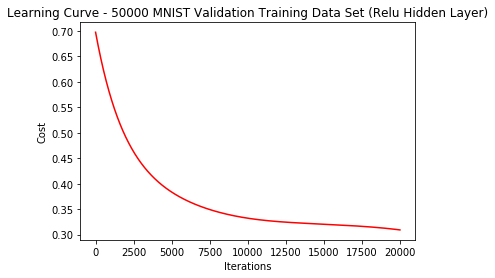

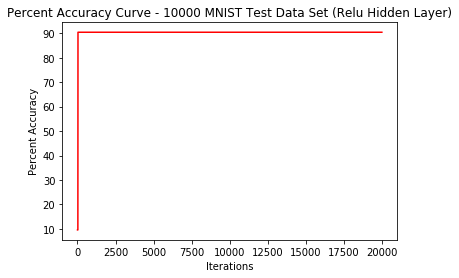

In [262]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.001;
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
     return np.where(Z >= 0, Z, 0)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_relu(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_relu(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z >= 0, 1, 0))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

The results line up with what we would intuitively think. We decreased the learning rate by an order of magnitude but we kept the number of iterations at 20000; therefore, the network did not have time to converge. It is clear from this that the learning rate is too small and therefore it will take too many iterations (and thus too much time) to converge to a solution. Because our networks did not converge, none of them classified the images of a 9 appropriately and thus were only correct 9/10 (~90%) times that the testing image was not a 9. 

The last thing we want to explore is how the activation function of the hidden layers affects the results. For this, we will again run a 2 layer network with 5 units per layer again, and we will revert the learning rate back to the original value. However, for this network we will use tanh as the acvtivation function in hidden layer. 

First, we re-initialize our weights and bias's with 5 units.

In [263]:
# initialize weights & bias
np.random.seed(seed=0)

lower_bound = 0.001
upper_bound = 0.01

mean = 0.015
std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units = 5

Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units, units]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units, 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

print(Weights.shape) # matrix with a size of # of units X 784
print(Bias.shape) # vector with a size of the # of unit

(3,)
(3,)


Now we re-run our gradient descent with tanh as the activation function in the hidden layers.

Main Loop Iteration: 1
Main Loop Iteration: 2
Main Loop Iteration: 3
Main Loop Iteration: 4
Main Loop Iteration: 5
Main Loop Iteration: 6
Main Loop Iteration: 7
Main Loop Iteration: 8
Main Loop Iteration: 9
Main Loop Iteration: 10
Main Loop Iteration: 11
Main Loop Iteration: 12
Main Loop Iteration: 13
Main Loop Iteration: 14
Main Loop Iteration: 15
Main Loop Iteration: 16
Main Loop Iteration: 17
Main Loop Iteration: 18
Main Loop Iteration: 19
Main Loop Iteration: 20
Main Loop Iteration: 21
Main Loop Iteration: 22
Main Loop Iteration: 23
Main Loop Iteration: 24
Main Loop Iteration: 25
Main Loop Iteration: 26
Main Loop Iteration: 27
Main Loop Iteration: 28
Main Loop Iteration: 29
Main Loop Iteration: 30
Main Loop Iteration: 31
Main Loop Iteration: 32
Main Loop Iteration: 33
Main Loop Iteration: 34
Main Loop Iteration: 35
Main Loop Iteration: 36
Main Loop Iteration: 37
Main Loop Iteration: 38
Main Loop Iteration: 39
Main Loop Iteration: 40
Main Loop Iteration: 41
Main Loop Iteration: 42
M

Main Loop Iteration: 334
Main Loop Iteration: 335
Main Loop Iteration: 336
Main Loop Iteration: 337
Main Loop Iteration: 338
Main Loop Iteration: 339
Main Loop Iteration: 340
Main Loop Iteration: 341
Main Loop Iteration: 342
Main Loop Iteration: 343
Main Loop Iteration: 344
Main Loop Iteration: 345
Main Loop Iteration: 346
Main Loop Iteration: 347
Main Loop Iteration: 348
Main Loop Iteration: 349
Main Loop Iteration: 350
Main Loop Iteration: 351
Main Loop Iteration: 352
Main Loop Iteration: 353
Main Loop Iteration: 354
Main Loop Iteration: 355
Main Loop Iteration: 356
Main Loop Iteration: 357
Main Loop Iteration: 358
Main Loop Iteration: 359
Main Loop Iteration: 360
Main Loop Iteration: 361
Main Loop Iteration: 362
Main Loop Iteration: 363
Main Loop Iteration: 364
Main Loop Iteration: 365
Main Loop Iteration: 366
Main Loop Iteration: 367
Main Loop Iteration: 368
Main Loop Iteration: 369
Main Loop Iteration: 370
Main Loop Iteration: 371
Main Loop Iteration: 372
Main Loop Iteration: 373


Main Loop Iteration: 662
Main Loop Iteration: 663
Main Loop Iteration: 664
Main Loop Iteration: 665
Main Loop Iteration: 666
Main Loop Iteration: 667
Main Loop Iteration: 668
Main Loop Iteration: 669
Main Loop Iteration: 670
Main Loop Iteration: 671
Main Loop Iteration: 672
Main Loop Iteration: 673
Main Loop Iteration: 674
Main Loop Iteration: 675
Main Loop Iteration: 676
Main Loop Iteration: 677
Main Loop Iteration: 678
Main Loop Iteration: 679
Main Loop Iteration: 680
Main Loop Iteration: 681
Main Loop Iteration: 682
Main Loop Iteration: 683
Main Loop Iteration: 684
Main Loop Iteration: 685
Main Loop Iteration: 686
Main Loop Iteration: 687
Main Loop Iteration: 688
Main Loop Iteration: 689
Main Loop Iteration: 690
Main Loop Iteration: 691
Main Loop Iteration: 692
Main Loop Iteration: 693
Main Loop Iteration: 694
Main Loop Iteration: 695
Main Loop Iteration: 696
Main Loop Iteration: 697
Main Loop Iteration: 698
Main Loop Iteration: 699
Main Loop Iteration: 700
Main Loop Iteration: 701


Main Loop Iteration: 990
Main Loop Iteration: 991
Main Loop Iteration: 992
Main Loop Iteration: 993
Main Loop Iteration: 994
Main Loop Iteration: 995
Main Loop Iteration: 996
Main Loop Iteration: 997
Main Loop Iteration: 998
Main Loop Iteration: 999
Main Loop Iteration: 1000
Main Loop Iteration: 1001
Main Loop Iteration: 1002
Main Loop Iteration: 1003
Main Loop Iteration: 1004
Main Loop Iteration: 1005
Main Loop Iteration: 1006
Main Loop Iteration: 1007
Main Loop Iteration: 1008
Main Loop Iteration: 1009
Main Loop Iteration: 1010
Main Loop Iteration: 1011
Main Loop Iteration: 1012
Main Loop Iteration: 1013
Main Loop Iteration: 1014
Main Loop Iteration: 1015
Main Loop Iteration: 1016
Main Loop Iteration: 1017
Main Loop Iteration: 1018
Main Loop Iteration: 1019
Main Loop Iteration: 1020
Main Loop Iteration: 1021
Main Loop Iteration: 1022
Main Loop Iteration: 1023
Main Loop Iteration: 1024
Main Loop Iteration: 1025
Main Loop Iteration: 1026
Main Loop Iteration: 1027
Main Loop Iteration: 1

Main Loop Iteration: 1307
Main Loop Iteration: 1308
Main Loop Iteration: 1309
Main Loop Iteration: 1310
Main Loop Iteration: 1311
Main Loop Iteration: 1312
Main Loop Iteration: 1313
Main Loop Iteration: 1314
Main Loop Iteration: 1315
Main Loop Iteration: 1316
Main Loop Iteration: 1317
Main Loop Iteration: 1318
Main Loop Iteration: 1319
Main Loop Iteration: 1320
Main Loop Iteration: 1321
Main Loop Iteration: 1322
Main Loop Iteration: 1323
Main Loop Iteration: 1324
Main Loop Iteration: 1325
Main Loop Iteration: 1326
Main Loop Iteration: 1327
Main Loop Iteration: 1328
Main Loop Iteration: 1329
Main Loop Iteration: 1330
Main Loop Iteration: 1331
Main Loop Iteration: 1332
Main Loop Iteration: 1333
Main Loop Iteration: 1334
Main Loop Iteration: 1335
Main Loop Iteration: 1336
Main Loop Iteration: 1337
Main Loop Iteration: 1338
Main Loop Iteration: 1339
Main Loop Iteration: 1340
Main Loop Iteration: 1341
Main Loop Iteration: 1342
Main Loop Iteration: 1343
Main Loop Iteration: 1344
Main Loop It

Main Loop Iteration: 1623
Main Loop Iteration: 1624
Main Loop Iteration: 1625
Main Loop Iteration: 1626
Main Loop Iteration: 1627
Main Loop Iteration: 1628
Main Loop Iteration: 1629
Main Loop Iteration: 1630
Main Loop Iteration: 1631
Main Loop Iteration: 1632
Main Loop Iteration: 1633
Main Loop Iteration: 1634
Main Loop Iteration: 1635
Main Loop Iteration: 1636
Main Loop Iteration: 1637
Main Loop Iteration: 1638
Main Loop Iteration: 1639
Main Loop Iteration: 1640
Main Loop Iteration: 1641
Main Loop Iteration: 1642
Main Loop Iteration: 1643
Main Loop Iteration: 1644
Main Loop Iteration: 1645
Main Loop Iteration: 1646
Main Loop Iteration: 1647
Main Loop Iteration: 1648
Main Loop Iteration: 1649
Main Loop Iteration: 1650
Main Loop Iteration: 1651
Main Loop Iteration: 1652
Main Loop Iteration: 1653
Main Loop Iteration: 1654
Main Loop Iteration: 1655
Main Loop Iteration: 1656
Main Loop Iteration: 1657
Main Loop Iteration: 1658
Main Loop Iteration: 1659
Main Loop Iteration: 1660
Main Loop It

Main Loop Iteration: 1939
Main Loop Iteration: 1940
Main Loop Iteration: 1941
Main Loop Iteration: 1942
Main Loop Iteration: 1943
Main Loop Iteration: 1944
Main Loop Iteration: 1945
Main Loop Iteration: 1946
Main Loop Iteration: 1947
Main Loop Iteration: 1948
Main Loop Iteration: 1949
Main Loop Iteration: 1950
Main Loop Iteration: 1951
Main Loop Iteration: 1952
Main Loop Iteration: 1953
Main Loop Iteration: 1954
Main Loop Iteration: 1955
Main Loop Iteration: 1956
Main Loop Iteration: 1957
Main Loop Iteration: 1958
Main Loop Iteration: 1959
Main Loop Iteration: 1960
Main Loop Iteration: 1961
Main Loop Iteration: 1962
Main Loop Iteration: 1963
Main Loop Iteration: 1964
Main Loop Iteration: 1965
Main Loop Iteration: 1966
Main Loop Iteration: 1967
Main Loop Iteration: 1968
Main Loop Iteration: 1969
Main Loop Iteration: 1970
Main Loop Iteration: 1971
Main Loop Iteration: 1972
Main Loop Iteration: 1973
Main Loop Iteration: 1974
Main Loop Iteration: 1975
Main Loop Iteration: 1976
Main Loop It

Main Loop Iteration: 2255
Main Loop Iteration: 2256
Main Loop Iteration: 2257
Main Loop Iteration: 2258
Main Loop Iteration: 2259
Main Loop Iteration: 2260
Main Loop Iteration: 2261
Main Loop Iteration: 2262
Main Loop Iteration: 2263
Main Loop Iteration: 2264
Main Loop Iteration: 2265
Main Loop Iteration: 2266
Main Loop Iteration: 2267
Main Loop Iteration: 2268
Main Loop Iteration: 2269
Main Loop Iteration: 2270
Main Loop Iteration: 2271
Main Loop Iteration: 2272
Main Loop Iteration: 2273
Main Loop Iteration: 2274
Main Loop Iteration: 2275
Main Loop Iteration: 2276
Main Loop Iteration: 2277
Main Loop Iteration: 2278
Main Loop Iteration: 2279
Main Loop Iteration: 2280
Main Loop Iteration: 2281
Main Loop Iteration: 2282
Main Loop Iteration: 2283
Main Loop Iteration: 2284
Main Loop Iteration: 2285
Main Loop Iteration: 2286
Main Loop Iteration: 2287
Main Loop Iteration: 2288
Main Loop Iteration: 2289
Main Loop Iteration: 2290
Main Loop Iteration: 2291
Main Loop Iteration: 2292
Main Loop It

Main Loop Iteration: 2571
Main Loop Iteration: 2572
Main Loop Iteration: 2573
Main Loop Iteration: 2574
Main Loop Iteration: 2575
Main Loop Iteration: 2576
Main Loop Iteration: 2577
Main Loop Iteration: 2578
Main Loop Iteration: 2579
Main Loop Iteration: 2580
Main Loop Iteration: 2581
Main Loop Iteration: 2582
Main Loop Iteration: 2583
Main Loop Iteration: 2584
Main Loop Iteration: 2585
Main Loop Iteration: 2586
Main Loop Iteration: 2587
Main Loop Iteration: 2588
Main Loop Iteration: 2589
Main Loop Iteration: 2590
Main Loop Iteration: 2591
Main Loop Iteration: 2592
Main Loop Iteration: 2593
Main Loop Iteration: 2594
Main Loop Iteration: 2595
Main Loop Iteration: 2596
Main Loop Iteration: 2597
Main Loop Iteration: 2598
Main Loop Iteration: 2599
Main Loop Iteration: 2600
Main Loop Iteration: 2601
Main Loop Iteration: 2602
Main Loop Iteration: 2603
Main Loop Iteration: 2604
Main Loop Iteration: 2605
Main Loop Iteration: 2606
Main Loop Iteration: 2607
Main Loop Iteration: 2608
Main Loop It

Main Loop Iteration: 2887
Main Loop Iteration: 2888
Main Loop Iteration: 2889
Main Loop Iteration: 2890
Main Loop Iteration: 2891
Main Loop Iteration: 2892
Main Loop Iteration: 2893
Main Loop Iteration: 2894
Main Loop Iteration: 2895
Main Loop Iteration: 2896
Main Loop Iteration: 2897
Main Loop Iteration: 2898
Main Loop Iteration: 2899
Main Loop Iteration: 2900
Main Loop Iteration: 2901
Main Loop Iteration: 2902
Main Loop Iteration: 2903
Main Loop Iteration: 2904
Main Loop Iteration: 2905
Main Loop Iteration: 2906
Main Loop Iteration: 2907
Main Loop Iteration: 2908
Main Loop Iteration: 2909
Main Loop Iteration: 2910
Main Loop Iteration: 2911
Main Loop Iteration: 2912
Main Loop Iteration: 2913
Main Loop Iteration: 2914
Main Loop Iteration: 2915
Main Loop Iteration: 2916
Main Loop Iteration: 2917
Main Loop Iteration: 2918
Main Loop Iteration: 2919
Main Loop Iteration: 2920
Main Loop Iteration: 2921
Main Loop Iteration: 2922
Main Loop Iteration: 2923
Main Loop Iteration: 2924
Main Loop It

Main Loop Iteration: 3203
Main Loop Iteration: 3204
Main Loop Iteration: 3205
Main Loop Iteration: 3206
Main Loop Iteration: 3207
Main Loop Iteration: 3208
Main Loop Iteration: 3209
Main Loop Iteration: 3210
Main Loop Iteration: 3211
Main Loop Iteration: 3212
Main Loop Iteration: 3213
Main Loop Iteration: 3214
Main Loop Iteration: 3215
Main Loop Iteration: 3216
Main Loop Iteration: 3217
Main Loop Iteration: 3218
Main Loop Iteration: 3219
Main Loop Iteration: 3220
Main Loop Iteration: 3221
Main Loop Iteration: 3222
Main Loop Iteration: 3223
Main Loop Iteration: 3224
Main Loop Iteration: 3225
Main Loop Iteration: 3226
Main Loop Iteration: 3227
Main Loop Iteration: 3228
Main Loop Iteration: 3229
Main Loop Iteration: 3230
Main Loop Iteration: 3231
Main Loop Iteration: 3232
Main Loop Iteration: 3233
Main Loop Iteration: 3234
Main Loop Iteration: 3235
Main Loop Iteration: 3236
Main Loop Iteration: 3237
Main Loop Iteration: 3238
Main Loop Iteration: 3239
Main Loop Iteration: 3240
Main Loop It

Main Loop Iteration: 3519
Main Loop Iteration: 3520
Main Loop Iteration: 3521
Main Loop Iteration: 3522
Main Loop Iteration: 3523
Main Loop Iteration: 3524
Main Loop Iteration: 3525
Main Loop Iteration: 3526
Main Loop Iteration: 3527
Main Loop Iteration: 3528
Main Loop Iteration: 3529
Main Loop Iteration: 3530
Main Loop Iteration: 3531
Main Loop Iteration: 3532
Main Loop Iteration: 3533
Main Loop Iteration: 3534
Main Loop Iteration: 3535
Main Loop Iteration: 3536
Main Loop Iteration: 3537
Main Loop Iteration: 3538
Main Loop Iteration: 3539
Main Loop Iteration: 3540
Main Loop Iteration: 3541
Main Loop Iteration: 3542
Main Loop Iteration: 3543
Main Loop Iteration: 3544
Main Loop Iteration: 3545
Main Loop Iteration: 3546
Main Loop Iteration: 3547
Main Loop Iteration: 3548
Main Loop Iteration: 3549
Main Loop Iteration: 3550
Main Loop Iteration: 3551
Main Loop Iteration: 3552
Main Loop Iteration: 3553
Main Loop Iteration: 3554
Main Loop Iteration: 3555
Main Loop Iteration: 3556
Main Loop It

Main Loop Iteration: 4150
Main Loop Iteration: 4151
Main Loop Iteration: 4152
Main Loop Iteration: 4153
Main Loop Iteration: 4154
Main Loop Iteration: 4155
Main Loop Iteration: 4156
Main Loop Iteration: 4157
Main Loop Iteration: 4158
Main Loop Iteration: 4159
Main Loop Iteration: 4160
Main Loop Iteration: 4161
Main Loop Iteration: 4162
Main Loop Iteration: 4163
Main Loop Iteration: 4164
Main Loop Iteration: 4165
Main Loop Iteration: 4166
Main Loop Iteration: 4167
Main Loop Iteration: 4168
Main Loop Iteration: 4169
Main Loop Iteration: 4170
Main Loop Iteration: 4171
Main Loop Iteration: 4172
Main Loop Iteration: 4173
Main Loop Iteration: 4174
Main Loop Iteration: 4175
Main Loop Iteration: 4176
Main Loop Iteration: 4177
Main Loop Iteration: 4178
Main Loop Iteration: 4179
Main Loop Iteration: 4180
Main Loop Iteration: 4181
Main Loop Iteration: 4182
Main Loop Iteration: 4183
Main Loop Iteration: 4184
Main Loop Iteration: 4185
Main Loop Iteration: 4186
Main Loop Iteration: 4187
Main Loop It

Main Loop Iteration: 4466
Main Loop Iteration: 4467
Main Loop Iteration: 4468
Main Loop Iteration: 4469
Main Loop Iteration: 4470
Main Loop Iteration: 4471
Main Loop Iteration: 4472
Main Loop Iteration: 4473
Main Loop Iteration: 4474
Main Loop Iteration: 4475
Main Loop Iteration: 4476
Main Loop Iteration: 4477
Main Loop Iteration: 4478
Main Loop Iteration: 4479
Main Loop Iteration: 4480
Main Loop Iteration: 4481
Main Loop Iteration: 4482
Main Loop Iteration: 4483
Main Loop Iteration: 4484
Main Loop Iteration: 4485
Main Loop Iteration: 4486
Main Loop Iteration: 4487
Main Loop Iteration: 4488
Main Loop Iteration: 4489
Main Loop Iteration: 4490
Main Loop Iteration: 4491
Main Loop Iteration: 4492
Main Loop Iteration: 4493
Main Loop Iteration: 4494
Main Loop Iteration: 4495
Main Loop Iteration: 4496
Main Loop Iteration: 4497
Main Loop Iteration: 4498
Main Loop Iteration: 4499
Main Loop Iteration: 4500
Main Loop Iteration: 4501
Main Loop Iteration: 4502
Main Loop Iteration: 4503
Main Loop It

Main Loop Iteration: 4782
Main Loop Iteration: 4783
Main Loop Iteration: 4784
Main Loop Iteration: 4785
Main Loop Iteration: 4786
Main Loop Iteration: 4787
Main Loop Iteration: 4788
Main Loop Iteration: 4789
Main Loop Iteration: 4790
Main Loop Iteration: 4791
Main Loop Iteration: 4792
Main Loop Iteration: 4793
Main Loop Iteration: 4794
Main Loop Iteration: 4795
Main Loop Iteration: 4796
Main Loop Iteration: 4797
Main Loop Iteration: 4798
Main Loop Iteration: 4799
Main Loop Iteration: 4800
Main Loop Iteration: 4801
Main Loop Iteration: 4802
Main Loop Iteration: 4803
Main Loop Iteration: 4804
Main Loop Iteration: 4805
Main Loop Iteration: 4806
Main Loop Iteration: 4807
Main Loop Iteration: 4808
Main Loop Iteration: 4809
Main Loop Iteration: 4810
Main Loop Iteration: 4811
Main Loop Iteration: 4812
Main Loop Iteration: 4813
Main Loop Iteration: 4814
Main Loop Iteration: 4815
Main Loop Iteration: 4816
Main Loop Iteration: 4817
Main Loop Iteration: 4818
Main Loop Iteration: 4819
Main Loop It

Main Loop Iteration: 5098
Main Loop Iteration: 5099
Main Loop Iteration: 5100
Main Loop Iteration: 5101
Main Loop Iteration: 5102
Main Loop Iteration: 5103
Main Loop Iteration: 5104
Main Loop Iteration: 5105
Main Loop Iteration: 5106
Main Loop Iteration: 5107
Main Loop Iteration: 5108
Main Loop Iteration: 5109
Main Loop Iteration: 5110
Main Loop Iteration: 5111
Main Loop Iteration: 5112
Main Loop Iteration: 5113
Main Loop Iteration: 5114
Main Loop Iteration: 5115
Main Loop Iteration: 5116
Main Loop Iteration: 5117
Main Loop Iteration: 5118
Main Loop Iteration: 5119
Main Loop Iteration: 5120
Main Loop Iteration: 5121
Main Loop Iteration: 5122
Main Loop Iteration: 5123
Main Loop Iteration: 5124
Main Loop Iteration: 5125
Main Loop Iteration: 5126
Main Loop Iteration: 5127
Main Loop Iteration: 5128
Main Loop Iteration: 5129
Main Loop Iteration: 5130
Main Loop Iteration: 5131
Main Loop Iteration: 5132
Main Loop Iteration: 5133
Main Loop Iteration: 5134
Main Loop Iteration: 5135
Main Loop It

Main Loop Iteration: 5729
Main Loop Iteration: 5730
Main Loop Iteration: 5731
Main Loop Iteration: 5732
Main Loop Iteration: 5733
Main Loop Iteration: 5734
Main Loop Iteration: 5735
Main Loop Iteration: 5736
Main Loop Iteration: 5737
Main Loop Iteration: 5738
Main Loop Iteration: 5739
Main Loop Iteration: 5740
Main Loop Iteration: 5741
Main Loop Iteration: 5742
Main Loop Iteration: 5743
Main Loop Iteration: 5744
Main Loop Iteration: 5745
Main Loop Iteration: 5746
Main Loop Iteration: 5747
Main Loop Iteration: 5748
Main Loop Iteration: 5749
Main Loop Iteration: 5750
Main Loop Iteration: 5751
Main Loop Iteration: 5752
Main Loop Iteration: 5753
Main Loop Iteration: 5754
Main Loop Iteration: 5755
Main Loop Iteration: 5756
Main Loop Iteration: 5757
Main Loop Iteration: 5758
Main Loop Iteration: 5759
Main Loop Iteration: 5760
Main Loop Iteration: 5761
Main Loop Iteration: 5762
Main Loop Iteration: 5763
Main Loop Iteration: 5764
Main Loop Iteration: 5765
Main Loop Iteration: 5766
Main Loop It

Main Loop Iteration: 6045
Main Loop Iteration: 6046
Main Loop Iteration: 6047
Main Loop Iteration: 6048
Main Loop Iteration: 6049
Main Loop Iteration: 6050
Main Loop Iteration: 6051
Main Loop Iteration: 6052
Main Loop Iteration: 6053
Main Loop Iteration: 6054
Main Loop Iteration: 6055
Main Loop Iteration: 6056
Main Loop Iteration: 6057
Main Loop Iteration: 6058
Main Loop Iteration: 6059
Main Loop Iteration: 6060
Main Loop Iteration: 6061
Main Loop Iteration: 6062
Main Loop Iteration: 6063
Main Loop Iteration: 6064
Main Loop Iteration: 6065
Main Loop Iteration: 6066
Main Loop Iteration: 6067
Main Loop Iteration: 6068
Main Loop Iteration: 6069
Main Loop Iteration: 6070
Main Loop Iteration: 6071
Main Loop Iteration: 6072
Main Loop Iteration: 6073
Main Loop Iteration: 6074
Main Loop Iteration: 6075
Main Loop Iteration: 6076
Main Loop Iteration: 6077
Main Loop Iteration: 6078
Main Loop Iteration: 6079
Main Loop Iteration: 6080
Main Loop Iteration: 6081
Main Loop Iteration: 6082
Main Loop It

Main Loop Iteration: 6676
Main Loop Iteration: 6677
Main Loop Iteration: 6678
Main Loop Iteration: 6679
Main Loop Iteration: 6680
Main Loop Iteration: 6681
Main Loop Iteration: 6682
Main Loop Iteration: 6683
Main Loop Iteration: 6684
Main Loop Iteration: 6685
Main Loop Iteration: 6686
Main Loop Iteration: 6687
Main Loop Iteration: 6688
Main Loop Iteration: 6689
Main Loop Iteration: 6690
Main Loop Iteration: 6691
Main Loop Iteration: 6692
Main Loop Iteration: 6693
Main Loop Iteration: 6694
Main Loop Iteration: 6695
Main Loop Iteration: 6696
Main Loop Iteration: 6697
Main Loop Iteration: 6698
Main Loop Iteration: 6699
Main Loop Iteration: 6700
Main Loop Iteration: 6701
Main Loop Iteration: 6702
Main Loop Iteration: 6703
Main Loop Iteration: 6704
Main Loop Iteration: 6705
Main Loop Iteration: 6706
Main Loop Iteration: 6707
Main Loop Iteration: 6708
Main Loop Iteration: 6709
Main Loop Iteration: 6710
Main Loop Iteration: 6711
Main Loop Iteration: 6712
Main Loop Iteration: 6713
Main Loop It

C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in multiply
C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log
C:\Users\computer\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater_equal


Main Loop Iteration: 6903
Main Loop Iteration: 6904
Main Loop Iteration: 6905
Main Loop Iteration: 6906
Main Loop Iteration: 6907
Main Loop Iteration: 6908
Main Loop Iteration: 6909
Main Loop Iteration: 6910
Main Loop Iteration: 6911
Main Loop Iteration: 6912
Main Loop Iteration: 6913
Main Loop Iteration: 6914
Main Loop Iteration: 6915
Main Loop Iteration: 6916
Main Loop Iteration: 6917
Main Loop Iteration: 6918
Main Loop Iteration: 6919
Main Loop Iteration: 6920
Main Loop Iteration: 6921
Main Loop Iteration: 6922
Main Loop Iteration: 6923
Main Loop Iteration: 6924
Main Loop Iteration: 6925
Main Loop Iteration: 6926
Main Loop Iteration: 6927
Main Loop Iteration: 6928
Main Loop Iteration: 6929
Main Loop Iteration: 6930
Main Loop Iteration: 6931
Main Loop Iteration: 6932
Main Loop Iteration: 6933
Main Loop Iteration: 6934
Main Loop Iteration: 6935
Main Loop Iteration: 6936
Main Loop Iteration: 6937
Main Loop Iteration: 6938
Main Loop Iteration: 6939
Main Loop Iteration: 6940
Main Loop It

Main Loop Iteration: 7219
Main Loop Iteration: 7220
Main Loop Iteration: 7221
Main Loop Iteration: 7222
Main Loop Iteration: 7223
Main Loop Iteration: 7224
Main Loop Iteration: 7225
Main Loop Iteration: 7226
Main Loop Iteration: 7227
Main Loop Iteration: 7228
Main Loop Iteration: 7229
Main Loop Iteration: 7230
Main Loop Iteration: 7231
Main Loop Iteration: 7232
Main Loop Iteration: 7233
Main Loop Iteration: 7234
Main Loop Iteration: 7235
Main Loop Iteration: 7236
Main Loop Iteration: 7237
Main Loop Iteration: 7238
Main Loop Iteration: 7239
Main Loop Iteration: 7240
Main Loop Iteration: 7241
Main Loop Iteration: 7242
Main Loop Iteration: 7243
Main Loop Iteration: 7244
Main Loop Iteration: 7245
Main Loop Iteration: 7246
Main Loop Iteration: 7247
Main Loop Iteration: 7248
Main Loop Iteration: 7249
Main Loop Iteration: 7250
Main Loop Iteration: 7251
Main Loop Iteration: 7252
Main Loop Iteration: 7253
Main Loop Iteration: 7254
Main Loop Iteration: 7255
Main Loop Iteration: 7256
Main Loop It

Main Loop Iteration: 7851
Main Loop Iteration: 7852
Main Loop Iteration: 7853
Main Loop Iteration: 7854
Main Loop Iteration: 7855
Main Loop Iteration: 7856
Main Loop Iteration: 7857
Main Loop Iteration: 7858
Main Loop Iteration: 7859
Main Loop Iteration: 7860
Main Loop Iteration: 7861
Main Loop Iteration: 7862
Main Loop Iteration: 7863
Main Loop Iteration: 7864
Main Loop Iteration: 7865
Main Loop Iteration: 7866
Main Loop Iteration: 7867
Main Loop Iteration: 7868
Main Loop Iteration: 7869
Main Loop Iteration: 7870
Main Loop Iteration: 7871
Main Loop Iteration: 7872
Main Loop Iteration: 7873
Main Loop Iteration: 7874
Main Loop Iteration: 7875
Main Loop Iteration: 7876
Main Loop Iteration: 7877
Main Loop Iteration: 7878
Main Loop Iteration: 7879
Main Loop Iteration: 7880
Main Loop Iteration: 7881
Main Loop Iteration: 7882
Main Loop Iteration: 7883
Main Loop Iteration: 7884
Main Loop Iteration: 7885
Main Loop Iteration: 7886
Main Loop Iteration: 7887
Main Loop Iteration: 7888
Main Loop It

Main Loop Iteration: 8167
Main Loop Iteration: 8168
Main Loop Iteration: 8169
Main Loop Iteration: 8170
Main Loop Iteration: 8171
Main Loop Iteration: 8172
Main Loop Iteration: 8173
Main Loop Iteration: 8174
Main Loop Iteration: 8175
Main Loop Iteration: 8176
Main Loop Iteration: 8177
Main Loop Iteration: 8178
Main Loop Iteration: 8179
Main Loop Iteration: 8180
Main Loop Iteration: 8181
Main Loop Iteration: 8182
Main Loop Iteration: 8183
Main Loop Iteration: 8184
Main Loop Iteration: 8185
Main Loop Iteration: 8186
Main Loop Iteration: 8187
Main Loop Iteration: 8188
Main Loop Iteration: 8189
Main Loop Iteration: 8190
Main Loop Iteration: 8191
Main Loop Iteration: 8192
Main Loop Iteration: 8193
Main Loop Iteration: 8194
Main Loop Iteration: 8195
Main Loop Iteration: 8196
Main Loop Iteration: 8197
Main Loop Iteration: 8198
Main Loop Iteration: 8199
Main Loop Iteration: 8200
Main Loop Iteration: 8201
Main Loop Iteration: 8202
Main Loop Iteration: 8203
Main Loop Iteration: 8204
Main Loop It

Main Loop Iteration: 8483
Main Loop Iteration: 8484
Main Loop Iteration: 8485
Main Loop Iteration: 8486
Main Loop Iteration: 8487
Main Loop Iteration: 8488
Main Loop Iteration: 8489
Main Loop Iteration: 8490
Main Loop Iteration: 8491
Main Loop Iteration: 8492
Main Loop Iteration: 8493
Main Loop Iteration: 8494
Main Loop Iteration: 8495
Main Loop Iteration: 8496
Main Loop Iteration: 8497
Main Loop Iteration: 8498
Main Loop Iteration: 8499
Main Loop Iteration: 8500
Main Loop Iteration: 8501
Main Loop Iteration: 8502
Main Loop Iteration: 8503
Main Loop Iteration: 8504
Main Loop Iteration: 8505
Main Loop Iteration: 8506
Main Loop Iteration: 8507
Main Loop Iteration: 8508
Main Loop Iteration: 8509
Main Loop Iteration: 8510
Main Loop Iteration: 8511
Main Loop Iteration: 8512
Main Loop Iteration: 8513
Main Loop Iteration: 8514
Main Loop Iteration: 8515
Main Loop Iteration: 8516
Main Loop Iteration: 8517
Main Loop Iteration: 8518
Main Loop Iteration: 8519
Main Loop Iteration: 8520
Main Loop It

Main Loop Iteration: 8799
Main Loop Iteration: 8800
Main Loop Iteration: 8801
Main Loop Iteration: 8802
Main Loop Iteration: 8803
Main Loop Iteration: 8804
Main Loop Iteration: 8805
Main Loop Iteration: 8806
Main Loop Iteration: 8807
Main Loop Iteration: 8808
Main Loop Iteration: 8809
Main Loop Iteration: 8810
Main Loop Iteration: 8811
Main Loop Iteration: 8812
Main Loop Iteration: 8813
Main Loop Iteration: 8814
Main Loop Iteration: 8815
Main Loop Iteration: 8816
Main Loop Iteration: 8817
Main Loop Iteration: 8818
Main Loop Iteration: 8819
Main Loop Iteration: 8820
Main Loop Iteration: 8821
Main Loop Iteration: 8822
Main Loop Iteration: 8823
Main Loop Iteration: 8824
Main Loop Iteration: 8825
Main Loop Iteration: 8826
Main Loop Iteration: 8827
Main Loop Iteration: 8828
Main Loop Iteration: 8829
Main Loop Iteration: 8830
Main Loop Iteration: 8831
Main Loop Iteration: 8832
Main Loop Iteration: 8833
Main Loop Iteration: 8834
Main Loop Iteration: 8835
Main Loop Iteration: 8836
Main Loop It

Main Loop Iteration: 9116
Main Loop Iteration: 9117
Main Loop Iteration: 9118
Main Loop Iteration: 9119
Main Loop Iteration: 9120
Main Loop Iteration: 9121
Main Loop Iteration: 9122
Main Loop Iteration: 9123
Main Loop Iteration: 9124
Main Loop Iteration: 9125
Main Loop Iteration: 9126
Main Loop Iteration: 9127
Main Loop Iteration: 9128
Main Loop Iteration: 9129
Main Loop Iteration: 9130
Main Loop Iteration: 9131
Main Loop Iteration: 9132
Main Loop Iteration: 9133
Main Loop Iteration: 9134
Main Loop Iteration: 9135
Main Loop Iteration: 9136
Main Loop Iteration: 9137
Main Loop Iteration: 9138
Main Loop Iteration: 9139
Main Loop Iteration: 9140
Main Loop Iteration: 9141
Main Loop Iteration: 9142
Main Loop Iteration: 9143
Main Loop Iteration: 9144
Main Loop Iteration: 9145
Main Loop Iteration: 9146
Main Loop Iteration: 9147
Main Loop Iteration: 9148
Main Loop Iteration: 9149
Main Loop Iteration: 9150
Main Loop Iteration: 9151
Main Loop Iteration: 9152
Main Loop Iteration: 9153
Main Loop It

Main Loop Iteration: 9432
Main Loop Iteration: 9433
Main Loop Iteration: 9434
Main Loop Iteration: 9435
Main Loop Iteration: 9436
Main Loop Iteration: 9437
Main Loop Iteration: 9438
Main Loop Iteration: 9439
Main Loop Iteration: 9440
Main Loop Iteration: 9441
Main Loop Iteration: 9442
Main Loop Iteration: 9443
Main Loop Iteration: 9444
Main Loop Iteration: 9445
Main Loop Iteration: 9446
Main Loop Iteration: 9447
Main Loop Iteration: 9448
Main Loop Iteration: 9449
Main Loop Iteration: 9450
Main Loop Iteration: 9451
Main Loop Iteration: 9452
Main Loop Iteration: 9453
Main Loop Iteration: 9454
Main Loop Iteration: 9455
Main Loop Iteration: 9456
Main Loop Iteration: 9457
Main Loop Iteration: 9458
Main Loop Iteration: 9459
Main Loop Iteration: 9460
Main Loop Iteration: 9461
Main Loop Iteration: 9462
Main Loop Iteration: 9463
Main Loop Iteration: 9464
Main Loop Iteration: 9465
Main Loop Iteration: 9466
Main Loop Iteration: 9467
Main Loop Iteration: 9468
Main Loop Iteration: 9469
Main Loop It

Main Loop Iteration: 9749
Main Loop Iteration: 9750
Main Loop Iteration: 9751
Main Loop Iteration: 9752
Main Loop Iteration: 9753
Main Loop Iteration: 9754
Main Loop Iteration: 9755
Main Loop Iteration: 9756
Main Loop Iteration: 9757
Main Loop Iteration: 9758
Main Loop Iteration: 9759
Main Loop Iteration: 9760
Main Loop Iteration: 9761
Main Loop Iteration: 9762
Main Loop Iteration: 9763
Main Loop Iteration: 9764
Main Loop Iteration: 9765
Main Loop Iteration: 9766
Main Loop Iteration: 9767
Main Loop Iteration: 9768
Main Loop Iteration: 9769
Main Loop Iteration: 9770
Main Loop Iteration: 9771
Main Loop Iteration: 9772
Main Loop Iteration: 9773
Main Loop Iteration: 9774
Main Loop Iteration: 9775
Main Loop Iteration: 9776
Main Loop Iteration: 9777
Main Loop Iteration: 9778
Main Loop Iteration: 9779
Main Loop Iteration: 9780
Main Loop Iteration: 9781
Main Loop Iteration: 9782
Main Loop Iteration: 9783
Main Loop Iteration: 9784
Main Loop Iteration: 9785
Main Loop Iteration: 9786
Main Loop It

Main Loop Iteration: 10063
Main Loop Iteration: 10064
Main Loop Iteration: 10065
Main Loop Iteration: 10066
Main Loop Iteration: 10067
Main Loop Iteration: 10068
Main Loop Iteration: 10069
Main Loop Iteration: 10070
Main Loop Iteration: 10071
Main Loop Iteration: 10072
Main Loop Iteration: 10073
Main Loop Iteration: 10074
Main Loop Iteration: 10075
Main Loop Iteration: 10076
Main Loop Iteration: 10077
Main Loop Iteration: 10078
Main Loop Iteration: 10079
Main Loop Iteration: 10080
Main Loop Iteration: 10081
Main Loop Iteration: 10082
Main Loop Iteration: 10083
Main Loop Iteration: 10084
Main Loop Iteration: 10085
Main Loop Iteration: 10086
Main Loop Iteration: 10087
Main Loop Iteration: 10088
Main Loop Iteration: 10089
Main Loop Iteration: 10090
Main Loop Iteration: 10091
Main Loop Iteration: 10092
Main Loop Iteration: 10093
Main Loop Iteration: 10094
Main Loop Iteration: 10095
Main Loop Iteration: 10096
Main Loop Iteration: 10097
Main Loop Iteration: 10098
Main Loop Iteration: 10099
M

Main Loop Iteration: 10367
Main Loop Iteration: 10368
Main Loop Iteration: 10369
Main Loop Iteration: 10370
Main Loop Iteration: 10371
Main Loop Iteration: 10372
Main Loop Iteration: 10373
Main Loop Iteration: 10374
Main Loop Iteration: 10375
Main Loop Iteration: 10376
Main Loop Iteration: 10377
Main Loop Iteration: 10378
Main Loop Iteration: 10379
Main Loop Iteration: 10380
Main Loop Iteration: 10381
Main Loop Iteration: 10382
Main Loop Iteration: 10383
Main Loop Iteration: 10384
Main Loop Iteration: 10385
Main Loop Iteration: 10386
Main Loop Iteration: 10387
Main Loop Iteration: 10388
Main Loop Iteration: 10389
Main Loop Iteration: 10390
Main Loop Iteration: 10391
Main Loop Iteration: 10392
Main Loop Iteration: 10393
Main Loop Iteration: 10394
Main Loop Iteration: 10395
Main Loop Iteration: 10396
Main Loop Iteration: 10397
Main Loop Iteration: 10398
Main Loop Iteration: 10399
Main Loop Iteration: 10400
Main Loop Iteration: 10401
Main Loop Iteration: 10402
Main Loop Iteration: 10403
M

Main Loop Iteration: 10671
Main Loop Iteration: 10672
Main Loop Iteration: 10673
Main Loop Iteration: 10674
Main Loop Iteration: 10675
Main Loop Iteration: 10676
Main Loop Iteration: 10677
Main Loop Iteration: 10678
Main Loop Iteration: 10679
Main Loop Iteration: 10680
Main Loop Iteration: 10681
Main Loop Iteration: 10682
Main Loop Iteration: 10683
Main Loop Iteration: 10684
Main Loop Iteration: 10685
Main Loop Iteration: 10686
Main Loop Iteration: 10687
Main Loop Iteration: 10688
Main Loop Iteration: 10689
Main Loop Iteration: 10690
Main Loop Iteration: 10691
Main Loop Iteration: 10692
Main Loop Iteration: 10693
Main Loop Iteration: 10694
Main Loop Iteration: 10695
Main Loop Iteration: 10696
Main Loop Iteration: 10697
Main Loop Iteration: 10698
Main Loop Iteration: 10699
Main Loop Iteration: 10700
Main Loop Iteration: 10701
Main Loop Iteration: 10702
Main Loop Iteration: 10703
Main Loop Iteration: 10704
Main Loop Iteration: 10705
Main Loop Iteration: 10706
Main Loop Iteration: 10707
M

Main Loop Iteration: 10975
Main Loop Iteration: 10976
Main Loop Iteration: 10977
Main Loop Iteration: 10978
Main Loop Iteration: 10979
Main Loop Iteration: 10980
Main Loop Iteration: 10981
Main Loop Iteration: 10982
Main Loop Iteration: 10983
Main Loop Iteration: 10984
Main Loop Iteration: 10985
Main Loop Iteration: 10986
Main Loop Iteration: 10987
Main Loop Iteration: 10988
Main Loop Iteration: 10989
Main Loop Iteration: 10990
Main Loop Iteration: 10991
Main Loop Iteration: 10992
Main Loop Iteration: 10993
Main Loop Iteration: 10994
Main Loop Iteration: 10995
Main Loop Iteration: 10996
Main Loop Iteration: 10997
Main Loop Iteration: 10998
Main Loop Iteration: 10999
Main Loop Iteration: 11000
Main Loop Iteration: 11001
Main Loop Iteration: 11002
Main Loop Iteration: 11003
Main Loop Iteration: 11004
Main Loop Iteration: 11005
Main Loop Iteration: 11006
Main Loop Iteration: 11007
Main Loop Iteration: 11008
Main Loop Iteration: 11009
Main Loop Iteration: 11010
Main Loop Iteration: 11011
M

Main Loop Iteration: 11280
Main Loop Iteration: 11281
Main Loop Iteration: 11282
Main Loop Iteration: 11283
Main Loop Iteration: 11284
Main Loop Iteration: 11285
Main Loop Iteration: 11286
Main Loop Iteration: 11287
Main Loop Iteration: 11288
Main Loop Iteration: 11289
Main Loop Iteration: 11290
Main Loop Iteration: 11291
Main Loop Iteration: 11292
Main Loop Iteration: 11293
Main Loop Iteration: 11294
Main Loop Iteration: 11295
Main Loop Iteration: 11296
Main Loop Iteration: 11297
Main Loop Iteration: 11298
Main Loop Iteration: 11299
Main Loop Iteration: 11300
Main Loop Iteration: 11301
Main Loop Iteration: 11302
Main Loop Iteration: 11303
Main Loop Iteration: 11304
Main Loop Iteration: 11305
Main Loop Iteration: 11306
Main Loop Iteration: 11307
Main Loop Iteration: 11308
Main Loop Iteration: 11309
Main Loop Iteration: 11310
Main Loop Iteration: 11311
Main Loop Iteration: 11312
Main Loop Iteration: 11313
Main Loop Iteration: 11314
Main Loop Iteration: 11315
Main Loop Iteration: 11316
M

Main Loop Iteration: 11584
Main Loop Iteration: 11585
Main Loop Iteration: 11586
Main Loop Iteration: 11587
Main Loop Iteration: 11588
Main Loop Iteration: 11589
Main Loop Iteration: 11590
Main Loop Iteration: 11591
Main Loop Iteration: 11592
Main Loop Iteration: 11593
Main Loop Iteration: 11594
Main Loop Iteration: 11595
Main Loop Iteration: 11596
Main Loop Iteration: 11597
Main Loop Iteration: 11598
Main Loop Iteration: 11599
Main Loop Iteration: 11600
Main Loop Iteration: 11601
Main Loop Iteration: 11602
Main Loop Iteration: 11603
Main Loop Iteration: 11604
Main Loop Iteration: 11605
Main Loop Iteration: 11606
Main Loop Iteration: 11607
Main Loop Iteration: 11608
Main Loop Iteration: 11609
Main Loop Iteration: 11610
Main Loop Iteration: 11611
Main Loop Iteration: 11612
Main Loop Iteration: 11613
Main Loop Iteration: 11614
Main Loop Iteration: 11615
Main Loop Iteration: 11616
Main Loop Iteration: 11617
Main Loop Iteration: 11618
Main Loop Iteration: 11619
Main Loop Iteration: 11620
M

Main Loop Iteration: 11888
Main Loop Iteration: 11889
Main Loop Iteration: 11890
Main Loop Iteration: 11891
Main Loop Iteration: 11892
Main Loop Iteration: 11893
Main Loop Iteration: 11894
Main Loop Iteration: 11895
Main Loop Iteration: 11896
Main Loop Iteration: 11897
Main Loop Iteration: 11898
Main Loop Iteration: 11899
Main Loop Iteration: 11900
Main Loop Iteration: 11901
Main Loop Iteration: 11902
Main Loop Iteration: 11903
Main Loop Iteration: 11904
Main Loop Iteration: 11905
Main Loop Iteration: 11906
Main Loop Iteration: 11907
Main Loop Iteration: 11908
Main Loop Iteration: 11909
Main Loop Iteration: 11910
Main Loop Iteration: 11911
Main Loop Iteration: 11912
Main Loop Iteration: 11913
Main Loop Iteration: 11914
Main Loop Iteration: 11915
Main Loop Iteration: 11916
Main Loop Iteration: 11917
Main Loop Iteration: 11918
Main Loop Iteration: 11919
Main Loop Iteration: 11920
Main Loop Iteration: 11921
Main Loop Iteration: 11922
Main Loop Iteration: 11923
Main Loop Iteration: 11924
M

Main Loop Iteration: 12192
Main Loop Iteration: 12193
Main Loop Iteration: 12194
Main Loop Iteration: 12195
Main Loop Iteration: 12196
Main Loop Iteration: 12197
Main Loop Iteration: 12198
Main Loop Iteration: 12199
Main Loop Iteration: 12200
Main Loop Iteration: 12201
Main Loop Iteration: 12202
Main Loop Iteration: 12203
Main Loop Iteration: 12204
Main Loop Iteration: 12205
Main Loop Iteration: 12206
Main Loop Iteration: 12207
Main Loop Iteration: 12208
Main Loop Iteration: 12209
Main Loop Iteration: 12210
Main Loop Iteration: 12211
Main Loop Iteration: 12212
Main Loop Iteration: 12213
Main Loop Iteration: 12214
Main Loop Iteration: 12215
Main Loop Iteration: 12216
Main Loop Iteration: 12217
Main Loop Iteration: 12218
Main Loop Iteration: 12219
Main Loop Iteration: 12220
Main Loop Iteration: 12221
Main Loop Iteration: 12222
Main Loop Iteration: 12223
Main Loop Iteration: 12224
Main Loop Iteration: 12225
Main Loop Iteration: 12226
Main Loop Iteration: 12227
Main Loop Iteration: 12228
M

Main Loop Iteration: 12496
Main Loop Iteration: 12497
Main Loop Iteration: 12498
Main Loop Iteration: 12499
Main Loop Iteration: 12500
Main Loop Iteration: 12501
Main Loop Iteration: 12502
Main Loop Iteration: 12503
Main Loop Iteration: 12504
Main Loop Iteration: 12505
Main Loop Iteration: 12506
Main Loop Iteration: 12507
Main Loop Iteration: 12508
Main Loop Iteration: 12509
Main Loop Iteration: 12510
Main Loop Iteration: 12511
Main Loop Iteration: 12512
Main Loop Iteration: 12513
Main Loop Iteration: 12514
Main Loop Iteration: 12515
Main Loop Iteration: 12516
Main Loop Iteration: 12517
Main Loop Iteration: 12518
Main Loop Iteration: 12519
Main Loop Iteration: 12520
Main Loop Iteration: 12521
Main Loop Iteration: 12522
Main Loop Iteration: 12523
Main Loop Iteration: 12524
Main Loop Iteration: 12525
Main Loop Iteration: 12526
Main Loop Iteration: 12527
Main Loop Iteration: 12528
Main Loop Iteration: 12529
Main Loop Iteration: 12530
Main Loop Iteration: 12531
Main Loop Iteration: 12532
M

Main Loop Iteration: 12800
Main Loop Iteration: 12801
Main Loop Iteration: 12802
Main Loop Iteration: 12803
Main Loop Iteration: 12804
Main Loop Iteration: 12805
Main Loop Iteration: 12806
Main Loop Iteration: 12807
Main Loop Iteration: 12808
Main Loop Iteration: 12809
Main Loop Iteration: 12810
Main Loop Iteration: 12811
Main Loop Iteration: 12812
Main Loop Iteration: 12813
Main Loop Iteration: 12814
Main Loop Iteration: 12815
Main Loop Iteration: 12816
Main Loop Iteration: 12817
Main Loop Iteration: 12818
Main Loop Iteration: 12819
Main Loop Iteration: 12820
Main Loop Iteration: 12821
Main Loop Iteration: 12822
Main Loop Iteration: 12823
Main Loop Iteration: 12824
Main Loop Iteration: 12825
Main Loop Iteration: 12826
Main Loop Iteration: 12827
Main Loop Iteration: 12828
Main Loop Iteration: 12829
Main Loop Iteration: 12830
Main Loop Iteration: 12831
Main Loop Iteration: 12832
Main Loop Iteration: 12833
Main Loop Iteration: 12834
Main Loop Iteration: 12835
Main Loop Iteration: 12836
M

Main Loop Iteration: 13104
Main Loop Iteration: 13105
Main Loop Iteration: 13106
Main Loop Iteration: 13107
Main Loop Iteration: 13108
Main Loop Iteration: 13109
Main Loop Iteration: 13110
Main Loop Iteration: 13111
Main Loop Iteration: 13112
Main Loop Iteration: 13113
Main Loop Iteration: 13114
Main Loop Iteration: 13115
Main Loop Iteration: 13116
Main Loop Iteration: 13117
Main Loop Iteration: 13118
Main Loop Iteration: 13119
Main Loop Iteration: 13120
Main Loop Iteration: 13121
Main Loop Iteration: 13122
Main Loop Iteration: 13123
Main Loop Iteration: 13124
Main Loop Iteration: 13125
Main Loop Iteration: 13126
Main Loop Iteration: 13127
Main Loop Iteration: 13128
Main Loop Iteration: 13129
Main Loop Iteration: 13130
Main Loop Iteration: 13131
Main Loop Iteration: 13132
Main Loop Iteration: 13133
Main Loop Iteration: 13134
Main Loop Iteration: 13135
Main Loop Iteration: 13136
Main Loop Iteration: 13137
Main Loop Iteration: 13138
Main Loop Iteration: 13139
Main Loop Iteration: 13140
M

Main Loop Iteration: 13409
Main Loop Iteration: 13410
Main Loop Iteration: 13411
Main Loop Iteration: 13412
Main Loop Iteration: 13413
Main Loop Iteration: 13414
Main Loop Iteration: 13415
Main Loop Iteration: 13416
Main Loop Iteration: 13417
Main Loop Iteration: 13418
Main Loop Iteration: 13419
Main Loop Iteration: 13420
Main Loop Iteration: 13421
Main Loop Iteration: 13422
Main Loop Iteration: 13423
Main Loop Iteration: 13424
Main Loop Iteration: 13425
Main Loop Iteration: 13426
Main Loop Iteration: 13427
Main Loop Iteration: 13428
Main Loop Iteration: 13429
Main Loop Iteration: 13430
Main Loop Iteration: 13431
Main Loop Iteration: 13432
Main Loop Iteration: 13433
Main Loop Iteration: 13434
Main Loop Iteration: 13435
Main Loop Iteration: 13436
Main Loop Iteration: 13437
Main Loop Iteration: 13438
Main Loop Iteration: 13439
Main Loop Iteration: 13440
Main Loop Iteration: 13441
Main Loop Iteration: 13442
Main Loop Iteration: 13443
Main Loop Iteration: 13444
Main Loop Iteration: 13445
M

Main Loop Iteration: 13714
Main Loop Iteration: 13715
Main Loop Iteration: 13716
Main Loop Iteration: 13717
Main Loop Iteration: 13718
Main Loop Iteration: 13719
Main Loop Iteration: 13720
Main Loop Iteration: 13721
Main Loop Iteration: 13722
Main Loop Iteration: 13723
Main Loop Iteration: 13724
Main Loop Iteration: 13725
Main Loop Iteration: 13726
Main Loop Iteration: 13727
Main Loop Iteration: 13728
Main Loop Iteration: 13729
Main Loop Iteration: 13730
Main Loop Iteration: 13731
Main Loop Iteration: 13732
Main Loop Iteration: 13733
Main Loop Iteration: 13734
Main Loop Iteration: 13735
Main Loop Iteration: 13736
Main Loop Iteration: 13737
Main Loop Iteration: 13738
Main Loop Iteration: 13739
Main Loop Iteration: 13740
Main Loop Iteration: 13741
Main Loop Iteration: 13742
Main Loop Iteration: 13743
Main Loop Iteration: 13744
Main Loop Iteration: 13745
Main Loop Iteration: 13746
Main Loop Iteration: 13747
Main Loop Iteration: 13748
Main Loop Iteration: 13749
Main Loop Iteration: 13750
M

Main Loop Iteration: 14019
Main Loop Iteration: 14020
Main Loop Iteration: 14021
Main Loop Iteration: 14022
Main Loop Iteration: 14023
Main Loop Iteration: 14024
Main Loop Iteration: 14025
Main Loop Iteration: 14026
Main Loop Iteration: 14027
Main Loop Iteration: 14028
Main Loop Iteration: 14029
Main Loop Iteration: 14030
Main Loop Iteration: 14031
Main Loop Iteration: 14032
Main Loop Iteration: 14033
Main Loop Iteration: 14034
Main Loop Iteration: 14035
Main Loop Iteration: 14036
Main Loop Iteration: 14037
Main Loop Iteration: 14038
Main Loop Iteration: 14039
Main Loop Iteration: 14040
Main Loop Iteration: 14041
Main Loop Iteration: 14042
Main Loop Iteration: 14043
Main Loop Iteration: 14044
Main Loop Iteration: 14045
Main Loop Iteration: 14046
Main Loop Iteration: 14047
Main Loop Iteration: 14048
Main Loop Iteration: 14049
Main Loop Iteration: 14050
Main Loop Iteration: 14051
Main Loop Iteration: 14052
Main Loop Iteration: 14053
Main Loop Iteration: 14054
Main Loop Iteration: 14055
M

Main Loop Iteration: 14626
Main Loop Iteration: 14627
Main Loop Iteration: 14628
Main Loop Iteration: 14629
Main Loop Iteration: 14630
Main Loop Iteration: 14631
Main Loop Iteration: 14632
Main Loop Iteration: 14633
Main Loop Iteration: 14634
Main Loop Iteration: 14635
Main Loop Iteration: 14636
Main Loop Iteration: 14637
Main Loop Iteration: 14638
Main Loop Iteration: 14639
Main Loop Iteration: 14640
Main Loop Iteration: 14641
Main Loop Iteration: 14642
Main Loop Iteration: 14643
Main Loop Iteration: 14644
Main Loop Iteration: 14645
Main Loop Iteration: 14646
Main Loop Iteration: 14647
Main Loop Iteration: 14648
Main Loop Iteration: 14649
Main Loop Iteration: 14650
Main Loop Iteration: 14651
Main Loop Iteration: 14652
Main Loop Iteration: 14653
Main Loop Iteration: 14654
Main Loop Iteration: 14655
Main Loop Iteration: 14656
Main Loop Iteration: 14657
Main Loop Iteration: 14658
Main Loop Iteration: 14659
Main Loop Iteration: 14660
Main Loop Iteration: 14661
Main Loop Iteration: 14662
M

Main Loop Iteration: 14930
Main Loop Iteration: 14931
Main Loop Iteration: 14932
Main Loop Iteration: 14933
Main Loop Iteration: 14934
Main Loop Iteration: 14935
Main Loop Iteration: 14936
Main Loop Iteration: 14937
Main Loop Iteration: 14938
Main Loop Iteration: 14939
Main Loop Iteration: 14940
Main Loop Iteration: 14941
Main Loop Iteration: 14942
Main Loop Iteration: 14943
Main Loop Iteration: 14944
Main Loop Iteration: 14945
Main Loop Iteration: 14946
Main Loop Iteration: 14947
Main Loop Iteration: 14948
Main Loop Iteration: 14949
Main Loop Iteration: 14950
Main Loop Iteration: 14951
Main Loop Iteration: 14952
Main Loop Iteration: 14953
Main Loop Iteration: 14954
Main Loop Iteration: 14955
Main Loop Iteration: 14956
Main Loop Iteration: 14957
Main Loop Iteration: 14958
Main Loop Iteration: 14959
Main Loop Iteration: 14960
Main Loop Iteration: 14961
Main Loop Iteration: 14962
Main Loop Iteration: 14963
Main Loop Iteration: 14964
Main Loop Iteration: 14965
Main Loop Iteration: 14966
M

Main Loop Iteration: 15234
Main Loop Iteration: 15235
Main Loop Iteration: 15236
Main Loop Iteration: 15237
Main Loop Iteration: 15238
Main Loop Iteration: 15239
Main Loop Iteration: 15240
Main Loop Iteration: 15241
Main Loop Iteration: 15242
Main Loop Iteration: 15243
Main Loop Iteration: 15244
Main Loop Iteration: 15245
Main Loop Iteration: 15246
Main Loop Iteration: 15247
Main Loop Iteration: 15248
Main Loop Iteration: 15249
Main Loop Iteration: 15250
Main Loop Iteration: 15251
Main Loop Iteration: 15252
Main Loop Iteration: 15253
Main Loop Iteration: 15254
Main Loop Iteration: 15255
Main Loop Iteration: 15256
Main Loop Iteration: 15257
Main Loop Iteration: 15258
Main Loop Iteration: 15259
Main Loop Iteration: 15260
Main Loop Iteration: 15261
Main Loop Iteration: 15262
Main Loop Iteration: 15263
Main Loop Iteration: 15264
Main Loop Iteration: 15265
Main Loop Iteration: 15266
Main Loop Iteration: 15267
Main Loop Iteration: 15268
Main Loop Iteration: 15269
Main Loop Iteration: 15270
M

Main Loop Iteration: 15539
Main Loop Iteration: 15540
Main Loop Iteration: 15541
Main Loop Iteration: 15542
Main Loop Iteration: 15543
Main Loop Iteration: 15544
Main Loop Iteration: 15545
Main Loop Iteration: 15546
Main Loop Iteration: 15547
Main Loop Iteration: 15548
Main Loop Iteration: 15549
Main Loop Iteration: 15550
Main Loop Iteration: 15551
Main Loop Iteration: 15552
Main Loop Iteration: 15553
Main Loop Iteration: 15554
Main Loop Iteration: 15555
Main Loop Iteration: 15556
Main Loop Iteration: 15557
Main Loop Iteration: 15558
Main Loop Iteration: 15559
Main Loop Iteration: 15560
Main Loop Iteration: 15561
Main Loop Iteration: 15562
Main Loop Iteration: 15563
Main Loop Iteration: 15564
Main Loop Iteration: 15565
Main Loop Iteration: 15566
Main Loop Iteration: 15567
Main Loop Iteration: 15568
Main Loop Iteration: 15569
Main Loop Iteration: 15570
Main Loop Iteration: 15571
Main Loop Iteration: 15572
Main Loop Iteration: 15573
Main Loop Iteration: 15574
Main Loop Iteration: 15575
M

Main Loop Iteration: 15843
Main Loop Iteration: 15844
Main Loop Iteration: 15845
Main Loop Iteration: 15846
Main Loop Iteration: 15847
Main Loop Iteration: 15848
Main Loop Iteration: 15849
Main Loop Iteration: 15850
Main Loop Iteration: 15851
Main Loop Iteration: 15852
Main Loop Iteration: 15853
Main Loop Iteration: 15854
Main Loop Iteration: 15855
Main Loop Iteration: 15856
Main Loop Iteration: 15857
Main Loop Iteration: 15858
Main Loop Iteration: 15859
Main Loop Iteration: 15860
Main Loop Iteration: 15861
Main Loop Iteration: 15862
Main Loop Iteration: 15863
Main Loop Iteration: 15864
Main Loop Iteration: 15865
Main Loop Iteration: 15866
Main Loop Iteration: 15867
Main Loop Iteration: 15868
Main Loop Iteration: 15869
Main Loop Iteration: 15870
Main Loop Iteration: 15871
Main Loop Iteration: 15872
Main Loop Iteration: 15873
Main Loop Iteration: 15874
Main Loop Iteration: 15875
Main Loop Iteration: 15876
Main Loop Iteration: 15877
Main Loop Iteration: 15878
Main Loop Iteration: 15879
M

Main Loop Iteration: 16148
Main Loop Iteration: 16149
Main Loop Iteration: 16150
Main Loop Iteration: 16151
Main Loop Iteration: 16152
Main Loop Iteration: 16153
Main Loop Iteration: 16154
Main Loop Iteration: 16155
Main Loop Iteration: 16156
Main Loop Iteration: 16157
Main Loop Iteration: 16158
Main Loop Iteration: 16159
Main Loop Iteration: 16160
Main Loop Iteration: 16161
Main Loop Iteration: 16162
Main Loop Iteration: 16163
Main Loop Iteration: 16164
Main Loop Iteration: 16165
Main Loop Iteration: 16166
Main Loop Iteration: 16167
Main Loop Iteration: 16168
Main Loop Iteration: 16169
Main Loop Iteration: 16170
Main Loop Iteration: 16171
Main Loop Iteration: 16172
Main Loop Iteration: 16173
Main Loop Iteration: 16174
Main Loop Iteration: 16175
Main Loop Iteration: 16176
Main Loop Iteration: 16177
Main Loop Iteration: 16178
Main Loop Iteration: 16179
Main Loop Iteration: 16180
Main Loop Iteration: 16181
Main Loop Iteration: 16182
Main Loop Iteration: 16183
Main Loop Iteration: 16184
M

Main Loop Iteration: 16452
Main Loop Iteration: 16453
Main Loop Iteration: 16454
Main Loop Iteration: 16455
Main Loop Iteration: 16456
Main Loop Iteration: 16457
Main Loop Iteration: 16458
Main Loop Iteration: 16459
Main Loop Iteration: 16460
Main Loop Iteration: 16461
Main Loop Iteration: 16462
Main Loop Iteration: 16463
Main Loop Iteration: 16464
Main Loop Iteration: 16465
Main Loop Iteration: 16466
Main Loop Iteration: 16467
Main Loop Iteration: 16468
Main Loop Iteration: 16469
Main Loop Iteration: 16470
Main Loop Iteration: 16471
Main Loop Iteration: 16472
Main Loop Iteration: 16473
Main Loop Iteration: 16474
Main Loop Iteration: 16475
Main Loop Iteration: 16476
Main Loop Iteration: 16477
Main Loop Iteration: 16478
Main Loop Iteration: 16479
Main Loop Iteration: 16480
Main Loop Iteration: 16481
Main Loop Iteration: 16482
Main Loop Iteration: 16483
Main Loop Iteration: 16484
Main Loop Iteration: 16485
Main Loop Iteration: 16486
Main Loop Iteration: 16487
Main Loop Iteration: 16488
M

Main Loop Iteration: 16757
Main Loop Iteration: 16758
Main Loop Iteration: 16759
Main Loop Iteration: 16760
Main Loop Iteration: 16761
Main Loop Iteration: 16762
Main Loop Iteration: 16763
Main Loop Iteration: 16764
Main Loop Iteration: 16765
Main Loop Iteration: 16766
Main Loop Iteration: 16767
Main Loop Iteration: 16768
Main Loop Iteration: 16769
Main Loop Iteration: 16770
Main Loop Iteration: 16771
Main Loop Iteration: 16772
Main Loop Iteration: 16773
Main Loop Iteration: 16774
Main Loop Iteration: 16775
Main Loop Iteration: 16776
Main Loop Iteration: 16777
Main Loop Iteration: 16778
Main Loop Iteration: 16779
Main Loop Iteration: 16780
Main Loop Iteration: 16781
Main Loop Iteration: 16782
Main Loop Iteration: 16783
Main Loop Iteration: 16784
Main Loop Iteration: 16785
Main Loop Iteration: 16786
Main Loop Iteration: 16787
Main Loop Iteration: 16788
Main Loop Iteration: 16789
Main Loop Iteration: 16790
Main Loop Iteration: 16791
Main Loop Iteration: 16792
Main Loop Iteration: 16793
M

Main Loop Iteration: 17061
Main Loop Iteration: 17062
Main Loop Iteration: 17063
Main Loop Iteration: 17064
Main Loop Iteration: 17065
Main Loop Iteration: 17066
Main Loop Iteration: 17067
Main Loop Iteration: 17068
Main Loop Iteration: 17069
Main Loop Iteration: 17070
Main Loop Iteration: 17071
Main Loop Iteration: 17072
Main Loop Iteration: 17073
Main Loop Iteration: 17074
Main Loop Iteration: 17075
Main Loop Iteration: 17076
Main Loop Iteration: 17077
Main Loop Iteration: 17078
Main Loop Iteration: 17079
Main Loop Iteration: 17080
Main Loop Iteration: 17081
Main Loop Iteration: 17082
Main Loop Iteration: 17083
Main Loop Iteration: 17084
Main Loop Iteration: 17085
Main Loop Iteration: 17086
Main Loop Iteration: 17087
Main Loop Iteration: 17088
Main Loop Iteration: 17089
Main Loop Iteration: 17090
Main Loop Iteration: 17091
Main Loop Iteration: 17092
Main Loop Iteration: 17093
Main Loop Iteration: 17094
Main Loop Iteration: 17095
Main Loop Iteration: 17096
Main Loop Iteration: 17097
M

Main Loop Iteration: 17366
Main Loop Iteration: 17367
Main Loop Iteration: 17368
Main Loop Iteration: 17369
Main Loop Iteration: 17370
Main Loop Iteration: 17371
Main Loop Iteration: 17372
Main Loop Iteration: 17373
Main Loop Iteration: 17374
Main Loop Iteration: 17375
Main Loop Iteration: 17376
Main Loop Iteration: 17377
Main Loop Iteration: 17378
Main Loop Iteration: 17379
Main Loop Iteration: 17380
Main Loop Iteration: 17381
Main Loop Iteration: 17382
Main Loop Iteration: 17383
Main Loop Iteration: 17384
Main Loop Iteration: 17385
Main Loop Iteration: 17386
Main Loop Iteration: 17387
Main Loop Iteration: 17388
Main Loop Iteration: 17389
Main Loop Iteration: 17390
Main Loop Iteration: 17391
Main Loop Iteration: 17392
Main Loop Iteration: 17393
Main Loop Iteration: 17394
Main Loop Iteration: 17395
Main Loop Iteration: 17396
Main Loop Iteration: 17397
Main Loop Iteration: 17398
Main Loop Iteration: 17399
Main Loop Iteration: 17400
Main Loop Iteration: 17401
Main Loop Iteration: 17402
M

Main Loop Iteration: 17670
Main Loop Iteration: 17671
Main Loop Iteration: 17672
Main Loop Iteration: 17673
Main Loop Iteration: 17674
Main Loop Iteration: 17675
Main Loop Iteration: 17676
Main Loop Iteration: 17677
Main Loop Iteration: 17678
Main Loop Iteration: 17679
Main Loop Iteration: 17680
Main Loop Iteration: 17681
Main Loop Iteration: 17682
Main Loop Iteration: 17683
Main Loop Iteration: 17684
Main Loop Iteration: 17685
Main Loop Iteration: 17686
Main Loop Iteration: 17687
Main Loop Iteration: 17688
Main Loop Iteration: 17689
Main Loop Iteration: 17690
Main Loop Iteration: 17691
Main Loop Iteration: 17692
Main Loop Iteration: 17693
Main Loop Iteration: 17694
Main Loop Iteration: 17695
Main Loop Iteration: 17696
Main Loop Iteration: 17697
Main Loop Iteration: 17698
Main Loop Iteration: 17699
Main Loop Iteration: 17700
Main Loop Iteration: 17701
Main Loop Iteration: 17702
Main Loop Iteration: 17703
Main Loop Iteration: 17704
Main Loop Iteration: 17705
Main Loop Iteration: 17706
M

Main Loop Iteration: 17975
Main Loop Iteration: 17976
Main Loop Iteration: 17977
Main Loop Iteration: 17978
Main Loop Iteration: 17979
Main Loop Iteration: 17980
Main Loop Iteration: 17981
Main Loop Iteration: 17982
Main Loop Iteration: 17983
Main Loop Iteration: 17984
Main Loop Iteration: 17985
Main Loop Iteration: 17986
Main Loop Iteration: 17987
Main Loop Iteration: 17988
Main Loop Iteration: 17989
Main Loop Iteration: 17990
Main Loop Iteration: 17991
Main Loop Iteration: 17992
Main Loop Iteration: 17993
Main Loop Iteration: 17994
Main Loop Iteration: 17995
Main Loop Iteration: 17996
Main Loop Iteration: 17997
Main Loop Iteration: 17998
Main Loop Iteration: 17999
Main Loop Iteration: 18000
Main Loop Iteration: 18001
Main Loop Iteration: 18002
Main Loop Iteration: 18003
Main Loop Iteration: 18004
Main Loop Iteration: 18005
Main Loop Iteration: 18006
Main Loop Iteration: 18007
Main Loop Iteration: 18008
Main Loop Iteration: 18009
Main Loop Iteration: 18010
Main Loop Iteration: 18011
M

Main Loop Iteration: 18280
Main Loop Iteration: 18281
Main Loop Iteration: 18282
Main Loop Iteration: 18283
Main Loop Iteration: 18284
Main Loop Iteration: 18285
Main Loop Iteration: 18286
Main Loop Iteration: 18287
Main Loop Iteration: 18288
Main Loop Iteration: 18289
Main Loop Iteration: 18290
Main Loop Iteration: 18291
Main Loop Iteration: 18292
Main Loop Iteration: 18293
Main Loop Iteration: 18294
Main Loop Iteration: 18295
Main Loop Iteration: 18296
Main Loop Iteration: 18297
Main Loop Iteration: 18298
Main Loop Iteration: 18299
Main Loop Iteration: 18300
Main Loop Iteration: 18301
Main Loop Iteration: 18302
Main Loop Iteration: 18303
Main Loop Iteration: 18304
Main Loop Iteration: 18305
Main Loop Iteration: 18306
Main Loop Iteration: 18307
Main Loop Iteration: 18308
Main Loop Iteration: 18309
Main Loop Iteration: 18310
Main Loop Iteration: 18311
Main Loop Iteration: 18312
Main Loop Iteration: 18313
Main Loop Iteration: 18314
Main Loop Iteration: 18315
Main Loop Iteration: 18316
M

Main Loop Iteration: 18584
Main Loop Iteration: 18585
Main Loop Iteration: 18586
Main Loop Iteration: 18587
Main Loop Iteration: 18588
Main Loop Iteration: 18589
Main Loop Iteration: 18590
Main Loop Iteration: 18591
Main Loop Iteration: 18592
Main Loop Iteration: 18593
Main Loop Iteration: 18594
Main Loop Iteration: 18595
Main Loop Iteration: 18596
Main Loop Iteration: 18597
Main Loop Iteration: 18598
Main Loop Iteration: 18599
Main Loop Iteration: 18600
Main Loop Iteration: 18601
Main Loop Iteration: 18602
Main Loop Iteration: 18603
Main Loop Iteration: 18604
Main Loop Iteration: 18605
Main Loop Iteration: 18606
Main Loop Iteration: 18607
Main Loop Iteration: 18608
Main Loop Iteration: 18609
Main Loop Iteration: 18610
Main Loop Iteration: 18611
Main Loop Iteration: 18612
Main Loop Iteration: 18613
Main Loop Iteration: 18614
Main Loop Iteration: 18615
Main Loop Iteration: 18616
Main Loop Iteration: 18617
Main Loop Iteration: 18618
Main Loop Iteration: 18619
Main Loop Iteration: 18620
M

Main Loop Iteration: 18888
Main Loop Iteration: 18889
Main Loop Iteration: 18890
Main Loop Iteration: 18891
Main Loop Iteration: 18892
Main Loop Iteration: 18893
Main Loop Iteration: 18894
Main Loop Iteration: 18895
Main Loop Iteration: 18896
Main Loop Iteration: 18897
Main Loop Iteration: 18898
Main Loop Iteration: 18899
Main Loop Iteration: 18900
Main Loop Iteration: 18901
Main Loop Iteration: 18902
Main Loop Iteration: 18903
Main Loop Iteration: 18904
Main Loop Iteration: 18905
Main Loop Iteration: 18906
Main Loop Iteration: 18907
Main Loop Iteration: 18908
Main Loop Iteration: 18909
Main Loop Iteration: 18910
Main Loop Iteration: 18911
Main Loop Iteration: 18912
Main Loop Iteration: 18913
Main Loop Iteration: 18914
Main Loop Iteration: 18915
Main Loop Iteration: 18916
Main Loop Iteration: 18917
Main Loop Iteration: 18918
Main Loop Iteration: 18919
Main Loop Iteration: 18920
Main Loop Iteration: 18921
Main Loop Iteration: 18922
Main Loop Iteration: 18923
Main Loop Iteration: 18924
M

Main Loop Iteration: 19192
Main Loop Iteration: 19193
Main Loop Iteration: 19194
Main Loop Iteration: 19195
Main Loop Iteration: 19196
Main Loop Iteration: 19197
Main Loop Iteration: 19198
Main Loop Iteration: 19199
Main Loop Iteration: 19200
Main Loop Iteration: 19201
Main Loop Iteration: 19202
Main Loop Iteration: 19203
Main Loop Iteration: 19204
Main Loop Iteration: 19205
Main Loop Iteration: 19206
Main Loop Iteration: 19207
Main Loop Iteration: 19208
Main Loop Iteration: 19209
Main Loop Iteration: 19210
Main Loop Iteration: 19211
Main Loop Iteration: 19212
Main Loop Iteration: 19213
Main Loop Iteration: 19214
Main Loop Iteration: 19215
Main Loop Iteration: 19216
Main Loop Iteration: 19217
Main Loop Iteration: 19218
Main Loop Iteration: 19219
Main Loop Iteration: 19220
Main Loop Iteration: 19221
Main Loop Iteration: 19222
Main Loop Iteration: 19223
Main Loop Iteration: 19224
Main Loop Iteration: 19225
Main Loop Iteration: 19226
Main Loop Iteration: 19227
Main Loop Iteration: 19228
M

Main Loop Iteration: 19497
Main Loop Iteration: 19498
Main Loop Iteration: 19499
Main Loop Iteration: 19500
Main Loop Iteration: 19501
Main Loop Iteration: 19502
Main Loop Iteration: 19503
Main Loop Iteration: 19504
Main Loop Iteration: 19505
Main Loop Iteration: 19506
Main Loop Iteration: 19507
Main Loop Iteration: 19508
Main Loop Iteration: 19509
Main Loop Iteration: 19510
Main Loop Iteration: 19511
Main Loop Iteration: 19512
Main Loop Iteration: 19513
Main Loop Iteration: 19514
Main Loop Iteration: 19515
Main Loop Iteration: 19516
Main Loop Iteration: 19517
Main Loop Iteration: 19518
Main Loop Iteration: 19519
Main Loop Iteration: 19520
Main Loop Iteration: 19521
Main Loop Iteration: 19522
Main Loop Iteration: 19523
Main Loop Iteration: 19524
Main Loop Iteration: 19525
Main Loop Iteration: 19526
Main Loop Iteration: 19527
Main Loop Iteration: 19528
Main Loop Iteration: 19529
Main Loop Iteration: 19530
Main Loop Iteration: 19531
Main Loop Iteration: 19532
Main Loop Iteration: 19533
M

Main Loop Iteration: 19802
Main Loop Iteration: 19803
Main Loop Iteration: 19804
Main Loop Iteration: 19805
Main Loop Iteration: 19806
Main Loop Iteration: 19807
Main Loop Iteration: 19808
Main Loop Iteration: 19809
Main Loop Iteration: 19810
Main Loop Iteration: 19811
Main Loop Iteration: 19812
Main Loop Iteration: 19813
Main Loop Iteration: 19814
Main Loop Iteration: 19815
Main Loop Iteration: 19816
Main Loop Iteration: 19817
Main Loop Iteration: 19818
Main Loop Iteration: 19819
Main Loop Iteration: 19820
Main Loop Iteration: 19821
Main Loop Iteration: 19822
Main Loop Iteration: 19823
Main Loop Iteration: 19824
Main Loop Iteration: 19825
Main Loop Iteration: 19826
Main Loop Iteration: 19827
Main Loop Iteration: 19828
Main Loop Iteration: 19829
Main Loop Iteration: 19830
Main Loop Iteration: 19831
Main Loop Iteration: 19832
Main Loop Iteration: 19833
Main Loop Iteration: 19834
Main Loop Iteration: 19835
Main Loop Iteration: 19836
Main Loop Iteration: 19837
Main Loop Iteration: 19838
M

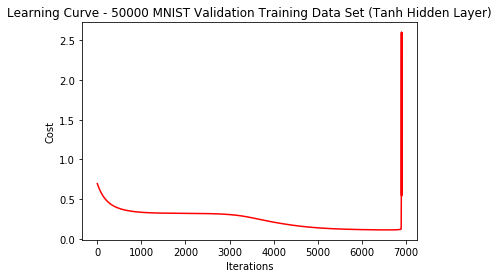

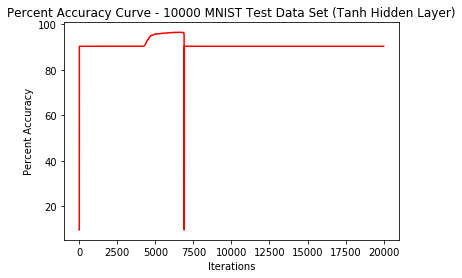

In [267]:
# gradient descent

detailed_logger = False
main_logger = True

# hyber-parameters
alpha = 0.01; 
number_of_iterations = 20000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = training_images
Y = training_labels

X_test = testing_images
Y_test = testing_labels

m = size

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    return np.where(Z >= 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)
    
def activation_sigmoid(Z):
    return 1/(1 + np.exp(-Z))

def loss(A, Y):
    return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def prediction(A):
    return np.where(A >= 0.5, 1, 0)

def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_tanh(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_tanh(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ_tanh(dZ, W, Z):
    return np.multiply(np.dot(np.transpose(W), dZ), 1 - np.multiply(Z, Z))

def dW(dZ, A):
    return np.multiply(1/len(dZ[0]), np.dot(dZ, np.transpose(A)))

def dB(dZ):
    return np.multiply(1/len(dZ[0]), np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ_tanh(_dZ, W[layer+1], Z_layers[layer])
        _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, layer)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    

# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True):
        print('Main Loop Iteration: ' + str(iteration))
    
    # forward propogation training data set
    A_layers, Z_layers = forward_propagation_return_layers(W, B, X, [X], [], 0)
    L = loss(A_layers[len(A_layers) - 1], Y)
    C = cost(L) 
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, len(W) - 1)
    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' MNIST Validation Training Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' MNIST Test Data Set (Tanh Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

We are left with some interesting results. As we can see from the accuracy curve the network reached approximately 96% accuracy after around ~6,000 iterations; however, we then see a steep drop off. What is likely happening here is that at this point the network began to overfit the training data, and therefore, performed poorly on the testing data from then on. As seen, for the last ~14,000 iterations the accuracy remains at approximately 90%. As before, this idicates that it does not detect any 9s in the test data. We can confirm that no 9s are predicted by attempting to find a true positive or a false positive. If none are found, then our suspicion is likely confirmed.


Results: 

True Negative Found: True Label: 0 Predicted: 0, @ Test Data Index: 0, Size; (1, 28, 28)


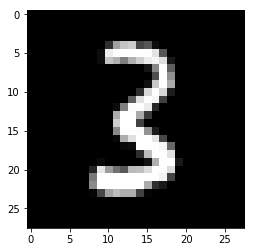

False Negative Found: True Label: 1 Predicted: 0, @ Test Data Index: 3, Size; (1, 28, 28)


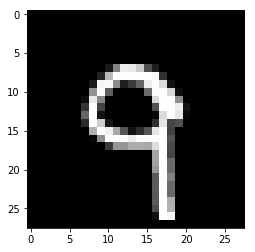

In [268]:
print('')
print('Results: ')
print('')
    
true_positive_found = 0
true_negative_found = 0
false_postitive_found = 0
false_negative_found = 0

true_positive_example = []
true_negative_example = []
false_postitive_example = []
false_negative_example = []

for index in range(0, len(testing_labels)):
    true_label = testing_labels[index]
    predicted_label = _prediction[0][index]
    #print('True Label: ' + str(true_label))
    #print('Predicted Label: ' + str(predicted_label))
    if(false_negative_found and false_postitive_found and true_positive_found and true_negative_found):
        break
    elif(not false_negative_found and true_label == 1 and predicted_label == 0):
        false_negative_found = 1
        false_negative_example.append(np.array(images[number_of_training_images + index]))
        print('False Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_negative_example).shape))
        pyplot.imshow(false_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not false_postitive_found and true_label == 0 and predicted_label == 1):
        false_postitive_found = 1
        false_postitive_example.append(np.array(images[number_of_training_images + index]))
        print('False Positive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(false_postitive_example).shape))
        pyplot.imshow(false_postitive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_positive_found and true_label == 1 and predicted_label == 1):
        true_positive_found = 1
        true_positive_example.append(np.array(images[number_of_training_images + index]))
        print('True Postitive Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_positive_example).shape))
        pyplot.imshow(true_positive_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show()
    elif(not true_negative_example and true_label == 0 and predicted_label == 0):
        true_negative_found = 1
        true_negative_example.append(np.array(images[number_of_training_images + index]))
        print('True Negative Found: True Label: ' + str(true_label) + ' Predicted: ' + str(predicted_label) + ', @ Test Data Index: ' + str(index) + ', Size; ' + str(np.array(true_negative_example).shape))
        pyplot.imshow(true_negative_example[0], cmap='gray')  # plot the image in "gray" colormap
        pyplot.show() 

As illustrated above, no true positive or false positive was found. This means the network never predicted a 9 after 20,00 iterations. Therefore, our suspicion is likely confirmed.

We have tested networks with multiple layers, different #'s of units per layer, different learninig rates, and with either the relu or tanh activation functions in the hidden layers. From our analysis we achieved the best results while using relu with two layers and 20 hidden units per layer. 

This concludes the assignment.